#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

<b>Цель:</b> Построить модель для предсказания количества заказов. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель CatBoost</a></span></li><li><span><a href="#Модель-Linear-Regression" data-toc-modified-id="Модель-Linear-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель Linear Regression</a></span></li><li><span><a href="#Модель-Random-Forest" data-toc-modified-id="Модель-Random-Forest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель Random Forest</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]) #чтение файла с данными и запись в переменную

In [3]:
df.head() #вывод первых 5-ти строк

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [4]:
df.info() #получаем общую информацию о данных

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.index.is_monotonic #проверка, в хронологическом ли порядке расположены даты и время

True

In [6]:
df = df.resample('1H').sum() #выполняем ресемплирование по одному часу

<b>Вывод: </b>данные подготовлены - индексирование производится по датам, проведена проверка на монотонность, сделано ресемплирование по одному часу.

## Анализ

Определим временной интервал:

In [7]:
print('Дата начала интервала:', df.index.min())
print('Дата окончания интервала:', df.index.max())

Дата начала интервала: 2018-03-01 00:00:00
Дата окончания интервала: 2018-08-31 23:00:00


Таким образом, в нашем распоряжении интервал с 1 марта до 31 августа 2018 года. Отобразим данные на графике:

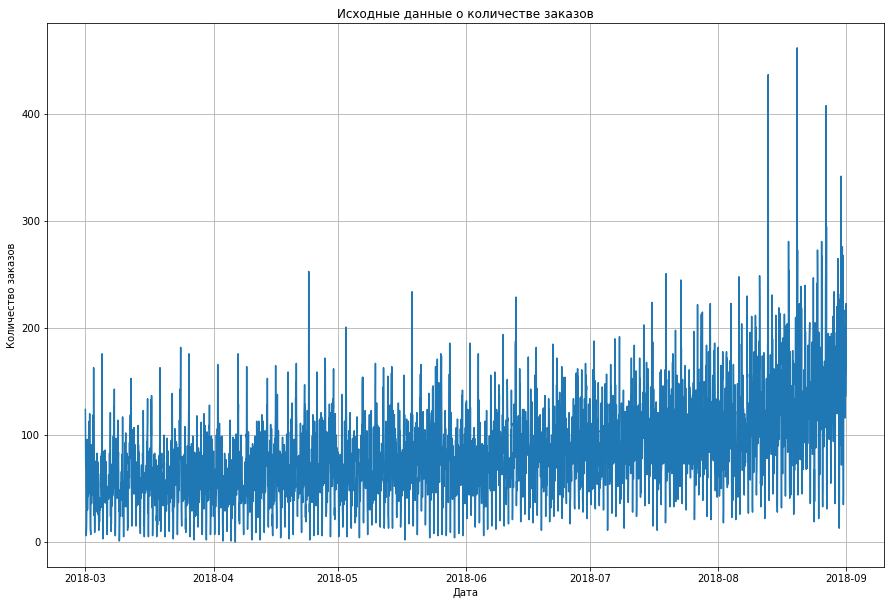

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(df)
plt.title('Исходные данные о количестве заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid()
plt.show()

Видим нестационарный временной ряд. Проведем декомпозицию исходных данных на тренд, сезонную составляющую и остаток:

In [9]:
decomposed = seasonal_decompose(df)

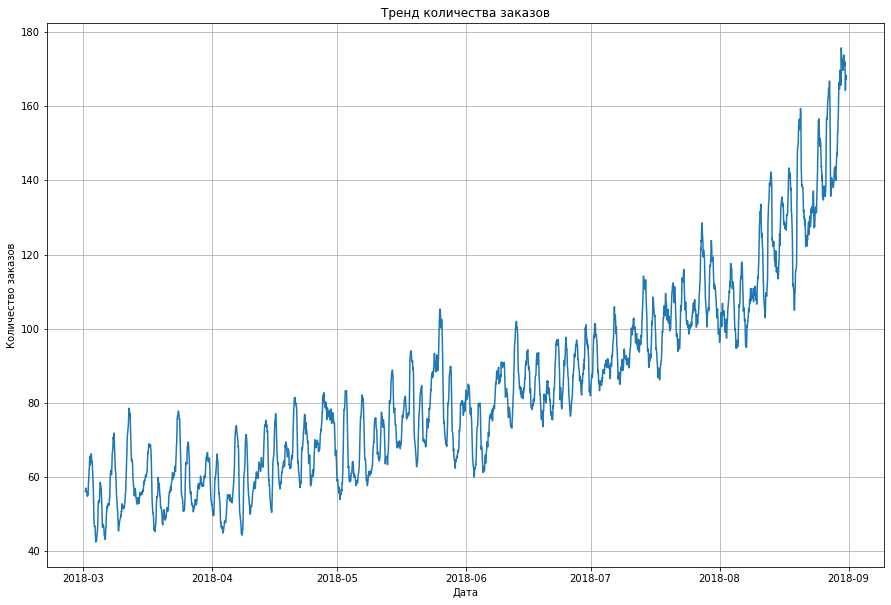

In [10]:
plt.figure(figsize=(15, 10))
plt.plot(decomposed.trend)
plt.title('Тренд количества заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid()
plt.show()

Видим, что количество заказов постепенно увеличивается с началом сезона отпусков. Построим график сезонной составляющей:

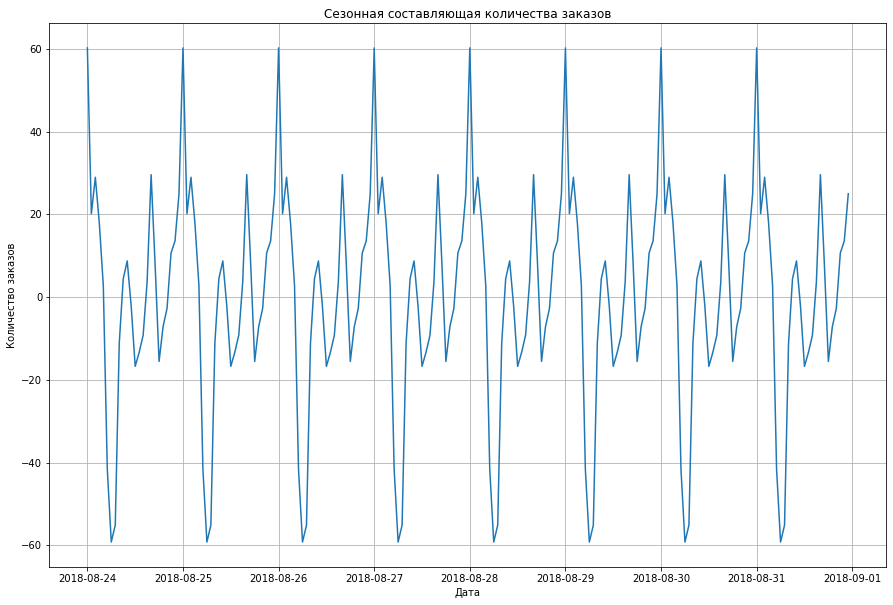

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(decomposed.seasonal['2018-08-24':'2018-08-31'])
plt.title('Сезонная составляющая количества заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid()
plt.show()

Дневной пик вызовов в аэропорт обычно приходится на полночь, а уже ранним утром количество вызовов минимально. Построим диаграмму шумов:

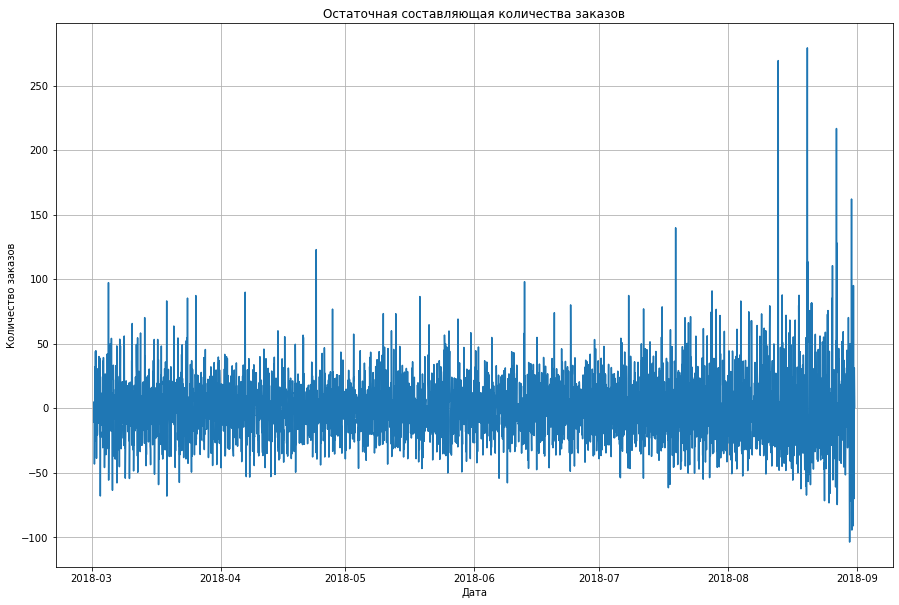

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(decomposed.resid)
plt.title('Остаточная составляющая количества заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid()
plt.show()

В конце августа большие выбросы: люди массово возвращаются из отпусков, возвращаются с каникул студенты и т. д. Видим, что максимальные выбросы вверх были ночью три последних понедельника августа.

In [13]:
decomposed.resid.sort_values(ascending=False)[0:5]

datetime
2018-08-20 02:00:00    279.371423
2018-08-13 02:00:00    269.517257
2018-08-27 02:00:00    216.892257
2018-08-30 17:00:00    162.246651
2018-07-19 10:00:00    139.949065
Name: resid, dtype: float64

А максимальные выбросы вниз в последние два дня августа:

In [14]:
decomposed.resid.sort_values()[0:5]

datetime
2018-08-30 06:00:00   -103.546496
2018-08-30 19:00:00    -94.229897
2018-08-31 03:00:00    -90.927074
2018-08-30 07:00:00    -80.791373
2018-08-27 06:00:00    -74.483996
Name: resid, dtype: float64

<b>Вывод: </b>Данные проанализированы, найден исследуемый период, рассмотрены составляющие данных: тренд, сезонная составляющая и остаток.

## Обучение

In [15]:
#загтовка для итоговой таблицы
ml_models_summary = pd.DataFrame(columns=['Model', 'RMSE', 'Comments'])

model_name_list = []
RMSE_list = []
comment_list = []

### Создание признаков

Функция для создания признаков включает в себя:

1. Календарные признаки
    * Признак месяца
    * Признак дня месяца
    * Признак дня недели
    * Признак часа
2. "Отстающие значения" - предыдущие значения временного ряда, количество задается в функции
3. Скользящее среднее

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

Создаем с помощью функции новые признаки в исходном датасете:

In [17]:
featured_data = make_features(df, 6, 6)

In [18]:
featured_data.head(10) #вывод на экран первых 10ти строк датасета с созданными признаками

num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124      3    1          3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     1  124.0    NaN   
2018-03-01 02:00:00          71      3    1          3     2   85.0  124.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1          3     4   66.0   71.0   
2018-03-01 05:00:00           6      3    1          3     5   43.0   66.0   
2018-03-01 06:00:00          12      3    1          3     6    6.0   43.0   
2018-03-01 07:00:00          15      3    1          3     7   12.0    6.0   
2018-03-01 08:00:00          34      3    1          3     8   15.0   12.0   
2018-03-01 09:00:00          69      3    1          3     9   34.0   15.0   

                     lag_3  lag_4  lag_5  lag_6  rolling_mean  
datetime                                                       
2018-03-01 00:00:00    NaN    NaN    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN    NaN    NaN           NaN  
2018-03-01 02:00:00    NaN    NaN    NaN    NaN           NaN  
2018-03-01 03:00:00  124.0    NaN    NaN    NaN           NaN  
2018-03-01 04:00:00   85.0  124.0    NaN    NaN           NaN  
2018-03-01 05:00:00   71.0   85.0  124.0    NaN           NaN  
2018-03-01 06:00:00   66.0   71.0   85.0  124.0     65.833333  
2018-03-01 07:00:00   43.0   66.0   71.0   85.0     47.166667  
2018-03-01 08:00:00    6.0   43.0   66.0   71.0     35.500000  
2018-03-01 09:00:00   12.0    6.0   43.0   66.0     29.333333

Выделим категориальные признаки в отдельный список:

In [19]:
categorical_features_list = ['month', 'day', 'dayofweek', 'hour']

### Модель CatBoost

Разделяем датасет на тренировочную и тестовую выборки с соотношением 0.1:

In [20]:
train, test = train_test_split(featured_data, shuffle=False, test_size=0.1)
train = train.dropna()

Выделяем признаки и таргет в полученных выборках:

In [21]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [22]:
print("Размер тренировочной выборки с признаками: ", features_train.shape)
print("Размер тренировочной выборки с целевым признаком: ", target_train.shape)
print("Размер тестовой выборки с признаками: ", features_test.shape)
print("Размер тестовой выборки с целевым признаком: ", target_test.shape)

Размер тренировочной выборки с признаками:  (3968, 11)
Размер тренировочной выборки с целевым признаком:  (3968,)
Размер тестовой выборки с признаками:  (442, 11)
Размер тестовой выборки с целевым признаком:  (442,)


Для модели CatBoost категориальные признаки не кодировались, т. к. у нее есть встроенный кодировщик.

Подбор параметров для модели и обучение:

In [23]:
train_data = Pool(data=features_train, label=target_train, cat_features=categorical_features_list)

cat = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1, 0.15],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, train_data, plot=True, cv=TimeSeriesSplit(n_splits=5))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 77.0453996	test: 112.1033035	best: 112.1033035 (0)	total: 144ms	remaining: 2m 23s
1:	learn: 75.1293631	test: 109.6174210	best: 109.6174210 (1)	total: 152ms	remaining: 1m 15s
2:	learn: 73.2342955	test: 107.4059251	best: 107.4059251 (2)	total: 159ms	remaining: 52.8s
3:	learn: 71.4322108	test: 105.4556925	best: 105.4556925 (3)	total: 168ms	remaining: 41.8s
4:	learn: 69.7321351	test: 103.7336208	best: 103.7336208 (4)	total: 175ms	remaining: 34.8s
5:	learn: 68.0422404	test: 101.7844198	best: 101.7844198 (5)	total: 183ms	remaining: 30.3s
6:	learn: 66.3896657	test: 99.7089028	best: 99.7089028 (6)	total: 190ms	remaining: 27s
7:	learn: 64.8050134	test: 97.8090698	best: 97.8090698 (7)	total: 198ms	remaining: 24.6s
8:	learn: 63.3645332	test: 96.2959292	best: 96.2959292 (8)	total: 200ms	remaining: 22.1s
9:	learn: 61.9424917	test: 94.6710618	best: 94.6710618 (9)	total: 207ms	remaining: 20.5s
10:	learn: 60.5818722	test: 93.0542226	best: 93.0542226 (10)	total: 215ms	remaining: 19.3s
11:	lea

94:	learn: 22.4397105	test: 42.5762413	best: 42.5762413 (94)	total: 880ms	remaining: 8.38s
95:	learn: 22.3806868	test: 42.4018793	best: 42.4018793 (95)	total: 888ms	remaining: 8.36s
96:	learn: 22.3319278	test: 42.2462742	best: 42.2462742 (96)	total: 898ms	remaining: 8.36s
97:	learn: 22.2829081	test: 42.1470203	best: 42.1470203 (97)	total: 906ms	remaining: 8.34s
98:	learn: 22.2321945	test: 42.0034247	best: 42.0034247 (98)	total: 913ms	remaining: 8.31s
99:	learn: 22.1954214	test: 41.8204438	best: 41.8204438 (99)	total: 921ms	remaining: 8.29s
100:	learn: 22.1484874	test: 41.6774588	best: 41.6774588 (100)	total: 928ms	remaining: 8.26s
101:	learn: 22.1155616	test: 41.5881713	best: 41.5881713 (101)	total: 935ms	remaining: 8.23s
102:	learn: 22.0724973	test: 41.5007389	best: 41.5007389 (102)	total: 943ms	remaining: 8.21s
103:	learn: 22.0527619	test: 41.4382346	best: 41.4382346 (103)	total: 946ms	remaining: 8.15s
104:	learn: 22.0140449	test: 41.3083408	best: 41.3083408 (104)	total: 955ms	remain

185:	learn: 20.7173093	test: 35.7939259	best: 35.7939259 (185)	total: 1.62s	remaining: 7.1s
186:	learn: 20.7133001	test: 35.7743881	best: 35.7743881 (186)	total: 1.64s	remaining: 7.12s
187:	learn: 20.7057883	test: 35.7478592	best: 35.7478592 (187)	total: 1.65s	remaining: 7.11s
188:	learn: 20.6978947	test: 35.7237491	best: 35.7237491 (188)	total: 1.66s	remaining: 7.1s
189:	learn: 20.6895685	test: 35.6576370	best: 35.6576370 (189)	total: 1.66s	remaining: 7.09s
190:	learn: 20.6804754	test: 35.6285101	best: 35.6285101 (190)	total: 1.67s	remaining: 7.07s
191:	learn: 20.6564382	test: 35.6026419	best: 35.6026419 (191)	total: 1.68s	remaining: 7.06s
192:	learn: 20.6540927	test: 35.6021859	best: 35.6021859 (192)	total: 1.68s	remaining: 7.04s
193:	learn: 20.6506055	test: 35.4779760	best: 35.4779760 (193)	total: 1.69s	remaining: 7.03s
194:	learn: 20.6476017	test: 35.4617402	best: 35.4617402 (194)	total: 1.7s	remaining: 7.02s
195:	learn: 20.6430441	test: 35.4373366	best: 35.4373366 (195)	total: 1.7

277:	learn: 20.1227876	test: 34.1125721	best: 34.1125721 (277)	total: 2.35s	remaining: 6.11s
278:	learn: 20.1175964	test: 34.0367802	best: 34.0367802 (278)	total: 2.36s	remaining: 6.1s
279:	learn: 20.1167103	test: 34.0355252	best: 34.0355252 (279)	total: 2.37s	remaining: 6.09s
280:	learn: 20.1084867	test: 33.9910334	best: 33.9910334 (280)	total: 2.37s	remaining: 6.08s
281:	learn: 20.1052063	test: 33.9919073	best: 33.9910334 (280)	total: 2.38s	remaining: 6.07s
282:	learn: 20.1020292	test: 33.9919694	best: 33.9910334 (280)	total: 2.39s	remaining: 6.05s
283:	learn: 20.0947729	test: 33.9876535	best: 33.9876535 (283)	total: 2.4s	remaining: 6.04s
284:	learn: 20.0917290	test: 33.9936492	best: 33.9876535 (283)	total: 2.41s	remaining: 6.04s
285:	learn: 20.0895877	test: 33.9974643	best: 33.9876535 (283)	total: 2.41s	remaining: 6.02s
286:	learn: 20.0870676	test: 33.9990455	best: 33.9876535 (283)	total: 2.42s	remaining: 6.01s
287:	learn: 20.0821838	test: 33.9917568	best: 33.9876535 (283)	total: 2.

372:	learn: 19.6987615	test: 33.4884654	best: 33.4884654 (372)	total: 3.12s	remaining: 5.24s
373:	learn: 19.6866044	test: 33.4656093	best: 33.4656093 (373)	total: 3.13s	remaining: 5.24s
374:	learn: 19.6811215	test: 33.4648053	best: 33.4648053 (374)	total: 3.14s	remaining: 5.23s
375:	learn: 19.6761828	test: 33.4640779	best: 33.4640779 (375)	total: 3.15s	remaining: 5.22s
376:	learn: 19.6704871	test: 33.4567048	best: 33.4567048 (376)	total: 3.15s	remaining: 5.21s
377:	learn: 19.6664942	test: 33.4493146	best: 33.4493146 (377)	total: 3.16s	remaining: 5.21s
378:	learn: 19.6627192	test: 33.4504992	best: 33.4493146 (377)	total: 3.17s	remaining: 5.2s
379:	learn: 19.6581846	test: 33.4407328	best: 33.4407328 (379)	total: 3.18s	remaining: 5.19s
380:	learn: 19.6539695	test: 33.4273035	best: 33.4273035 (380)	total: 3.19s	remaining: 5.18s
381:	learn: 19.6468877	test: 33.4249225	best: 33.4249225 (381)	total: 3.2s	remaining: 5.17s
382:	learn: 19.6437334	test: 33.4195371	best: 33.4195371 (382)	total: 3.

462:	learn: 19.3623917	test: 33.1633217	best: 33.1633217 (462)	total: 3.87s	remaining: 4.48s
463:	learn: 19.3604537	test: 33.1531506	best: 33.1531506 (463)	total: 3.87s	remaining: 4.47s
464:	learn: 19.3595216	test: 33.1514230	best: 33.1514230 (464)	total: 3.88s	remaining: 4.47s
465:	learn: 19.3563861	test: 33.1501185	best: 33.1501185 (465)	total: 3.89s	remaining: 4.46s
466:	learn: 19.3524165	test: 33.1506442	best: 33.1501185 (465)	total: 3.9s	remaining: 4.45s
467:	learn: 19.3494969	test: 33.1056748	best: 33.1056748 (467)	total: 3.91s	remaining: 4.44s
468:	learn: 19.3468138	test: 33.1753063	best: 33.1056748 (467)	total: 3.91s	remaining: 4.43s
469:	learn: 19.3374090	test: 33.1736310	best: 33.1056748 (467)	total: 3.92s	remaining: 4.42s
470:	learn: 19.3366353	test: 33.1728575	best: 33.1056748 (467)	total: 3.93s	remaining: 4.41s
471:	learn: 19.3293260	test: 33.1653396	best: 33.1056748 (467)	total: 3.94s	remaining: 4.4s
472:	learn: 19.3281838	test: 33.1670191	best: 33.1056748 (467)	total: 3.

551:	learn: 19.0652501	test: 32.9010481	best: 32.9010481 (551)	total: 4.6s	remaining: 3.74s
552:	learn: 19.0614203	test: 32.9023172	best: 32.9010481 (551)	total: 4.61s	remaining: 3.73s
553:	learn: 19.0604797	test: 32.9023116	best: 32.9010481 (551)	total: 4.62s	remaining: 3.72s
554:	learn: 19.0585288	test: 32.8996030	best: 32.8996030 (554)	total: 4.63s	remaining: 3.71s
555:	learn: 19.0539003	test: 32.8955516	best: 32.8955516 (555)	total: 4.64s	remaining: 3.7s
556:	learn: 19.0519988	test: 32.8772402	best: 32.8772402 (556)	total: 4.64s	remaining: 3.69s
557:	learn: 19.0494756	test: 32.8759360	best: 32.8759360 (557)	total: 4.65s	remaining: 3.69s
558:	learn: 19.0479209	test: 32.8715688	best: 32.8715688 (558)	total: 4.66s	remaining: 3.68s
559:	learn: 19.0468633	test: 32.8709403	best: 32.8709403 (559)	total: 4.67s	remaining: 3.67s
560:	learn: 19.0457504	test: 32.8743270	best: 32.8709403 (559)	total: 4.67s	remaining: 3.66s
561:	learn: 19.0452015	test: 32.8741180	best: 32.8709403 (559)	total: 4.

653:	learn: 18.7692147	test: 32.7026354	best: 32.7026354 (653)	total: 5.36s	remaining: 2.83s
654:	learn: 18.7645310	test: 32.7061959	best: 32.7026354 (653)	total: 5.37s	remaining: 2.83s
655:	learn: 18.7627673	test: 32.7002665	best: 32.7002665 (655)	total: 5.38s	remaining: 2.82s
656:	learn: 18.7535341	test: 32.6962917	best: 32.6962917 (656)	total: 5.38s	remaining: 2.81s
657:	learn: 18.7498504	test: 32.6937015	best: 32.6937015 (657)	total: 5.39s	remaining: 2.8s
658:	learn: 18.7471995	test: 32.6816786	best: 32.6816786 (658)	total: 5.4s	remaining: 2.79s
659:	learn: 18.7444547	test: 32.6624177	best: 32.6624177 (659)	total: 5.41s	remaining: 2.79s
660:	learn: 18.7430298	test: 32.6613692	best: 32.6613692 (660)	total: 5.41s	remaining: 2.78s
661:	learn: 18.7411354	test: 32.6627847	best: 32.6613692 (660)	total: 5.42s	remaining: 2.77s
662:	learn: 18.7384518	test: 32.6637097	best: 32.6613692 (660)	total: 5.43s	remaining: 2.76s
663:	learn: 18.7305815	test: 32.6626515	best: 32.6613692 (660)	total: 5.

758:	learn: 18.5061262	test: 32.4915330	best: 32.4585537 (739)	total: 6.12s	remaining: 1.94s
759:	learn: 18.5042868	test: 32.4937344	best: 32.4585537 (739)	total: 6.13s	remaining: 1.94s
760:	learn: 18.5019627	test: 32.4948482	best: 32.4585537 (739)	total: 6.14s	remaining: 1.93s
761:	learn: 18.4940348	test: 32.5043012	best: 32.4585537 (739)	total: 6.14s	remaining: 1.92s
762:	learn: 18.4925574	test: 32.5032596	best: 32.4585537 (739)	total: 6.15s	remaining: 1.91s
763:	learn: 18.4900650	test: 32.5042223	best: 32.4585537 (739)	total: 6.16s	remaining: 1.9s
764:	learn: 18.4887210	test: 32.5066487	best: 32.4585537 (739)	total: 6.16s	remaining: 1.89s
765:	learn: 18.4872954	test: 32.5037269	best: 32.4585537 (739)	total: 6.17s	remaining: 1.89s
766:	learn: 18.4851686	test: 32.5051414	best: 32.4585537 (739)	total: 6.18s	remaining: 1.88s
767:	learn: 18.4822929	test: 32.5115791	best: 32.4585537 (739)	total: 6.19s	remaining: 1.87s
768:	learn: 18.4770670	test: 32.4925800	best: 32.4585537 (739)	total: 6

853:	learn: 18.2963400	test: 32.3040630	best: 32.3014639 (852)	total: 6.86s	remaining: 1.17s
854:	learn: 18.2954834	test: 32.2902103	best: 32.2902103 (854)	total: 6.87s	remaining: 1.16s
855:	learn: 18.2914966	test: 32.2872139	best: 32.2872139 (855)	total: 6.88s	remaining: 1.16s
856:	learn: 18.2903936	test: 32.2788170	best: 32.2788170 (856)	total: 6.88s	remaining: 1.15s
857:	learn: 18.2899807	test: 32.2779438	best: 32.2779438 (857)	total: 6.9s	remaining: 1.14s
858:	learn: 18.2895661	test: 32.2785240	best: 32.2779438 (857)	total: 6.91s	remaining: 1.13s
859:	learn: 18.2828831	test: 32.2703362	best: 32.2703362 (859)	total: 6.92s	remaining: 1.13s
860:	learn: 18.2817679	test: 32.2741533	best: 32.2703362 (859)	total: 6.93s	remaining: 1.12s
861:	learn: 18.2805104	test: 32.2761218	best: 32.2703362 (859)	total: 6.95s	remaining: 1.11s
862:	learn: 18.2799004	test: 32.2729096	best: 32.2703362 (859)	total: 6.96s	remaining: 1.1s
863:	learn: 18.2781590	test: 32.2835907	best: 32.2703362 (859)	total: 6.

943:	learn: 18.0890877	test: 32.2264834	best: 32.2240950 (942)	total: 7.6s	remaining: 451ms
944:	learn: 18.0876664	test: 32.2261816	best: 32.2240950 (942)	total: 7.61s	remaining: 443ms
945:	learn: 18.0824947	test: 32.2189946	best: 32.2189946 (945)	total: 7.62s	remaining: 435ms
946:	learn: 18.0801739	test: 32.2141893	best: 32.2141893 (946)	total: 7.63s	remaining: 427ms
947:	learn: 18.0782596	test: 32.2137399	best: 32.2137399 (947)	total: 7.64s	remaining: 419ms
948:	learn: 18.0757104	test: 32.2112182	best: 32.2112182 (948)	total: 7.64s	remaining: 411ms
949:	learn: 18.0745415	test: 32.2103695	best: 32.2103695 (949)	total: 7.65s	remaining: 403ms
950:	learn: 18.0720561	test: 32.2103030	best: 32.2103030 (950)	total: 7.66s	remaining: 395ms
951:	learn: 18.0676380	test: 32.2107847	best: 32.2103030 (950)	total: 7.67s	remaining: 387ms
952:	learn: 18.0665982	test: 32.2108913	best: 32.2103030 (950)	total: 7.68s	remaining: 379ms
953:	learn: 18.0616911	test: 32.2098495	best: 32.2098495 (953)	total: 7

39:	learn: 21.5149145	test: 38.1301168	best: 38.1301168 (39)	total: 295ms	remaining: 7.08s
40:	learn: 21.4568174	test: 37.8030432	best: 37.8030432 (40)	total: 302ms	remaining: 7.07s
41:	learn: 21.3969053	test: 37.6168861	best: 37.6168861 (41)	total: 310ms	remaining: 7.08s
42:	learn: 21.3351513	test: 37.4499169	best: 37.4499169 (42)	total: 318ms	remaining: 7.07s
43:	learn: 21.2962233	test: 37.3502232	best: 37.3502232 (43)	total: 335ms	remaining: 7.27s
44:	learn: 21.2538572	test: 37.1502972	best: 37.1502972 (44)	total: 343ms	remaining: 7.29s
45:	learn: 21.2144744	test: 37.0783576	best: 37.0783576 (45)	total: 351ms	remaining: 7.28s
46:	learn: 21.1469547	test: 36.6550682	best: 36.6550682 (46)	total: 359ms	remaining: 7.27s
47:	learn: 21.1110035	test: 36.5452176	best: 36.5452176 (47)	total: 366ms	remaining: 7.26s
48:	learn: 21.0712712	test: 36.4581915	best: 36.4581915 (48)	total: 374ms	remaining: 7.26s
49:	learn: 21.0543505	test: 36.3938270	best: 36.3938270 (49)	total: 381ms	remaining: 7.25s

130:	learn: 19.4541126	test: 34.3471198	best: 34.3055715 (116)	total: 1.03s	remaining: 6.83s
131:	learn: 19.4406320	test: 34.3703398	best: 34.3055715 (116)	total: 1.04s	remaining: 6.83s
132:	learn: 19.4236032	test: 34.3661621	best: 34.3055715 (116)	total: 1.04s	remaining: 6.82s
133:	learn: 19.4173095	test: 34.3561007	best: 34.3055715 (116)	total: 1.05s	remaining: 6.8s
134:	learn: 19.4034211	test: 34.3627405	best: 34.3055715 (116)	total: 1.06s	remaining: 6.79s
135:	learn: 19.3968058	test: 34.1869644	best: 34.1869644 (135)	total: 1.07s	remaining: 6.78s
136:	learn: 19.3900911	test: 34.1930100	best: 34.1869644 (135)	total: 1.07s	remaining: 6.77s
137:	learn: 19.3786042	test: 34.1946698	best: 34.1869644 (135)	total: 1.08s	remaining: 6.76s
138:	learn: 19.3624748	test: 34.1793573	best: 34.1793573 (138)	total: 1.09s	remaining: 6.75s
139:	learn: 19.3504586	test: 34.1690818	best: 34.1690818 (139)	total: 1.1s	remaining: 6.73s
140:	learn: 19.3427379	test: 34.1687768	best: 34.1687768 (140)	total: 1.

235:	learn: 18.3105282	test: 32.6299600	best: 32.6293139 (234)	total: 1.77s	remaining: 5.74s
236:	learn: 18.3045219	test: 32.6296258	best: 32.6293139 (234)	total: 1.78s	remaining: 5.73s
237:	learn: 18.2934241	test: 32.6333957	best: 32.6293139 (234)	total: 1.79s	remaining: 5.72s
238:	learn: 18.2792218	test: 32.6293019	best: 32.6293019 (238)	total: 1.79s	remaining: 5.71s
239:	learn: 18.2692849	test: 32.6317697	best: 32.6293019 (238)	total: 1.8s	remaining: 5.71s
240:	learn: 18.2621565	test: 32.6391832	best: 32.6293019 (238)	total: 1.81s	remaining: 5.7s
241:	learn: 18.2580930	test: 32.6451557	best: 32.6293019 (238)	total: 1.81s	remaining: 5.69s
242:	learn: 18.2555239	test: 32.6477093	best: 32.6293019 (238)	total: 1.82s	remaining: 5.68s
243:	learn: 18.2416600	test: 32.6529477	best: 32.6293019 (238)	total: 1.83s	remaining: 5.67s
244:	learn: 18.2398366	test: 32.6503405	best: 32.6293019 (238)	total: 1.84s	remaining: 5.66s
245:	learn: 18.2361642	test: 32.6526941	best: 32.6293019 (238)	total: 1.

333:	learn: 17.6127293	test: 32.2071048	best: 31.9737572 (312)	total: 2.51s	remaining: 5s
334:	learn: 17.6103038	test: 32.2044753	best: 31.9737572 (312)	total: 2.51s	remaining: 4.99s
335:	learn: 17.6043101	test: 32.2056287	best: 31.9737572 (312)	total: 2.52s	remaining: 4.98s
336:	learn: 17.5906010	test: 32.1792249	best: 31.9737572 (312)	total: 2.53s	remaining: 4.97s
337:	learn: 17.5856967	test: 32.1766310	best: 31.9737572 (312)	total: 2.53s	remaining: 4.96s
338:	learn: 17.5806244	test: 32.1797285	best: 31.9737572 (312)	total: 2.54s	remaining: 4.95s
339:	learn: 17.5693109	test: 32.1771245	best: 31.9737572 (312)	total: 2.55s	remaining: 4.95s
340:	learn: 17.5628801	test: 32.1748757	best: 31.9737572 (312)	total: 2.55s	remaining: 4.94s
341:	learn: 17.5511182	test: 32.1663920	best: 31.9737572 (312)	total: 2.56s	remaining: 4.93s
342:	learn: 17.5430403	test: 32.1892752	best: 31.9737572 (312)	total: 2.57s	remaining: 4.92s
343:	learn: 17.5377801	test: 32.1879088	best: 31.9737572 (312)	total: 2.5

434:	learn: 16.9656706	test: 32.2734118	best: 31.9737572 (312)	total: 3.24s	remaining: 4.21s
435:	learn: 16.9639052	test: 32.2770130	best: 31.9737572 (312)	total: 3.25s	remaining: 4.2s
436:	learn: 16.9534658	test: 32.2939178	best: 31.9737572 (312)	total: 3.25s	remaining: 4.19s
437:	learn: 16.9415518	test: 32.2827340	best: 31.9737572 (312)	total: 3.26s	remaining: 4.18s
438:	learn: 16.9275292	test: 32.2835381	best: 31.9737572 (312)	total: 3.27s	remaining: 4.17s
439:	learn: 16.9256573	test: 32.2831108	best: 31.9737572 (312)	total: 3.27s	remaining: 4.17s
440:	learn: 16.9196914	test: 32.2796531	best: 31.9737572 (312)	total: 3.28s	remaining: 4.16s
441:	learn: 16.9148884	test: 32.2762002	best: 31.9737572 (312)	total: 3.29s	remaining: 4.15s
442:	learn: 16.9101401	test: 32.2791414	best: 31.9737572 (312)	total: 3.29s	remaining: 4.14s
443:	learn: 16.9055795	test: 32.2702338	best: 31.9737572 (312)	total: 3.3s	remaining: 4.13s
444:	learn: 16.9010778	test: 32.2599331	best: 31.9737572 (312)	total: 3.

537:	learn: 16.3667696	test: 32.3416402	best: 31.9361677 (476)	total: 3.98s	remaining: 3.42s
538:	learn: 16.3607252	test: 32.3604836	best: 31.9361677 (476)	total: 3.98s	remaining: 3.41s
539:	learn: 16.3587523	test: 32.3596786	best: 31.9361677 (476)	total: 3.99s	remaining: 3.4s
540:	learn: 16.3527364	test: 32.3329034	best: 31.9361677 (476)	total: 4s	remaining: 3.39s
541:	learn: 16.3510685	test: 32.3335220	best: 31.9361677 (476)	total: 4s	remaining: 3.38s
542:	learn: 16.3475550	test: 32.3449131	best: 31.9361677 (476)	total: 4.01s	remaining: 3.38s
543:	learn: 16.3399355	test: 32.3281419	best: 31.9361677 (476)	total: 4.02s	remaining: 3.37s
544:	learn: 16.3364935	test: 32.3233377	best: 31.9361677 (476)	total: 4.03s	remaining: 3.36s
545:	learn: 16.3296318	test: 32.3360983	best: 31.9361677 (476)	total: 4.03s	remaining: 3.35s
546:	learn: 16.3186874	test: 32.3490378	best: 31.9361677 (476)	total: 4.04s	remaining: 3.35s
547:	learn: 16.3120649	test: 32.3195575	best: 31.9361677 (476)	total: 4.05s	r

640:	learn: 15.8184669	test: 32.3254919	best: 31.9361677 (476)	total: 4.71s	remaining: 2.64s
641:	learn: 15.8159300	test: 32.3304824	best: 31.9361677 (476)	total: 4.71s	remaining: 2.63s
642:	learn: 15.8123845	test: 32.3187904	best: 31.9361677 (476)	total: 4.72s	remaining: 2.62s
643:	learn: 15.8084312	test: 32.3310881	best: 31.9361677 (476)	total: 4.73s	remaining: 2.61s
644:	learn: 15.8073545	test: 32.3349281	best: 31.9361677 (476)	total: 4.74s	remaining: 2.61s
645:	learn: 15.8036208	test: 32.3331188	best: 31.9361677 (476)	total: 4.74s	remaining: 2.6s
646:	learn: 15.8018084	test: 32.3411541	best: 31.9361677 (476)	total: 4.75s	remaining: 2.59s
647:	learn: 15.7992456	test: 32.3437221	best: 31.9361677 (476)	total: 4.76s	remaining: 2.58s
648:	learn: 15.7923896	test: 32.3419520	best: 31.9361677 (476)	total: 4.76s	remaining: 2.58s
649:	learn: 15.7861749	test: 32.3413351	best: 31.9361677 (476)	total: 4.77s	remaining: 2.57s
650:	learn: 15.7847862	test: 32.3348407	best: 31.9361677 (476)	total: 4

744:	learn: 15.4021040	test: 32.1455422	best: 31.9361677 (476)	total: 5.45s	remaining: 1.86s
745:	learn: 15.3950180	test: 32.1442067	best: 31.9361677 (476)	total: 5.46s	remaining: 1.86s
746:	learn: 15.3948948	test: 32.1437405	best: 31.9361677 (476)	total: 5.46s	remaining: 1.85s
747:	learn: 15.3882503	test: 32.1514132	best: 31.9361677 (476)	total: 5.47s	remaining: 1.84s
748:	learn: 15.3856283	test: 32.1499046	best: 31.9361677 (476)	total: 5.48s	remaining: 1.84s
749:	learn: 15.3835552	test: 32.1537815	best: 31.9361677 (476)	total: 5.49s	remaining: 1.83s
750:	learn: 15.3772005	test: 32.1535621	best: 31.9361677 (476)	total: 5.49s	remaining: 1.82s
751:	learn: 15.3741164	test: 32.1551641	best: 31.9361677 (476)	total: 5.5s	remaining: 1.81s
752:	learn: 15.3585033	test: 32.1596756	best: 31.9361677 (476)	total: 5.51s	remaining: 1.81s
753:	learn: 15.3556508	test: 32.1578966	best: 31.9361677 (476)	total: 5.51s	remaining: 1.8s
754:	learn: 15.3545743	test: 32.1588658	best: 31.9361677 (476)	total: 5.

847:	learn: 14.9945086	test: 32.0079811	best: 31.9361677 (476)	total: 6.18s	remaining: 1.11s
848:	learn: 14.9935991	test: 32.0062757	best: 31.9361677 (476)	total: 6.19s	remaining: 1.1s
849:	learn: 14.9917020	test: 32.0195290	best: 31.9361677 (476)	total: 6.2s	remaining: 1.09s
850:	learn: 14.9895871	test: 32.0245818	best: 31.9361677 (476)	total: 6.2s	remaining: 1.09s
851:	learn: 14.9817041	test: 32.0320791	best: 31.9361677 (476)	total: 6.21s	remaining: 1.08s
852:	learn: 14.9797072	test: 32.0315325	best: 31.9361677 (476)	total: 6.22s	remaining: 1.07s
853:	learn: 14.9763179	test: 32.0138858	best: 31.9361677 (476)	total: 6.22s	remaining: 1.06s
854:	learn: 14.9733846	test: 32.0107642	best: 31.9361677 (476)	total: 6.23s	remaining: 1.06s
855:	learn: 14.9701336	test: 32.0120957	best: 31.9361677 (476)	total: 6.24s	remaining: 1.05s
856:	learn: 14.9654058	test: 32.0048292	best: 31.9361677 (476)	total: 6.25s	remaining: 1.04s
857:	learn: 14.9641355	test: 32.0046733	best: 31.9361677 (476)	total: 6.2

950:	learn: 14.6035110	test: 32.0472926	best: 31.9361677 (476)	total: 6.91s	remaining: 356ms
951:	learn: 14.5986048	test: 32.0533185	best: 31.9361677 (476)	total: 6.92s	remaining: 349ms
952:	learn: 14.5971325	test: 32.0531935	best: 31.9361677 (476)	total: 6.93s	remaining: 342ms
953:	learn: 14.5936152	test: 32.0378192	best: 31.9361677 (476)	total: 6.93s	remaining: 334ms
954:	learn: 14.5915337	test: 32.0420186	best: 31.9361677 (476)	total: 6.94s	remaining: 327ms
955:	learn: 14.5854619	test: 32.0468698	best: 31.9361677 (476)	total: 6.95s	remaining: 320ms
956:	learn: 14.5838189	test: 32.0445803	best: 31.9361677 (476)	total: 6.96s	remaining: 313ms
957:	learn: 14.5827658	test: 32.0448534	best: 31.9361677 (476)	total: 6.96s	remaining: 305ms
958:	learn: 14.5685898	test: 32.0245882	best: 31.9361677 (476)	total: 6.97s	remaining: 298ms
959:	learn: 14.5633113	test: 32.0272894	best: 31.9361677 (476)	total: 6.98s	remaining: 291ms
960:	learn: 14.5501299	test: 32.0066577	best: 31.9361677 (476)	total: 

55:	learn: 20.2459131	test: 33.8349864	best: 33.8349864 (55)	total: 386ms	remaining: 6.5s
56:	learn: 20.2077769	test: 33.7266354	best: 33.7266354 (56)	total: 393ms	remaining: 6.5s
57:	learn: 20.1816346	test: 33.7010289	best: 33.7010289 (57)	total: 400ms	remaining: 6.5s
58:	learn: 20.1453718	test: 33.6522697	best: 33.6522697 (58)	total: 407ms	remaining: 6.49s
59:	learn: 20.1179758	test: 33.6057486	best: 33.6057486 (59)	total: 414ms	remaining: 6.49s
60:	learn: 20.0901273	test: 33.6289477	best: 33.6057486 (59)	total: 421ms	remaining: 6.49s
61:	learn: 20.0718962	test: 33.5561094	best: 33.5561094 (61)	total: 429ms	remaining: 6.49s
62:	learn: 20.0589955	test: 33.5644770	best: 33.5561094 (61)	total: 436ms	remaining: 6.48s
63:	learn: 20.0305121	test: 33.6192066	best: 33.5561094 (61)	total: 443ms	remaining: 6.48s
64:	learn: 20.0073403	test: 33.5781496	best: 33.5561094 (61)	total: 450ms	remaining: 6.47s
65:	learn: 19.9938355	test: 33.5589452	best: 33.5561094 (61)	total: 457ms	remaining: 6.46s
66

157:	learn: 18.4905356	test: 32.7579573	best: 32.5483718 (147)	total: 1.13s	remaining: 6s
158:	learn: 18.4785893	test: 32.7793881	best: 32.5483718 (147)	total: 1.13s	remaining: 6s
159:	learn: 18.4772005	test: 32.7666478	best: 32.5483718 (147)	total: 1.14s	remaining: 5.99s
160:	learn: 18.4741593	test: 32.7716034	best: 32.5483718 (147)	total: 1.15s	remaining: 5.98s
161:	learn: 18.4638367	test: 32.7841930	best: 32.5483718 (147)	total: 1.15s	remaining: 5.97s
162:	learn: 18.4558516	test: 32.8256860	best: 32.5483718 (147)	total: 1.16s	remaining: 5.96s
163:	learn: 18.4448512	test: 32.7601157	best: 32.5483718 (147)	total: 1.17s	remaining: 5.96s
164:	learn: 18.4390542	test: 32.7964081	best: 32.5483718 (147)	total: 1.18s	remaining: 5.95s
165:	learn: 18.4340555	test: 32.7906881	best: 32.5483718 (147)	total: 1.18s	remaining: 5.95s
166:	learn: 18.4187975	test: 32.7969869	best: 32.5483718 (147)	total: 1.19s	remaining: 5.94s
167:	learn: 18.4129045	test: 32.7987802	best: 32.5483718 (147)	total: 1.2s	r

257:	learn: 17.4545799	test: 31.9677312	best: 31.8632482 (241)	total: 1.86s	remaining: 5.34s
258:	learn: 17.4389802	test: 31.9920174	best: 31.8632482 (241)	total: 1.86s	remaining: 5.34s
259:	learn: 17.4339308	test: 31.9914546	best: 31.8632482 (241)	total: 1.87s	remaining: 5.33s
260:	learn: 17.4106939	test: 31.9621485	best: 31.8632482 (241)	total: 1.88s	remaining: 5.32s
261:	learn: 17.4059400	test: 31.9935860	best: 31.8632482 (241)	total: 1.89s	remaining: 5.31s
262:	learn: 17.3982658	test: 32.0083163	best: 31.8632482 (241)	total: 1.89s	remaining: 5.3s
263:	learn: 17.3866762	test: 32.0050009	best: 31.8632482 (241)	total: 1.9s	remaining: 5.3s
264:	learn: 17.3795060	test: 32.0105833	best: 31.8632482 (241)	total: 1.91s	remaining: 5.29s
265:	learn: 17.3674587	test: 31.9821233	best: 31.8632482 (241)	total: 1.91s	remaining: 5.28s
266:	learn: 17.3637937	test: 31.9919625	best: 31.8632482 (241)	total: 1.92s	remaining: 5.27s
267:	learn: 17.3600575	test: 31.9962875	best: 31.8632482 (241)	total: 1.9

362:	learn: 16.5413762	test: 31.9904496	best: 31.8632482 (241)	total: 2.6s	remaining: 4.55s
363:	learn: 16.5376991	test: 31.9937255	best: 31.8632482 (241)	total: 2.6s	remaining: 4.55s
364:	learn: 16.5253268	test: 31.9925991	best: 31.8632482 (241)	total: 2.61s	remaining: 4.54s
365:	learn: 16.5176844	test: 32.0045268	best: 31.8632482 (241)	total: 2.62s	remaining: 4.53s
366:	learn: 16.5173873	test: 31.9964807	best: 31.8632482 (241)	total: 2.62s	remaining: 4.52s
367:	learn: 16.5055099	test: 31.9906835	best: 31.8632482 (241)	total: 2.63s	remaining: 4.52s
368:	learn: 16.4965494	test: 31.9402440	best: 31.8632482 (241)	total: 2.64s	remaining: 4.51s
369:	learn: 16.4868434	test: 31.9353554	best: 31.8632482 (241)	total: 2.64s	remaining: 4.5s
370:	learn: 16.4857909	test: 31.9342587	best: 31.8632482 (241)	total: 2.65s	remaining: 4.49s
371:	learn: 16.4855584	test: 31.9300770	best: 31.8632482 (241)	total: 2.66s	remaining: 4.49s
372:	learn: 16.4775699	test: 31.9340190	best: 31.8632482 (241)	total: 2.6

462:	learn: 15.7983002	test: 32.4139091	best: 31.8632482 (241)	total: 3.35s	remaining: 3.88s
463:	learn: 15.7974736	test: 32.4200029	best: 31.8632482 (241)	total: 3.36s	remaining: 3.88s
464:	learn: 15.7939624	test: 32.4549038	best: 31.8632482 (241)	total: 3.36s	remaining: 3.87s
465:	learn: 15.7890020	test: 32.3572508	best: 31.8632482 (241)	total: 3.37s	remaining: 3.86s
466:	learn: 15.7847817	test: 32.3463952	best: 31.8632482 (241)	total: 3.38s	remaining: 3.86s
467:	learn: 15.7801810	test: 32.3611908	best: 31.8632482 (241)	total: 3.39s	remaining: 3.85s
468:	learn: 15.7758306	test: 32.3628925	best: 31.8632482 (241)	total: 3.39s	remaining: 3.84s
469:	learn: 15.7650058	test: 32.3688430	best: 31.8632482 (241)	total: 3.4s	remaining: 3.83s
470:	learn: 15.7492065	test: 32.3798796	best: 31.8632482 (241)	total: 3.41s	remaining: 3.83s
471:	learn: 15.7440219	test: 32.3955102	best: 31.8632482 (241)	total: 3.42s	remaining: 3.83s
472:	learn: 15.7388792	test: 32.3931291	best: 31.8632482 (241)	total: 3

563:	learn: 15.1119723	test: 32.1244363	best: 31.8632482 (241)	total: 4.09s	remaining: 3.16s
564:	learn: 15.1084872	test: 32.1065314	best: 31.8632482 (241)	total: 4.09s	remaining: 3.15s
565:	learn: 15.0903548	test: 32.1165624	best: 31.8632482 (241)	total: 4.1s	remaining: 3.14s
566:	learn: 15.0854000	test: 32.1181587	best: 31.8632482 (241)	total: 4.11s	remaining: 3.14s
567:	learn: 15.0804655	test: 32.1299424	best: 31.8632482 (241)	total: 4.11s	remaining: 3.13s
568:	learn: 15.0739429	test: 32.1465714	best: 31.8632482 (241)	total: 4.12s	remaining: 3.12s
569:	learn: 15.0683750	test: 32.1491314	best: 31.8632482 (241)	total: 4.13s	remaining: 3.11s
570:	learn: 15.0663708	test: 32.1472646	best: 31.8632482 (241)	total: 4.13s	remaining: 3.11s
571:	learn: 15.0606815	test: 32.1320634	best: 31.8632482 (241)	total: 4.14s	remaining: 3.1s
572:	learn: 15.0568391	test: 32.1296504	best: 31.8632482 (241)	total: 4.15s	remaining: 3.09s
573:	learn: 15.0516522	test: 32.0711568	best: 31.8632482 (241)	total: 4.

665:	learn: 14.5273920	test: 32.5138934	best: 31.8632482 (241)	total: 4.83s	remaining: 2.42s
666:	learn: 14.5014620	test: 32.5283312	best: 31.8632482 (241)	total: 4.83s	remaining: 2.41s
667:	learn: 14.4902604	test: 32.8149674	best: 31.8632482 (241)	total: 4.84s	remaining: 2.4s
668:	learn: 14.4869524	test: 32.7826634	best: 31.8632482 (241)	total: 4.85s	remaining: 2.4s
669:	learn: 14.4862000	test: 32.7923529	best: 31.8632482 (241)	total: 4.85s	remaining: 2.39s
670:	learn: 14.4818643	test: 32.7725409	best: 31.8632482 (241)	total: 4.86s	remaining: 2.38s
671:	learn: 14.4805120	test: 32.7803540	best: 31.8632482 (241)	total: 4.87s	remaining: 2.38s
672:	learn: 14.4785050	test: 32.7912002	best: 31.8632482 (241)	total: 4.88s	remaining: 2.37s
673:	learn: 14.4728791	test: 32.8210702	best: 31.8632482 (241)	total: 4.88s	remaining: 2.36s
674:	learn: 14.4683085	test: 32.8013119	best: 31.8632482 (241)	total: 4.89s	remaining: 2.35s
675:	learn: 14.4669470	test: 32.8030828	best: 31.8632482 (241)	total: 4.

766:	learn: 14.0228978	test: 33.0898302	best: 31.8632482 (241)	total: 5.56s	remaining: 1.69s
767:	learn: 14.0074512	test: 33.0823908	best: 31.8632482 (241)	total: 5.57s	remaining: 1.68s
768:	learn: 14.0061226	test: 33.0750316	best: 31.8632482 (241)	total: 5.57s	remaining: 1.67s
769:	learn: 14.0033229	test: 33.0690569	best: 31.8632482 (241)	total: 5.58s	remaining: 1.67s
770:	learn: 13.9956923	test: 33.0674787	best: 31.8632482 (241)	total: 5.59s	remaining: 1.66s
771:	learn: 13.9904240	test: 33.0852296	best: 31.8632482 (241)	total: 5.59s	remaining: 1.65s
772:	learn: 13.9896181	test: 33.0863197	best: 31.8632482 (241)	total: 5.6s	remaining: 1.64s
773:	learn: 13.9806934	test: 33.0566949	best: 31.8632482 (241)	total: 5.61s	remaining: 1.64s
774:	learn: 13.9778082	test: 33.0592852	best: 31.8632482 (241)	total: 5.62s	remaining: 1.63s
775:	learn: 13.9772003	test: 33.0594181	best: 31.8632482 (241)	total: 5.62s	remaining: 1.62s
776:	learn: 13.9738097	test: 33.0649250	best: 31.8632482 (241)	total: 5

870:	learn: 13.4974946	test: 33.0397112	best: 31.8632482 (241)	total: 6.29s	remaining: 932ms
871:	learn: 13.4950227	test: 33.0534849	best: 31.8632482 (241)	total: 6.3s	remaining: 925ms
872:	learn: 13.4943202	test: 33.0570822	best: 31.8632482 (241)	total: 6.31s	remaining: 917ms
873:	learn: 13.4903520	test: 33.0305103	best: 31.8632482 (241)	total: 6.31s	remaining: 910ms
874:	learn: 13.4789689	test: 33.0346064	best: 31.8632482 (241)	total: 6.32s	remaining: 903ms
875:	learn: 13.4785964	test: 33.0325665	best: 31.8632482 (241)	total: 6.33s	remaining: 896ms
876:	learn: 13.4781563	test: 33.0351896	best: 31.8632482 (241)	total: 6.33s	remaining: 888ms
877:	learn: 13.4775399	test: 33.0358079	best: 31.8632482 (241)	total: 6.34s	remaining: 881ms
878:	learn: 13.4704499	test: 33.0373830	best: 31.8632482 (241)	total: 6.35s	remaining: 874ms
879:	learn: 13.4644189	test: 33.0522978	best: 31.8632482 (241)	total: 6.36s	remaining: 867ms
880:	learn: 13.4616223	test: 33.0464783	best: 31.8632482 (241)	total: 6

973:	learn: 13.0521278	test: 33.1467157	best: 31.8632482 (241)	total: 7.02s	remaining: 188ms
974:	learn: 13.0419649	test: 33.1167964	best: 31.8632482 (241)	total: 7.03s	remaining: 180ms
975:	learn: 13.0383183	test: 33.1214406	best: 31.8632482 (241)	total: 7.04s	remaining: 173ms
976:	learn: 13.0313336	test: 33.1197469	best: 31.8632482 (241)	total: 7.05s	remaining: 166ms
977:	learn: 13.0277886	test: 33.0928404	best: 31.8632482 (241)	total: 7.05s	remaining: 159ms
978:	learn: 13.0265858	test: 33.0845217	best: 31.8632482 (241)	total: 7.06s	remaining: 151ms
979:	learn: 13.0162502	test: 33.0867784	best: 31.8632482 (241)	total: 7.07s	remaining: 144ms
980:	learn: 13.0096194	test: 33.0871994	best: 31.8632482 (241)	total: 7.08s	remaining: 137ms
981:	learn: 13.0065592	test: 33.1523692	best: 31.8632482 (241)	total: 7.08s	remaining: 130ms
982:	learn: 13.0042233	test: 33.1452280	best: 31.8632482 (241)	total: 7.09s	remaining: 123ms
983:	learn: 13.0000188	test: 33.1459244	best: 31.8632482 (241)	total: 

79:	learn: 23.7782810	test: 45.4751538	best: 45.4751538 (79)	total: 534ms	remaining: 6.14s
80:	learn: 23.6650131	test: 45.2813516	best: 45.2813516 (80)	total: 540ms	remaining: 6.13s
81:	learn: 23.5605377	test: 45.1040922	best: 45.1040922 (81)	total: 547ms	remaining: 6.13s
82:	learn: 23.4621551	test: 44.9517492	best: 44.9517492 (82)	total: 554ms	remaining: 6.12s
83:	learn: 23.3702786	test: 44.8048890	best: 44.8048890 (83)	total: 560ms	remaining: 6.11s
84:	learn: 23.2603186	test: 44.5522609	best: 44.5522609 (84)	total: 567ms	remaining: 6.11s
85:	learn: 23.1849479	test: 44.3549517	best: 44.3549517 (85)	total: 574ms	remaining: 6.1s
86:	learn: 23.1075076	test: 44.2511587	best: 44.2511587 (86)	total: 581ms	remaining: 6.1s
87:	learn: 23.0300053	test: 43.9619963	best: 43.9619963 (87)	total: 588ms	remaining: 6.09s
88:	learn: 22.9454360	test: 43.7128353	best: 43.7128353 (88)	total: 594ms	remaining: 6.08s
89:	learn: 22.8596374	test: 43.4814262	best: 43.4814262 (89)	total: 601ms	remaining: 6.07s
9

181:	learn: 20.7978407	test: 37.3558020	best: 37.3558020 (181)	total: 1.27s	remaining: 5.71s
182:	learn: 20.7893966	test: 37.3519538	best: 37.3519538 (182)	total: 1.28s	remaining: 5.7s
183:	learn: 20.7762722	test: 37.3423469	best: 37.3423469 (183)	total: 1.28s	remaining: 5.69s
184:	learn: 20.7648875	test: 37.2646039	best: 37.2646039 (184)	total: 1.29s	remaining: 5.69s
185:	learn: 20.7569419	test: 37.2278535	best: 37.2278535 (185)	total: 1.3s	remaining: 5.68s
186:	learn: 20.7552275	test: 37.2160798	best: 37.2160798 (186)	total: 1.3s	remaining: 5.67s
187:	learn: 20.7500039	test: 37.2082789	best: 37.2082789 (187)	total: 1.31s	remaining: 5.66s
188:	learn: 20.7422439	test: 37.2029828	best: 37.2029828 (188)	total: 1.32s	remaining: 5.66s
189:	learn: 20.7289735	test: 37.1489885	best: 37.1489885 (189)	total: 1.32s	remaining: 5.65s
190:	learn: 20.7226237	test: 37.0840327	best: 37.0840327 (190)	total: 1.33s	remaining: 5.64s
191:	learn: 20.7167882	test: 37.0807000	best: 37.0807000 (191)	total: 1.3

288:	learn: 20.1366605	test: 35.6357356	best: 35.6357356 (288)	total: 2.02s	remaining: 4.98s
289:	learn: 20.1319244	test: 35.6408804	best: 35.6357356 (288)	total: 2.03s	remaining: 4.97s
290:	learn: 20.1302141	test: 35.6340331	best: 35.6340331 (290)	total: 2.04s	remaining: 4.97s
291:	learn: 20.1282340	test: 35.5946231	best: 35.5946231 (291)	total: 2.04s	remaining: 4.96s
292:	learn: 20.1274122	test: 35.5834925	best: 35.5834925 (292)	total: 2.05s	remaining: 4.95s
293:	learn: 20.1241438	test: 35.5933542	best: 35.5834925 (292)	total: 2.06s	remaining: 4.94s
294:	learn: 20.1210694	test: 35.5848133	best: 35.5834925 (292)	total: 2.06s	remaining: 4.93s
295:	learn: 20.1189980	test: 35.5821473	best: 35.5821473 (295)	total: 2.07s	remaining: 4.93s
296:	learn: 20.1140641	test: 35.5774700	best: 35.5774700 (296)	total: 2.08s	remaining: 4.92s
297:	learn: 20.1094720	test: 35.5740985	best: 35.5740985 (297)	total: 2.08s	remaining: 4.91s
298:	learn: 20.1044442	test: 35.5749276	best: 35.5740985 (297)	total: 

393:	learn: 19.7778461	test: 35.0467625	best: 35.0467625 (393)	total: 2.76s	remaining: 4.25s
394:	learn: 19.7750176	test: 35.0399397	best: 35.0399397 (394)	total: 2.77s	remaining: 4.24s
395:	learn: 19.7717528	test: 35.0398961	best: 35.0398961 (395)	total: 2.78s	remaining: 4.24s
396:	learn: 19.7701838	test: 35.0361872	best: 35.0361872 (396)	total: 2.79s	remaining: 4.23s
397:	learn: 19.7686541	test: 35.0326185	best: 35.0326185 (397)	total: 2.79s	remaining: 4.22s
398:	learn: 19.7672791	test: 35.0377797	best: 35.0326185 (397)	total: 2.8s	remaining: 4.22s
399:	learn: 19.7589366	test: 35.0339994	best: 35.0326185 (397)	total: 2.81s	remaining: 4.21s
400:	learn: 19.7551687	test: 35.0287514	best: 35.0287514 (400)	total: 2.81s	remaining: 4.2s
401:	learn: 19.7490313	test: 35.0148764	best: 35.0148764 (401)	total: 2.82s	remaining: 4.2s
402:	learn: 19.7441359	test: 35.0151753	best: 35.0148764 (401)	total: 2.83s	remaining: 4.19s
403:	learn: 19.7426831	test: 35.0199338	best: 35.0148764 (401)	total: 2.8

497:	learn: 19.4225356	test: 34.5008485	best: 34.4981798 (496)	total: 3.49s	remaining: 3.52s
498:	learn: 19.4169011	test: 34.5012753	best: 34.4981798 (496)	total: 3.5s	remaining: 3.51s
499:	learn: 19.4154660	test: 34.5059452	best: 34.4981798 (496)	total: 3.5s	remaining: 3.5s
500:	learn: 19.4130726	test: 34.5012163	best: 34.4981798 (496)	total: 3.51s	remaining: 3.5s
501:	learn: 19.4066343	test: 34.4759976	best: 34.4759976 (501)	total: 3.52s	remaining: 3.49s
502:	learn: 19.4040202	test: 34.4689987	best: 34.4689987 (502)	total: 3.53s	remaining: 3.48s
503:	learn: 19.4003881	test: 34.4699258	best: 34.4689987 (502)	total: 3.53s	remaining: 3.48s
504:	learn: 19.3970101	test: 34.4472008	best: 34.4472008 (504)	total: 3.54s	remaining: 3.47s
505:	learn: 19.3929106	test: 34.4317621	best: 34.4317621 (505)	total: 3.55s	remaining: 3.46s
506:	learn: 19.3901852	test: 34.4258665	best: 34.4258665 (506)	total: 3.56s	remaining: 3.46s
507:	learn: 19.3892520	test: 34.4296726	best: 34.4258665 (506)	total: 3.56

601:	learn: 19.1380809	test: 33.9445290	best: 33.9445290 (601)	total: 4.23s	remaining: 2.8s
602:	learn: 19.1369862	test: 33.9452522	best: 33.9445290 (601)	total: 4.24s	remaining: 2.79s
603:	learn: 19.1353202	test: 33.9448942	best: 33.9445290 (601)	total: 4.25s	remaining: 2.79s
604:	learn: 19.1344560	test: 33.9469355	best: 33.9445290 (601)	total: 4.26s	remaining: 2.78s
605:	learn: 19.1324789	test: 33.9127001	best: 33.9127001 (605)	total: 4.26s	remaining: 2.77s
606:	learn: 19.1275888	test: 33.9008927	best: 33.9008927 (606)	total: 4.27s	remaining: 2.77s
607:	learn: 19.1257268	test: 33.8964608	best: 33.8964608 (607)	total: 4.28s	remaining: 2.76s
608:	learn: 19.1231640	test: 33.8944438	best: 33.8944438 (608)	total: 4.28s	remaining: 2.75s
609:	learn: 19.1204696	test: 33.8946575	best: 33.8944438 (608)	total: 4.29s	remaining: 2.74s
610:	learn: 19.1187990	test: 33.8917356	best: 33.8917356 (610)	total: 4.3s	remaining: 2.74s
611:	learn: 19.1151814	test: 33.9021190	best: 33.8917356 (610)	total: 4.

705:	learn: 18.8172528	test: 33.5285271	best: 33.5170843 (704)	total: 4.97s	remaining: 2.07s
706:	learn: 18.8133853	test: 33.5215520	best: 33.5170843 (704)	total: 4.97s	remaining: 2.06s
707:	learn: 18.8078683	test: 33.5269125	best: 33.5170843 (704)	total: 4.98s	remaining: 2.05s
708:	learn: 18.8058727	test: 33.5300601	best: 33.5170843 (704)	total: 4.99s	remaining: 2.05s
709:	learn: 18.8040829	test: 33.5234377	best: 33.5170843 (704)	total: 5s	remaining: 2.04s
710:	learn: 18.8007031	test: 33.5228849	best: 33.5170843 (704)	total: 5s	remaining: 2.03s
711:	learn: 18.7998213	test: 33.5196548	best: 33.5170843 (704)	total: 5.01s	remaining: 2.03s
712:	learn: 18.7961853	test: 33.5131341	best: 33.5131341 (712)	total: 5.02s	remaining: 2.02s
713:	learn: 18.7936027	test: 33.5135963	best: 33.5131341 (712)	total: 5.02s	remaining: 2.01s
714:	learn: 18.7882477	test: 33.4884873	best: 33.4884873 (714)	total: 5.03s	remaining: 2s
715:	learn: 18.7861549	test: 33.4754346	best: 33.4754346 (715)	total: 5.04s	rem

810:	learn: 18.5760384	test: 33.2997330	best: 33.2997330 (810)	total: 5.7s	remaining: 1.33s
811:	learn: 18.5744309	test: 33.3002473	best: 33.2997330 (810)	total: 5.71s	remaining: 1.32s
812:	learn: 18.5736886	test: 33.3045794	best: 33.2997330 (810)	total: 5.71s	remaining: 1.31s
813:	learn: 18.5714605	test: 33.2974330	best: 33.2974330 (813)	total: 5.72s	remaining: 1.31s
814:	learn: 18.5698789	test: 33.3023494	best: 33.2974330 (813)	total: 5.73s	remaining: 1.3s
815:	learn: 18.5681131	test: 33.3052589	best: 33.2974330 (813)	total: 5.74s	remaining: 1.29s
816:	learn: 18.5630124	test: 33.2744275	best: 33.2744275 (816)	total: 5.74s	remaining: 1.29s
817:	learn: 18.5598832	test: 33.2757059	best: 33.2744275 (816)	total: 5.75s	remaining: 1.28s
818:	learn: 18.5589966	test: 33.2744434	best: 33.2744275 (816)	total: 5.76s	remaining: 1.27s
819:	learn: 18.5576875	test: 33.2762921	best: 33.2744275 (816)	total: 5.76s	remaining: 1.26s
820:	learn: 18.5536890	test: 33.2592827	best: 33.2592827 (820)	total: 5.

913:	learn: 18.3473304	test: 33.1862571	best: 33.1800440 (906)	total: 6.44s	remaining: 606ms
914:	learn: 18.3464399	test: 33.1891005	best: 33.1800440 (906)	total: 6.45s	remaining: 599ms
915:	learn: 18.3435888	test: 33.1905012	best: 33.1800440 (906)	total: 6.45s	remaining: 592ms
916:	learn: 18.3432285	test: 33.1930775	best: 33.1800440 (906)	total: 6.46s	remaining: 585ms
917:	learn: 18.3418783	test: 33.1924415	best: 33.1800440 (906)	total: 6.47s	remaining: 578ms
918:	learn: 18.3407041	test: 33.1902278	best: 33.1800440 (906)	total: 6.47s	remaining: 571ms
919:	learn: 18.3402610	test: 33.1873902	best: 33.1800440 (906)	total: 6.48s	remaining: 564ms
920:	learn: 18.3379134	test: 33.1859814	best: 33.1800440 (906)	total: 6.49s	remaining: 557ms
921:	learn: 18.3326760	test: 33.1781513	best: 33.1781513 (921)	total: 6.5s	remaining: 550ms
922:	learn: 18.3317645	test: 33.1764030	best: 33.1764030 (922)	total: 6.5s	remaining: 542ms
923:	learn: 18.3299982	test: 33.1746668	best: 33.1746668 (923)	total: 6.

18:	learn: 26.4407720	test: 48.8107244	best: 48.8107244 (18)	total: 130ms	remaining: 6.69s
19:	learn: 25.7049501	test: 47.6803876	best: 47.6803876 (19)	total: 137ms	remaining: 6.73s
20:	learn: 25.1215942	test: 46.6402758	best: 46.6402758 (20)	total: 144ms	remaining: 6.73s
21:	learn: 24.6091631	test: 45.7593790	best: 45.7593790 (21)	total: 152ms	remaining: 6.74s
22:	learn: 24.2519345	test: 45.0400212	best: 45.0400212 (22)	total: 158ms	remaining: 6.72s
23:	learn: 23.9097603	test: 44.5175990	best: 44.5175990 (23)	total: 165ms	remaining: 6.72s
24:	learn: 23.5564024	test: 43.7160007	best: 43.7160007 (24)	total: 172ms	remaining: 6.7s
25:	learn: 23.2571820	test: 43.2253982	best: 43.2253982 (25)	total: 179ms	remaining: 6.69s
26:	learn: 23.0001983	test: 43.0600589	best: 43.0600589 (26)	total: 185ms	remaining: 6.67s
27:	learn: 22.7867468	test: 42.4473812	best: 42.4473812 (27)	total: 191ms	remaining: 6.64s
28:	learn: 22.6117446	test: 41.9098360	best: 41.9098360 (28)	total: 198ms	remaining: 6.63s


124:	learn: 19.8084764	test: 34.3378094	best: 34.3365882 (121)	total: 863ms	remaining: 6.04s
125:	learn: 19.7770911	test: 34.3420212	best: 34.3365882 (121)	total: 871ms	remaining: 6.04s
126:	learn: 19.7682784	test: 34.3230208	best: 34.3230208 (126)	total: 878ms	remaining: 6.03s
127:	learn: 19.7601511	test: 34.3364854	best: 34.3230208 (126)	total: 885ms	remaining: 6.03s
128:	learn: 19.7536584	test: 34.3229733	best: 34.3229733 (128)	total: 892ms	remaining: 6.02s
129:	learn: 19.7496611	test: 34.3305563	best: 34.3229733 (128)	total: 899ms	remaining: 6.01s
130:	learn: 19.7457928	test: 34.3179771	best: 34.3179771 (130)	total: 906ms	remaining: 6.01s
131:	learn: 19.7321024	test: 34.3405563	best: 34.3179771 (130)	total: 913ms	remaining: 6s
132:	learn: 19.7251162	test: 34.3523368	best: 34.3179771 (130)	total: 920ms	remaining: 6s
133:	learn: 19.7105841	test: 34.3341518	best: 34.3179771 (130)	total: 926ms	remaining: 5.99s
134:	learn: 19.7028401	test: 34.3065912	best: 34.3065912 (134)	total: 933ms	

227:	learn: 18.7885364	test: 33.6326552	best: 33.5532424 (178)	total: 1.6s	remaining: 5.41s
228:	learn: 18.7784499	test: 33.6218907	best: 33.5532424 (178)	total: 1.61s	remaining: 5.41s
229:	learn: 18.7769584	test: 33.6283834	best: 33.5532424 (178)	total: 1.61s	remaining: 5.4s
230:	learn: 18.7705348	test: 33.6265976	best: 33.5532424 (178)	total: 1.62s	remaining: 5.39s
231:	learn: 18.7666178	test: 33.6409666	best: 33.5532424 (178)	total: 1.63s	remaining: 5.38s
232:	learn: 18.7640831	test: 33.6155944	best: 33.5532424 (178)	total: 1.63s	remaining: 5.38s
233:	learn: 18.7566078	test: 33.6122102	best: 33.5532424 (178)	total: 1.64s	remaining: 5.37s
234:	learn: 18.7516486	test: 33.5254349	best: 33.5254349 (234)	total: 1.65s	remaining: 5.36s
235:	learn: 18.7382468	test: 33.5264704	best: 33.5254349 (234)	total: 1.65s	remaining: 5.35s
236:	learn: 18.7315805	test: 33.4648537	best: 33.4648537 (236)	total: 1.66s	remaining: 5.35s
237:	learn: 18.7210475	test: 33.4471212	best: 33.4471212 (237)	total: 1.

333:	learn: 18.1030041	test: 33.1107148	best: 33.1077965 (331)	total: 2.34s	remaining: 4.67s
334:	learn: 18.0921301	test: 33.0932581	best: 33.0932581 (334)	total: 2.35s	remaining: 4.66s
335:	learn: 18.0799883	test: 33.0561638	best: 33.0561638 (335)	total: 2.35s	remaining: 4.65s
336:	learn: 18.0775603	test: 33.0444106	best: 33.0444106 (336)	total: 2.36s	remaining: 4.65s
337:	learn: 18.0770566	test: 33.0380880	best: 33.0380880 (337)	total: 2.37s	remaining: 4.64s
338:	learn: 18.0698921	test: 33.0057569	best: 33.0057569 (338)	total: 2.38s	remaining: 4.63s
339:	learn: 18.0567145	test: 32.9719219	best: 32.9719219 (339)	total: 2.38s	remaining: 4.62s
340:	learn: 18.0537060	test: 32.9497216	best: 32.9497216 (340)	total: 2.39s	remaining: 4.62s
341:	learn: 18.0457750	test: 32.9583034	best: 32.9497216 (340)	total: 2.4s	remaining: 4.61s
342:	learn: 18.0339224	test: 32.9603836	best: 32.9497216 (340)	total: 2.4s	remaining: 4.6s
343:	learn: 18.0310873	test: 32.9557541	best: 32.9497216 (340)	total: 2.4

437:	learn: 17.4432489	test: 32.5245835	best: 32.5245835 (437)	total: 3.08s	remaining: 3.95s
438:	learn: 17.4410778	test: 32.5329157	best: 32.5245835 (437)	total: 3.08s	remaining: 3.94s
439:	learn: 17.4355158	test: 32.5273971	best: 32.5245835 (437)	total: 3.09s	remaining: 3.93s
440:	learn: 17.4279828	test: 32.5383724	best: 32.5245835 (437)	total: 3.1s	remaining: 3.93s
441:	learn: 17.4214776	test: 32.5310351	best: 32.5245835 (437)	total: 3.1s	remaining: 3.92s
442:	learn: 17.4190197	test: 32.5426600	best: 32.5245835 (437)	total: 3.11s	remaining: 3.91s
443:	learn: 17.4178709	test: 32.5306877	best: 32.5245835 (437)	total: 3.12s	remaining: 3.9s
444:	learn: 17.4064228	test: 32.5378911	best: 32.5245835 (437)	total: 3.13s	remaining: 3.9s
445:	learn: 17.3928314	test: 32.5514350	best: 32.5245835 (437)	total: 3.13s	remaining: 3.89s
446:	learn: 17.3834535	test: 32.5490814	best: 32.5245835 (437)	total: 3.14s	remaining: 3.88s
447:	learn: 17.3745471	test: 32.5365359	best: 32.5245835 (437)	total: 3.15

542:	learn: 16.8958172	test: 32.3255110	best: 32.2709795 (487)	total: 3.8s	remaining: 3.2s
543:	learn: 16.8953191	test: 32.3260592	best: 32.2709795 (487)	total: 3.81s	remaining: 3.19s
544:	learn: 16.8940697	test: 32.2971912	best: 32.2709795 (487)	total: 3.81s	remaining: 3.19s
545:	learn: 16.8882096	test: 32.2967044	best: 32.2709795 (487)	total: 3.82s	remaining: 3.18s
546:	learn: 16.8869429	test: 32.2964448	best: 32.2709795 (487)	total: 3.83s	remaining: 3.17s
547:	learn: 16.8811235	test: 32.3176247	best: 32.2709795 (487)	total: 3.84s	remaining: 3.16s
548:	learn: 16.8778942	test: 32.3208167	best: 32.2709795 (487)	total: 3.84s	remaining: 3.16s
549:	learn: 16.8768382	test: 32.2939572	best: 32.2709795 (487)	total: 3.85s	remaining: 3.15s
550:	learn: 16.8699965	test: 32.2906040	best: 32.2709795 (487)	total: 3.86s	remaining: 3.14s
551:	learn: 16.8630298	test: 32.3031132	best: 32.2709795 (487)	total: 3.86s	remaining: 3.14s
552:	learn: 16.8562614	test: 32.2934780	best: 32.2709795 (487)	total: 3.

648:	learn: 16.4470772	test: 32.2554703	best: 32.2248742 (613)	total: 4.54s	remaining: 2.45s
649:	learn: 16.4449390	test: 32.2385748	best: 32.2248742 (613)	total: 4.54s	remaining: 2.44s
650:	learn: 16.4338998	test: 32.2716748	best: 32.2248742 (613)	total: 4.55s	remaining: 2.44s
651:	learn: 16.4290118	test: 32.2795548	best: 32.2248742 (613)	total: 4.56s	remaining: 2.43s
652:	learn: 16.4134759	test: 32.2661885	best: 32.2248742 (613)	total: 4.56s	remaining: 2.42s
653:	learn: 16.4080463	test: 32.2485030	best: 32.2248742 (613)	total: 4.57s	remaining: 2.42s
654:	learn: 16.3981371	test: 32.2456288	best: 32.2248742 (613)	total: 4.58s	remaining: 2.41s
655:	learn: 16.3971909	test: 32.2433969	best: 32.2248742 (613)	total: 4.58s	remaining: 2.4s
656:	learn: 16.3956349	test: 32.2396491	best: 32.2248742 (613)	total: 4.59s	remaining: 2.4s
657:	learn: 16.3909186	test: 32.2091043	best: 32.2091043 (657)	total: 4.6s	remaining: 2.39s
658:	learn: 16.3881901	test: 32.2071289	best: 32.2071289 (658)	total: 4.6

754:	learn: 16.0020839	test: 32.2196169	best: 32.1364821 (678)	total: 5.27s	remaining: 1.71s
755:	learn: 16.0011961	test: 32.2191733	best: 32.1364821 (678)	total: 5.28s	remaining: 1.7s
756:	learn: 15.9982858	test: 32.2277101	best: 32.1364821 (678)	total: 5.28s	remaining: 1.7s
757:	learn: 15.9970815	test: 32.1740406	best: 32.1364821 (678)	total: 5.29s	remaining: 1.69s
758:	learn: 15.9946657	test: 32.1749538	best: 32.1364821 (678)	total: 5.3s	remaining: 1.68s
759:	learn: 15.9914698	test: 32.1840326	best: 32.1364821 (678)	total: 5.3s	remaining: 1.67s
760:	learn: 15.9870658	test: 32.1769851	best: 32.1364821 (678)	total: 5.31s	remaining: 1.67s
761:	learn: 15.9852122	test: 32.1706097	best: 32.1364821 (678)	total: 5.32s	remaining: 1.66s
762:	learn: 15.9830622	test: 32.1745616	best: 32.1364821 (678)	total: 5.32s	remaining: 1.65s
763:	learn: 15.9801796	test: 32.1804596	best: 32.1364821 (678)	total: 5.33s	remaining: 1.65s
764:	learn: 15.9796709	test: 32.1795916	best: 32.1364821 (678)	total: 5.34

860:	learn: 15.6266620	test: 32.1174506	best: 32.0658366 (811)	total: 6s	remaining: 969ms
861:	learn: 15.6253993	test: 32.1147599	best: 32.0658366 (811)	total: 6.01s	remaining: 962ms
862:	learn: 15.6251468	test: 32.1159489	best: 32.0658366 (811)	total: 6.01s	remaining: 955ms
863:	learn: 15.6187505	test: 32.1230300	best: 32.0658366 (811)	total: 6.02s	remaining: 948ms
864:	learn: 15.6150102	test: 32.1196108	best: 32.0658366 (811)	total: 6.03s	remaining: 941ms
865:	learn: 15.6127643	test: 32.1270780	best: 32.0658366 (811)	total: 6.04s	remaining: 934ms
866:	learn: 15.6096869	test: 32.1276863	best: 32.0658366 (811)	total: 6.04s	remaining: 927ms
867:	learn: 15.6093659	test: 32.1472746	best: 32.0658366 (811)	total: 6.05s	remaining: 920ms
868:	learn: 15.6084431	test: 32.1472787	best: 32.0658366 (811)	total: 6.06s	remaining: 913ms
869:	learn: 15.6030406	test: 32.1254433	best: 32.0658366 (811)	total: 6.06s	remaining: 906ms
870:	learn: 15.6022251	test: 32.1329190	best: 32.0658366 (811)	total: 6.0

965:	learn: 15.2668918	test: 32.0741698	best: 32.0355219 (940)	total: 6.74s	remaining: 237ms
966:	learn: 15.2639218	test: 32.0563614	best: 32.0355219 (940)	total: 6.75s	remaining: 230ms
967:	learn: 15.2572608	test: 32.0700616	best: 32.0355219 (940)	total: 6.75s	remaining: 223ms
968:	learn: 15.2488937	test: 32.0663404	best: 32.0355219 (940)	total: 6.76s	remaining: 216ms
969:	learn: 15.2467607	test: 32.0654652	best: 32.0355219 (940)	total: 6.77s	remaining: 209ms
970:	learn: 15.2457938	test: 32.0631337	best: 32.0355219 (940)	total: 6.78s	remaining: 202ms
971:	learn: 15.2427409	test: 32.0619246	best: 32.0355219 (940)	total: 6.78s	remaining: 195ms
972:	learn: 15.2400543	test: 32.0438954	best: 32.0355219 (940)	total: 6.79s	remaining: 188ms
973:	learn: 15.2344869	test: 32.0476660	best: 32.0355219 (940)	total: 6.79s	remaining: 181ms
974:	learn: 15.2275091	test: 32.0316872	best: 32.0316872 (974)	total: 6.8s	remaining: 174ms
975:	learn: 15.2256847	test: 32.0349932	best: 32.0316872 (974)	total: 6

72:	learn: 19.9775906	test: 33.2593996	best: 33.2593996 (72)	total: 499ms	remaining: 6.33s
73:	learn: 19.9380851	test: 33.2517769	best: 33.2517769 (73)	total: 506ms	remaining: 6.33s
74:	learn: 19.9253467	test: 33.2334822	best: 33.2334822 (74)	total: 513ms	remaining: 6.33s
75:	learn: 19.9108522	test: 33.2299232	best: 33.2299232 (75)	total: 520ms	remaining: 6.32s
76:	learn: 19.8598874	test: 33.1882480	best: 33.1882480 (76)	total: 527ms	remaining: 6.32s
77:	learn: 19.8305852	test: 33.1683181	best: 33.1683181 (77)	total: 534ms	remaining: 6.31s
78:	learn: 19.8199343	test: 33.1999185	best: 33.1683181 (77)	total: 541ms	remaining: 6.3s
79:	learn: 19.7995163	test: 33.1419048	best: 33.1419048 (79)	total: 548ms	remaining: 6.3s
80:	learn: 19.7718230	test: 33.1278855	best: 33.1278855 (80)	total: 554ms	remaining: 6.29s
81:	learn: 19.7464745	test: 33.1489585	best: 33.1278855 (80)	total: 562ms	remaining: 6.29s
82:	learn: 19.7363296	test: 33.1322679	best: 33.1278855 (80)	total: 569ms	remaining: 6.29s
8

178:	learn: 18.5115675	test: 31.8663668	best: 31.8663668 (178)	total: 1.24s	remaining: 5.68s
179:	learn: 18.5090395	test: 31.8634928	best: 31.8634928 (179)	total: 1.25s	remaining: 5.67s
180:	learn: 18.4956312	test: 31.8705178	best: 31.8634928 (179)	total: 1.25s	remaining: 5.67s
181:	learn: 18.4737292	test: 31.9232635	best: 31.8634928 (179)	total: 1.26s	remaining: 5.66s
182:	learn: 18.4605337	test: 31.9197970	best: 31.8634928 (179)	total: 1.27s	remaining: 5.65s
183:	learn: 18.4386738	test: 31.9189299	best: 31.8634928 (179)	total: 1.27s	remaining: 5.65s
184:	learn: 18.4291218	test: 31.9259063	best: 31.8634928 (179)	total: 1.28s	remaining: 5.64s
185:	learn: 18.4193777	test: 31.9251441	best: 31.8634928 (179)	total: 1.29s	remaining: 5.63s
186:	learn: 18.4019291	test: 31.9126563	best: 31.8634928 (179)	total: 1.29s	remaining: 5.63s
187:	learn: 18.3889461	test: 31.8885527	best: 31.8634928 (179)	total: 1.3s	remaining: 5.62s
188:	learn: 18.3844641	test: 31.8846033	best: 31.8634928 (179)	total: 1

283:	learn: 17.3944338	test: 31.5039291	best: 31.3710091 (268)	total: 1.98s	remaining: 4.98s
284:	learn: 17.3922236	test: 31.5001637	best: 31.3710091 (268)	total: 1.98s	remaining: 4.98s
285:	learn: 17.3730676	test: 31.3285122	best: 31.3285122 (285)	total: 1.99s	remaining: 4.97s
286:	learn: 17.3670743	test: 31.3359071	best: 31.3285122 (285)	total: 2s	remaining: 4.96s
287:	learn: 17.3424672	test: 31.3368420	best: 31.3285122 (285)	total: 2s	remaining: 4.96s
288:	learn: 17.3300912	test: 31.3811689	best: 31.3285122 (285)	total: 2.01s	remaining: 4.95s
289:	learn: 17.3200778	test: 31.3934642	best: 31.3285122 (285)	total: 2.02s	remaining: 4.94s
290:	learn: 17.3163122	test: 31.4057936	best: 31.3285122 (285)	total: 2.02s	remaining: 4.93s
291:	learn: 17.3144311	test: 31.3985993	best: 31.3285122 (285)	total: 2.03s	remaining: 4.93s
292:	learn: 17.3131843	test: 31.4010089	best: 31.3285122 (285)	total: 2.04s	remaining: 4.92s
293:	learn: 17.2878768	test: 31.4072818	best: 31.3285122 (285)	total: 2.05s	

389:	learn: 16.6624050	test: 31.1657770	best: 31.1208475 (352)	total: 2.71s	remaining: 4.24s
390:	learn: 16.6568423	test: 31.1685173	best: 31.1208475 (352)	total: 2.72s	remaining: 4.23s
391:	learn: 16.6521773	test: 31.2040283	best: 31.1208475 (352)	total: 2.72s	remaining: 4.23s
392:	learn: 16.6486900	test: 31.1956274	best: 31.1208475 (352)	total: 2.73s	remaining: 4.22s
393:	learn: 16.6426373	test: 31.2125503	best: 31.1208475 (352)	total: 2.74s	remaining: 4.21s
394:	learn: 16.6389627	test: 31.2106622	best: 31.1208475 (352)	total: 2.75s	remaining: 4.21s
395:	learn: 16.6311267	test: 31.2066396	best: 31.1208475 (352)	total: 2.75s	remaining: 4.2s
396:	learn: 16.6175743	test: 31.2005870	best: 31.1208475 (352)	total: 2.76s	remaining: 4.19s
397:	learn: 16.6096617	test: 31.1847325	best: 31.1208475 (352)	total: 2.77s	remaining: 4.19s
398:	learn: 16.6012523	test: 31.1952854	best: 31.1208475 (352)	total: 2.77s	remaining: 4.18s
399:	learn: 16.5933975	test: 31.1924047	best: 31.1208475 (352)	total: 2

493:	learn: 16.0385639	test: 31.4976467	best: 31.1208475 (352)	total: 3.44s	remaining: 3.53s
494:	learn: 16.0333660	test: 31.5102148	best: 31.1208475 (352)	total: 3.45s	remaining: 3.52s
495:	learn: 16.0310188	test: 31.5130958	best: 31.1208475 (352)	total: 3.46s	remaining: 3.52s
496:	learn: 16.0237977	test: 31.5172997	best: 31.1208475 (352)	total: 3.47s	remaining: 3.51s
497:	learn: 16.0144780	test: 31.5071754	best: 31.1208475 (352)	total: 3.47s	remaining: 3.5s
498:	learn: 16.0073660	test: 31.5138350	best: 31.1208475 (352)	total: 3.48s	remaining: 3.49s
499:	learn: 16.0011019	test: 31.5025245	best: 31.1208475 (352)	total: 3.49s	remaining: 3.49s
500:	learn: 16.0000263	test: 31.4559236	best: 31.1208475 (352)	total: 3.49s	remaining: 3.48s
501:	learn: 15.9917035	test: 31.4622724	best: 31.1208475 (352)	total: 3.5s	remaining: 3.47s
502:	learn: 15.9889398	test: 31.4555725	best: 31.1208475 (352)	total: 3.51s	remaining: 3.47s
503:	learn: 15.9873333	test: 31.4574758	best: 31.1208475 (352)	total: 3.

598:	learn: 15.4485542	test: 31.7920688	best: 31.1208475 (352)	total: 4.19s	remaining: 2.8s
599:	learn: 15.4454193	test: 31.8013865	best: 31.1208475 (352)	total: 4.2s	remaining: 2.8s
600:	learn: 15.4425631	test: 31.8097354	best: 31.1208475 (352)	total: 4.2s	remaining: 2.79s
601:	learn: 15.4379663	test: 31.8046875	best: 31.1208475 (352)	total: 4.21s	remaining: 2.78s
602:	learn: 15.4274921	test: 31.8114529	best: 31.1208475 (352)	total: 4.21s	remaining: 2.77s
603:	learn: 15.4211560	test: 31.8056015	best: 31.1208475 (352)	total: 4.22s	remaining: 2.77s
604:	learn: 15.4138025	test: 31.7723803	best: 31.1208475 (352)	total: 4.23s	remaining: 2.76s
605:	learn: 15.4111041	test: 31.7658819	best: 31.1208475 (352)	total: 4.24s	remaining: 2.75s
606:	learn: 15.4108408	test: 31.7659966	best: 31.1208475 (352)	total: 4.24s	remaining: 2.75s
607:	learn: 15.4071417	test: 31.7749107	best: 31.1208475 (352)	total: 4.25s	remaining: 2.74s
608:	learn: 15.4047203	test: 31.7843138	best: 31.1208475 (352)	total: 4.26

701:	learn: 14.9533798	test: 31.7206752	best: 31.1208475 (352)	total: 4.92s	remaining: 2.09s
702:	learn: 14.9499658	test: 31.7211872	best: 31.1208475 (352)	total: 4.92s	remaining: 2.08s
703:	learn: 14.9488639	test: 31.7202637	best: 31.1208475 (352)	total: 4.93s	remaining: 2.07s
704:	learn: 14.9471499	test: 31.7286149	best: 31.1208475 (352)	total: 4.94s	remaining: 2.07s
705:	learn: 14.9433351	test: 31.6943670	best: 31.1208475 (352)	total: 4.95s	remaining: 2.06s
706:	learn: 14.9393404	test: 31.6933440	best: 31.1208475 (352)	total: 4.95s	remaining: 2.05s
707:	learn: 14.9343733	test: 31.7046745	best: 31.1208475 (352)	total: 4.96s	remaining: 2.05s
708:	learn: 14.9292492	test: 31.7270112	best: 31.1208475 (352)	total: 4.97s	remaining: 2.04s
709:	learn: 14.9160187	test: 31.7304710	best: 31.1208475 (352)	total: 4.97s	remaining: 2.03s
710:	learn: 14.9102203	test: 31.7321134	best: 31.1208475 (352)	total: 4.98s	remaining: 2.02s
711:	learn: 14.8804594	test: 31.7290649	best: 31.1208475 (352)	total: 

806:	learn: 14.4444755	test: 31.8473469	best: 31.1208475 (352)	total: 5.66s	remaining: 1.35s
807:	learn: 14.4407485	test: 31.8505200	best: 31.1208475 (352)	total: 5.67s	remaining: 1.35s
808:	learn: 14.4268207	test: 31.8390384	best: 31.1208475 (352)	total: 5.67s	remaining: 1.34s
809:	learn: 14.4081614	test: 31.8385542	best: 31.1208475 (352)	total: 5.68s	remaining: 1.33s
810:	learn: 14.4072574	test: 31.8417482	best: 31.1208475 (352)	total: 5.69s	remaining: 1.33s
811:	learn: 14.4043581	test: 31.8403720	best: 31.1208475 (352)	total: 5.7s	remaining: 1.32s
812:	learn: 14.3837548	test: 31.8365894	best: 31.1208475 (352)	total: 5.7s	remaining: 1.31s
813:	learn: 14.3815132	test: 31.8200486	best: 31.1208475 (352)	total: 5.71s	remaining: 1.3s
814:	learn: 14.3730702	test: 31.8204285	best: 31.1208475 (352)	total: 5.72s	remaining: 1.3s
815:	learn: 14.3678458	test: 31.8421663	best: 31.1208475 (352)	total: 5.72s	remaining: 1.29s
816:	learn: 14.3587032	test: 31.8540539	best: 31.1208475 (352)	total: 5.73

908:	learn: 13.9402467	test: 31.8419449	best: 31.1208475 (352)	total: 6.39s	remaining: 640ms
909:	learn: 13.9357963	test: 31.8582425	best: 31.1208475 (352)	total: 6.4s	remaining: 633ms
910:	learn: 13.9273903	test: 31.8563775	best: 31.1208475 (352)	total: 6.41s	remaining: 626ms
911:	learn: 13.9230883	test: 31.8334661	best: 31.1208475 (352)	total: 6.42s	remaining: 619ms
912:	learn: 13.9211030	test: 31.8321949	best: 31.1208475 (352)	total: 6.42s	remaining: 612ms
913:	learn: 13.9166206	test: 31.8305414	best: 31.1208475 (352)	total: 6.43s	remaining: 605ms
914:	learn: 13.9120110	test: 31.8431020	best: 31.1208475 (352)	total: 6.44s	remaining: 598ms
915:	learn: 13.9105552	test: 31.8434519	best: 31.1208475 (352)	total: 6.44s	remaining: 591ms
916:	learn: 13.9098536	test: 31.8478523	best: 31.1208475 (352)	total: 6.45s	remaining: 584ms
917:	learn: 13.9028913	test: 31.8217110	best: 31.1208475 (352)	total: 6.46s	remaining: 577ms
918:	learn: 13.9002053	test: 31.8141128	best: 31.1208475 (352)	total: 6

8:	learn: 63.5048371	test: 96.8325365	best: 96.8325365 (8)	total: 97.1ms	remaining: 10.7s
9:	learn: 62.0861083	test: 95.2135677	best: 95.2135677 (9)	total: 104ms	remaining: 10.3s
10:	learn: 60.6811101	test: 93.6066438	best: 93.6066438 (10)	total: 111ms	remaining: 10s
11:	learn: 59.3358330	test: 91.9443804	best: 91.9443804 (11)	total: 118ms	remaining: 9.74s
12:	learn: 57.9959093	test: 90.8392076	best: 90.8392076 (12)	total: 125ms	remaining: 9.49s
13:	learn: 56.7196429	test: 89.2959177	best: 89.2959177 (13)	total: 132ms	remaining: 9.3s
14:	learn: 55.4964271	test: 87.7022277	best: 87.7022277 (14)	total: 139ms	remaining: 9.11s
15:	learn: 54.3168863	test: 86.1904912	best: 86.1904912 (15)	total: 146ms	remaining: 8.95s
16:	learn: 53.1988535	test: 85.2112792	best: 85.2112792 (16)	total: 152ms	remaining: 8.8s
17:	learn: 52.0826767	test: 83.7923929	best: 83.7923929 (17)	total: 159ms	remaining: 8.67s
18:	learn: 51.0307203	test: 82.6218135	best: 82.6218135 (18)	total: 166ms	remaining: 8.57s
19:	le

118:	learn: 21.7786854	test: 40.8485096	best: 40.8485096 (118)	total: 838ms	remaining: 6.2s
119:	learn: 21.7559969	test: 40.7373765	best: 40.7373765 (119)	total: 845ms	remaining: 6.2s
120:	learn: 21.7335786	test: 40.6318337	best: 40.6318337 (120)	total: 852ms	remaining: 6.19s
121:	learn: 21.7066073	test: 40.6195735	best: 40.6195735 (121)	total: 859ms	remaining: 6.18s
122:	learn: 21.6866170	test: 40.5825382	best: 40.5825382 (122)	total: 866ms	remaining: 6.17s
123:	learn: 21.6684520	test: 40.5322938	best: 40.5322938 (123)	total: 873ms	remaining: 6.17s
124:	learn: 21.6346117	test: 40.4360572	best: 40.4360572 (124)	total: 879ms	remaining: 6.15s
125:	learn: 21.6103776	test: 40.2839439	best: 40.2839439 (125)	total: 886ms	remaining: 6.15s
126:	learn: 21.5806597	test: 40.2099294	best: 40.2099294 (126)	total: 893ms	remaining: 6.14s
127:	learn: 21.5569493	test: 40.1204247	best: 40.1204247 (127)	total: 900ms	remaining: 6.13s
128:	learn: 21.5439237	test: 40.0545817	best: 40.0545817 (128)	total: 90

221:	learn: 20.5775457	test: 37.1099618	best: 37.1099618 (221)	total: 1.57s	remaining: 5.51s
222:	learn: 20.5736335	test: 37.1106184	best: 37.1099618 (221)	total: 1.58s	remaining: 5.5s
223:	learn: 20.5694546	test: 37.0927666	best: 37.0927666 (223)	total: 1.59s	remaining: 5.5s
224:	learn: 20.5601545	test: 37.0888471	best: 37.0888471 (224)	total: 1.59s	remaining: 5.49s
225:	learn: 20.5534846	test: 37.0905724	best: 37.0888471 (224)	total: 1.6s	remaining: 5.48s
226:	learn: 20.5343075	test: 37.0686271	best: 37.0686271 (226)	total: 1.61s	remaining: 5.47s
227:	learn: 20.5241341	test: 37.0459810	best: 37.0459810 (227)	total: 1.61s	remaining: 5.47s
228:	learn: 20.5182090	test: 37.0536884	best: 37.0459810 (227)	total: 1.62s	remaining: 5.46s
229:	learn: 20.5156483	test: 37.0484183	best: 37.0459810 (227)	total: 1.63s	remaining: 5.45s
230:	learn: 20.5121819	test: 37.0230715	best: 37.0230715 (230)	total: 1.63s	remaining: 5.44s
231:	learn: 20.5033410	test: 37.0148260	best: 37.0148260 (231)	total: 1.6

329:	learn: 19.9890858	test: 35.9635099	best: 35.9475340 (325)	total: 2.31s	remaining: 4.69s
330:	learn: 19.9813067	test: 35.9573328	best: 35.9475340 (325)	total: 2.31s	remaining: 4.68s
331:	learn: 19.9751210	test: 35.9521122	best: 35.9475340 (325)	total: 2.32s	remaining: 4.67s
332:	learn: 19.9736631	test: 35.9371668	best: 35.9371668 (332)	total: 2.33s	remaining: 4.67s
333:	learn: 19.9681316	test: 35.9362420	best: 35.9362420 (333)	total: 2.34s	remaining: 4.66s
334:	learn: 19.9663378	test: 35.9293096	best: 35.9293096 (334)	total: 2.34s	remaining: 4.65s
335:	learn: 19.9625883	test: 35.9250360	best: 35.9250360 (335)	total: 2.35s	remaining: 4.64s
336:	learn: 19.9611510	test: 35.9122450	best: 35.9122450 (336)	total: 2.36s	remaining: 4.64s
337:	learn: 19.9584454	test: 35.9114281	best: 35.9114281 (337)	total: 2.36s	remaining: 4.63s
338:	learn: 19.9537223	test: 35.9012368	best: 35.9012368 (338)	total: 2.37s	remaining: 4.62s
339:	learn: 19.9525555	test: 35.9031545	best: 35.9012368 (338)	total: 

434:	learn: 19.6879964	test: 35.5698340	best: 35.5688138 (428)	total: 3.04s	remaining: 3.95s
435:	learn: 19.6848207	test: 35.5581836	best: 35.5581836 (435)	total: 3.05s	remaining: 3.94s
436:	learn: 19.6780233	test: 35.5464197	best: 35.5464197 (436)	total: 3.06s	remaining: 3.94s
437:	learn: 19.6727367	test: 35.5430420	best: 35.5430420 (437)	total: 3.06s	remaining: 3.93s
438:	learn: 19.6669367	test: 35.5384293	best: 35.5384293 (438)	total: 3.07s	remaining: 3.92s
439:	learn: 19.6653051	test: 35.5334207	best: 35.5334207 (439)	total: 3.08s	remaining: 3.92s
440:	learn: 19.6619425	test: 35.5310041	best: 35.5310041 (440)	total: 3.08s	remaining: 3.91s
441:	learn: 19.6601952	test: 35.5153854	best: 35.5153854 (441)	total: 3.09s	remaining: 3.9s
442:	learn: 19.6543708	test: 35.5119579	best: 35.5119579 (442)	total: 3.1s	remaining: 3.89s
443:	learn: 19.6514323	test: 35.5007958	best: 35.5007958 (443)	total: 3.1s	remaining: 3.89s
444:	learn: 19.6488067	test: 35.5046038	best: 35.5007958 (443)	total: 3.1

539:	learn: 19.4139884	test: 35.1163073	best: 35.1163073 (539)	total: 3.78s	remaining: 3.22s
540:	learn: 19.4120277	test: 35.1195024	best: 35.1163073 (539)	total: 3.78s	remaining: 3.21s
541:	learn: 19.4112902	test: 35.1160398	best: 35.1160398 (541)	total: 3.79s	remaining: 3.2s
542:	learn: 19.4074785	test: 35.1260955	best: 35.1160398 (541)	total: 3.8s	remaining: 3.2s
543:	learn: 19.4033040	test: 35.1130977	best: 35.1130977 (543)	total: 3.8s	remaining: 3.19s
544:	learn: 19.4021271	test: 35.1150614	best: 35.1130977 (543)	total: 3.81s	remaining: 3.18s
545:	learn: 19.3976894	test: 35.1122013	best: 35.1122013 (545)	total: 3.82s	remaining: 3.17s
546:	learn: 19.3950139	test: 35.0859886	best: 35.0859886 (546)	total: 3.83s	remaining: 3.17s
547:	learn: 19.3930305	test: 35.0829329	best: 35.0829329 (547)	total: 3.83s	remaining: 3.16s
548:	learn: 19.3916768	test: 35.0860023	best: 35.0829329 (547)	total: 3.84s	remaining: 3.15s
549:	learn: 19.3889506	test: 35.0767923	best: 35.0767923 (549)	total: 3.85

645:	learn: 19.1765791	test: 34.9118791	best: 34.9118791 (645)	total: 4.51s	remaining: 2.47s
646:	learn: 19.1752995	test: 34.8918644	best: 34.8918644 (646)	total: 4.52s	remaining: 2.47s
647:	learn: 19.1747404	test: 34.8926609	best: 34.8918644 (646)	total: 4.53s	remaining: 2.46s
648:	learn: 19.1732764	test: 34.8903215	best: 34.8903215 (648)	total: 4.53s	remaining: 2.45s
649:	learn: 19.1708060	test: 34.8867435	best: 34.8867435 (649)	total: 4.54s	remaining: 2.44s
650:	learn: 19.1689641	test: 34.8813190	best: 34.8813190 (650)	total: 4.55s	remaining: 2.44s
651:	learn: 19.1680048	test: 34.8831208	best: 34.8813190 (650)	total: 4.55s	remaining: 2.43s
652:	learn: 19.1653172	test: 34.8882719	best: 34.8813190 (650)	total: 4.56s	remaining: 2.42s
653:	learn: 19.1621788	test: 34.8888405	best: 34.8813190 (650)	total: 4.57s	remaining: 2.42s
654:	learn: 19.1613149	test: 34.8895948	best: 34.8813190 (650)	total: 4.58s	remaining: 2.41s
655:	learn: 19.1576992	test: 34.8907464	best: 34.8813190 (650)	total: 

748:	learn: 18.9484528	test: 34.7160562	best: 34.7160562 (748)	total: 5.25s	remaining: 1.76s
749:	learn: 18.9454731	test: 34.7150653	best: 34.7150653 (749)	total: 5.25s	remaining: 1.75s
750:	learn: 18.9445942	test: 34.7131191	best: 34.7131191 (750)	total: 5.26s	remaining: 1.74s
751:	learn: 18.9437312	test: 34.7157568	best: 34.7131191 (750)	total: 5.27s	remaining: 1.74s
752:	learn: 18.9417131	test: 34.7114722	best: 34.7114722 (752)	total: 5.28s	remaining: 1.73s
753:	learn: 18.9406650	test: 34.7152777	best: 34.7114722 (752)	total: 5.28s	remaining: 1.72s
754:	learn: 18.9384955	test: 34.7172870	best: 34.7114722 (752)	total: 5.29s	remaining: 1.72s
755:	learn: 18.9361043	test: 34.7237408	best: 34.7114722 (752)	total: 5.29s	remaining: 1.71s
756:	learn: 18.9352131	test: 34.7214418	best: 34.7114722 (752)	total: 5.3s	remaining: 1.7s
757:	learn: 18.9334923	test: 34.7221464	best: 34.7114722 (752)	total: 5.31s	remaining: 1.7s
758:	learn: 18.9325432	test: 34.7238598	best: 34.7114722 (752)	total: 5.3

855:	learn: 18.7150994	test: 34.4759031	best: 34.4759031 (855)	total: 5.99s	remaining: 1.01s
856:	learn: 18.7127166	test: 34.4712670	best: 34.4712670 (856)	total: 6s	remaining: 1s
857:	learn: 18.7081800	test: 34.4739373	best: 34.4712670 (856)	total: 6s	remaining: 994ms
858:	learn: 18.7005773	test: 34.4539586	best: 34.4539586 (858)	total: 6.01s	remaining: 987ms
859:	learn: 18.6984561	test: 34.4310823	best: 34.4310823 (859)	total: 6.02s	remaining: 980ms
860:	learn: 18.6980158	test: 34.4345618	best: 34.4310823 (859)	total: 6.03s	remaining: 973ms
861:	learn: 18.6959906	test: 34.4390295	best: 34.4310823 (859)	total: 6.03s	remaining: 966ms
862:	learn: 18.6945968	test: 34.4634994	best: 34.4310823 (859)	total: 6.04s	remaining: 959ms
863:	learn: 18.6932339	test: 34.4608120	best: 34.4310823 (859)	total: 6.05s	remaining: 952ms
864:	learn: 18.6920187	test: 34.4562283	best: 34.4310823 (859)	total: 6.05s	remaining: 945ms
865:	learn: 18.6876685	test: 34.4424333	best: 34.4310823 (859)	total: 6.06s	rem

957:	learn: 18.5166135	test: 34.3219294	best: 34.3219294 (957)	total: 6.72s	remaining: 295ms
958:	learn: 18.5152418	test: 34.3263136	best: 34.3219294 (957)	total: 6.73s	remaining: 288ms
959:	learn: 18.5124449	test: 34.3310622	best: 34.3219294 (957)	total: 6.74s	remaining: 281ms
960:	learn: 18.5051137	test: 34.3426741	best: 34.3219294 (957)	total: 6.75s	remaining: 274ms
961:	learn: 18.5031771	test: 34.3474166	best: 34.3219294 (957)	total: 6.77s	remaining: 268ms
962:	learn: 18.5016610	test: 34.3464562	best: 34.3219294 (957)	total: 6.78s	remaining: 260ms
963:	learn: 18.4997906	test: 34.3518301	best: 34.3219294 (957)	total: 6.79s	remaining: 253ms
964:	learn: 18.4991004	test: 34.3547700	best: 34.3219294 (957)	total: 6.79s	remaining: 246ms
965:	learn: 18.4959353	test: 34.3487757	best: 34.3219294 (957)	total: 6.8s	remaining: 239ms
966:	learn: 18.4946102	test: 34.3487795	best: 34.3219294 (957)	total: 6.81s	remaining: 232ms
967:	learn: 18.4921435	test: 34.3505690	best: 34.3219294 (957)	total: 6

62:	learn: 20.9935211	test: 36.6326714	best: 36.6326714 (62)	total: 425ms	remaining: 6.32s
63:	learn: 20.9564771	test: 36.5458663	best: 36.5458663 (63)	total: 433ms	remaining: 6.33s
64:	learn: 20.8778577	test: 36.4510454	best: 36.4510454 (64)	total: 440ms	remaining: 6.32s
65:	learn: 20.8698904	test: 36.4301041	best: 36.4301041 (65)	total: 446ms	remaining: 6.32s
66:	learn: 20.8511387	test: 36.3543307	best: 36.3543307 (66)	total: 454ms	remaining: 6.32s
67:	learn: 20.8395210	test: 36.3346566	best: 36.3346566 (67)	total: 460ms	remaining: 6.31s
68:	learn: 20.8036804	test: 36.2743133	best: 36.2743133 (68)	total: 467ms	remaining: 6.3s
69:	learn: 20.7885376	test: 36.2913013	best: 36.2743133 (68)	total: 474ms	remaining: 6.3s
70:	learn: 20.7557261	test: 36.2595561	best: 36.2595561 (70)	total: 481ms	remaining: 6.3s
71:	learn: 20.7444230	test: 36.2476444	best: 36.2476444 (71)	total: 488ms	remaining: 6.29s
72:	learn: 20.7402727	test: 36.1880197	best: 36.1880197 (72)	total: 495ms	remaining: 6.29s
73

160:	learn: 19.7018446	test: 34.2478196	best: 34.2478196 (160)	total: 1.17s	remaining: 6.08s
161:	learn: 19.6933748	test: 34.2471614	best: 34.2471614 (161)	total: 1.17s	remaining: 6.07s
162:	learn: 19.6812210	test: 34.2406105	best: 34.2406105 (162)	total: 1.18s	remaining: 6.07s
163:	learn: 19.6760917	test: 34.1579467	best: 34.1579467 (163)	total: 1.19s	remaining: 6.07s
164:	learn: 19.6559509	test: 34.1405335	best: 34.1405335 (164)	total: 1.2s	remaining: 6.06s
165:	learn: 19.6539418	test: 34.1387090	best: 34.1387090 (165)	total: 1.21s	remaining: 6.05s
166:	learn: 19.6363034	test: 34.1504155	best: 34.1387090 (165)	total: 1.21s	remaining: 6.05s
167:	learn: 19.6332994	test: 34.0696949	best: 34.0696949 (167)	total: 1.22s	remaining: 6.04s
168:	learn: 19.6163097	test: 34.0521375	best: 34.0521375 (168)	total: 1.23s	remaining: 6.04s
169:	learn: 19.6018387	test: 34.0432539	best: 34.0432539 (169)	total: 1.24s	remaining: 6.04s
170:	learn: 19.5927003	test: 34.0609978	best: 34.0432539 (169)	total: 1

250:	learn: 18.8506650	test: 33.5131816	best: 33.4876426 (244)	total: 1.91s	remaining: 5.69s
251:	learn: 18.8437684	test: 33.5201638	best: 33.4876426 (244)	total: 1.92s	remaining: 5.69s
252:	learn: 18.8367098	test: 33.5171215	best: 33.4876426 (244)	total: 1.93s	remaining: 5.69s
253:	learn: 18.8364165	test: 33.5188786	best: 33.4876426 (244)	total: 1.95s	remaining: 5.71s
254:	learn: 18.8269325	test: 33.5287233	best: 33.4876426 (244)	total: 1.96s	remaining: 5.71s
255:	learn: 18.8232886	test: 33.5132978	best: 33.4876426 (244)	total: 1.97s	remaining: 5.71s
256:	learn: 18.8189949	test: 33.5178812	best: 33.4876426 (244)	total: 1.97s	remaining: 5.71s
257:	learn: 18.8154969	test: 33.5251144	best: 33.4876426 (244)	total: 1.98s	remaining: 5.7s
258:	learn: 18.8013603	test: 33.5047255	best: 33.4876426 (244)	total: 1.99s	remaining: 5.7s
259:	learn: 18.7954371	test: 33.5002601	best: 33.4876426 (244)	total: 2s	remaining: 5.68s
260:	learn: 18.7842421	test: 33.5049419	best: 33.4876426 (244)	total: 2.01s

351:	learn: 18.2422010	test: 33.3674170	best: 33.3076066 (323)	total: 2.81s	remaining: 5.18s
352:	learn: 18.2403976	test: 33.3676162	best: 33.3076066 (323)	total: 2.82s	remaining: 5.17s
353:	learn: 18.2330209	test: 33.3673376	best: 33.3076066 (323)	total: 2.83s	remaining: 5.16s
354:	learn: 18.2248266	test: 33.3699405	best: 33.3076066 (323)	total: 2.83s	remaining: 5.15s
355:	learn: 18.2222382	test: 33.3735380	best: 33.3076066 (323)	total: 2.84s	remaining: 5.14s
356:	learn: 18.2026352	test: 33.3696937	best: 33.3076066 (323)	total: 2.85s	remaining: 5.13s
357:	learn: 18.1981605	test: 33.3475468	best: 33.3076066 (323)	total: 2.86s	remaining: 5.12s
358:	learn: 18.1872970	test: 33.2741649	best: 33.2741649 (358)	total: 2.86s	remaining: 5.11s
359:	learn: 18.1713699	test: 33.3187527	best: 33.2741649 (358)	total: 2.87s	remaining: 5.11s
360:	learn: 18.1612727	test: 33.3179773	best: 33.2741649 (358)	total: 2.88s	remaining: 5.1s
361:	learn: 18.1608750	test: 33.3098550	best: 33.2741649 (358)	total: 2

446:	learn: 17.7084270	test: 33.1919134	best: 33.0257248 (404)	total: 3.54s	remaining: 4.39s
447:	learn: 17.7027200	test: 33.1912874	best: 33.0257248 (404)	total: 3.55s	remaining: 4.38s
448:	learn: 17.6924147	test: 33.2149881	best: 33.0257248 (404)	total: 3.56s	remaining: 4.37s
449:	learn: 17.6836881	test: 33.1592145	best: 33.0257248 (404)	total: 3.57s	remaining: 4.36s
450:	learn: 17.6824762	test: 33.1604185	best: 33.0257248 (404)	total: 3.58s	remaining: 4.35s
451:	learn: 17.6794257	test: 33.1735161	best: 33.0257248 (404)	total: 3.58s	remaining: 4.34s
452:	learn: 17.6734730	test: 33.1723153	best: 33.0257248 (404)	total: 3.59s	remaining: 4.33s
453:	learn: 17.6576114	test: 33.1687895	best: 33.0257248 (404)	total: 3.6s	remaining: 4.33s
454:	learn: 17.6545221	test: 33.1723703	best: 33.0257248 (404)	total: 3.6s	remaining: 4.32s
455:	learn: 17.6510713	test: 33.1472308	best: 33.0257248 (404)	total: 3.61s	remaining: 4.31s
456:	learn: 17.6380235	test: 33.1254770	best: 33.0257248 (404)	total: 3.

543:	learn: 17.2104650	test: 33.1861356	best: 33.0257248 (404)	total: 4.3s	remaining: 3.61s
544:	learn: 17.2094900	test: 33.1875633	best: 33.0257248 (404)	total: 4.32s	remaining: 3.6s
545:	learn: 17.2066722	test: 33.1875678	best: 33.0257248 (404)	total: 4.32s	remaining: 3.6s
546:	learn: 17.2026775	test: 33.2025444	best: 33.0257248 (404)	total: 4.33s	remaining: 3.59s
547:	learn: 17.1990395	test: 33.1919403	best: 33.0257248 (404)	total: 4.34s	remaining: 3.58s
548:	learn: 17.1978239	test: 33.1953915	best: 33.0257248 (404)	total: 4.34s	remaining: 3.57s
549:	learn: 17.1963180	test: 33.1930038	best: 33.0257248 (404)	total: 4.36s	remaining: 3.57s
550:	learn: 17.1895192	test: 33.1929440	best: 33.0257248 (404)	total: 4.37s	remaining: 3.56s
551:	learn: 17.1812596	test: 33.1875704	best: 33.0257248 (404)	total: 4.37s	remaining: 3.55s
552:	learn: 17.1791922	test: 33.1894357	best: 33.0257248 (404)	total: 4.38s	remaining: 3.54s
553:	learn: 17.1743076	test: 33.1812739	best: 33.0257248 (404)	total: 4.3

639:	learn: 16.8135231	test: 32.9796316	best: 32.9729082 (637)	total: 5.05s	remaining: 2.84s
640:	learn: 16.8075659	test: 32.9727054	best: 32.9727054 (640)	total: 5.06s	remaining: 2.83s
641:	learn: 16.8047698	test: 32.9632443	best: 32.9632443 (641)	total: 5.07s	remaining: 2.83s
642:	learn: 16.8021876	test: 32.9652395	best: 32.9632443 (641)	total: 5.08s	remaining: 2.82s
643:	learn: 16.7933755	test: 32.9495637	best: 32.9495637 (643)	total: 5.08s	remaining: 2.81s
644:	learn: 16.7923033	test: 32.9486992	best: 32.9486992 (644)	total: 5.09s	remaining: 2.8s
645:	learn: 16.7912387	test: 32.9516238	best: 32.9486992 (644)	total: 5.1s	remaining: 2.79s
646:	learn: 16.7870122	test: 32.9452498	best: 32.9452498 (646)	total: 5.11s	remaining: 2.79s
647:	learn: 16.7711549	test: 32.9673549	best: 32.9452498 (646)	total: 5.11s	remaining: 2.78s
648:	learn: 16.7615616	test: 32.9737172	best: 32.9452498 (646)	total: 5.12s	remaining: 2.77s
649:	learn: 16.7559598	test: 32.9723131	best: 32.9452498 (646)	total: 5.

741:	learn: 16.3762869	test: 32.9620256	best: 32.9317042 (730)	total: 5.8s	remaining: 2.02s
742:	learn: 16.3751959	test: 32.9607640	best: 32.9317042 (730)	total: 5.81s	remaining: 2.01s
743:	learn: 16.3747940	test: 32.9613191	best: 32.9317042 (730)	total: 5.82s	remaining: 2s
744:	learn: 16.3710768	test: 32.9480878	best: 32.9317042 (730)	total: 5.83s	remaining: 1.99s
745:	learn: 16.3702387	test: 32.9480760	best: 32.9317042 (730)	total: 5.83s	remaining: 1.99s
746:	learn: 16.3687427	test: 32.9537584	best: 32.9317042 (730)	total: 5.84s	remaining: 1.98s
747:	learn: 16.3672745	test: 32.9483416	best: 32.9317042 (730)	total: 5.85s	remaining: 1.97s
748:	learn: 16.3671864	test: 32.9481145	best: 32.9317042 (730)	total: 5.85s	remaining: 1.96s
749:	learn: 16.3654131	test: 32.9436669	best: 32.9317042 (730)	total: 5.86s	remaining: 1.95s
750:	learn: 16.3612717	test: 32.9446593	best: 32.9317042 (730)	total: 5.87s	remaining: 1.95s
751:	learn: 16.3555524	test: 32.9469374	best: 32.9317042 (730)	total: 5.88

841:	learn: 15.9983934	test: 32.9063045	best: 32.9063045 (841)	total: 6.53s	remaining: 1.23s
842:	learn: 15.9982833	test: 32.9059226	best: 32.9059226 (842)	total: 6.55s	remaining: 1.22s
843:	learn: 15.9957580	test: 32.9070399	best: 32.9059226 (842)	total: 6.56s	remaining: 1.21s
844:	learn: 15.9933081	test: 32.9015785	best: 32.9015785 (844)	total: 6.57s	remaining: 1.2s
845:	learn: 15.9875577	test: 32.9101127	best: 32.9015785 (844)	total: 6.58s	remaining: 1.2s
846:	learn: 15.9844850	test: 32.9393116	best: 32.9015785 (844)	total: 6.58s	remaining: 1.19s
847:	learn: 15.9750948	test: 32.9416213	best: 32.9015785 (844)	total: 6.59s	remaining: 1.18s
848:	learn: 15.9742180	test: 32.9434715	best: 32.9015785 (844)	total: 6.6s	remaining: 1.17s
849:	learn: 15.9732820	test: 32.9500196	best: 32.9015785 (844)	total: 6.61s	remaining: 1.17s
850:	learn: 15.9704059	test: 32.9538862	best: 32.9015785 (844)	total: 6.61s	remaining: 1.16s
851:	learn: 15.9626265	test: 32.9455246	best: 32.9015785 (844)	total: 6.6

937:	learn: 15.6387480	test: 32.7253413	best: 32.6553640 (905)	total: 7.26s	remaining: 480ms
938:	learn: 15.6381059	test: 32.7217743	best: 32.6553640 (905)	total: 7.27s	remaining: 472ms
939:	learn: 15.6347996	test: 32.7217744	best: 32.6553640 (905)	total: 7.28s	remaining: 465ms
940:	learn: 15.6347357	test: 32.7219779	best: 32.6553640 (905)	total: 7.29s	remaining: 457ms
941:	learn: 15.6338524	test: 32.7398914	best: 32.6553640 (905)	total: 7.29s	remaining: 449ms
942:	learn: 15.6294027	test: 32.7434302	best: 32.6553640 (905)	total: 7.3s	remaining: 441ms
943:	learn: 15.6209435	test: 32.7485652	best: 32.6553640 (905)	total: 7.31s	remaining: 434ms
944:	learn: 15.6208636	test: 32.7482954	best: 32.6553640 (905)	total: 7.32s	remaining: 426ms
945:	learn: 15.6194087	test: 32.7473908	best: 32.6553640 (905)	total: 7.32s	remaining: 418ms
946:	learn: 15.6192962	test: 32.7479623	best: 32.6553640 (905)	total: 7.33s	remaining: 410ms
947:	learn: 15.6170821	test: 32.7229018	best: 32.6553640 (905)	total: 7

36:	learn: 21.1291948	test: 37.2043045	best: 37.2043045 (36)	total: 286ms	remaining: 7.44s
37:	learn: 21.0904214	test: 37.1665247	best: 37.1665247 (37)	total: 293ms	remaining: 7.42s
38:	learn: 21.0551831	test: 37.1550612	best: 37.1550612 (38)	total: 300ms	remaining: 7.4s
39:	learn: 21.0216423	test: 37.0712494	best: 37.0712494 (39)	total: 308ms	remaining: 7.4s
40:	learn: 21.0172604	test: 37.0479923	best: 37.0479923 (40)	total: 316ms	remaining: 7.38s
41:	learn: 21.0042879	test: 36.9851619	best: 36.9851619 (41)	total: 322ms	remaining: 7.35s
42:	learn: 20.9889022	test: 36.8420560	best: 36.8420560 (42)	total: 330ms	remaining: 7.34s
43:	learn: 20.9349591	test: 36.7846886	best: 36.7846886 (43)	total: 337ms	remaining: 7.32s
44:	learn: 20.9061913	test: 36.7785407	best: 36.7785407 (44)	total: 345ms	remaining: 7.31s
45:	learn: 20.7831707	test: 36.6058728	best: 36.6058728 (45)	total: 352ms	remaining: 7.29s
46:	learn: 20.7573530	test: 36.4899925	best: 36.4899925 (46)	total: 359ms	remaining: 7.29s
4

139:	learn: 19.1697472	test: 34.0888485	best: 34.0481521 (137)	total: 1.03s	remaining: 6.35s
140:	learn: 19.1664013	test: 34.0999051	best: 34.0481521 (137)	total: 1.04s	remaining: 6.34s
141:	learn: 19.1602490	test: 34.1270269	best: 34.0481521 (137)	total: 1.05s	remaining: 6.33s
142:	learn: 19.1469356	test: 34.1288063	best: 34.0481521 (137)	total: 1.05s	remaining: 6.32s
143:	learn: 19.1242587	test: 34.1108012	best: 34.0481521 (137)	total: 1.06s	remaining: 6.32s
144:	learn: 19.1236379	test: 34.0933140	best: 34.0481521 (137)	total: 1.07s	remaining: 6.31s
145:	learn: 19.1060183	test: 33.9987029	best: 33.9987029 (145)	total: 1.08s	remaining: 6.29s
146:	learn: 19.1001901	test: 33.9963613	best: 33.9963613 (146)	total: 1.08s	remaining: 6.29s
147:	learn: 19.0957259	test: 34.0100742	best: 33.9963613 (146)	total: 1.09s	remaining: 6.27s
148:	learn: 19.0818496	test: 33.9852773	best: 33.9852773 (148)	total: 1.1s	remaining: 6.27s
149:	learn: 19.0572108	test: 34.0140734	best: 33.9852773 (148)	total: 1

239:	learn: 18.1740267	test: 33.2150148	best: 33.2135315 (234)	total: 1.78s	remaining: 5.65s
240:	learn: 18.1650436	test: 33.2402564	best: 33.2135315 (234)	total: 1.79s	remaining: 5.65s
241:	learn: 18.1607028	test: 33.1971118	best: 33.1971118 (241)	total: 1.8s	remaining: 5.64s
242:	learn: 18.1488010	test: 33.1821702	best: 33.1821702 (242)	total: 1.81s	remaining: 5.63s
243:	learn: 18.1480059	test: 33.1809515	best: 33.1809515 (243)	total: 1.81s	remaining: 5.62s
244:	learn: 18.1299705	test: 33.1628219	best: 33.1628219 (244)	total: 1.82s	remaining: 5.62s
245:	learn: 18.1152399	test: 33.1598259	best: 33.1598259 (245)	total: 1.83s	remaining: 5.61s
246:	learn: 18.0978504	test: 33.1443815	best: 33.1443815 (246)	total: 1.84s	remaining: 5.6s
247:	learn: 18.0931518	test: 33.1443453	best: 33.1443453 (247)	total: 1.84s	remaining: 5.59s
248:	learn: 18.0625413	test: 33.2399094	best: 33.1443453 (247)	total: 1.85s	remaining: 5.59s
249:	learn: 18.0605161	test: 33.2392265	best: 33.1443453 (247)	total: 1.

338:	learn: 17.4623729	test: 32.8449018	best: 32.6990968 (329)	total: 2.52s	remaining: 4.92s
339:	learn: 17.4535091	test: 32.8408198	best: 32.6990968 (329)	total: 2.53s	remaining: 4.91s
340:	learn: 17.4497983	test: 32.8550459	best: 32.6990968 (329)	total: 2.54s	remaining: 4.9s
341:	learn: 17.4367327	test: 32.8284420	best: 32.6990968 (329)	total: 2.54s	remaining: 4.89s
342:	learn: 17.4364752	test: 32.8272434	best: 32.6990968 (329)	total: 2.55s	remaining: 4.88s
343:	learn: 17.4341810	test: 32.8235570	best: 32.6990968 (329)	total: 2.56s	remaining: 4.88s
344:	learn: 17.4241562	test: 32.7728039	best: 32.6990968 (329)	total: 2.56s	remaining: 4.87s
345:	learn: 17.4217254	test: 32.7667996	best: 32.6990968 (329)	total: 2.57s	remaining: 4.86s
346:	learn: 17.4209727	test: 32.7652736	best: 32.6990968 (329)	total: 2.58s	remaining: 4.85s
347:	learn: 17.4201022	test: 32.7682772	best: 32.6990968 (329)	total: 2.59s	remaining: 4.84s
348:	learn: 17.4167026	test: 32.7624926	best: 32.6990968 (329)	total: 2

437:	learn: 16.9351972	test: 33.0459700	best: 32.6990968 (329)	total: 3.27s	remaining: 4.19s
438:	learn: 16.9326046	test: 33.0422513	best: 32.6990968 (329)	total: 3.27s	remaining: 4.18s
439:	learn: 16.9282899	test: 33.0333675	best: 32.6990968 (329)	total: 3.28s	remaining: 4.17s
440:	learn: 16.9245693	test: 33.0432875	best: 32.6990968 (329)	total: 3.29s	remaining: 4.17s
441:	learn: 16.9101016	test: 33.0194317	best: 32.6990968 (329)	total: 3.29s	remaining: 4.16s
442:	learn: 16.8909467	test: 33.0268310	best: 32.6990968 (329)	total: 3.3s	remaining: 4.15s
443:	learn: 16.8873732	test: 33.0287380	best: 32.6990968 (329)	total: 3.31s	remaining: 4.14s
444:	learn: 16.8844461	test: 33.0166596	best: 32.6990968 (329)	total: 3.32s	remaining: 4.14s
445:	learn: 16.8756228	test: 33.0076049	best: 32.6990968 (329)	total: 3.32s	remaining: 4.13s
446:	learn: 16.8682481	test: 33.0060419	best: 32.6990968 (329)	total: 3.33s	remaining: 4.12s
447:	learn: 16.8553818	test: 32.9627777	best: 32.6990968 (329)	total: 3

535:	learn: 16.2656126	test: 32.9102182	best: 32.6507720 (480)	total: 4.04s	remaining: 3.49s
536:	learn: 16.2650720	test: 32.9099319	best: 32.6507720 (480)	total: 4.04s	remaining: 3.49s
537:	learn: 16.2637479	test: 32.9140886	best: 32.6507720 (480)	total: 4.05s	remaining: 3.48s
538:	learn: 16.2633381	test: 32.9140953	best: 32.6507720 (480)	total: 4.06s	remaining: 3.47s
539:	learn: 16.2631975	test: 32.9179747	best: 32.6507720 (480)	total: 4.06s	remaining: 3.46s
540:	learn: 16.2558713	test: 32.9186643	best: 32.6507720 (480)	total: 4.07s	remaining: 3.45s
541:	learn: 16.2481610	test: 32.9154346	best: 32.6507720 (480)	total: 4.08s	remaining: 3.45s
542:	learn: 16.2367168	test: 32.9190931	best: 32.6507720 (480)	total: 4.09s	remaining: 3.44s
543:	learn: 16.2355753	test: 32.9190136	best: 32.6507720 (480)	total: 4.09s	remaining: 3.43s
544:	learn: 16.2316524	test: 32.9085805	best: 32.6507720 (480)	total: 4.1s	remaining: 3.42s
545:	learn: 16.2272776	test: 32.9169469	best: 32.6507720 (480)	total: 4

636:	learn: 15.7691830	test: 32.8872741	best: 32.6507720 (480)	total: 4.77s	remaining: 2.72s
637:	learn: 15.7474595	test: 32.8554110	best: 32.6507720 (480)	total: 4.78s	remaining: 2.71s
638:	learn: 15.7415360	test: 32.8613864	best: 32.6507720 (480)	total: 4.79s	remaining: 2.7s
639:	learn: 15.7311747	test: 32.8615993	best: 32.6507720 (480)	total: 4.79s	remaining: 2.7s
640:	learn: 15.7209216	test: 32.8444398	best: 32.6507720 (480)	total: 4.8s	remaining: 2.69s
641:	learn: 15.7178652	test: 32.8470465	best: 32.6507720 (480)	total: 4.81s	remaining: 2.68s
642:	learn: 15.7104580	test: 32.8651887	best: 32.6507720 (480)	total: 4.82s	remaining: 2.67s
643:	learn: 15.7026811	test: 32.8653389	best: 32.6507720 (480)	total: 4.82s	remaining: 2.67s
644:	learn: 15.7016117	test: 32.8608425	best: 32.6507720 (480)	total: 4.83s	remaining: 2.66s
645:	learn: 15.6943255	test: 32.8697419	best: 32.6507720 (480)	total: 4.84s	remaining: 2.65s
646:	learn: 15.6881809	test: 32.8757517	best: 32.6507720 (480)	total: 4.8

734:	learn: 15.2945324	test: 32.8208674	best: 32.6507720 (480)	total: 5.51s	remaining: 1.99s
735:	learn: 15.2895620	test: 32.8168259	best: 32.6507720 (480)	total: 5.51s	remaining: 1.98s
736:	learn: 15.2876395	test: 32.8291206	best: 32.6507720 (480)	total: 5.52s	remaining: 1.97s
737:	learn: 15.2832070	test: 32.8286678	best: 32.6507720 (480)	total: 5.53s	remaining: 1.96s
738:	learn: 15.2805159	test: 32.8280273	best: 32.6507720 (480)	total: 5.54s	remaining: 1.96s
739:	learn: 15.2786602	test: 32.8314659	best: 32.6507720 (480)	total: 5.54s	remaining: 1.95s
740:	learn: 15.2761150	test: 32.8403461	best: 32.6507720 (480)	total: 5.55s	remaining: 1.94s
741:	learn: 15.2747647	test: 32.8358960	best: 32.6507720 (480)	total: 5.56s	remaining: 1.93s
742:	learn: 15.2707356	test: 32.8355956	best: 32.6507720 (480)	total: 5.57s	remaining: 1.93s
743:	learn: 15.2647055	test: 32.8228079	best: 32.6507720 (480)	total: 5.59s	remaining: 1.92s
744:	learn: 15.2606517	test: 32.8321057	best: 32.6507720 (480)	total: 

832:	learn: 14.8795970	test: 33.2001743	best: 32.6507720 (480)	total: 6.25s	remaining: 1.25s
833:	learn: 14.8767406	test: 33.1929853	best: 32.6507720 (480)	total: 6.26s	remaining: 1.25s
834:	learn: 14.8742454	test: 33.1645844	best: 32.6507720 (480)	total: 6.26s	remaining: 1.24s
835:	learn: 14.8725496	test: 33.1548488	best: 32.6507720 (480)	total: 6.27s	remaining: 1.23s
836:	learn: 14.8670902	test: 33.2065194	best: 32.6507720 (480)	total: 6.28s	remaining: 1.22s
837:	learn: 14.8648581	test: 33.1977328	best: 32.6507720 (480)	total: 6.29s	remaining: 1.22s
838:	learn: 14.8629835	test: 33.1823630	best: 32.6507720 (480)	total: 6.29s	remaining: 1.21s
839:	learn: 14.8589320	test: 33.1626189	best: 32.6507720 (480)	total: 6.3s	remaining: 1.2s
840:	learn: 14.8525765	test: 33.0873503	best: 32.6507720 (480)	total: 6.31s	remaining: 1.19s
841:	learn: 14.8480673	test: 33.0995361	best: 32.6507720 (480)	total: 6.32s	remaining: 1.19s
842:	learn: 14.8399554	test: 33.1054517	best: 32.6507720 (480)	total: 6.

929:	learn: 14.4921387	test: 32.9292816	best: 32.6507720 (480)	total: 6.99s	remaining: 526ms
930:	learn: 14.4912814	test: 32.9294330	best: 32.6507720 (480)	total: 7s	remaining: 519ms
931:	learn: 14.4912782	test: 32.9293768	best: 32.6507720 (480)	total: 7s	remaining: 511ms
932:	learn: 14.4873618	test: 32.9347135	best: 32.6507720 (480)	total: 7.01s	remaining: 503ms
933:	learn: 14.4851592	test: 32.9314556	best: 32.6507720 (480)	total: 7.02s	remaining: 496ms
934:	learn: 14.4845652	test: 32.9346492	best: 32.6507720 (480)	total: 7.03s	remaining: 488ms
935:	learn: 14.4798948	test: 32.9304962	best: 32.6507720 (480)	total: 7.03s	remaining: 481ms
936:	learn: 14.4793881	test: 32.9348073	best: 32.6507720 (480)	total: 7.04s	remaining: 473ms
937:	learn: 14.4684719	test: 32.9141063	best: 32.6507720 (480)	total: 7.05s	remaining: 466ms
938:	learn: 14.4654726	test: 32.9280515	best: 32.6507720 (480)	total: 7.05s	remaining: 458ms
939:	learn: 14.4638906	test: 32.9217255	best: 32.6507720 (480)	total: 7.06s	

27:	learn: 43.2684526	test: 73.4354560	best: 73.4354560 (27)	total: 200ms	remaining: 6.94s
28:	learn: 42.4216962	test: 72.5634671	best: 72.5634671 (28)	total: 206ms	remaining: 6.9s
29:	learn: 41.6233840	test: 71.7727415	best: 71.7727415 (29)	total: 214ms	remaining: 6.91s
30:	learn: 40.8624349	test: 70.8727992	best: 70.8727992 (30)	total: 222ms	remaining: 6.93s
31:	learn: 40.1077707	test: 69.9457219	best: 69.9457219 (31)	total: 228ms	remaining: 6.91s
32:	learn: 39.4204016	test: 69.3320556	best: 69.3320556 (32)	total: 235ms	remaining: 6.9s
33:	learn: 38.7347902	test: 68.5881859	best: 68.5881859 (33)	total: 243ms	remaining: 6.9s
34:	learn: 38.1225657	test: 67.8736092	best: 67.8736092 (34)	total: 246ms	remaining: 6.79s
35:	learn: 37.4778173	test: 67.1659063	best: 67.1659063 (35)	total: 252ms	remaining: 6.74s
36:	learn: 36.8427329	test: 66.4222036	best: 66.4222036 (36)	total: 258ms	remaining: 6.73s
37:	learn: 36.2772679	test: 65.9017373	best: 65.9017373 (37)	total: 266ms	remaining: 6.72s
38

134:	learn: 21.4723521	test: 41.1595325	best: 41.1595325 (134)	total: 935ms	remaining: 5.99s
135:	learn: 21.4612295	test: 41.0806245	best: 41.0806245 (135)	total: 942ms	remaining: 5.99s
136:	learn: 21.4495728	test: 41.0340481	best: 41.0340481 (136)	total: 950ms	remaining: 5.98s
137:	learn: 21.4332373	test: 41.0037017	best: 41.0037017 (137)	total: 957ms	remaining: 5.97s
138:	learn: 21.4177891	test: 40.9640887	best: 40.9640887 (138)	total: 964ms	remaining: 5.97s
139:	learn: 21.3914969	test: 40.8713834	best: 40.8713834 (139)	total: 971ms	remaining: 5.96s
140:	learn: 21.3707870	test: 40.7636937	best: 40.7636937 (140)	total: 978ms	remaining: 5.96s
141:	learn: 21.3502710	test: 40.6937564	best: 40.6937564 (141)	total: 985ms	remaining: 5.95s
142:	learn: 21.3311288	test: 40.6516985	best: 40.6516985 (142)	total: 992ms	remaining: 5.95s
143:	learn: 21.3238589	test: 40.5964502	best: 40.5964502 (143)	total: 999ms	remaining: 5.94s
144:	learn: 21.3008926	test: 40.4675554	best: 40.4675554 (144)	total: 

237:	learn: 20.5792509	test: 37.8842573	best: 37.8824430 (236)	total: 1.68s	remaining: 5.36s
238:	learn: 20.5780428	test: 37.8876876	best: 37.8824430 (236)	total: 1.68s	remaining: 5.36s
239:	learn: 20.5710291	test: 37.8931392	best: 37.8824430 (236)	total: 1.69s	remaining: 5.35s
240:	learn: 20.5659961	test: 37.8867143	best: 37.8824430 (236)	total: 1.7s	remaining: 5.35s
241:	learn: 20.5475121	test: 37.8670927	best: 37.8670927 (241)	total: 1.71s	remaining: 5.34s
242:	learn: 20.5438948	test: 37.8496823	best: 37.8496823 (242)	total: 1.71s	remaining: 5.34s
243:	learn: 20.5428310	test: 37.8638920	best: 37.8496823 (242)	total: 1.72s	remaining: 5.33s
244:	learn: 20.5422431	test: 37.8620553	best: 37.8496823 (242)	total: 1.73s	remaining: 5.33s
245:	learn: 20.5411077	test: 37.8576489	best: 37.8496823 (242)	total: 1.74s	remaining: 5.32s
246:	learn: 20.5338679	test: 37.8570825	best: 37.8496823 (242)	total: 1.74s	remaining: 5.32s
247:	learn: 20.5255953	test: 37.8635736	best: 37.8496823 (242)	total: 1

339:	learn: 20.0850142	test: 37.0275890	best: 37.0275890 (339)	total: 2.41s	remaining: 4.68s
340:	learn: 20.0845714	test: 37.0228276	best: 37.0228276 (340)	total: 2.42s	remaining: 4.68s
341:	learn: 20.0821115	test: 37.0212424	best: 37.0212424 (341)	total: 2.43s	remaining: 4.67s
342:	learn: 20.0735743	test: 37.0139049	best: 37.0139049 (342)	total: 2.43s	remaining: 4.66s
343:	learn: 20.0633760	test: 37.0048194	best: 37.0048194 (343)	total: 2.44s	remaining: 4.66s
344:	learn: 20.0555757	test: 36.9919086	best: 36.9919086 (344)	total: 2.45s	remaining: 4.65s
345:	learn: 20.0540132	test: 36.9838595	best: 36.9838595 (345)	total: 2.46s	remaining: 4.64s
346:	learn: 20.0506058	test: 36.9785539	best: 36.9785539 (346)	total: 2.46s	remaining: 4.63s
347:	learn: 20.0495658	test: 36.9776464	best: 36.9776464 (347)	total: 2.47s	remaining: 4.63s
348:	learn: 20.0490803	test: 36.9718269	best: 36.9718269 (348)	total: 2.48s	remaining: 4.62s
349:	learn: 20.0368785	test: 36.9508996	best: 36.9508996 (349)	total: 

441:	learn: 19.7302507	test: 36.5214166	best: 36.5214166 (441)	total: 3.15s	remaining: 3.97s
442:	learn: 19.7296039	test: 36.5189267	best: 36.5189267 (442)	total: 3.15s	remaining: 3.97s
443:	learn: 19.7291861	test: 36.4852967	best: 36.4852967 (443)	total: 3.16s	remaining: 3.96s
444:	learn: 19.7256797	test: 36.4832042	best: 36.4832042 (444)	total: 3.17s	remaining: 3.95s
445:	learn: 19.7225642	test: 36.4771854	best: 36.4771854 (445)	total: 3.18s	remaining: 3.95s
446:	learn: 19.7192549	test: 36.4691847	best: 36.4691847 (446)	total: 3.18s	remaining: 3.94s
447:	learn: 19.7153953	test: 36.4607465	best: 36.4607465 (447)	total: 3.19s	remaining: 3.93s
448:	learn: 19.7130800	test: 36.4537928	best: 36.4537928 (448)	total: 3.2s	remaining: 3.92s
449:	learn: 19.7087949	test: 36.4563480	best: 36.4537928 (448)	total: 3.21s	remaining: 3.92s
450:	learn: 19.7084081	test: 36.4516088	best: 36.4516088 (450)	total: 3.21s	remaining: 3.91s
451:	learn: 19.7052869	test: 36.4531297	best: 36.4516088 (450)	total: 3

543:	learn: 19.4488171	test: 36.0824156	best: 36.0824156 (543)	total: 3.89s	remaining: 3.26s
544:	learn: 19.4448162	test: 36.0685939	best: 36.0685939 (544)	total: 3.89s	remaining: 3.25s
545:	learn: 19.4437652	test: 36.0524405	best: 36.0524405 (545)	total: 3.9s	remaining: 3.24s
546:	learn: 19.4429244	test: 36.0549977	best: 36.0524405 (545)	total: 3.91s	remaining: 3.24s
547:	learn: 19.4361070	test: 36.0466613	best: 36.0466613 (547)	total: 3.92s	remaining: 3.23s
548:	learn: 19.4348211	test: 36.0423345	best: 36.0423345 (548)	total: 3.92s	remaining: 3.22s
549:	learn: 19.4338410	test: 36.0449367	best: 36.0423345 (548)	total: 3.93s	remaining: 3.21s
550:	learn: 19.4314617	test: 36.0385242	best: 36.0385242 (550)	total: 3.94s	remaining: 3.21s
551:	learn: 19.4289409	test: 36.0366366	best: 36.0366366 (551)	total: 3.94s	remaining: 3.2s
552:	learn: 19.4248906	test: 36.0308678	best: 36.0308678 (552)	total: 3.95s	remaining: 3.19s
553:	learn: 19.4227465	test: 36.0293466	best: 36.0293466 (553)	total: 3.

644:	learn: 19.1984717	test: 35.8252756	best: 35.8211518 (632)	total: 4.62s	remaining: 2.54s
645:	learn: 19.1953391	test: 35.8277585	best: 35.8211518 (632)	total: 4.63s	remaining: 2.54s
646:	learn: 19.1942130	test: 35.8281683	best: 35.8211518 (632)	total: 4.63s	remaining: 2.53s
647:	learn: 19.1920529	test: 35.8258208	best: 35.8211518 (632)	total: 4.64s	remaining: 2.52s
648:	learn: 19.1897648	test: 35.8256722	best: 35.8211518 (632)	total: 4.65s	remaining: 2.51s
649:	learn: 19.1889520	test: 35.7679714	best: 35.7679714 (649)	total: 4.66s	remaining: 2.51s
650:	learn: 19.1864507	test: 35.7653268	best: 35.7653268 (650)	total: 4.66s	remaining: 2.5s
651:	learn: 19.1851200	test: 35.7677935	best: 35.7653268 (650)	total: 4.67s	remaining: 2.49s
652:	learn: 19.1850728	test: 35.7679206	best: 35.7653268 (650)	total: 4.68s	remaining: 2.49s
653:	learn: 19.1802357	test: 35.7645310	best: 35.7645310 (653)	total: 4.69s	remaining: 2.48s
654:	learn: 19.1792680	test: 35.7648122	best: 35.7645310 (653)	total: 4

745:	learn: 19.0072554	test: 35.5468160	best: 35.5460307 (744)	total: 5.36s	remaining: 1.82s
746:	learn: 19.0067330	test: 35.5479968	best: 35.5460307 (744)	total: 5.37s	remaining: 1.82s
747:	learn: 19.0061503	test: 35.5484549	best: 35.5460307 (744)	total: 5.38s	remaining: 1.81s
748:	learn: 19.0050597	test: 35.5500007	best: 35.5460307 (744)	total: 5.38s	remaining: 1.8s
749:	learn: 19.0043671	test: 35.5496871	best: 35.5460307 (744)	total: 5.39s	remaining: 1.8s
750:	learn: 19.0012662	test: 35.5450615	best: 35.5450615 (750)	total: 5.4s	remaining: 1.79s
751:	learn: 19.0008542	test: 35.5366634	best: 35.5366634 (751)	total: 5.4s	remaining: 1.78s
752:	learn: 19.0003485	test: 35.5369371	best: 35.5366634 (751)	total: 5.41s	remaining: 1.77s
753:	learn: 18.9994410	test: 35.5355391	best: 35.5355391 (753)	total: 5.42s	remaining: 1.77s
754:	learn: 18.9978393	test: 35.5342073	best: 35.5342073 (754)	total: 5.42s	remaining: 1.76s
755:	learn: 18.9977610	test: 35.5357997	best: 35.5342073 (754)	total: 5.43

847:	learn: 18.8421087	test: 35.3884073	best: 35.3884073 (847)	total: 6.1s	remaining: 1.09s
848:	learn: 18.8382539	test: 35.3902930	best: 35.3884073 (847)	total: 6.11s	remaining: 1.09s
849:	learn: 18.8379851	test: 35.3874753	best: 35.3874753 (849)	total: 6.12s	remaining: 1.08s
850:	learn: 18.8372261	test: 35.3847527	best: 35.3847527 (850)	total: 6.12s	remaining: 1.07s
851:	learn: 18.8367713	test: 35.3847304	best: 35.3847304 (851)	total: 6.13s	remaining: 1.06s
852:	learn: 18.8360593	test: 35.3849800	best: 35.3847304 (851)	total: 6.14s	remaining: 1.06s
853:	learn: 18.8351141	test: 35.3751936	best: 35.3751936 (853)	total: 6.14s	remaining: 1.05s
854:	learn: 18.8324508	test: 35.3777072	best: 35.3751936 (853)	total: 6.15s	remaining: 1.04s
855:	learn: 18.8317660	test: 35.3760577	best: 35.3751936 (853)	total: 6.16s	remaining: 1.04s
856:	learn: 18.8313039	test: 35.3759276	best: 35.3751936 (853)	total: 6.17s	remaining: 1.03s
857:	learn: 18.8307111	test: 35.3757148	best: 35.3751936 (853)	total: 6

950:	learn: 18.6761246	test: 35.0710331	best: 35.0676531 (945)	total: 6.84s	remaining: 352ms
951:	learn: 18.6732018	test: 35.0679444	best: 35.0676531 (945)	total: 6.85s	remaining: 345ms
952:	learn: 18.6726345	test: 35.0697132	best: 35.0676531 (945)	total: 6.86s	remaining: 338ms
953:	learn: 18.6724148	test: 35.0675034	best: 35.0675034 (953)	total: 6.86s	remaining: 331ms
954:	learn: 18.6700665	test: 35.0642622	best: 35.0642622 (954)	total: 6.87s	remaining: 324ms
955:	learn: 18.6695613	test: 35.0659853	best: 35.0642622 (954)	total: 6.88s	remaining: 317ms
956:	learn: 18.6689144	test: 35.0646393	best: 35.0642622 (954)	total: 6.88s	remaining: 309ms
957:	learn: 18.6653754	test: 35.0579485	best: 35.0579485 (957)	total: 6.89s	remaining: 302ms
958:	learn: 18.6625578	test: 35.0655933	best: 35.0579485 (957)	total: 6.9s	remaining: 295ms
959:	learn: 18.6615288	test: 35.0585227	best: 35.0579485 (957)	total: 6.91s	remaining: 288ms
960:	learn: 18.6610014	test: 35.0593466	best: 35.0579485 (957)	total: 6

52:	learn: 21.0008681	test: 38.0308394	best: 37.9966809 (49)	total: 383ms	remaining: 6.85s
53:	learn: 20.9739557	test: 38.0132962	best: 37.9966809 (49)	total: 390ms	remaining: 6.83s
54:	learn: 20.9405961	test: 37.8979623	best: 37.8979623 (54)	total: 397ms	remaining: 6.83s
55:	learn: 20.9387250	test: 37.8847813	best: 37.8847813 (55)	total: 403ms	remaining: 6.79s
56:	learn: 20.9052471	test: 37.7728262	best: 37.7728262 (56)	total: 410ms	remaining: 6.78s
57:	learn: 20.9005955	test: 37.7556833	best: 37.7556833 (57)	total: 417ms	remaining: 6.77s
58:	learn: 20.8822033	test: 37.7450356	best: 37.7450356 (58)	total: 424ms	remaining: 6.77s
59:	learn: 20.8282474	test: 37.6667209	best: 37.6667209 (59)	total: 432ms	remaining: 6.76s
60:	learn: 20.8065156	test: 37.6389226	best: 37.6389226 (60)	total: 438ms	remaining: 6.75s
61:	learn: 20.7849208	test: 37.4724622	best: 37.4724622 (61)	total: 446ms	remaining: 6.75s
62:	learn: 20.7790113	test: 37.4120717	best: 37.4120717 (62)	total: 453ms	remaining: 6.73s

155:	learn: 19.6809948	test: 35.5060971	best: 35.5060971 (155)	total: 1.11s	remaining: 6.03s
156:	learn: 19.6661441	test: 35.4766277	best: 35.4766277 (156)	total: 1.12s	remaining: 6.02s
157:	learn: 19.6628066	test: 35.4651711	best: 35.4651711 (157)	total: 1.13s	remaining: 6.01s
158:	learn: 19.6554271	test: 35.4566939	best: 35.4566939 (158)	total: 1.14s	remaining: 6.01s
159:	learn: 19.6438212	test: 35.4637881	best: 35.4566939 (158)	total: 1.14s	remaining: 6s
160:	learn: 19.6424698	test: 35.4536341	best: 35.4536341 (160)	total: 1.15s	remaining: 6s
161:	learn: 19.6336423	test: 35.4713923	best: 35.4536341 (160)	total: 1.16s	remaining: 5.99s
162:	learn: 19.6328419	test: 35.4581279	best: 35.4536341 (160)	total: 1.17s	remaining: 5.98s
163:	learn: 19.6307445	test: 35.2082662	best: 35.2082662 (163)	total: 1.17s	remaining: 5.97s
164:	learn: 19.6184226	test: 35.0883219	best: 35.0883219 (164)	total: 1.18s	remaining: 5.97s
165:	learn: 19.5903603	test: 35.0481326	best: 35.0481326 (165)	total: 1.19s	

255:	learn: 18.9429416	test: 33.7622992	best: 33.7622992 (255)	total: 1.85s	remaining: 5.39s
256:	learn: 18.9396723	test: 33.7445937	best: 33.7445937 (256)	total: 1.86s	remaining: 5.38s
257:	learn: 18.9385578	test: 33.7467787	best: 33.7445937 (256)	total: 1.87s	remaining: 5.38s
258:	learn: 18.9355979	test: 33.7516471	best: 33.7445937 (256)	total: 1.88s	remaining: 5.37s
259:	learn: 18.9276609	test: 33.5881018	best: 33.5881018 (259)	total: 1.88s	remaining: 5.36s
260:	learn: 18.9224014	test: 33.5523422	best: 33.5523422 (260)	total: 1.89s	remaining: 5.35s
261:	learn: 18.9203616	test: 33.5549445	best: 33.5523422 (260)	total: 1.9s	remaining: 5.35s
262:	learn: 18.9177052	test: 33.5564848	best: 33.5523422 (260)	total: 1.9s	remaining: 5.34s
263:	learn: 18.9103785	test: 33.5528810	best: 33.5523422 (260)	total: 1.91s	remaining: 5.33s
264:	learn: 18.9017701	test: 33.5661906	best: 33.5523422 (260)	total: 1.92s	remaining: 5.32s
265:	learn: 18.8981486	test: 33.5146596	best: 33.5146596 (265)	total: 1.

355:	learn: 18.2803198	test: 33.2318160	best: 33.2014125 (345)	total: 2.59s	remaining: 4.69s
356:	learn: 18.2773179	test: 33.2306687	best: 33.2014125 (345)	total: 2.6s	remaining: 4.69s
357:	learn: 18.2734908	test: 33.2356471	best: 33.2014125 (345)	total: 2.61s	remaining: 4.68s
358:	learn: 18.2688438	test: 33.2166216	best: 33.2014125 (345)	total: 2.62s	remaining: 4.67s
359:	learn: 18.2678380	test: 33.2158515	best: 33.2014125 (345)	total: 2.63s	remaining: 4.67s
360:	learn: 18.2604026	test: 33.2269330	best: 33.2014125 (345)	total: 2.63s	remaining: 4.66s
361:	learn: 18.2558283	test: 33.2562248	best: 33.2014125 (345)	total: 2.64s	remaining: 4.65s
362:	learn: 18.2478789	test: 33.2676182	best: 33.2014125 (345)	total: 2.65s	remaining: 4.65s
363:	learn: 18.2460380	test: 33.2597818	best: 33.2014125 (345)	total: 2.65s	remaining: 4.64s
364:	learn: 18.2421276	test: 33.2612293	best: 33.2014125 (345)	total: 2.66s	remaining: 4.63s
365:	learn: 18.2323045	test: 33.2616495	best: 33.2014125 (345)	total: 2

456:	learn: 17.7597756	test: 33.4028548	best: 33.2014125 (345)	total: 3.33s	remaining: 3.95s
457:	learn: 17.7590319	test: 33.4026849	best: 33.2014125 (345)	total: 3.33s	remaining: 3.94s
458:	learn: 17.7521547	test: 33.4009790	best: 33.2014125 (345)	total: 3.34s	remaining: 3.94s
459:	learn: 17.7343367	test: 33.4137350	best: 33.2014125 (345)	total: 3.35s	remaining: 3.93s
460:	learn: 17.7261680	test: 33.4050081	best: 33.2014125 (345)	total: 3.35s	remaining: 3.92s
461:	learn: 17.7240113	test: 33.4005915	best: 33.2014125 (345)	total: 3.36s	remaining: 3.92s
462:	learn: 17.7213753	test: 33.4016618	best: 33.2014125 (345)	total: 3.37s	remaining: 3.91s
463:	learn: 17.7190705	test: 33.3995982	best: 33.2014125 (345)	total: 3.38s	remaining: 3.9s
464:	learn: 17.7161030	test: 33.3936674	best: 33.2014125 (345)	total: 3.38s	remaining: 3.89s
465:	learn: 17.7157453	test: 33.3927764	best: 33.2014125 (345)	total: 3.39s	remaining: 3.88s
466:	learn: 17.7097874	test: 33.4009580	best: 33.2014125 (345)	total: 3

559:	learn: 17.3094261	test: 33.4040719	best: 33.2014125 (345)	total: 4.06s	remaining: 3.19s
560:	learn: 17.3042699	test: 33.4049843	best: 33.2014125 (345)	total: 4.07s	remaining: 3.19s
561:	learn: 17.3010638	test: 33.4091506	best: 33.2014125 (345)	total: 4.08s	remaining: 3.18s
562:	learn: 17.2974805	test: 33.4085400	best: 33.2014125 (345)	total: 4.08s	remaining: 3.17s
563:	learn: 17.2956223	test: 33.4000190	best: 33.2014125 (345)	total: 4.09s	remaining: 3.16s
564:	learn: 17.2943522	test: 33.4053098	best: 33.2014125 (345)	total: 4.1s	remaining: 3.16s
565:	learn: 17.2879943	test: 33.4221456	best: 33.2014125 (345)	total: 4.11s	remaining: 3.15s
566:	learn: 17.2806862	test: 33.3716540	best: 33.2014125 (345)	total: 4.11s	remaining: 3.14s
567:	learn: 17.2789828	test: 33.3783207	best: 33.2014125 (345)	total: 4.12s	remaining: 3.13s
568:	learn: 17.2779642	test: 33.3830803	best: 33.2014125 (345)	total: 4.13s	remaining: 3.13s
569:	learn: 17.2747604	test: 33.3913941	best: 33.2014125 (345)	total: 4

660:	learn: 16.9967384	test: 33.2182363	best: 33.1924309 (658)	total: 4.8s	remaining: 2.46s
661:	learn: 16.9834595	test: 33.2520475	best: 33.1924309 (658)	total: 4.8s	remaining: 2.45s
662:	learn: 16.9816137	test: 33.2528021	best: 33.1924309 (658)	total: 4.81s	remaining: 2.45s
663:	learn: 16.9734785	test: 33.2721031	best: 33.1924309 (658)	total: 4.82s	remaining: 2.44s
664:	learn: 16.9664042	test: 33.2677275	best: 33.1924309 (658)	total: 4.83s	remaining: 2.43s
665:	learn: 16.9571094	test: 33.2771207	best: 33.1924309 (658)	total: 4.83s	remaining: 2.42s
666:	learn: 16.9525162	test: 33.2751647	best: 33.1924309 (658)	total: 4.84s	remaining: 2.42s
667:	learn: 16.9456299	test: 33.2459515	best: 33.1924309 (658)	total: 4.85s	remaining: 2.41s
668:	learn: 16.9384497	test: 33.2669649	best: 33.1924309 (658)	total: 4.86s	remaining: 2.4s
669:	learn: 16.9355446	test: 33.2574578	best: 33.1924309 (658)	total: 4.86s	remaining: 2.4s
670:	learn: 16.9335967	test: 33.2649257	best: 33.1924309 (658)	total: 4.87

762:	learn: 16.5864723	test: 33.3362184	best: 33.1924309 (658)	total: 5.53s	remaining: 1.72s
763:	learn: 16.5863955	test: 33.3359334	best: 33.1924309 (658)	total: 5.54s	remaining: 1.71s
764:	learn: 16.5839782	test: 33.3352898	best: 33.1924309 (658)	total: 5.54s	remaining: 1.7s
765:	learn: 16.5778616	test: 33.3620684	best: 33.1924309 (658)	total: 5.55s	remaining: 1.7s
766:	learn: 16.5771886	test: 33.3601141	best: 33.1924309 (658)	total: 5.56s	remaining: 1.69s
767:	learn: 16.5703931	test: 33.3500104	best: 33.1924309 (658)	total: 5.56s	remaining: 1.68s
768:	learn: 16.5688840	test: 33.3515112	best: 33.1924309 (658)	total: 5.57s	remaining: 1.67s
769:	learn: 16.5669094	test: 33.3464197	best: 33.1924309 (658)	total: 5.58s	remaining: 1.67s
770:	learn: 16.5622757	test: 33.3461494	best: 33.1924309 (658)	total: 5.58s	remaining: 1.66s
771:	learn: 16.5603027	test: 33.3526884	best: 33.1924309 (658)	total: 5.59s	remaining: 1.65s
772:	learn: 16.5573504	test: 33.3577671	best: 33.1924309 (658)	total: 5.

862:	learn: 16.2289329	test: 33.1384727	best: 33.1384727 (862)	total: 6.27s	remaining: 995ms
863:	learn: 16.2212999	test: 33.1410765	best: 33.1384727 (862)	total: 6.27s	remaining: 988ms
864:	learn: 16.2157423	test: 33.1373311	best: 33.1373311 (864)	total: 6.28s	remaining: 980ms
865:	learn: 16.2156415	test: 33.1369525	best: 33.1369525 (865)	total: 6.29s	remaining: 973ms
866:	learn: 16.2110727	test: 33.1304023	best: 33.1304023 (866)	total: 6.3s	remaining: 966ms
867:	learn: 16.2096781	test: 33.1310700	best: 33.1304023 (866)	total: 6.3s	remaining: 959ms
868:	learn: 16.2081209	test: 33.1428617	best: 33.1304023 (866)	total: 6.31s	remaining: 951ms
869:	learn: 16.2076048	test: 33.1411264	best: 33.1304023 (866)	total: 6.32s	remaining: 944ms
870:	learn: 16.2051199	test: 33.1381436	best: 33.1304023 (866)	total: 6.32s	remaining: 937ms
871:	learn: 16.2030365	test: 33.1357541	best: 33.1304023 (866)	total: 6.33s	remaining: 929ms
872:	learn: 16.2018178	test: 33.1377283	best: 33.1304023 (866)	total: 6.

960:	learn: 15.9182012	test: 33.0264647	best: 33.0240098 (959)	total: 7s	remaining: 284ms
961:	learn: 15.9146985	test: 33.0394208	best: 33.0240098 (959)	total: 7s	remaining: 277ms
962:	learn: 15.9108101	test: 33.0319429	best: 33.0240098 (959)	total: 7.01s	remaining: 269ms
963:	learn: 15.9074068	test: 33.0296102	best: 33.0240098 (959)	total: 7.02s	remaining: 262ms
964:	learn: 15.9061972	test: 33.0465968	best: 33.0240098 (959)	total: 7.02s	remaining: 255ms
965:	learn: 15.9045234	test: 33.0458133	best: 33.0240098 (959)	total: 7.03s	remaining: 247ms
966:	learn: 15.9025675	test: 33.0433861	best: 33.0240098 (959)	total: 7.04s	remaining: 240ms
967:	learn: 15.8984251	test: 33.0471875	best: 33.0240098 (959)	total: 7.05s	remaining: 233ms
968:	learn: 15.8970412	test: 33.0458385	best: 33.0240098 (959)	total: 7.05s	remaining: 226ms
969:	learn: 15.8937273	test: 33.0284703	best: 33.0240098 (959)	total: 7.06s	remaining: 218ms
970:	learn: 15.8885714	test: 33.0204143	best: 33.0204143 (970)	total: 7.07s	

61:	learn: 20.2929767	test: 35.2795653	best: 35.2795653 (61)	total: 463ms	remaining: 7s
62:	learn: 20.2845807	test: 35.2834052	best: 35.2795653 (61)	total: 469ms	remaining: 6.98s
63:	learn: 20.2657558	test: 35.2693045	best: 35.2693045 (63)	total: 477ms	remaining: 6.97s
64:	learn: 20.2406493	test: 35.2279073	best: 35.2279073 (64)	total: 485ms	remaining: 6.97s
65:	learn: 20.2372669	test: 35.1796645	best: 35.1796645 (65)	total: 491ms	remaining: 6.95s
66:	learn: 20.2350808	test: 35.1483047	best: 35.1483047 (66)	total: 499ms	remaining: 6.95s
67:	learn: 20.2264781	test: 35.1216756	best: 35.1216756 (67)	total: 506ms	remaining: 6.93s
68:	learn: 20.1995245	test: 35.0663586	best: 35.0663586 (68)	total: 513ms	remaining: 6.92s
69:	learn: 20.1795370	test: 35.0987639	best: 35.0663586 (68)	total: 520ms	remaining: 6.91s
70:	learn: 20.1757998	test: 35.0631107	best: 35.0631107 (70)	total: 527ms	remaining: 6.89s
71:	learn: 20.1658198	test: 35.0100901	best: 35.0100901 (71)	total: 534ms	remaining: 6.88s
72

162:	learn: 18.9250021	test: 34.0198243	best: 34.0198243 (162)	total: 1.21s	remaining: 6.21s
163:	learn: 18.9144294	test: 34.0381278	best: 34.0198243 (162)	total: 1.22s	remaining: 6.21s
164:	learn: 18.9117755	test: 34.0399772	best: 34.0198243 (162)	total: 1.23s	remaining: 6.24s
165:	learn: 18.8856738	test: 34.3531800	best: 34.0198243 (162)	total: 1.24s	remaining: 6.23s
166:	learn: 18.8596315	test: 34.3530280	best: 34.0198243 (162)	total: 1.25s	remaining: 6.23s
167:	learn: 18.8553429	test: 34.3516568	best: 34.0198243 (162)	total: 1.25s	remaining: 6.22s
168:	learn: 18.8416222	test: 34.3589668	best: 34.0198243 (162)	total: 1.26s	remaining: 6.21s
169:	learn: 18.8385108	test: 34.3491984	best: 34.0198243 (162)	total: 1.27s	remaining: 6.2s
170:	learn: 18.8197617	test: 34.3923863	best: 34.0198243 (162)	total: 1.28s	remaining: 6.19s
171:	learn: 18.7753719	test: 34.2809678	best: 34.0198243 (162)	total: 1.28s	remaining: 6.18s
172:	learn: 18.7586874	test: 34.2573203	best: 34.0198243 (162)	total: 1

258:	learn: 18.1050347	test: 33.7143430	best: 33.7143430 (258)	total: 1.94s	remaining: 5.56s
259:	learn: 18.0980023	test: 33.8099901	best: 33.7143430 (258)	total: 1.95s	remaining: 5.55s
260:	learn: 18.0967625	test: 33.8103441	best: 33.7143430 (258)	total: 1.96s	remaining: 5.54s
261:	learn: 18.0931366	test: 33.8111244	best: 33.7143430 (258)	total: 1.97s	remaining: 5.54s
262:	learn: 18.0920808	test: 33.8103816	best: 33.7143430 (258)	total: 1.97s	remaining: 5.53s
263:	learn: 18.0853416	test: 33.7709666	best: 33.7143430 (258)	total: 1.98s	remaining: 5.52s
264:	learn: 18.0640968	test: 33.7458457	best: 33.7143430 (258)	total: 1.99s	remaining: 5.51s
265:	learn: 18.0600354	test: 33.7494821	best: 33.7143430 (258)	total: 2s	remaining: 5.51s
266:	learn: 18.0479630	test: 33.7529521	best: 33.7143430 (258)	total: 2s	remaining: 5.5s
267:	learn: 18.0464722	test: 33.7567960	best: 33.7143430 (258)	total: 2.01s	remaining: 5.49s
268:	learn: 18.0391093	test: 33.7445194	best: 33.7143430 (258)	total: 2.02s	r

358:	learn: 17.4261488	test: 33.3078568	best: 33.3067957 (355)	total: 2.68s	remaining: 4.79s
359:	learn: 17.4259705	test: 33.3081252	best: 33.3067957 (355)	total: 2.69s	remaining: 4.78s
360:	learn: 17.4171656	test: 33.2956700	best: 33.2956700 (360)	total: 2.69s	remaining: 4.77s
361:	learn: 17.4168359	test: 33.2948936	best: 33.2948936 (361)	total: 2.7s	remaining: 4.76s
362:	learn: 17.4056334	test: 33.3056090	best: 33.2948936 (361)	total: 2.71s	remaining: 4.75s
363:	learn: 17.4024050	test: 33.3128590	best: 33.2948936 (361)	total: 2.72s	remaining: 4.75s
364:	learn: 17.3796668	test: 33.3291233	best: 33.2948936 (361)	total: 2.72s	remaining: 4.74s
365:	learn: 17.3687317	test: 33.3259206	best: 33.2948936 (361)	total: 2.73s	remaining: 4.73s
366:	learn: 17.3573991	test: 33.2590137	best: 33.2590137 (366)	total: 2.74s	remaining: 4.72s
367:	learn: 17.3532923	test: 33.2534051	best: 33.2534051 (367)	total: 2.75s	remaining: 4.72s
368:	learn: 17.3506448	test: 33.2688820	best: 33.2534051 (367)	total: 2

460:	learn: 16.7813025	test: 33.2543247	best: 33.1808776 (397)	total: 3.42s	remaining: 4s
461:	learn: 16.7724633	test: 33.2377999	best: 33.1808776 (397)	total: 3.43s	remaining: 3.99s
462:	learn: 16.7721998	test: 33.2375020	best: 33.1808776 (397)	total: 3.43s	remaining: 3.98s
463:	learn: 16.7714997	test: 33.2386924	best: 33.1808776 (397)	total: 3.44s	remaining: 3.97s
464:	learn: 16.7679109	test: 33.1545670	best: 33.1545670 (464)	total: 3.45s	remaining: 3.97s
465:	learn: 16.7590581	test: 33.0841441	best: 33.0841441 (465)	total: 3.45s	remaining: 3.96s
466:	learn: 16.7494136	test: 33.0962574	best: 33.0841441 (465)	total: 3.46s	remaining: 3.95s
467:	learn: 16.7451828	test: 33.0968718	best: 33.0841441 (465)	total: 3.47s	remaining: 3.94s
468:	learn: 16.7387222	test: 33.0949791	best: 33.0841441 (465)	total: 3.48s	remaining: 3.94s
469:	learn: 16.7343620	test: 33.0992283	best: 33.0841441 (465)	total: 3.48s	remaining: 3.93s
470:	learn: 16.7310135	test: 33.1027800	best: 33.0841441 (465)	total: 3.4

563:	learn: 16.1854289	test: 33.1773104	best: 33.0080775 (484)	total: 4.15s	remaining: 3.21s
564:	learn: 16.1838675	test: 33.1755219	best: 33.0080775 (484)	total: 4.16s	remaining: 3.2s
565:	learn: 16.1817029	test: 33.1761918	best: 33.0080775 (484)	total: 4.17s	remaining: 3.19s
566:	learn: 16.1669853	test: 33.1953609	best: 33.0080775 (484)	total: 4.17s	remaining: 3.19s
567:	learn: 16.1669187	test: 33.1949422	best: 33.0080775 (484)	total: 4.18s	remaining: 3.18s
568:	learn: 16.1668259	test: 33.1942207	best: 33.0080775 (484)	total: 4.19s	remaining: 3.17s
569:	learn: 16.1664388	test: 33.1950365	best: 33.0080775 (484)	total: 4.19s	remaining: 3.16s
570:	learn: 16.1584400	test: 33.2082298	best: 33.0080775 (484)	total: 4.2s	remaining: 3.16s
571:	learn: 16.1565144	test: 33.2187443	best: 33.0080775 (484)	total: 4.21s	remaining: 3.15s
572:	learn: 16.1479933	test: 33.2393050	best: 33.0080775 (484)	total: 4.21s	remaining: 3.14s
573:	learn: 16.1468551	test: 33.2463636	best: 33.0080775 (484)	total: 4.

663:	learn: 15.7167315	test: 33.1361952	best: 33.0080775 (484)	total: 4.89s	remaining: 2.47s
664:	learn: 15.7083672	test: 33.1384841	best: 33.0080775 (484)	total: 4.9s	remaining: 2.47s
665:	learn: 15.7009314	test: 33.1348467	best: 33.0080775 (484)	total: 4.9s	remaining: 2.46s
666:	learn: 15.6917358	test: 33.1279361	best: 33.0080775 (484)	total: 4.91s	remaining: 2.45s
667:	learn: 15.6896439	test: 33.1412997	best: 33.0080775 (484)	total: 4.92s	remaining: 2.44s
668:	learn: 15.6888868	test: 33.1403709	best: 33.0080775 (484)	total: 4.92s	remaining: 2.44s
669:	learn: 15.6829054	test: 33.1449086	best: 33.0080775 (484)	total: 4.93s	remaining: 2.43s
670:	learn: 15.6787350	test: 33.1419190	best: 33.0080775 (484)	total: 4.94s	remaining: 2.42s
671:	learn: 15.6718068	test: 33.1525386	best: 33.0080775 (484)	total: 4.95s	remaining: 2.42s
672:	learn: 15.6698257	test: 33.1554931	best: 33.0080775 (484)	total: 4.95s	remaining: 2.41s
673:	learn: 15.6672439	test: 33.1653887	best: 33.0080775 (484)	total: 4.

765:	learn: 15.2431440	test: 32.7751235	best: 32.7386648 (761)	total: 5.63s	remaining: 1.72s
766:	learn: 15.2382517	test: 32.7874248	best: 32.7386648 (761)	total: 5.63s	remaining: 1.71s
767:	learn: 15.2370093	test: 32.7882323	best: 32.7386648 (761)	total: 5.64s	remaining: 1.7s
768:	learn: 15.2333573	test: 32.7809840	best: 32.7386648 (761)	total: 5.65s	remaining: 1.7s
769:	learn: 15.2270729	test: 32.7818323	best: 32.7386648 (761)	total: 5.65s	remaining: 1.69s
770:	learn: 15.2257471	test: 32.7804581	best: 32.7386648 (761)	total: 5.66s	remaining: 1.68s
771:	learn: 15.2193670	test: 32.7562287	best: 32.7386648 (761)	total: 5.67s	remaining: 1.67s
772:	learn: 15.2149178	test: 32.7373442	best: 32.7373442 (772)	total: 5.67s	remaining: 1.67s
773:	learn: 15.2100216	test: 32.7169319	best: 32.7169319 (773)	total: 5.68s	remaining: 1.66s
774:	learn: 15.2018535	test: 32.7326610	best: 32.7169319 (773)	total: 5.69s	remaining: 1.65s
775:	learn: 15.1997781	test: 32.7373244	best: 32.7169319 (773)	total: 5.

868:	learn: 14.8599156	test: 32.8641361	best: 32.6271716 (784)	total: 6.37s	remaining: 960ms
869:	learn: 14.8580159	test: 32.8428603	best: 32.6271716 (784)	total: 6.38s	remaining: 953ms
870:	learn: 14.8560011	test: 32.8385053	best: 32.6271716 (784)	total: 6.38s	remaining: 945ms
871:	learn: 14.8521114	test: 32.8418916	best: 32.6271716 (784)	total: 6.39s	remaining: 938ms
872:	learn: 14.8505963	test: 32.8454221	best: 32.6271716 (784)	total: 6.4s	remaining: 931ms
873:	learn: 14.8475665	test: 32.8797907	best: 32.6271716 (784)	total: 6.4s	remaining: 923ms
874:	learn: 14.8453942	test: 32.8869937	best: 32.6271716 (784)	total: 6.41s	remaining: 916ms
875:	learn: 14.8370806	test: 32.9058826	best: 32.6271716 (784)	total: 6.42s	remaining: 908ms
876:	learn: 14.8325317	test: 32.9303818	best: 32.6271716 (784)	total: 6.42s	remaining: 901ms
877:	learn: 14.8308163	test: 32.9381754	best: 32.6271716 (784)	total: 6.43s	remaining: 894ms
878:	learn: 14.8252046	test: 32.9330934	best: 32.6271716 (784)	total: 6.

971:	learn: 14.4354958	test: 33.0982688	best: 32.6271716 (784)	total: 7.1s	remaining: 205ms
972:	learn: 14.4348918	test: 33.0997897	best: 32.6271716 (784)	total: 7.11s	remaining: 197ms
973:	learn: 14.4318842	test: 33.1033628	best: 32.6271716 (784)	total: 7.12s	remaining: 190ms
974:	learn: 14.4279665	test: 33.1051887	best: 32.6271716 (784)	total: 7.12s	remaining: 183ms
975:	learn: 14.4227340	test: 33.1059740	best: 32.6271716 (784)	total: 7.13s	remaining: 175ms
976:	learn: 14.4204958	test: 33.1050789	best: 32.6271716 (784)	total: 7.14s	remaining: 168ms
977:	learn: 14.4181851	test: 33.1047293	best: 32.6271716 (784)	total: 7.14s	remaining: 161ms
978:	learn: 14.4155332	test: 33.1136846	best: 32.6271716 (784)	total: 7.15s	remaining: 153ms
979:	learn: 14.4152500	test: 33.1127193	best: 32.6271716 (784)	total: 7.16s	remaining: 146ms
980:	learn: 14.4143210	test: 33.1093478	best: 32.6271716 (784)	total: 7.17s	remaining: 139ms
981:	learn: 14.4140600	test: 33.1035153	best: 32.6271716 (784)	total: 7

77:	learn: 24.5831244	test: 48.6035969	best: 48.6035969 (77)	total: 533ms	remaining: 6.29s
78:	learn: 24.4484503	test: 48.3716397	best: 48.3716397 (78)	total: 539ms	remaining: 6.28s
79:	learn: 24.3293107	test: 48.1952589	best: 48.1952589 (79)	total: 546ms	remaining: 6.28s
80:	learn: 24.2202430	test: 47.9889307	best: 47.9889307 (80)	total: 553ms	remaining: 6.27s
81:	learn: 24.1011391	test: 47.7834619	best: 47.7834619 (81)	total: 560ms	remaining: 6.27s
82:	learn: 23.9870049	test: 47.4966058	best: 47.4966058 (82)	total: 566ms	remaining: 6.26s
83:	learn: 23.8761199	test: 47.1838100	best: 47.1838100 (83)	total: 574ms	remaining: 6.25s
84:	learn: 23.7691946	test: 46.9125607	best: 46.9125607 (84)	total: 580ms	remaining: 6.25s
85:	learn: 23.6603357	test: 46.7448019	best: 46.7448019 (85)	total: 587ms	remaining: 6.23s
86:	learn: 23.5835973	test: 46.6453147	best: 46.6453147 (86)	total: 592ms	remaining: 6.21s
87:	learn: 23.5176563	test: 46.4886956	best: 46.4886956 (87)	total: 598ms	remaining: 6.2s


182:	learn: 20.9532696	test: 38.8331209	best: 38.8331209 (182)	total: 1.27s	remaining: 5.66s
183:	learn: 20.9478157	test: 38.8093574	best: 38.8093574 (183)	total: 1.27s	remaining: 5.65s
184:	learn: 20.9380303	test: 38.7748475	best: 38.7748475 (184)	total: 1.28s	remaining: 5.65s
185:	learn: 20.9287290	test: 38.7496685	best: 38.7496685 (185)	total: 1.29s	remaining: 5.64s
186:	learn: 20.9206204	test: 38.7194952	best: 38.7194952 (186)	total: 1.3s	remaining: 5.64s
187:	learn: 20.9139661	test: 38.7135664	best: 38.7135664 (187)	total: 1.3s	remaining: 5.63s
188:	learn: 20.9060715	test: 38.7017085	best: 38.7017085 (188)	total: 1.31s	remaining: 5.62s
189:	learn: 20.9049192	test: 38.6964405	best: 38.6964405 (189)	total: 1.32s	remaining: 5.62s
190:	learn: 20.8922480	test: 38.6128238	best: 38.6128238 (190)	total: 1.32s	remaining: 5.61s
191:	learn: 20.8819456	test: 38.5593856	best: 38.5593856 (191)	total: 1.33s	remaining: 5.61s
192:	learn: 20.8739408	test: 38.5779827	best: 38.5593856 (191)	total: 1.

286:	learn: 20.2690915	test: 37.1255533	best: 37.1255533 (286)	total: 2.03s	remaining: 5.05s
287:	learn: 20.2669835	test: 37.1334215	best: 37.1255533 (286)	total: 2.04s	remaining: 5.05s
288:	learn: 20.2608072	test: 37.1340680	best: 37.1255533 (286)	total: 2.05s	remaining: 5.05s
289:	learn: 20.2592387	test: 37.1216478	best: 37.1216478 (289)	total: 2.06s	remaining: 5.04s
290:	learn: 20.2572735	test: 37.1188692	best: 37.1188692 (290)	total: 2.07s	remaining: 5.03s
291:	learn: 20.2557532	test: 37.1160487	best: 37.1160487 (291)	total: 2.07s	remaining: 5.03s
292:	learn: 20.2546030	test: 37.1208097	best: 37.1160487 (291)	total: 2.08s	remaining: 5.02s
293:	learn: 20.2521327	test: 37.1224074	best: 37.1160487 (291)	total: 2.09s	remaining: 5.01s
294:	learn: 20.2502108	test: 37.1214639	best: 37.1160487 (291)	total: 2.09s	remaining: 5s
295:	learn: 20.2476030	test: 37.1160644	best: 37.1160487 (291)	total: 2.1s	remaining: 5s
296:	learn: 20.2461036	test: 37.1160171	best: 37.1160171 (296)	total: 2.11s	r

387:	learn: 19.9900634	test: 36.6257602	best: 36.6044595 (385)	total: 2.78s	remaining: 4.39s
388:	learn: 19.9821178	test: 36.6054885	best: 36.6044595 (385)	total: 2.79s	remaining: 4.38s
389:	learn: 19.9794075	test: 36.6032065	best: 36.6032065 (389)	total: 2.79s	remaining: 4.37s
390:	learn: 19.9780929	test: 36.6067613	best: 36.6032065 (389)	total: 2.8s	remaining: 4.36s
391:	learn: 19.9751255	test: 36.6087056	best: 36.6032065 (389)	total: 2.81s	remaining: 4.36s
392:	learn: 19.9735298	test: 36.5985762	best: 36.5985762 (392)	total: 2.82s	remaining: 4.35s
393:	learn: 19.9724463	test: 36.5981406	best: 36.5981406 (393)	total: 2.82s	remaining: 4.34s
394:	learn: 19.9655525	test: 36.5944342	best: 36.5944342 (394)	total: 2.83s	remaining: 4.34s
395:	learn: 19.9643478	test: 36.5841726	best: 36.5841726 (395)	total: 2.84s	remaining: 4.33s
396:	learn: 19.9634738	test: 36.5828009	best: 36.5828009 (396)	total: 2.84s	remaining: 4.32s
397:	learn: 19.9607402	test: 36.5846558	best: 36.5828009 (396)	total: 2

491:	learn: 19.7216299	test: 36.0671984	best: 36.0655646 (490)	total: 3.52s	remaining: 3.64s
492:	learn: 19.7196671	test: 36.0655949	best: 36.0655646 (490)	total: 3.53s	remaining: 3.63s
493:	learn: 19.7190276	test: 36.0659241	best: 36.0655646 (490)	total: 3.54s	remaining: 3.62s
494:	learn: 19.7142228	test: 36.0562542	best: 36.0562542 (494)	total: 3.54s	remaining: 3.62s
495:	learn: 19.7132313	test: 36.0526425	best: 36.0526425 (495)	total: 3.55s	remaining: 3.61s
496:	learn: 19.7114844	test: 36.0497044	best: 36.0497044 (496)	total: 3.56s	remaining: 3.6s
497:	learn: 19.7109391	test: 36.0487124	best: 36.0487124 (497)	total: 3.57s	remaining: 3.6s
498:	learn: 19.7098033	test: 36.0501383	best: 36.0487124 (497)	total: 3.57s	remaining: 3.59s
499:	learn: 19.7077728	test: 36.0436613	best: 36.0436613 (499)	total: 3.58s	remaining: 3.58s
500:	learn: 19.6996673	test: 36.0199809	best: 36.0199809 (500)	total: 3.59s	remaining: 3.57s
501:	learn: 19.6987829	test: 36.0207971	best: 36.0199809 (500)	total: 3.

595:	learn: 19.4797729	test: 35.6527041	best: 35.6519698 (592)	total: 4.26s	remaining: 2.89s
596:	learn: 19.4782892	test: 35.6510262	best: 35.6510262 (596)	total: 4.27s	remaining: 2.88s
597:	learn: 19.4760941	test: 35.6551274	best: 35.6510262 (596)	total: 4.28s	remaining: 2.87s
598:	learn: 19.4742984	test: 35.6565581	best: 35.6510262 (596)	total: 4.28s	remaining: 2.87s
599:	learn: 19.4741334	test: 35.6531081	best: 35.6510262 (596)	total: 4.29s	remaining: 2.86s
600:	learn: 19.4734470	test: 35.6523355	best: 35.6510262 (596)	total: 4.29s	remaining: 2.85s
601:	learn: 19.4713896	test: 35.6526491	best: 35.6510262 (596)	total: 4.3s	remaining: 2.84s
602:	learn: 19.4705574	test: 35.6551717	best: 35.6510262 (596)	total: 4.31s	remaining: 2.84s
603:	learn: 19.4702336	test: 35.6550500	best: 35.6510262 (596)	total: 4.32s	remaining: 2.83s
604:	learn: 19.4690523	test: 35.6549044	best: 35.6510262 (596)	total: 4.32s	remaining: 2.82s
605:	learn: 19.4659037	test: 35.6492882	best: 35.6492882 (605)	total: 4

698:	learn: 19.2317669	test: 35.2754154	best: 35.2754154 (698)	total: 5s	remaining: 2.15s
699:	learn: 19.2315575	test: 35.2744386	best: 35.2744386 (699)	total: 5s	remaining: 2.14s
700:	learn: 19.2302636	test: 35.2758590	best: 35.2744386 (699)	total: 5.01s	remaining: 2.14s
701:	learn: 19.2288135	test: 35.2733546	best: 35.2733546 (701)	total: 5.02s	remaining: 2.13s
702:	learn: 19.2281408	test: 35.2652952	best: 35.2652952 (702)	total: 5.02s	remaining: 2.12s
703:	learn: 19.2264041	test: 35.2733797	best: 35.2652952 (702)	total: 5.03s	remaining: 2.12s
704:	learn: 19.2242966	test: 35.2734749	best: 35.2652952 (702)	total: 5.04s	remaining: 2.11s
705:	learn: 19.2224481	test: 35.2399344	best: 35.2399344 (705)	total: 5.04s	remaining: 2.1s
706:	learn: 19.2185261	test: 35.2401054	best: 35.2399344 (705)	total: 5.05s	remaining: 2.09s
707:	learn: 19.2174303	test: 35.2393323	best: 35.2393323 (707)	total: 5.06s	remaining: 2.09s
708:	learn: 19.2171590	test: 35.2255307	best: 35.2255307 (708)	total: 5.07s	r

801:	learn: 19.0692048	test: 35.1257632	best: 35.1257632 (801)	total: 5.74s	remaining: 1.42s
802:	learn: 19.0676325	test: 35.1262287	best: 35.1257632 (801)	total: 5.74s	remaining: 1.41s
803:	learn: 19.0627728	test: 35.1254607	best: 35.1254607 (803)	total: 5.75s	remaining: 1.4s
804:	learn: 19.0623614	test: 35.1259150	best: 35.1254607 (803)	total: 5.76s	remaining: 1.39s
805:	learn: 19.0604049	test: 35.1245877	best: 35.1245877 (805)	total: 5.76s	remaining: 1.39s
806:	learn: 19.0600405	test: 35.1274270	best: 35.1245877 (805)	total: 5.77s	remaining: 1.38s
807:	learn: 19.0576890	test: 35.1275551	best: 35.1245877 (805)	total: 5.78s	remaining: 1.37s
808:	learn: 19.0563874	test: 35.1260816	best: 35.1245877 (805)	total: 5.79s	remaining: 1.37s
809:	learn: 19.0489209	test: 35.1384906	best: 35.1245877 (805)	total: 5.79s	remaining: 1.36s
810:	learn: 19.0488181	test: 35.1356808	best: 35.1245877 (805)	total: 5.8s	remaining: 1.35s
811:	learn: 19.0485444	test: 35.1381244	best: 35.1245877 (805)	total: 5.

904:	learn: 18.8872538	test: 34.9912728	best: 34.9863371 (895)	total: 6.48s	remaining: 680ms
905:	learn: 18.8843738	test: 34.9926017	best: 34.9863371 (895)	total: 6.48s	remaining: 673ms
906:	learn: 18.8777340	test: 34.9843882	best: 34.9843882 (906)	total: 6.49s	remaining: 666ms
907:	learn: 18.8769477	test: 34.9849092	best: 34.9843882 (906)	total: 6.5s	remaining: 658ms
908:	learn: 18.8739508	test: 34.9816819	best: 34.9816819 (908)	total: 6.5s	remaining: 651ms
909:	learn: 18.8733039	test: 34.9857480	best: 34.9816819 (908)	total: 6.51s	remaining: 644ms
910:	learn: 18.8715946	test: 34.9850897	best: 34.9816819 (908)	total: 6.52s	remaining: 637ms
911:	learn: 18.8710796	test: 34.9852218	best: 34.9816819 (908)	total: 6.53s	remaining: 630ms
912:	learn: 18.8691440	test: 34.9840123	best: 34.9816819 (908)	total: 6.53s	remaining: 623ms
913:	learn: 18.8666509	test: 34.9635419	best: 34.9635419 (913)	total: 6.55s	remaining: 616ms
914:	learn: 18.8646296	test: 34.9420858	best: 34.9420858 (914)	total: 6.

5:	learn: 49.9361794	test: 79.6919353	best: 79.6919353 (5)	total: 42.4ms	remaining: 7.02s
6:	learn: 46.7481299	test: 75.8148059	best: 75.8148059 (6)	total: 49.5ms	remaining: 7.03s
7:	learn: 44.1069684	test: 72.0332722	best: 72.0332722 (7)	total: 56.5ms	remaining: 7s
8:	learn: 41.6614813	test: 68.6895178	best: 68.6895178 (8)	total: 63.9ms	remaining: 7.04s
9:	learn: 39.5636454	test: 65.9771405	best: 65.9771405 (9)	total: 70.7ms	remaining: 7s
10:	learn: 37.8019332	test: 64.1093902	best: 64.1093902 (10)	total: 78.6ms	remaining: 7.06s
11:	learn: 35.8596335	test: 61.6660233	best: 61.6660233 (11)	total: 85.8ms	remaining: 7.07s
12:	learn: 34.0266293	test: 59.6883805	best: 59.6883805 (12)	total: 93.3ms	remaining: 7.08s
13:	learn: 32.3992546	test: 57.6070964	best: 57.6070964 (13)	total: 100ms	remaining: 7.04s
14:	learn: 31.0350959	test: 55.8448685	best: 55.8448685 (14)	total: 107ms	remaining: 7.01s
15:	learn: 29.7719999	test: 54.1823138	best: 54.1823138 (15)	total: 114ms	remaining: 6.99s
16:	lea

105:	learn: 20.2736779	test: 35.7114878	best: 35.7114878 (105)	total: 798ms	remaining: 6.73s
106:	learn: 20.2616406	test: 35.7028340	best: 35.7028340 (106)	total: 805ms	remaining: 6.71s
107:	learn: 20.2452395	test: 35.6843530	best: 35.6843530 (107)	total: 812ms	remaining: 6.71s
108:	learn: 20.2410948	test: 35.6914753	best: 35.6843530 (107)	total: 819ms	remaining: 6.7s
109:	learn: 20.2303474	test: 35.7102764	best: 35.6843530 (107)	total: 826ms	remaining: 6.68s
110:	learn: 20.2167611	test: 35.7107418	best: 35.6843530 (107)	total: 834ms	remaining: 6.68s
111:	learn: 20.2135216	test: 35.7102388	best: 35.6843530 (107)	total: 840ms	remaining: 6.66s
112:	learn: 20.2106348	test: 35.7104444	best: 35.6843530 (107)	total: 847ms	remaining: 6.65s
113:	learn: 20.1954150	test: 35.6590515	best: 35.6590515 (113)	total: 854ms	remaining: 6.63s
114:	learn: 20.1953144	test: 35.6566049	best: 35.6566049 (114)	total: 860ms	remaining: 6.62s
115:	learn: 20.1938619	test: 35.6629542	best: 35.6566049 (114)	total: 8

205:	learn: 19.5286048	test: 34.4981999	best: 34.4781634 (200)	total: 1.53s	remaining: 5.9s
206:	learn: 19.5192035	test: 34.4951969	best: 34.4781634 (200)	total: 1.54s	remaining: 5.89s
207:	learn: 19.5092800	test: 34.5074181	best: 34.4781634 (200)	total: 1.54s	remaining: 5.88s
208:	learn: 19.5074475	test: 34.5115838	best: 34.4781634 (200)	total: 1.55s	remaining: 5.88s
209:	learn: 19.4812884	test: 34.5187349	best: 34.4781634 (200)	total: 1.56s	remaining: 5.87s
210:	learn: 19.4717724	test: 34.5089562	best: 34.4781634 (200)	total: 1.57s	remaining: 5.86s
211:	learn: 19.4559772	test: 34.5122909	best: 34.4781634 (200)	total: 1.57s	remaining: 5.85s
212:	learn: 19.4544054	test: 34.5433460	best: 34.4781634 (200)	total: 1.58s	remaining: 5.84s
213:	learn: 19.4529723	test: 34.5425500	best: 34.4781634 (200)	total: 1.59s	remaining: 5.83s
214:	learn: 19.4505131	test: 34.5438467	best: 34.4781634 (200)	total: 1.59s	remaining: 5.82s
215:	learn: 19.4473801	test: 34.5546235	best: 34.4781634 (200)	total: 1

309:	learn: 18.8396212	test: 33.7264444	best: 33.7264444 (309)	total: 2.27s	remaining: 5.05s
310:	learn: 18.8266520	test: 33.7270543	best: 33.7264444 (309)	total: 2.27s	remaining: 5.04s
311:	learn: 18.8257494	test: 33.7327019	best: 33.7264444 (309)	total: 2.28s	remaining: 5.03s
312:	learn: 18.8178066	test: 33.7533452	best: 33.7264444 (309)	total: 2.29s	remaining: 5.03s
313:	learn: 18.8133258	test: 33.7468012	best: 33.7264444 (309)	total: 2.3s	remaining: 5.02s
314:	learn: 18.8056884	test: 33.7035670	best: 33.7035670 (314)	total: 2.3s	remaining: 5.01s
315:	learn: 18.8026768	test: 33.7015094	best: 33.7015094 (315)	total: 2.31s	remaining: 5s
316:	learn: 18.8007792	test: 33.7035856	best: 33.7015094 (315)	total: 2.32s	remaining: 5s
317:	learn: 18.7890070	test: 33.6867592	best: 33.6867592 (317)	total: 2.33s	remaining: 4.99s
318:	learn: 18.7876769	test: 33.6881030	best: 33.6867592 (317)	total: 2.33s	remaining: 4.98s
319:	learn: 18.7743440	test: 33.6924534	best: 33.6867592 (317)	total: 2.34s	re

412:	learn: 18.2985057	test: 33.4998081	best: 33.3352842 (347)	total: 3s	remaining: 4.27s
413:	learn: 18.2957104	test: 33.5051747	best: 33.3352842 (347)	total: 3.01s	remaining: 4.26s
414:	learn: 18.2874233	test: 33.5045327	best: 33.3352842 (347)	total: 3.02s	remaining: 4.25s
415:	learn: 18.2807803	test: 33.5203906	best: 33.3352842 (347)	total: 3.02s	remaining: 4.24s
416:	learn: 18.2771926	test: 33.5108357	best: 33.3352842 (347)	total: 3.03s	remaining: 4.24s
417:	learn: 18.2655020	test: 33.4859015	best: 33.3352842 (347)	total: 3.04s	remaining: 4.23s
418:	learn: 18.2619987	test: 33.4910433	best: 33.3352842 (347)	total: 3.04s	remaining: 4.22s
419:	learn: 18.2538998	test: 33.4828836	best: 33.3352842 (347)	total: 3.05s	remaining: 4.21s
420:	learn: 18.2495394	test: 33.4925467	best: 33.3352842 (347)	total: 3.06s	remaining: 4.21s
421:	learn: 18.2376199	test: 33.4954985	best: 33.3352842 (347)	total: 3.06s	remaining: 4.2s
422:	learn: 18.2270396	test: 33.5014302	best: 33.3352842 (347)	total: 3.07

511:	learn: 17.8299082	test: 33.2455303	best: 33.1598612 (498)	total: 3.74s	remaining: 3.56s
512:	learn: 17.8259809	test: 33.2458832	best: 33.1598612 (498)	total: 3.74s	remaining: 3.55s
513:	learn: 17.8210085	test: 33.2737609	best: 33.1598612 (498)	total: 3.75s	remaining: 3.55s
514:	learn: 17.8167404	test: 33.2788972	best: 33.1598612 (498)	total: 3.76s	remaining: 3.54s
515:	learn: 17.8166646	test: 33.2789302	best: 33.1598612 (498)	total: 3.77s	remaining: 3.53s
516:	learn: 17.8065804	test: 33.2868760	best: 33.1598612 (498)	total: 3.77s	remaining: 3.52s
517:	learn: 17.8016853	test: 33.2887919	best: 33.1598612 (498)	total: 3.78s	remaining: 3.52s
518:	learn: 17.7964012	test: 33.2882207	best: 33.1598612 (498)	total: 3.79s	remaining: 3.51s
519:	learn: 17.7938463	test: 33.2993476	best: 33.1598612 (498)	total: 3.79s	remaining: 3.5s
520:	learn: 17.7920506	test: 33.2991666	best: 33.1598612 (498)	total: 3.8s	remaining: 3.49s
521:	learn: 17.7895262	test: 33.2698471	best: 33.1598612 (498)	total: 3.

614:	learn: 17.3582187	test: 33.2191937	best: 33.1598612 (498)	total: 4.47s	remaining: 2.8s
615:	learn: 17.3505963	test: 33.1668741	best: 33.1598612 (498)	total: 4.48s	remaining: 2.79s
616:	learn: 17.3482129	test: 33.1717541	best: 33.1598612 (498)	total: 4.49s	remaining: 2.79s
617:	learn: 17.3396881	test: 33.1848799	best: 33.1598612 (498)	total: 4.49s	remaining: 2.78s
618:	learn: 17.3366849	test: 33.1839858	best: 33.1598612 (498)	total: 4.5s	remaining: 2.77s
619:	learn: 17.3192298	test: 33.1042100	best: 33.1042100 (619)	total: 4.51s	remaining: 2.76s
620:	learn: 17.3156392	test: 33.1049985	best: 33.1042100 (619)	total: 4.52s	remaining: 2.76s
621:	learn: 17.3115000	test: 33.1340987	best: 33.1042100 (619)	total: 4.52s	remaining: 2.75s
622:	learn: 17.3073937	test: 33.1460353	best: 33.1042100 (619)	total: 4.53s	remaining: 2.74s
623:	learn: 17.3048168	test: 33.1447370	best: 33.1042100 (619)	total: 4.54s	remaining: 2.73s
624:	learn: 17.2984853	test: 33.1113088	best: 33.1042100 (619)	total: 4.

718:	learn: 16.8912409	test: 33.1870564	best: 33.1042100 (619)	total: 5.21s	remaining: 2.04s
719:	learn: 16.8842522	test: 33.1876985	best: 33.1042100 (619)	total: 5.22s	remaining: 2.03s
720:	learn: 16.8802043	test: 33.1872224	best: 33.1042100 (619)	total: 5.22s	remaining: 2.02s
721:	learn: 16.8741096	test: 33.1823562	best: 33.1042100 (619)	total: 5.23s	remaining: 2.01s
722:	learn: 16.8682611	test: 33.1958120	best: 33.1042100 (619)	total: 5.24s	remaining: 2.01s
723:	learn: 16.8632448	test: 33.2044751	best: 33.1042100 (619)	total: 5.25s	remaining: 2s
724:	learn: 16.8618241	test: 33.2074955	best: 33.1042100 (619)	total: 5.25s	remaining: 1.99s
725:	learn: 16.8554372	test: 33.1959165	best: 33.1042100 (619)	total: 5.26s	remaining: 1.99s
726:	learn: 16.8547376	test: 33.2065515	best: 33.1042100 (619)	total: 5.27s	remaining: 1.98s
727:	learn: 16.8527574	test: 33.2046809	best: 33.1042100 (619)	total: 5.27s	remaining: 1.97s
728:	learn: 16.8500303	test: 33.1931572	best: 33.1042100 (619)	total: 5.2

822:	learn: 16.5054332	test: 33.3081202	best: 33.1042100 (619)	total: 5.96s	remaining: 1.28s
823:	learn: 16.5035344	test: 33.2656354	best: 33.1042100 (619)	total: 5.97s	remaining: 1.27s
824:	learn: 16.4996538	test: 33.2652581	best: 33.1042100 (619)	total: 5.97s	remaining: 1.27s
825:	learn: 16.4930981	test: 33.2914339	best: 33.1042100 (619)	total: 5.98s	remaining: 1.26s
826:	learn: 16.4925283	test: 33.2892302	best: 33.1042100 (619)	total: 5.99s	remaining: 1.25s
827:	learn: 16.4897759	test: 33.2821534	best: 33.1042100 (619)	total: 6s	remaining: 1.25s
828:	learn: 16.4896779	test: 33.2830729	best: 33.1042100 (619)	total: 6s	remaining: 1.24s
829:	learn: 16.4896211	test: 33.2844651	best: 33.1042100 (619)	total: 6.01s	remaining: 1.23s
830:	learn: 16.4889188	test: 33.2827017	best: 33.1042100 (619)	total: 6.02s	remaining: 1.22s
831:	learn: 16.4798144	test: 33.3198282	best: 33.1042100 (619)	total: 6.02s	remaining: 1.22s
832:	learn: 16.4796009	test: 33.3196818	best: 33.1042100 (619)	total: 6.03s	

921:	learn: 16.2173389	test: 33.3638862	best: 33.1042100 (619)	total: 6.69s	remaining: 566ms
922:	learn: 16.2168782	test: 33.3648363	best: 33.1042100 (619)	total: 6.7s	remaining: 559ms
923:	learn: 16.2145001	test: 33.3671143	best: 33.1042100 (619)	total: 6.71s	remaining: 552ms
924:	learn: 16.2091449	test: 33.3790794	best: 33.1042100 (619)	total: 6.71s	remaining: 544ms
925:	learn: 16.2069925	test: 33.3781309	best: 33.1042100 (619)	total: 6.72s	remaining: 537ms
926:	learn: 16.2047096	test: 33.3810334	best: 33.1042100 (619)	total: 6.73s	remaining: 530ms
927:	learn: 16.2046212	test: 33.3819219	best: 33.1042100 (619)	total: 6.73s	remaining: 522ms
928:	learn: 16.1978180	test: 33.3978266	best: 33.1042100 (619)	total: 6.74s	remaining: 515ms
929:	learn: 16.1927134	test: 33.3957767	best: 33.1042100 (619)	total: 6.75s	remaining: 508ms
930:	learn: 16.1869016	test: 33.3911319	best: 33.1042100 (619)	total: 6.76s	remaining: 501ms
931:	learn: 16.1823604	test: 33.4040644	best: 33.1042100 (619)	total: 6

24:	learn: 22.0197226	test: 39.7293333	best: 39.7293333 (24)	total: 173ms	remaining: 6.74s
25:	learn: 21.9164238	test: 39.3666961	best: 39.3666961 (25)	total: 180ms	remaining: 6.75s
26:	learn: 21.8395260	test: 39.2349740	best: 39.2349740 (26)	total: 187ms	remaining: 6.74s
27:	learn: 21.8012660	test: 38.9315343	best: 38.9315343 (27)	total: 194ms	remaining: 6.74s
28:	learn: 21.6427922	test: 38.4418821	best: 38.4418821 (28)	total: 201ms	remaining: 6.74s
29:	learn: 21.5627527	test: 38.4295670	best: 38.4295670 (29)	total: 208ms	remaining: 6.71s
30:	learn: 21.5407133	test: 38.1374216	best: 38.1374216 (30)	total: 227ms	remaining: 7.11s
31:	learn: 21.4643645	test: 38.1410281	best: 38.1374216 (30)	total: 235ms	remaining: 7.09s
32:	learn: 21.4475703	test: 37.9222633	best: 37.9222633 (32)	total: 241ms	remaining: 7.06s
33:	learn: 21.3914019	test: 37.8178457	best: 37.8178457 (33)	total: 249ms	remaining: 7.07s
34:	learn: 21.3760755	test: 37.6645599	best: 37.6645599 (34)	total: 255ms	remaining: 7.04s

123:	learn: 19.5034988	test: 34.0283401	best: 34.0283401 (123)	total: 921ms	remaining: 6.5s
124:	learn: 19.4924172	test: 34.0404195	best: 34.0283401 (123)	total: 928ms	remaining: 6.49s
125:	learn: 19.4618018	test: 33.9973584	best: 33.9973584 (125)	total: 935ms	remaining: 6.48s
126:	learn: 19.4589257	test: 34.0141475	best: 33.9973584 (125)	total: 942ms	remaining: 6.47s
127:	learn: 19.4554620	test: 34.0346158	best: 33.9973584 (125)	total: 949ms	remaining: 6.46s
128:	learn: 19.4502401	test: 34.0501224	best: 33.9973584 (125)	total: 956ms	remaining: 6.46s
129:	learn: 19.4373154	test: 34.0367537	best: 33.9973584 (125)	total: 963ms	remaining: 6.44s
130:	learn: 19.4360275	test: 34.0129200	best: 33.9973584 (125)	total: 970ms	remaining: 6.44s
131:	learn: 19.4350474	test: 33.9949598	best: 33.9949598 (131)	total: 977ms	remaining: 6.42s
132:	learn: 19.4162976	test: 34.0595340	best: 33.9949598 (131)	total: 984ms	remaining: 6.41s
133:	learn: 19.4061275	test: 34.0369260	best: 33.9949598 (131)	total: 9

224:	learn: 18.5532536	test: 33.1770823	best: 33.1481113 (221)	total: 1.66s	remaining: 5.72s
225:	learn: 18.5495842	test: 33.1876603	best: 33.1481113 (221)	total: 1.67s	remaining: 5.71s
226:	learn: 18.5209839	test: 33.2013884	best: 33.1481113 (221)	total: 1.67s	remaining: 5.7s
227:	learn: 18.4963531	test: 33.1622847	best: 33.1481113 (221)	total: 1.68s	remaining: 5.7s
228:	learn: 18.4862208	test: 33.1540972	best: 33.1481113 (221)	total: 1.69s	remaining: 5.69s
229:	learn: 18.4840410	test: 33.1554410	best: 33.1481113 (221)	total: 1.7s	remaining: 5.68s
230:	learn: 18.4658029	test: 33.0708631	best: 33.0708631 (230)	total: 1.7s	remaining: 5.67s
231:	learn: 18.4633212	test: 33.0754753	best: 33.0708631 (230)	total: 1.71s	remaining: 5.66s
232:	learn: 18.4578408	test: 33.0733107	best: 33.0708631 (230)	total: 1.72s	remaining: 5.65s
233:	learn: 18.4563204	test: 33.0642679	best: 33.0642679 (233)	total: 1.73s	remaining: 5.65s
234:	learn: 18.4510017	test: 33.0557840	best: 33.0557840 (234)	total: 1.73

323:	learn: 17.8493733	test: 32.5786872	best: 32.5764028 (322)	total: 2.39s	remaining: 4.98s
324:	learn: 17.8403238	test: 32.6135045	best: 32.5764028 (322)	total: 2.4s	remaining: 4.98s
325:	learn: 17.8332649	test: 32.6048311	best: 32.5764028 (322)	total: 2.4s	remaining: 4.97s
326:	learn: 17.8246646	test: 32.6054485	best: 32.5764028 (322)	total: 2.41s	remaining: 4.96s
327:	learn: 17.8209728	test: 32.6043220	best: 32.5764028 (322)	total: 2.42s	remaining: 4.95s
328:	learn: 17.8167067	test: 32.6042595	best: 32.5764028 (322)	total: 2.42s	remaining: 4.94s
329:	learn: 17.8135071	test: 32.5981237	best: 32.5764028 (322)	total: 2.43s	remaining: 4.93s
330:	learn: 17.8096417	test: 32.5906448	best: 32.5764028 (322)	total: 2.44s	remaining: 4.93s
331:	learn: 17.7929738	test: 32.5758928	best: 32.5758928 (331)	total: 2.44s	remaining: 4.92s
332:	learn: 17.7881331	test: 32.5278686	best: 32.5278686 (332)	total: 2.45s	remaining: 4.91s
333:	learn: 17.7862037	test: 32.5290743	best: 32.5278686 (332)	total: 2.

426:	learn: 17.3193407	test: 32.1841779	best: 32.1841779 (426)	total: 3.12s	remaining: 4.19s
427:	learn: 17.3180789	test: 32.1922497	best: 32.1841779 (426)	total: 3.13s	remaining: 4.18s
428:	learn: 17.3152658	test: 32.1899558	best: 32.1841779 (426)	total: 3.14s	remaining: 4.18s
429:	learn: 17.3115697	test: 32.1869635	best: 32.1841779 (426)	total: 3.15s	remaining: 4.17s
430:	learn: 17.3015204	test: 32.1735498	best: 32.1735498 (430)	total: 3.15s	remaining: 4.16s
431:	learn: 17.2792761	test: 32.2026959	best: 32.1735498 (430)	total: 3.16s	remaining: 4.16s
432:	learn: 17.2722449	test: 32.2145923	best: 32.1735498 (430)	total: 3.17s	remaining: 4.15s
433:	learn: 17.2634417	test: 32.2400367	best: 32.1735498 (430)	total: 3.17s	remaining: 4.14s
434:	learn: 17.2518214	test: 32.2625878	best: 32.1735498 (430)	total: 3.18s	remaining: 4.13s
435:	learn: 17.2433934	test: 32.2575677	best: 32.1735498 (430)	total: 3.19s	remaining: 4.12s
436:	learn: 17.2386269	test: 32.2616986	best: 32.1735498 (430)	total: 

529:	learn: 16.7898775	test: 32.2396432	best: 32.1440683 (520)	total: 3.86s	remaining: 3.42s
530:	learn: 16.7873692	test: 32.2541301	best: 32.1440683 (520)	total: 3.87s	remaining: 3.42s
531:	learn: 16.7871823	test: 32.2539877	best: 32.1440683 (520)	total: 3.88s	remaining: 3.41s
532:	learn: 16.7747629	test: 32.2391241	best: 32.1440683 (520)	total: 3.88s	remaining: 3.4s
533:	learn: 16.7698821	test: 32.2705264	best: 32.1440683 (520)	total: 3.89s	remaining: 3.4s
534:	learn: 16.7645371	test: 32.2619048	best: 32.1440683 (520)	total: 3.9s	remaining: 3.39s
535:	learn: 16.7639529	test: 32.2638864	best: 32.1440683 (520)	total: 3.9s	remaining: 3.38s
536:	learn: 16.7632232	test: 32.2683358	best: 32.1440683 (520)	total: 3.91s	remaining: 3.37s
537:	learn: 16.7623651	test: 32.2677009	best: 32.1440683 (520)	total: 3.92s	remaining: 3.37s
538:	learn: 16.7501517	test: 32.2354563	best: 32.1440683 (520)	total: 3.93s	remaining: 3.36s
539:	learn: 16.7499089	test: 32.2431153	best: 32.1440683 (520)	total: 3.93

632:	learn: 16.3167932	test: 32.4287152	best: 32.1440683 (520)	total: 4.6s	remaining: 2.67s
633:	learn: 16.3156884	test: 32.4300153	best: 32.1440683 (520)	total: 4.61s	remaining: 2.66s
634:	learn: 16.3122370	test: 32.4512365	best: 32.1440683 (520)	total: 4.61s	remaining: 2.65s
635:	learn: 16.3109060	test: 32.4518107	best: 32.1440683 (520)	total: 4.62s	remaining: 2.64s
636:	learn: 16.3097013	test: 32.4559872	best: 32.1440683 (520)	total: 4.63s	remaining: 2.64s
637:	learn: 16.3052652	test: 32.4724557	best: 32.1440683 (520)	total: 4.64s	remaining: 2.63s
638:	learn: 16.3039381	test: 32.4741261	best: 32.1440683 (520)	total: 4.64s	remaining: 2.62s
639:	learn: 16.2945501	test: 32.4457282	best: 32.1440683 (520)	total: 4.65s	remaining: 2.62s
640:	learn: 16.2911718	test: 32.4462777	best: 32.1440683 (520)	total: 4.66s	remaining: 2.61s
641:	learn: 16.2889558	test: 32.4492615	best: 32.1440683 (520)	total: 4.66s	remaining: 2.6s
642:	learn: 16.2628080	test: 32.4648075	best: 32.1440683 (520)	total: 4.

733:	learn: 15.8927468	test: 32.7254572	best: 32.1440683 (520)	total: 5.34s	remaining: 1.93s
734:	learn: 15.8869688	test: 32.7223622	best: 32.1440683 (520)	total: 5.34s	remaining: 1.93s
735:	learn: 15.8842118	test: 32.7237257	best: 32.1440683 (520)	total: 5.35s	remaining: 1.92s
736:	learn: 15.8837099	test: 32.7202371	best: 32.1440683 (520)	total: 5.36s	remaining: 1.91s
737:	learn: 15.8712809	test: 32.7604203	best: 32.1440683 (520)	total: 5.37s	remaining: 1.9s
738:	learn: 15.8678970	test: 32.7826406	best: 32.1440683 (520)	total: 5.37s	remaining: 1.9s
739:	learn: 15.8669448	test: 32.7889403	best: 32.1440683 (520)	total: 5.38s	remaining: 1.89s
740:	learn: 15.8629162	test: 32.8023340	best: 32.1440683 (520)	total: 5.39s	remaining: 1.88s
741:	learn: 15.8568971	test: 32.7983752	best: 32.1440683 (520)	total: 5.39s	remaining: 1.88s
742:	learn: 15.8563319	test: 32.7958618	best: 32.1440683 (520)	total: 5.4s	remaining: 1.87s
743:	learn: 15.8548398	test: 32.7960895	best: 32.1440683 (520)	total: 5.4

836:	learn: 15.5227370	test: 32.8030094	best: 32.1440683 (520)	total: 6.08s	remaining: 1.18s
837:	learn: 15.5210670	test: 32.8039507	best: 32.1440683 (520)	total: 6.08s	remaining: 1.18s
838:	learn: 15.5210020	test: 32.8040442	best: 32.1440683 (520)	total: 6.09s	remaining: 1.17s
839:	learn: 15.5195957	test: 32.8079083	best: 32.1440683 (520)	total: 6.09s	remaining: 1.16s
840:	learn: 15.5182176	test: 32.8072192	best: 32.1440683 (520)	total: 6.1s	remaining: 1.15s
841:	learn: 15.5157797	test: 32.8087831	best: 32.1440683 (520)	total: 6.11s	remaining: 1.15s
842:	learn: 15.5121131	test: 32.8045104	best: 32.1440683 (520)	total: 6.12s	remaining: 1.14s
843:	learn: 15.5111963	test: 32.8040556	best: 32.1440683 (520)	total: 6.12s	remaining: 1.13s
844:	learn: 15.5108885	test: 32.8049861	best: 32.1440683 (520)	total: 6.13s	remaining: 1.12s
845:	learn: 15.5093490	test: 32.8077743	best: 32.1440683 (520)	total: 6.14s	remaining: 1.12s
846:	learn: 15.5064179	test: 32.7979845	best: 32.1440683 (520)	total: 6

938:	learn: 15.1052444	test: 33.0265339	best: 32.1440683 (520)	total: 6.81s	remaining: 443ms
939:	learn: 15.1015654	test: 33.0403046	best: 32.1440683 (520)	total: 6.82s	remaining: 435ms
940:	learn: 15.0993146	test: 33.0440854	best: 32.1440683 (520)	total: 6.83s	remaining: 428ms
941:	learn: 15.0990905	test: 33.0510052	best: 32.1440683 (520)	total: 6.83s	remaining: 421ms
942:	learn: 15.0936713	test: 33.0361607	best: 32.1440683 (520)	total: 6.84s	remaining: 413ms
943:	learn: 15.0869946	test: 33.0276006	best: 32.1440683 (520)	total: 6.85s	remaining: 406ms
944:	learn: 15.0848401	test: 33.0301858	best: 32.1440683 (520)	total: 6.85s	remaining: 399ms
945:	learn: 15.0817372	test: 33.0259887	best: 32.1440683 (520)	total: 6.86s	remaining: 392ms
946:	learn: 15.0812592	test: 33.0614863	best: 32.1440683 (520)	total: 6.87s	remaining: 384ms
947:	learn: 15.0798290	test: 33.0617728	best: 32.1440683 (520)	total: 6.88s	remaining: 377ms
948:	learn: 15.0766638	test: 33.0662731	best: 32.1440683 (520)	total: 

34:	learn: 37.5194327	test: 64.6955964	best: 64.6955964 (34)	total: 312ms	remaining: 8.6s
35:	learn: 36.8530230	test: 63.9447837	best: 63.9447837 (35)	total: 322ms	remaining: 8.62s
36:	learn: 36.2091579	test: 63.1679302	best: 63.1679302 (36)	total: 333ms	remaining: 8.67s
37:	learn: 35.6663350	test: 62.5391940	best: 62.5391940 (37)	total: 337ms	remaining: 8.52s
38:	learn: 35.0671724	test: 61.7251219	best: 61.7251219 (38)	total: 347ms	remaining: 8.56s
39:	learn: 34.4964692	test: 61.0047371	best: 61.0047371 (39)	total: 359ms	remaining: 8.61s
40:	learn: 33.9824177	test: 60.3852539	best: 60.3852539 (40)	total: 366ms	remaining: 8.55s
41:	learn: 33.4697737	test: 59.5700823	best: 59.5700823 (41)	total: 376ms	remaining: 8.57s
42:	learn: 32.9697511	test: 58.9195011	best: 58.9195011 (42)	total: 386ms	remaining: 8.59s
43:	learn: 32.4990428	test: 58.3851465	best: 58.3851465 (43)	total: 397ms	remaining: 8.63s
44:	learn: 32.0759270	test: 57.8511954	best: 57.8511954 (44)	total: 408ms	remaining: 8.66s


138:	learn: 20.3687250	test: 37.5399765	best: 37.5399765 (138)	total: 1.46s	remaining: 9.02s
139:	learn: 20.3506892	test: 37.5158809	best: 37.5158809 (139)	total: 1.47s	remaining: 9.01s
140:	learn: 20.3203869	test: 37.4844915	best: 37.4844915 (140)	total: 1.48s	remaining: 9.01s
141:	learn: 20.3060505	test: 37.4158241	best: 37.4158241 (141)	total: 1.49s	remaining: 9.02s
142:	learn: 20.2817354	test: 37.3697853	best: 37.3697853 (142)	total: 1.5s	remaining: 9.01s
143:	learn: 20.2636162	test: 37.3490602	best: 37.3490602 (143)	total: 1.51s	remaining: 9.01s
144:	learn: 20.2431273	test: 37.2969210	best: 37.2969210 (144)	total: 1.53s	remaining: 9s
145:	learn: 20.2237607	test: 37.2096725	best: 37.2096725 (145)	total: 1.54s	remaining: 8.99s
146:	learn: 20.2053981	test: 37.1582754	best: 37.1582754 (146)	total: 1.55s	remaining: 8.99s
147:	learn: 20.1873061	test: 37.1600073	best: 37.1582754 (146)	total: 1.56s	remaining: 8.98s
148:	learn: 20.1782880	test: 37.1308005	best: 37.1308005 (148)	total: 1.57

242:	learn: 19.1609092	test: 35.1250880	best: 35.1250880 (242)	total: 2.6s	remaining: 8.11s
243:	learn: 19.1531919	test: 35.1232071	best: 35.1232071 (243)	total: 2.62s	remaining: 8.1s
244:	learn: 19.1431123	test: 35.1149908	best: 35.1149908 (244)	total: 2.63s	remaining: 8.09s
245:	learn: 19.1322388	test: 35.0939198	best: 35.0939198 (245)	total: 2.64s	remaining: 8.08s
246:	learn: 19.1238031	test: 35.0825699	best: 35.0825699 (246)	total: 2.65s	remaining: 8.07s
247:	learn: 19.1081689	test: 35.0757293	best: 35.0757293 (247)	total: 2.66s	remaining: 8.06s
248:	learn: 19.1008059	test: 35.0660419	best: 35.0660419 (248)	total: 2.67s	remaining: 8.05s
249:	learn: 19.0946664	test: 35.1078623	best: 35.0660419 (248)	total: 2.68s	remaining: 8.04s
250:	learn: 19.0855356	test: 35.0990717	best: 35.0660419 (248)	total: 2.69s	remaining: 8.03s
251:	learn: 19.0757540	test: 35.1067790	best: 35.0660419 (248)	total: 2.7s	remaining: 8.02s
252:	learn: 19.0693940	test: 35.0998537	best: 35.0660419 (248)	total: 2.7

347:	learn: 18.3297335	test: 34.6495145	best: 34.6007503 (344)	total: 3.79s	remaining: 7.1s
348:	learn: 18.3216585	test: 34.6473288	best: 34.6007503 (344)	total: 3.8s	remaining: 7.09s
349:	learn: 18.3159624	test: 34.6449158	best: 34.6007503 (344)	total: 3.81s	remaining: 7.08s
350:	learn: 18.3100634	test: 34.6491181	best: 34.6007503 (344)	total: 3.83s	remaining: 7.08s
351:	learn: 18.2999199	test: 34.6304484	best: 34.6007503 (344)	total: 3.84s	remaining: 7.07s
352:	learn: 18.2930512	test: 34.6289461	best: 34.6007503 (344)	total: 3.85s	remaining: 7.05s
353:	learn: 18.2873003	test: 34.5944509	best: 34.5944509 (353)	total: 3.86s	remaining: 7.04s
354:	learn: 18.2849148	test: 34.5556121	best: 34.5556121 (354)	total: 3.87s	remaining: 7.03s
355:	learn: 18.2735296	test: 34.5558310	best: 34.5556121 (354)	total: 3.88s	remaining: 7.02s
356:	learn: 18.2619595	test: 34.5479824	best: 34.5479824 (356)	total: 3.89s	remaining: 7.01s
357:	learn: 18.2560220	test: 34.5327447	best: 34.5327447 (357)	total: 3.

447:	learn: 17.6920371	test: 34.0728665	best: 34.0727452 (446)	total: 4.95s	remaining: 6.1s
448:	learn: 17.6854532	test: 34.0788875	best: 34.0727452 (446)	total: 4.96s	remaining: 6.08s
449:	learn: 17.6827643	test: 34.0769820	best: 34.0727452 (446)	total: 4.97s	remaining: 6.07s
450:	learn: 17.6790448	test: 34.0765625	best: 34.0727452 (446)	total: 4.98s	remaining: 6.07s
451:	learn: 17.6753985	test: 34.0728101	best: 34.0727452 (446)	total: 4.99s	remaining: 6.05s
452:	learn: 17.6720457	test: 34.0778188	best: 34.0727452 (446)	total: 5s	remaining: 6.04s
453:	learn: 17.6669634	test: 34.0721678	best: 34.0721678 (453)	total: 5.01s	remaining: 6.03s
454:	learn: 17.6626025	test: 34.0694483	best: 34.0694483 (454)	total: 5.03s	remaining: 6.02s
455:	learn: 17.6583470	test: 34.0665430	best: 34.0665430 (455)	total: 5.04s	remaining: 6.01s
456:	learn: 17.6515289	test: 34.0642642	best: 34.0642642 (456)	total: 5.05s	remaining: 6s
457:	learn: 17.6488241	test: 34.0630409	best: 34.0630409 (457)	total: 5.06s	r

549:	learn: 17.1701663	test: 33.9139717	best: 33.9139717 (549)	total: 6.09s	remaining: 4.98s
550:	learn: 17.1681414	test: 33.9150985	best: 33.9139717 (549)	total: 6.1s	remaining: 4.97s
551:	learn: 17.1624953	test: 33.9228166	best: 33.9139717 (549)	total: 6.11s	remaining: 4.96s
552:	learn: 17.1568047	test: 33.9040611	best: 33.9040611 (552)	total: 6.12s	remaining: 4.95s
553:	learn: 17.1545230	test: 33.8935869	best: 33.8935869 (553)	total: 6.13s	remaining: 4.94s
554:	learn: 17.1518479	test: 33.8882222	best: 33.8882222 (554)	total: 6.14s	remaining: 4.93s
555:	learn: 17.1481261	test: 33.8857682	best: 33.8857682 (555)	total: 6.16s	remaining: 4.92s
556:	learn: 17.1430683	test: 33.8821679	best: 33.8821679 (556)	total: 6.17s	remaining: 4.9s
557:	learn: 17.1402666	test: 33.8661779	best: 33.8661779 (557)	total: 6.18s	remaining: 4.89s
558:	learn: 17.1350855	test: 33.8748931	best: 33.8661779 (557)	total: 6.19s	remaining: 4.88s
559:	learn: 17.1227879	test: 33.8808898	best: 33.8661779 (557)	total: 6.

651:	learn: 16.6755877	test: 33.6103575	best: 33.5442888 (632)	total: 7.23s	remaining: 3.86s
652:	learn: 16.6701546	test: 33.6219848	best: 33.5442888 (632)	total: 7.24s	remaining: 3.85s
653:	learn: 16.6616191	test: 33.6065525	best: 33.5442888 (632)	total: 7.25s	remaining: 3.84s
654:	learn: 16.6599063	test: 33.6112148	best: 33.5442888 (632)	total: 7.26s	remaining: 3.83s
655:	learn: 16.6582771	test: 33.6098781	best: 33.5442888 (632)	total: 7.28s	remaining: 3.81s
656:	learn: 16.6540308	test: 33.6094353	best: 33.5442888 (632)	total: 7.29s	remaining: 3.8s
657:	learn: 16.6505229	test: 33.6105035	best: 33.5442888 (632)	total: 7.3s	remaining: 3.79s
658:	learn: 16.6461964	test: 33.6103660	best: 33.5442888 (632)	total: 7.31s	remaining: 3.78s
659:	learn: 16.6456881	test: 33.6136168	best: 33.5442888 (632)	total: 7.32s	remaining: 3.77s
660:	learn: 16.6445727	test: 33.6118526	best: 33.5442888 (632)	total: 7.33s	remaining: 3.76s
661:	learn: 16.6425720	test: 33.6153471	best: 33.5442888 (632)	total: 7.

751:	learn: 16.2006739	test: 33.6839105	best: 33.5442888 (632)	total: 8.39s	remaining: 2.77s
752:	learn: 16.1971590	test: 33.6424757	best: 33.5442888 (632)	total: 8.4s	remaining: 2.76s
753:	learn: 16.1904032	test: 33.6291927	best: 33.5442888 (632)	total: 8.42s	remaining: 2.75s
754:	learn: 16.1836258	test: 33.6266290	best: 33.5442888 (632)	total: 8.43s	remaining: 2.73s
755:	learn: 16.1792054	test: 33.6204244	best: 33.5442888 (632)	total: 8.44s	remaining: 2.72s
756:	learn: 16.1767039	test: 33.6165119	best: 33.5442888 (632)	total: 8.45s	remaining: 2.71s
757:	learn: 16.1717795	test: 33.6181988	best: 33.5442888 (632)	total: 8.46s	remaining: 2.7s
758:	learn: 16.1677438	test: 33.6131065	best: 33.5442888 (632)	total: 8.47s	remaining: 2.69s
759:	learn: 16.1644734	test: 33.6163600	best: 33.5442888 (632)	total: 8.48s	remaining: 2.68s
760:	learn: 16.1619181	test: 33.6160345	best: 33.5442888 (632)	total: 8.49s	remaining: 2.67s
761:	learn: 16.1587167	test: 33.6174630	best: 33.5442888 (632)	total: 8.

854:	learn: 15.7524842	test: 33.6708539	best: 33.5442888 (632)	total: 9.55s	remaining: 1.62s
855:	learn: 15.7479518	test: 33.6710562	best: 33.5442888 (632)	total: 9.56s	remaining: 1.61s
856:	learn: 15.7451975	test: 33.6667479	best: 33.5442888 (632)	total: 9.57s	remaining: 1.6s
857:	learn: 15.7416935	test: 33.6632127	best: 33.5442888 (632)	total: 9.58s	remaining: 1.58s
858:	learn: 15.7386950	test: 33.6634505	best: 33.5442888 (632)	total: 9.59s	remaining: 1.57s
859:	learn: 15.7355156	test: 33.6501890	best: 33.5442888 (632)	total: 9.6s	remaining: 1.56s
860:	learn: 15.7309094	test: 33.6403320	best: 33.5442888 (632)	total: 9.62s	remaining: 1.55s
861:	learn: 15.7290657	test: 33.6377657	best: 33.5442888 (632)	total: 9.63s	remaining: 1.54s
862:	learn: 15.7278775	test: 33.6407670	best: 33.5442888 (632)	total: 9.64s	remaining: 1.53s
863:	learn: 15.7252030	test: 33.6418697	best: 33.5442888 (632)	total: 9.65s	remaining: 1.52s
864:	learn: 15.7242916	test: 33.6416349	best: 33.5442888 (632)	total: 9.

954:	learn: 15.3531944	test: 33.6372691	best: 33.5096741 (909)	total: 10.7s	remaining: 502ms
955:	learn: 15.3503026	test: 33.6331135	best: 33.5096741 (909)	total: 10.7s	remaining: 491ms
956:	learn: 15.3472525	test: 33.6700359	best: 33.5096741 (909)	total: 10.7s	remaining: 480ms
957:	learn: 15.3373877	test: 33.6712811	best: 33.5096741 (909)	total: 10.7s	remaining: 469ms
958:	learn: 15.3313323	test: 33.6713065	best: 33.5096741 (909)	total: 10.7s	remaining: 458ms
959:	learn: 15.3284876	test: 33.6748148	best: 33.5096741 (909)	total: 10.7s	remaining: 446ms
960:	learn: 15.3277626	test: 33.6763686	best: 33.5096741 (909)	total: 10.7s	remaining: 435ms
961:	learn: 15.3254631	test: 33.6693651	best: 33.5096741 (909)	total: 10.7s	remaining: 424ms
962:	learn: 15.3226015	test: 33.6700222	best: 33.5096741 (909)	total: 10.7s	remaining: 413ms
963:	learn: 15.3170382	test: 33.6798877	best: 33.5096741 (909)	total: 10.8s	remaining: 402ms
964:	learn: 15.3079726	test: 33.6706708	best: 33.5096741 (909)	total: 

53:	learn: 20.0384215	test: 35.3530996	best: 35.3530996 (53)	total: 632ms	remaining: 11.1s
54:	learn: 19.9741438	test: 35.2561293	best: 35.2561293 (54)	total: 643ms	remaining: 11s
55:	learn: 19.9174682	test: 35.0030584	best: 35.0030584 (55)	total: 654ms	remaining: 11s
56:	learn: 19.8846356	test: 34.8771445	best: 34.8771445 (56)	total: 666ms	remaining: 11s
57:	learn: 19.8360656	test: 34.8535056	best: 34.8535056 (57)	total: 677ms	remaining: 11s
58:	learn: 19.8066762	test: 34.8577194	best: 34.8535056 (57)	total: 688ms	remaining: 11s
59:	learn: 19.7747791	test: 34.8238381	best: 34.8238381 (59)	total: 700ms	remaining: 11s
60:	learn: 19.7255006	test: 34.8968643	best: 34.8238381 (59)	total: 711ms	remaining: 10.9s
61:	learn: 19.7234966	test: 34.8770231	best: 34.8238381 (59)	total: 715ms	remaining: 10.8s
62:	learn: 19.7011289	test: 34.7223737	best: 34.7223737 (62)	total: 725ms	remaining: 10.8s
63:	learn: 19.6750120	test: 34.7073925	best: 34.7073925 (63)	total: 736ms	remaining: 10.8s
64:	learn: 

158:	learn: 17.1811137	test: 33.1508179	best: 33.1084607 (156)	total: 1.8s	remaining: 9.5s
159:	learn: 17.1688299	test: 33.1442549	best: 33.1084607 (156)	total: 1.81s	remaining: 9.49s
160:	learn: 17.1609788	test: 33.1622357	best: 33.1084607 (156)	total: 1.82s	remaining: 9.48s
161:	learn: 17.1541976	test: 33.1803089	best: 33.1084607 (156)	total: 1.83s	remaining: 9.47s
162:	learn: 17.1276220	test: 33.1681841	best: 33.1084607 (156)	total: 1.84s	remaining: 9.46s
163:	learn: 17.1040310	test: 33.1024329	best: 33.1024329 (163)	total: 1.85s	remaining: 9.45s
164:	learn: 17.0727686	test: 33.0868457	best: 33.0868457 (164)	total: 1.86s	remaining: 9.44s
165:	learn: 17.0614197	test: 33.0908506	best: 33.0868457 (164)	total: 1.88s	remaining: 9.42s
166:	learn: 17.0234609	test: 33.0952012	best: 33.0868457 (164)	total: 1.89s	remaining: 9.41s
167:	learn: 17.0041701	test: 33.0922625	best: 33.0868457 (164)	total: 1.9s	remaining: 9.41s
168:	learn: 16.9866979	test: 33.1060626	best: 33.0868457 (164)	total: 1.9

257:	learn: 15.5444433	test: 33.3248819	best: 33.0868457 (164)	total: 2.96s	remaining: 8.51s
258:	learn: 15.5283943	test: 33.3143635	best: 33.0868457 (164)	total: 2.97s	remaining: 8.5s
259:	learn: 15.5069801	test: 33.3031577	best: 33.0868457 (164)	total: 2.98s	remaining: 8.48s
260:	learn: 15.4924058	test: 33.2522084	best: 33.0868457 (164)	total: 2.99s	remaining: 8.47s
261:	learn: 15.4644033	test: 33.2568729	best: 33.0868457 (164)	total: 3s	remaining: 8.46s
262:	learn: 15.4630175	test: 33.2673078	best: 33.0868457 (164)	total: 3.01s	remaining: 8.45s
263:	learn: 15.4552377	test: 33.2722145	best: 33.0868457 (164)	total: 3.02s	remaining: 8.44s
264:	learn: 15.4392833	test: 33.2685646	best: 33.0868457 (164)	total: 3.04s	remaining: 8.43s
265:	learn: 15.4288384	test: 33.2305046	best: 33.0868457 (164)	total: 3.05s	remaining: 8.41s
266:	learn: 15.4247381	test: 33.2386862	best: 33.0868457 (164)	total: 3.06s	remaining: 8.4s
267:	learn: 15.4211809	test: 33.2355152	best: 33.0868457 (164)	total: 3.07s

361:	learn: 14.1748460	test: 33.2078455	best: 33.0868457 (164)	total: 4.15s	remaining: 7.31s
362:	learn: 14.1682099	test: 33.2095419	best: 33.0868457 (164)	total: 4.16s	remaining: 7.29s
363:	learn: 14.1549089	test: 33.2164241	best: 33.0868457 (164)	total: 4.17s	remaining: 7.28s
364:	learn: 14.1349826	test: 33.2123452	best: 33.0868457 (164)	total: 4.18s	remaining: 7.27s
365:	learn: 14.1184410	test: 33.1526035	best: 33.0868457 (164)	total: 4.19s	remaining: 7.26s
366:	learn: 14.1130399	test: 33.1574265	best: 33.0868457 (164)	total: 4.2s	remaining: 7.25s
367:	learn: 14.1012434	test: 33.1599444	best: 33.0868457 (164)	total: 4.23s	remaining: 7.26s
368:	learn: 14.0998781	test: 33.1591186	best: 33.0868457 (164)	total: 4.25s	remaining: 7.27s
369:	learn: 14.0956176	test: 33.1620820	best: 33.0868457 (164)	total: 4.26s	remaining: 7.26s
370:	learn: 14.0922946	test: 33.1218274	best: 33.0868457 (164)	total: 4.28s	remaining: 7.25s
371:	learn: 14.0871120	test: 33.1145585	best: 33.0868457 (164)	total: 4

460:	learn: 13.2356415	test: 32.7745324	best: 32.7745324 (460)	total: 5.32s	remaining: 6.22s
461:	learn: 13.2219340	test: 32.7690168	best: 32.7690168 (461)	total: 5.33s	remaining: 6.21s
462:	learn: 13.2162661	test: 32.7714181	best: 32.7690168 (461)	total: 5.35s	remaining: 6.2s
463:	learn: 13.2134661	test: 32.7698859	best: 32.7690168 (461)	total: 5.36s	remaining: 6.19s
464:	learn: 13.2054484	test: 32.7904097	best: 32.7690168 (461)	total: 5.37s	remaining: 6.18s
465:	learn: 13.1848241	test: 32.7954700	best: 32.7690168 (461)	total: 5.38s	remaining: 6.17s
466:	learn: 13.1640721	test: 32.7880893	best: 32.7690168 (461)	total: 5.39s	remaining: 6.15s
467:	learn: 13.1510827	test: 32.7858404	best: 32.7690168 (461)	total: 5.4s	remaining: 6.14s
468:	learn: 13.1444957	test: 32.7686863	best: 32.7686863 (468)	total: 5.42s	remaining: 6.13s
469:	learn: 13.1264106	test: 32.7679094	best: 32.7679094 (469)	total: 5.43s	remaining: 6.12s
470:	learn: 13.1182159	test: 32.7677674	best: 32.7677674 (470)	total: 5.

563:	learn: 12.3238889	test: 32.5691099	best: 32.5691099 (563)	total: 6.51s	remaining: 5.03s
564:	learn: 12.3092713	test: 32.5130774	best: 32.5130774 (564)	total: 6.52s	remaining: 5.02s
565:	learn: 12.3033432	test: 32.5069923	best: 32.5069923 (565)	total: 6.54s	remaining: 5.01s
566:	learn: 12.2942851	test: 32.5080817	best: 32.5069923 (565)	total: 6.55s	remaining: 5s
567:	learn: 12.2876303	test: 32.5186115	best: 32.5069923 (565)	total: 6.56s	remaining: 4.99s
568:	learn: 12.2779119	test: 32.5233966	best: 32.5069923 (565)	total: 6.57s	remaining: 4.97s
569:	learn: 12.2731333	test: 32.5069495	best: 32.5069495 (569)	total: 6.58s	remaining: 4.96s
570:	learn: 12.2652862	test: 32.5135431	best: 32.5069495 (569)	total: 6.59s	remaining: 4.95s
571:	learn: 12.2588505	test: 32.5111397	best: 32.5069495 (569)	total: 6.6s	remaining: 4.94s
572:	learn: 12.2571914	test: 32.5152301	best: 32.5069495 (569)	total: 6.61s	remaining: 4.93s
573:	learn: 12.2504930	test: 32.5161842	best: 32.5069495 (569)	total: 6.62

667:	learn: 11.5918073	test: 32.5810614	best: 32.5069495 (569)	total: 7.68s	remaining: 3.81s
668:	learn: 11.5874588	test: 32.5824925	best: 32.5069495 (569)	total: 7.69s	remaining: 3.8s
669:	learn: 11.5872642	test: 32.5659926	best: 32.5069495 (569)	total: 7.7s	remaining: 3.79s
670:	learn: 11.5798574	test: 32.6500907	best: 32.5069495 (569)	total: 7.71s	remaining: 3.78s
671:	learn: 11.5741261	test: 32.6446698	best: 32.5069495 (569)	total: 7.72s	remaining: 3.77s
672:	learn: 11.5717984	test: 32.6439749	best: 32.5069495 (569)	total: 7.73s	remaining: 3.76s
673:	learn: 11.5701049	test: 32.6434640	best: 32.5069495 (569)	total: 7.74s	remaining: 3.75s
674:	learn: 11.5577450	test: 32.6351056	best: 32.5069495 (569)	total: 7.76s	remaining: 3.73s
675:	learn: 11.5568432	test: 32.6326520	best: 32.5069495 (569)	total: 7.77s	remaining: 3.72s
676:	learn: 11.5516434	test: 32.6400196	best: 32.5069495 (569)	total: 7.78s	remaining: 3.71s
677:	learn: 11.5463970	test: 32.6448925	best: 32.5069495 (569)	total: 7.

767:	learn: 10.8972588	test: 32.4618565	best: 32.4536155 (765)	total: 8.82s	remaining: 2.66s
768:	learn: 10.8849966	test: 32.4642058	best: 32.4536155 (765)	total: 8.83s	remaining: 2.65s
769:	learn: 10.8752764	test: 32.4636156	best: 32.4536155 (765)	total: 8.84s	remaining: 2.64s
770:	learn: 10.8732207	test: 32.4681243	best: 32.4536155 (765)	total: 8.85s	remaining: 2.63s
771:	learn: 10.8722871	test: 32.4707239	best: 32.4536155 (765)	total: 8.86s	remaining: 2.62s
772:	learn: 10.8588229	test: 32.4677427	best: 32.4536155 (765)	total: 8.89s	remaining: 2.61s
773:	learn: 10.8491974	test: 32.4667202	best: 32.4536155 (765)	total: 8.9s	remaining: 2.6s
774:	learn: 10.8399929	test: 32.4631822	best: 32.4536155 (765)	total: 8.91s	remaining: 2.59s
775:	learn: 10.8265000	test: 32.4964832	best: 32.4536155 (765)	total: 8.92s	remaining: 2.58s
776:	learn: 10.8187620	test: 32.4879270	best: 32.4536155 (765)	total: 8.93s	remaining: 2.56s
777:	learn: 10.8112834	test: 32.4901330	best: 32.4536155 (765)	total: 8.

869:	learn: 10.2402522	test: 32.4339937	best: 32.4121765 (791)	total: 9.99s	remaining: 1.49s
870:	learn: 10.2399640	test: 32.4318624	best: 32.4121765 (791)	total: 10s	remaining: 1.48s
871:	learn: 10.2353837	test: 32.4307312	best: 32.4121765 (791)	total: 10s	remaining: 1.47s
872:	learn: 10.2253024	test: 32.4308361	best: 32.4121765 (791)	total: 10s	remaining: 1.46s
873:	learn: 10.2171702	test: 32.4318244	best: 32.4121765 (791)	total: 10s	remaining: 1.45s
874:	learn: 10.2142029	test: 32.4341320	best: 32.4121765 (791)	total: 10s	remaining: 1.43s
875:	learn: 10.2098962	test: 32.4282206	best: 32.4121765 (791)	total: 10.1s	remaining: 1.42s
876:	learn: 10.2068972	test: 32.4295288	best: 32.4121765 (791)	total: 10.1s	remaining: 1.41s
877:	learn: 10.2024992	test: 32.4296993	best: 32.4121765 (791)	total: 10.1s	remaining: 1.4s
878:	learn: 10.2008351	test: 32.4271807	best: 32.4121765 (791)	total: 10.1s	remaining: 1.39s
879:	learn: 10.1988184	test: 32.4288484	best: 32.4121765 (791)	total: 10.1s	remai

969:	learn: 9.7056939	test: 32.5771992	best: 32.4053846 (897)	total: 11.1s	remaining: 344ms
970:	learn: 9.7009225	test: 32.5692113	best: 32.4053846 (897)	total: 11.1s	remaining: 332ms
971:	learn: 9.6909964	test: 32.5739137	best: 32.4053846 (897)	total: 11.1s	remaining: 321ms
972:	learn: 9.6892648	test: 32.5743081	best: 32.4053846 (897)	total: 11.1s	remaining: 309ms
973:	learn: 9.6720729	test: 32.5815361	best: 32.4053846 (897)	total: 11.2s	remaining: 298ms
974:	learn: 9.6655672	test: 32.5790682	best: 32.4053846 (897)	total: 11.2s	remaining: 286ms
975:	learn: 9.6542421	test: 32.5762111	best: 32.4053846 (897)	total: 11.2s	remaining: 275ms
976:	learn: 9.6441870	test: 32.5800932	best: 32.4053846 (897)	total: 11.2s	remaining: 263ms
977:	learn: 9.6419378	test: 32.5820651	best: 32.4053846 (897)	total: 11.2s	remaining: 252ms
978:	learn: 9.6385129	test: 32.5571128	best: 32.4053846 (897)	total: 11.2s	remaining: 241ms
979:	learn: 9.6324772	test: 32.5287754	best: 32.4053846 (897)	total: 11.2s	remai

75:	learn: 18.3929778	test: 33.9299068	best: 33.8796276 (70)	total: 840ms	remaining: 10.2s
76:	learn: 18.3666247	test: 33.9860432	best: 33.8796276 (70)	total: 851ms	remaining: 10.2s
77:	learn: 18.3535166	test: 33.9334518	best: 33.8796276 (70)	total: 862ms	remaining: 10.2s
78:	learn: 18.3096114	test: 33.8795273	best: 33.8795273 (78)	total: 874ms	remaining: 10.2s
79:	learn: 18.2578149	test: 33.8979919	best: 33.8795273 (78)	total: 886ms	remaining: 10.2s
80:	learn: 18.2154329	test: 33.8380615	best: 33.8380615 (80)	total: 898ms	remaining: 10.2s
81:	learn: 18.1891999	test: 33.9023456	best: 33.8380615 (80)	total: 909ms	remaining: 10.2s
82:	learn: 18.1744489	test: 33.8921907	best: 33.8380615 (80)	total: 921ms	remaining: 10.2s
83:	learn: 18.1362766	test: 33.8732824	best: 33.8380615 (80)	total: 932ms	remaining: 10.2s
84:	learn: 18.1095579	test: 33.7503784	best: 33.7503784 (84)	total: 943ms	remaining: 10.2s
85:	learn: 18.0696686	test: 33.7576617	best: 33.7503784 (84)	total: 955ms	remaining: 10.2s

176:	learn: 15.7573342	test: 33.2847802	best: 33.2735049 (134)	total: 1.99s	remaining: 9.26s
177:	learn: 15.7311481	test: 33.2855017	best: 33.2735049 (134)	total: 2s	remaining: 9.25s
178:	learn: 15.7154507	test: 33.2721531	best: 33.2721531 (178)	total: 2.01s	remaining: 9.24s
179:	learn: 15.6827428	test: 33.3047977	best: 33.2721531 (178)	total: 2.03s	remaining: 9.23s
180:	learn: 15.6746206	test: 33.3186788	best: 33.2721531 (178)	total: 2.04s	remaining: 9.22s
181:	learn: 15.6503836	test: 33.2984216	best: 33.2721531 (178)	total: 2.05s	remaining: 9.2s
182:	learn: 15.6319962	test: 33.3167521	best: 33.2721531 (178)	total: 2.06s	remaining: 9.19s
183:	learn: 15.6133231	test: 33.3128160	best: 33.2721531 (178)	total: 2.07s	remaining: 9.19s
184:	learn: 15.5848815	test: 33.3945721	best: 33.2721531 (178)	total: 2.08s	remaining: 9.17s
185:	learn: 15.5773011	test: 33.3656885	best: 33.2721531 (178)	total: 2.09s	remaining: 9.16s
186:	learn: 15.5697261	test: 33.3750963	best: 33.2721531 (178)	total: 2.1s

277:	learn: 13.8100670	test: 33.2826854	best: 33.2721531 (178)	total: 3.13s	remaining: 8.14s
278:	learn: 13.7872835	test: 33.2916833	best: 33.2721531 (178)	total: 3.15s	remaining: 8.13s
279:	learn: 13.7778354	test: 33.2929665	best: 33.2721531 (178)	total: 3.16s	remaining: 8.12s
280:	learn: 13.7623725	test: 33.2946702	best: 33.2721531 (178)	total: 3.17s	remaining: 8.11s
281:	learn: 13.7533811	test: 33.3084636	best: 33.2721531 (178)	total: 3.18s	remaining: 8.1s
282:	learn: 13.7074867	test: 33.3347384	best: 33.2721531 (178)	total: 3.19s	remaining: 8.09s
283:	learn: 13.6974360	test: 33.3251358	best: 33.2721531 (178)	total: 3.2s	remaining: 8.07s
284:	learn: 13.6823910	test: 33.3146945	best: 33.2721531 (178)	total: 3.21s	remaining: 8.06s
285:	learn: 13.6663911	test: 33.3016981	best: 33.2721531 (178)	total: 3.23s	remaining: 8.05s
286:	learn: 13.6384056	test: 33.3120620	best: 33.2721531 (178)	total: 3.24s	remaining: 8.04s
287:	learn: 13.6284851	test: 33.3038548	best: 33.2721531 (178)	total: 3.

381:	learn: 12.3522120	test: 33.3282567	best: 33.2452933 (288)	total: 4.31s	remaining: 6.97s
382:	learn: 12.3517233	test: 33.3266021	best: 33.2452933 (288)	total: 4.32s	remaining: 6.96s
383:	learn: 12.3310469	test: 33.2251463	best: 33.2251463 (383)	total: 4.34s	remaining: 6.97s
384:	learn: 12.3209194	test: 33.2360182	best: 33.2251463 (383)	total: 4.35s	remaining: 6.95s
385:	learn: 12.2951117	test: 33.2280130	best: 33.2251463 (383)	total: 4.37s	remaining: 6.96s
386:	learn: 12.2870406	test: 33.2283127	best: 33.2251463 (383)	total: 4.38s	remaining: 6.95s
387:	learn: 12.2538211	test: 33.2614118	best: 33.2251463 (383)	total: 4.4s	remaining: 6.94s
388:	learn: 12.2473676	test: 33.2623282	best: 33.2251463 (383)	total: 4.41s	remaining: 6.92s
389:	learn: 12.2374635	test: 33.2153792	best: 33.2153792 (389)	total: 4.42s	remaining: 6.91s
390:	learn: 12.2336417	test: 33.2304997	best: 33.2153792 (389)	total: 4.43s	remaining: 6.9s
391:	learn: 12.2263073	test: 33.2287913	best: 33.2153792 (389)	total: 4.

481:	learn: 11.1230695	test: 33.3756267	best: 33.2083936 (402)	total: 5.46s	remaining: 5.87s
482:	learn: 11.1133146	test: 33.3692248	best: 33.2083936 (402)	total: 5.47s	remaining: 5.85s
483:	learn: 11.1079988	test: 33.3701125	best: 33.2083936 (402)	total: 5.48s	remaining: 5.84s
484:	learn: 11.1018481	test: 33.3743912	best: 33.2083936 (402)	total: 5.49s	remaining: 5.83s
485:	learn: 11.0911466	test: 33.3885259	best: 33.2083936 (402)	total: 5.5s	remaining: 5.82s
486:	learn: 11.0817104	test: 33.3526963	best: 33.2083936 (402)	total: 5.51s	remaining: 5.81s
487:	learn: 11.0748515	test: 33.3491823	best: 33.2083936 (402)	total: 5.53s	remaining: 5.8s
488:	learn: 11.0677578	test: 33.3696351	best: 33.2083936 (402)	total: 5.54s	remaining: 5.79s
489:	learn: 11.0579938	test: 33.3728891	best: 33.2083936 (402)	total: 5.55s	remaining: 5.77s
490:	learn: 11.0458402	test: 33.3800112	best: 33.2083936 (402)	total: 5.56s	remaining: 5.76s
491:	learn: 11.0166957	test: 33.3955660	best: 33.2083936 (402)	total: 5.

581:	learn: 10.2418189	test: 33.4843019	best: 33.2083936 (402)	total: 6.59s	remaining: 4.73s
582:	learn: 10.2303344	test: 33.4874713	best: 33.2083936 (402)	total: 6.6s	remaining: 4.72s
583:	learn: 10.2176455	test: 33.4961390	best: 33.2083936 (402)	total: 6.61s	remaining: 4.71s
584:	learn: 10.1888660	test: 33.4818535	best: 33.2083936 (402)	total: 6.62s	remaining: 4.7s
585:	learn: 10.1825901	test: 33.4854193	best: 33.2083936 (402)	total: 6.63s	remaining: 4.68s
586:	learn: 10.1761461	test: 33.4824083	best: 33.2083936 (402)	total: 6.64s	remaining: 4.67s
587:	learn: 10.1681683	test: 33.4761511	best: 33.2083936 (402)	total: 6.66s	remaining: 4.66s
588:	learn: 10.1628482	test: 33.4755001	best: 33.2083936 (402)	total: 6.67s	remaining: 4.65s
589:	learn: 10.1554241	test: 33.4620424	best: 33.2083936 (402)	total: 6.68s	remaining: 4.64s
590:	learn: 10.1437944	test: 33.4643645	best: 33.2083936 (402)	total: 6.69s	remaining: 4.63s
591:	learn: 10.1355189	test: 33.4840123	best: 33.2083936 (402)	total: 6.

684:	learn: 9.4201009	test: 33.5614241	best: 33.2083936 (402)	total: 7.76s	remaining: 3.57s
685:	learn: 9.4033691	test: 33.5709871	best: 33.2083936 (402)	total: 7.77s	remaining: 3.56s
686:	learn: 9.4028956	test: 33.5708849	best: 33.2083936 (402)	total: 7.78s	remaining: 3.54s
687:	learn: 9.3983587	test: 33.5646509	best: 33.2083936 (402)	total: 7.79s	remaining: 3.53s
688:	learn: 9.3852476	test: 33.5548201	best: 33.2083936 (402)	total: 7.8s	remaining: 3.52s
689:	learn: 9.3823401	test: 33.5553510	best: 33.2083936 (402)	total: 7.81s	remaining: 3.51s
690:	learn: 9.3690882	test: 33.5639594	best: 33.2083936 (402)	total: 7.82s	remaining: 3.5s
691:	learn: 9.3488092	test: 33.5775100	best: 33.2083936 (402)	total: 7.83s	remaining: 3.49s
692:	learn: 9.3427863	test: 33.5802922	best: 33.2083936 (402)	total: 7.85s	remaining: 3.48s
693:	learn: 9.3376948	test: 33.5779275	best: 33.2083936 (402)	total: 7.86s	remaining: 3.46s
694:	learn: 9.3270101	test: 33.5764422	best: 33.2083936 (402)	total: 7.87s	remaini

787:	learn: 8.6550178	test: 33.6830348	best: 33.2083936 (402)	total: 8.94s	remaining: 2.4s
788:	learn: 8.6377391	test: 33.6838074	best: 33.2083936 (402)	total: 8.95s	remaining: 2.39s
789:	learn: 8.6185241	test: 33.8998886	best: 33.2083936 (402)	total: 8.96s	remaining: 2.38s
790:	learn: 8.6096725	test: 33.8899697	best: 33.2083936 (402)	total: 8.98s	remaining: 2.37s
791:	learn: 8.5982691	test: 33.8741076	best: 33.2083936 (402)	total: 8.99s	remaining: 2.36s
792:	learn: 8.5957093	test: 33.8723287	best: 33.2083936 (402)	total: 9s	remaining: 2.35s
793:	learn: 8.5890976	test: 33.8816315	best: 33.2083936 (402)	total: 9.01s	remaining: 2.34s
794:	learn: 8.5704803	test: 33.8760890	best: 33.2083936 (402)	total: 9.02s	remaining: 2.33s
795:	learn: 8.5658299	test: 33.8768101	best: 33.2083936 (402)	total: 9.03s	remaining: 2.31s
796:	learn: 8.5456330	test: 33.8239903	best: 33.2083936 (402)	total: 9.04s	remaining: 2.3s
797:	learn: 8.5407635	test: 33.8299989	best: 33.2083936 (402)	total: 9.06s	remaining:

884:	learn: 7.9552696	test: 33.8223605	best: 33.2083936 (402)	total: 10.1s	remaining: 1.31s
885:	learn: 7.9354275	test: 33.8410755	best: 33.2083936 (402)	total: 10.1s	remaining: 1.3s
886:	learn: 7.9289982	test: 33.8340181	best: 33.2083936 (402)	total: 10.1s	remaining: 1.29s
887:	learn: 7.9188857	test: 33.8300500	best: 33.2083936 (402)	total: 10.1s	remaining: 1.28s
888:	learn: 7.9121804	test: 33.8369899	best: 33.2083936 (402)	total: 10.1s	remaining: 1.27s
889:	learn: 7.9067870	test: 33.8424252	best: 33.2083936 (402)	total: 10.2s	remaining: 1.25s
890:	learn: 7.9029945	test: 33.8464905	best: 33.2083936 (402)	total: 10.2s	remaining: 1.24s
891:	learn: 7.8955924	test: 33.8307029	best: 33.2083936 (402)	total: 10.2s	remaining: 1.23s
892:	learn: 7.8883654	test: 33.8272282	best: 33.2083936 (402)	total: 10.2s	remaining: 1.22s
893:	learn: 7.8841385	test: 33.8328910	best: 33.2083936 (402)	total: 10.2s	remaining: 1.21s
894:	learn: 7.8814800	test: 33.8225050	best: 33.2083936 (402)	total: 10.2s	remain

985:	learn: 7.4008714	test: 33.8019242	best: 33.2083936 (402)	total: 11.3s	remaining: 160ms
986:	learn: 7.3961746	test: 33.8049162	best: 33.2083936 (402)	total: 11.3s	remaining: 149ms
987:	learn: 7.3941358	test: 33.8022970	best: 33.2083936 (402)	total: 11.3s	remaining: 137ms
988:	learn: 7.3919274	test: 33.8051815	best: 33.2083936 (402)	total: 11.3s	remaining: 126ms
989:	learn: 7.3874931	test: 33.8057791	best: 33.2083936 (402)	total: 11.3s	remaining: 114ms
990:	learn: 7.3817586	test: 33.8042891	best: 33.2083936 (402)	total: 11.3s	remaining: 103ms
991:	learn: 7.3748875	test: 33.8039525	best: 33.2083936 (402)	total: 11.3s	remaining: 91.5ms
992:	learn: 7.3630653	test: 33.8008976	best: 33.2083936 (402)	total: 11.3s	remaining: 80ms
993:	learn: 7.3560590	test: 33.7891863	best: 33.2083936 (402)	total: 11.4s	remaining: 68.6ms
994:	learn: 7.3488047	test: 33.7888488	best: 33.2083936 (402)	total: 11.4s	remaining: 57.2ms
995:	learn: 7.3400508	test: 33.7989375	best: 33.2083936 (402)	total: 11.4s	rem

76:	learn: 23.8158605	test: 47.4711317	best: 47.4711317 (76)	total: 783ms	remaining: 9.39s
77:	learn: 23.6783194	test: 47.2116139	best: 47.2116139 (77)	total: 795ms	remaining: 9.4s
78:	learn: 23.5614844	test: 46.9883540	best: 46.9883540 (78)	total: 806ms	remaining: 9.39s
79:	learn: 23.4400833	test: 46.8541378	best: 46.8541378 (79)	total: 817ms	remaining: 9.39s
80:	learn: 23.3343148	test: 46.5945550	best: 46.5945550 (80)	total: 828ms	remaining: 9.39s
81:	learn: 23.2304291	test: 46.4627352	best: 46.4627352 (81)	total: 838ms	remaining: 9.38s
82:	learn: 23.1161660	test: 46.2810802	best: 46.2810802 (82)	total: 849ms	remaining: 9.38s
83:	learn: 23.0112948	test: 46.0509360	best: 46.0509360 (83)	total: 860ms	remaining: 9.38s
84:	learn: 22.9091541	test: 45.8588813	best: 45.8588813 (84)	total: 870ms	remaining: 9.36s
85:	learn: 22.8070350	test: 45.6801064	best: 45.6801064 (85)	total: 880ms	remaining: 9.36s
86:	learn: 22.7173835	test: 45.5139119	best: 45.5139119 (86)	total: 891ms	remaining: 9.35s


182:	learn: 19.9871574	test: 38.5291337	best: 38.5291337 (182)	total: 1.95s	remaining: 8.71s
183:	learn: 19.9777314	test: 38.5304878	best: 38.5291337 (182)	total: 1.96s	remaining: 8.71s
184:	learn: 19.9636466	test: 38.5035195	best: 38.5035195 (184)	total: 1.97s	remaining: 8.7s
185:	learn: 19.9443059	test: 38.4459940	best: 38.4459940 (185)	total: 1.99s	remaining: 8.69s
186:	learn: 19.9284457	test: 38.4167563	best: 38.4167563 (186)	total: 2.03s	remaining: 8.82s
187:	learn: 19.9178826	test: 38.4146887	best: 38.4146887 (187)	total: 2.04s	remaining: 8.84s
188:	learn: 19.9085142	test: 38.4118567	best: 38.4118567 (188)	total: 2.06s	remaining: 8.83s
189:	learn: 19.8888120	test: 38.3656481	best: 38.3656481 (189)	total: 2.07s	remaining: 8.82s
190:	learn: 19.8829314	test: 38.3051646	best: 38.3051646 (190)	total: 2.08s	remaining: 8.81s
191:	learn: 19.8792138	test: 38.2720887	best: 38.2720887 (191)	total: 2.09s	remaining: 8.8s
192:	learn: 19.8731681	test: 38.2781984	best: 38.2720887 (191)	total: 2.

280:	learn: 19.1630749	test: 36.9900281	best: 36.9839179 (279)	total: 3.09s	remaining: 7.91s
281:	learn: 19.1576547	test: 36.9932719	best: 36.9839179 (279)	total: 3.1s	remaining: 7.9s
282:	learn: 19.1472573	test: 36.9888428	best: 36.9839179 (279)	total: 3.12s	remaining: 7.89s
283:	learn: 19.1388770	test: 36.9718475	best: 36.9718475 (283)	total: 3.13s	remaining: 7.88s
284:	learn: 19.1360274	test: 36.9704545	best: 36.9704545 (284)	total: 3.14s	remaining: 7.87s
285:	learn: 19.1281434	test: 36.9956426	best: 36.9704545 (284)	total: 3.15s	remaining: 7.86s
286:	learn: 19.1228616	test: 37.0022094	best: 36.9704545 (284)	total: 3.16s	remaining: 7.85s
287:	learn: 19.1170632	test: 37.0004841	best: 36.9704545 (284)	total: 3.17s	remaining: 7.84s
288:	learn: 19.1039249	test: 36.9795642	best: 36.9704545 (284)	total: 3.18s	remaining: 7.83s
289:	learn: 19.1017023	test: 36.9787417	best: 36.9704545 (284)	total: 3.19s	remaining: 7.82s
290:	learn: 19.0961767	test: 36.9866399	best: 36.9704545 (284)	total: 3.

383:	learn: 18.5151253	test: 36.5712791	best: 36.5652887 (381)	total: 4.27s	remaining: 6.85s
384:	learn: 18.5112688	test: 36.5616630	best: 36.5616630 (384)	total: 4.28s	remaining: 6.83s
385:	learn: 18.5014891	test: 36.5623913	best: 36.5616630 (384)	total: 4.29s	remaining: 6.82s
386:	learn: 18.4869848	test: 36.5493996	best: 36.5493996 (386)	total: 4.3s	remaining: 6.81s
387:	learn: 18.4864766	test: 36.5431675	best: 36.5431675 (387)	total: 4.31s	remaining: 6.8s
388:	learn: 18.4839179	test: 36.5390769	best: 36.5390769 (388)	total: 4.32s	remaining: 6.79s
389:	learn: 18.4811898	test: 36.5349828	best: 36.5349828 (389)	total: 4.33s	remaining: 6.78s
390:	learn: 18.4759562	test: 36.5191748	best: 36.5191748 (390)	total: 4.35s	remaining: 6.77s
391:	learn: 18.4626680	test: 36.5129413	best: 36.5129413 (391)	total: 4.36s	remaining: 6.76s
392:	learn: 18.4502034	test: 36.5005540	best: 36.5005540 (392)	total: 4.37s	remaining: 6.75s
393:	learn: 18.4471589	test: 36.4941122	best: 36.4941122 (393)	total: 4.

486:	learn: 17.9464301	test: 36.1248414	best: 36.1248414 (486)	total: 5.43s	remaining: 5.72s
487:	learn: 17.9417909	test: 36.1082739	best: 36.1082739 (487)	total: 5.45s	remaining: 5.71s
488:	learn: 17.9405891	test: 36.1079237	best: 36.1079237 (488)	total: 5.46s	remaining: 5.7s
489:	learn: 17.9341932	test: 36.0981848	best: 36.0981848 (489)	total: 5.47s	remaining: 5.69s
490:	learn: 17.9302565	test: 36.0789332	best: 36.0789332 (490)	total: 5.48s	remaining: 5.68s
491:	learn: 17.9244510	test: 36.0793097	best: 36.0789332 (490)	total: 5.49s	remaining: 5.67s
492:	learn: 17.9183376	test: 36.0845654	best: 36.0789332 (490)	total: 5.5s	remaining: 5.66s
493:	learn: 17.9112125	test: 36.0902325	best: 36.0789332 (490)	total: 5.51s	remaining: 5.64s
494:	learn: 17.9063139	test: 36.0929524	best: 36.0789332 (490)	total: 5.52s	remaining: 5.63s
495:	learn: 17.9011857	test: 36.0938652	best: 36.0789332 (490)	total: 5.54s	remaining: 5.62s
496:	learn: 17.8945209	test: 36.0896580	best: 36.0789332 (490)	total: 5.

586:	learn: 17.4886597	test: 35.8129331	best: 35.8030120 (579)	total: 6.54s	remaining: 4.6s
587:	learn: 17.4872586	test: 35.8101413	best: 35.8030120 (579)	total: 6.55s	remaining: 4.59s
588:	learn: 17.4829053	test: 35.8221187	best: 35.8030120 (579)	total: 6.57s	remaining: 4.58s
589:	learn: 17.4761947	test: 35.8090517	best: 35.8030120 (579)	total: 6.58s	remaining: 4.57s
590:	learn: 17.4695206	test: 35.8282508	best: 35.8030120 (579)	total: 6.59s	remaining: 4.56s
591:	learn: 17.4644232	test: 35.8316147	best: 35.8030120 (579)	total: 6.6s	remaining: 4.55s
592:	learn: 17.4618750	test: 35.8343970	best: 35.8030120 (579)	total: 6.61s	remaining: 4.54s
593:	learn: 17.4578258	test: 35.8398109	best: 35.8030120 (579)	total: 6.62s	remaining: 4.53s
594:	learn: 17.4569067	test: 35.8371060	best: 35.8030120 (579)	total: 6.63s	remaining: 4.51s
595:	learn: 17.4558004	test: 35.8365660	best: 35.8030120 (579)	total: 6.64s	remaining: 4.5s
596:	learn: 17.4551716	test: 35.8352735	best: 35.8030120 (579)	total: 6.6

685:	learn: 17.0979689	test: 35.5590870	best: 35.5572045 (676)	total: 7.7s	remaining: 3.53s
686:	learn: 17.0896529	test: 35.5706469	best: 35.5572045 (676)	total: 7.71s	remaining: 3.51s
687:	learn: 17.0848529	test: 35.5642214	best: 35.5572045 (676)	total: 7.72s	remaining: 3.5s
688:	learn: 17.0837746	test: 35.5628786	best: 35.5572045 (676)	total: 7.74s	remaining: 3.49s
689:	learn: 17.0823036	test: 35.5607765	best: 35.5572045 (676)	total: 7.75s	remaining: 3.48s
690:	learn: 17.0780772	test: 35.5565544	best: 35.5565544 (690)	total: 7.76s	remaining: 3.47s
691:	learn: 17.0717670	test: 35.5615490	best: 35.5565544 (690)	total: 7.77s	remaining: 3.46s
692:	learn: 17.0694453	test: 35.5533929	best: 35.5533929 (692)	total: 7.78s	remaining: 3.45s
693:	learn: 17.0684858	test: 35.5517122	best: 35.5517122 (693)	total: 7.79s	remaining: 3.44s
694:	learn: 17.0596122	test: 35.5553377	best: 35.5517122 (693)	total: 7.8s	remaining: 3.42s
695:	learn: 17.0552599	test: 35.5415715	best: 35.5415715 (695)	total: 7.8

788:	learn: 16.6751708	test: 35.4350628	best: 35.4308696 (786)	total: 8.88s	remaining: 2.37s
789:	learn: 16.6725748	test: 35.4327017	best: 35.4308696 (786)	total: 8.89s	remaining: 2.36s
790:	learn: 16.6694275	test: 35.4349819	best: 35.4308696 (786)	total: 8.9s	remaining: 2.35s
791:	learn: 16.6673987	test: 35.4370487	best: 35.4308696 (786)	total: 8.92s	remaining: 2.34s
792:	learn: 16.6667984	test: 35.4374417	best: 35.4308696 (786)	total: 8.94s	remaining: 2.33s
793:	learn: 16.6585378	test: 35.4384917	best: 35.4308696 (786)	total: 8.95s	remaining: 2.32s
794:	learn: 16.6558910	test: 35.4391959	best: 35.4308696 (786)	total: 8.96s	remaining: 2.31s
795:	learn: 16.6500818	test: 35.4331728	best: 35.4308696 (786)	total: 8.97s	remaining: 2.3s
796:	learn: 16.6473897	test: 35.4307638	best: 35.4307638 (796)	total: 8.98s	remaining: 2.29s
797:	learn: 16.6447334	test: 35.4300982	best: 35.4300982 (797)	total: 8.99s	remaining: 2.28s
798:	learn: 16.6421747	test: 35.4305319	best: 35.4300982 (797)	total: 9.

887:	learn: 16.3475403	test: 35.3150680	best: 35.3149902 (886)	total: 10.1s	remaining: 1.27s
888:	learn: 16.3463736	test: 35.3085872	best: 35.3085872 (888)	total: 10.1s	remaining: 1.26s
889:	learn: 16.3451461	test: 35.3085598	best: 35.3085598 (889)	total: 10.1s	remaining: 1.25s
890:	learn: 16.3411089	test: 35.3138841	best: 35.3085598 (889)	total: 10.1s	remaining: 1.24s
891:	learn: 16.3330355	test: 35.3101575	best: 35.3085598 (889)	total: 10.1s	remaining: 1.22s
892:	learn: 16.3270652	test: 35.3125655	best: 35.3085598 (889)	total: 10.1s	remaining: 1.21s
893:	learn: 16.3259842	test: 35.3122577	best: 35.3085598 (889)	total: 10.1s	remaining: 1.2s
894:	learn: 16.3231995	test: 35.3122218	best: 35.3085598 (889)	total: 10.1s	remaining: 1.19s
895:	learn: 16.3162403	test: 35.3059117	best: 35.3059117 (895)	total: 10.2s	remaining: 1.18s
896:	learn: 16.3152453	test: 35.3038890	best: 35.3038890 (896)	total: 10.2s	remaining: 1.17s
897:	learn: 16.3085792	test: 35.3152680	best: 35.3038890 (896)	total: 1

990:	learn: 15.9679786	test: 35.1579342	best: 35.1301582 (988)	total: 11.2s	remaining: 102ms
991:	learn: 15.9674721	test: 35.1576017	best: 35.1301582 (988)	total: 11.2s	remaining: 90.5ms
992:	learn: 15.9601025	test: 35.1654722	best: 35.1301582 (988)	total: 11.2s	remaining: 79.2ms
993:	learn: 15.9572971	test: 35.1586189	best: 35.1301582 (988)	total: 11.2s	remaining: 67.9ms
994:	learn: 15.9519456	test: 35.1706342	best: 35.1301582 (988)	total: 11.3s	remaining: 56.6ms
995:	learn: 15.9497934	test: 35.1729099	best: 35.1301582 (988)	total: 11.3s	remaining: 45.2ms
996:	learn: 15.9467231	test: 35.1708325	best: 35.1301582 (988)	total: 11.3s	remaining: 33.9ms
997:	learn: 15.9443585	test: 35.1707182	best: 35.1301582 (988)	total: 11.3s	remaining: 22.6ms
998:	learn: 15.9393554	test: 35.1764899	best: 35.1301582 (988)	total: 11.3s	remaining: 11.3ms
999:	learn: 15.9368126	test: 35.1757034	best: 35.1301582 (988)	total: 11.3s	remaining: 0us

bestTest = 35.13015817
bestIteration = 988

18:	loss: 35.130158

82:	learn: 19.4038483	test: 36.6821139	best: 36.6182671 (75)	total: 868ms	remaining: 9.59s
83:	learn: 19.3881209	test: 36.7478073	best: 36.6182671 (75)	total: 879ms	remaining: 9.59s
84:	learn: 19.3663682	test: 36.7327322	best: 36.6182671 (75)	total: 890ms	remaining: 9.58s
85:	learn: 19.3316288	test: 36.7855808	best: 36.6182671 (75)	total: 902ms	remaining: 9.59s
86:	learn: 19.3115713	test: 36.7916048	best: 36.6182671 (75)	total: 913ms	remaining: 9.58s
87:	learn: 19.2565691	test: 36.7721064	best: 36.6182671 (75)	total: 924ms	remaining: 9.57s
88:	learn: 19.2411305	test: 36.7833107	best: 36.6182671 (75)	total: 935ms	remaining: 9.57s
89:	learn: 19.1946678	test: 36.7353860	best: 36.6182671 (75)	total: 947ms	remaining: 9.57s
90:	learn: 19.1862966	test: 36.7154832	best: 36.6182671 (75)	total: 957ms	remaining: 9.56s
91:	learn: 19.1797150	test: 36.6664320	best: 36.6182671 (75)	total: 969ms	remaining: 9.56s
92:	learn: 19.1352162	test: 36.6450723	best: 36.6182671 (75)	total: 980ms	remaining: 9.56s

180:	learn: 17.4970090	test: 35.9446109	best: 35.6879529 (140)	total: 2.06s	remaining: 9.31s
181:	learn: 17.4828430	test: 35.9883874	best: 35.6879529 (140)	total: 2.07s	remaining: 9.3s
182:	learn: 17.4784540	test: 35.9889662	best: 35.6879529 (140)	total: 2.08s	remaining: 9.28s
183:	learn: 17.4686353	test: 35.9735730	best: 35.6879529 (140)	total: 2.09s	remaining: 9.27s
184:	learn: 17.4622604	test: 35.9729959	best: 35.6879529 (140)	total: 2.12s	remaining: 9.32s
185:	learn: 17.4297936	test: 35.9677393	best: 35.6879529 (140)	total: 2.13s	remaining: 9.31s
186:	learn: 17.4192894	test: 35.9391548	best: 35.6879529 (140)	total: 2.14s	remaining: 9.29s
187:	learn: 17.4011033	test: 35.9401012	best: 35.6879529 (140)	total: 2.15s	remaining: 9.28s
188:	learn: 17.3752736	test: 35.9069556	best: 35.6879529 (140)	total: 2.16s	remaining: 9.27s
189:	learn: 17.3574195	test: 35.8687024	best: 35.6879529 (140)	total: 2.17s	remaining: 9.25s
190:	learn: 17.3483974	test: 35.8691314	best: 35.6879529 (140)	total: 2

284:	learn: 16.2256523	test: 35.4044694	best: 35.4044694 (284)	total: 3.22s	remaining: 8.08s
285:	learn: 16.2158638	test: 35.3951141	best: 35.3951141 (285)	total: 3.23s	remaining: 8.07s
286:	learn: 16.2004229	test: 35.4059992	best: 35.3951141 (285)	total: 3.24s	remaining: 8.06s
287:	learn: 16.1897158	test: 35.3793485	best: 35.3793485 (287)	total: 3.25s	remaining: 8.05s
288:	learn: 16.1771031	test: 35.3747955	best: 35.3747955 (288)	total: 3.27s	remaining: 8.04s
289:	learn: 16.1621501	test: 35.3692018	best: 35.3692018 (289)	total: 3.28s	remaining: 8.03s
290:	learn: 16.1317266	test: 35.3677179	best: 35.3677179 (290)	total: 3.29s	remaining: 8.02s
291:	learn: 16.1190165	test: 35.3424049	best: 35.3424049 (291)	total: 3.3s	remaining: 8s
292:	learn: 16.1005074	test: 35.3605534	best: 35.3424049 (291)	total: 3.31s	remaining: 7.99s
293:	learn: 16.0833393	test: 35.3645374	best: 35.3424049 (291)	total: 3.32s	remaining: 7.98s
294:	learn: 16.0756735	test: 35.3713451	best: 35.3424049 (291)	total: 3.33

387:	learn: 15.1521429	test: 35.2273621	best: 35.1466476 (330)	total: 4.38s	remaining: 6.9s
388:	learn: 15.1477404	test: 35.2133944	best: 35.1466476 (330)	total: 4.39s	remaining: 6.89s
389:	learn: 15.1442902	test: 35.1380647	best: 35.1380647 (389)	total: 4.4s	remaining: 6.88s
390:	learn: 15.1359881	test: 35.1521026	best: 35.1380647 (389)	total: 4.41s	remaining: 6.87s
391:	learn: 15.1206682	test: 35.1672106	best: 35.1380647 (389)	total: 4.42s	remaining: 6.86s
392:	learn: 15.1154344	test: 35.1651737	best: 35.1380647 (389)	total: 4.43s	remaining: 6.84s
393:	learn: 15.1134460	test: 35.1743991	best: 35.1380647 (389)	total: 4.44s	remaining: 6.83s
394:	learn: 15.1052843	test: 35.1828401	best: 35.1380647 (389)	total: 4.46s	remaining: 6.82s
395:	learn: 15.1012575	test: 35.1961542	best: 35.1380647 (389)	total: 4.46s	remaining: 6.81s
396:	learn: 15.0976279	test: 35.1874095	best: 35.1380647 (389)	total: 4.48s	remaining: 6.8s
397:	learn: 15.0882728	test: 35.1921491	best: 35.1380647 (389)	total: 4.4

492:	learn: 14.0520462	test: 34.6488439	best: 34.6246266 (489)	total: 5.55s	remaining: 5.71s
493:	learn: 14.0499715	test: 34.6511366	best: 34.6246266 (489)	total: 5.56s	remaining: 5.7s
494:	learn: 14.0420393	test: 34.6609716	best: 34.6246266 (489)	total: 5.57s	remaining: 5.69s
495:	learn: 14.0176623	test: 34.6654123	best: 34.6246266 (489)	total: 5.58s	remaining: 5.67s
496:	learn: 14.0116005	test: 34.6044343	best: 34.6044343 (496)	total: 5.6s	remaining: 5.66s
497:	learn: 14.0079441	test: 34.5995641	best: 34.5995641 (497)	total: 5.61s	remaining: 5.65s
498:	learn: 14.0019655	test: 34.5624040	best: 34.5624040 (498)	total: 5.62s	remaining: 5.64s
499:	learn: 13.9960212	test: 34.5664812	best: 34.5624040 (498)	total: 5.63s	remaining: 5.63s
500:	learn: 13.9811254	test: 34.5636335	best: 34.5624040 (498)	total: 5.64s	remaining: 5.62s
501:	learn: 13.9804701	test: 34.5552831	best: 34.5552831 (501)	total: 5.65s	remaining: 5.61s
502:	learn: 13.9761873	test: 34.5760388	best: 34.5552831 (501)	total: 5.

592:	learn: 13.2497172	test: 34.6970740	best: 34.5151232 (521)	total: 6.7s	remaining: 4.6s
593:	learn: 13.2478051	test: 34.6953133	best: 34.5151232 (521)	total: 6.71s	remaining: 4.59s
594:	learn: 13.2402737	test: 34.6927432	best: 34.5151232 (521)	total: 6.72s	remaining: 4.58s
595:	learn: 13.2342032	test: 34.6961090	best: 34.5151232 (521)	total: 6.73s	remaining: 4.57s
596:	learn: 13.2257775	test: 34.7432469	best: 34.5151232 (521)	total: 6.75s	remaining: 4.55s
597:	learn: 13.2178357	test: 34.7421056	best: 34.5151232 (521)	total: 6.76s	remaining: 4.54s
598:	learn: 13.2106611	test: 34.7295017	best: 34.5151232 (521)	total: 6.77s	remaining: 4.53s
599:	learn: 13.2009663	test: 34.7325327	best: 34.5151232 (521)	total: 6.78s	remaining: 4.52s
600:	learn: 13.1929985	test: 34.7233019	best: 34.5151232 (521)	total: 6.79s	remaining: 4.51s
601:	learn: 13.1832468	test: 34.7214308	best: 34.5151232 (521)	total: 6.8s	remaining: 4.5s
602:	learn: 13.1776540	test: 34.7218061	best: 34.5151232 (521)	total: 6.81

691:	learn: 12.6022648	test: 34.9272064	best: 34.5151232 (521)	total: 7.8s	remaining: 3.47s
692:	learn: 12.5936260	test: 34.9155763	best: 34.5151232 (521)	total: 7.82s	remaining: 3.46s
693:	learn: 12.5859406	test: 34.8918559	best: 34.5151232 (521)	total: 7.83s	remaining: 3.45s
694:	learn: 12.5798922	test: 34.8572509	best: 34.5151232 (521)	total: 7.84s	remaining: 3.44s
695:	learn: 12.5734344	test: 34.8698738	best: 34.5151232 (521)	total: 7.85s	remaining: 3.43s
696:	learn: 12.5696871	test: 34.8683546	best: 34.5151232 (521)	total: 7.86s	remaining: 3.42s
697:	learn: 12.5635256	test: 34.8670491	best: 34.5151232 (521)	total: 7.87s	remaining: 3.4s
698:	learn: 12.5622741	test: 34.8632912	best: 34.5151232 (521)	total: 7.9s	remaining: 3.4s
699:	learn: 12.5606176	test: 34.8638104	best: 34.5151232 (521)	total: 7.91s	remaining: 3.39s
700:	learn: 12.5587390	test: 34.8801541	best: 34.5151232 (521)	total: 7.92s	remaining: 3.38s
701:	learn: 12.5526160	test: 34.8699490	best: 34.5151232 (521)	total: 7.93

792:	learn: 11.9000737	test: 35.1263561	best: 34.5151232 (521)	total: 8.97s	remaining: 2.34s
793:	learn: 11.8984570	test: 35.1244191	best: 34.5151232 (521)	total: 8.98s	remaining: 2.33s
794:	learn: 11.8844117	test: 35.1659111	best: 34.5151232 (521)	total: 8.99s	remaining: 2.32s
795:	learn: 11.8701440	test: 35.1708101	best: 34.5151232 (521)	total: 9s	remaining: 2.31s
796:	learn: 11.8604542	test: 35.1190748	best: 34.5151232 (521)	total: 9.01s	remaining: 2.29s
797:	learn: 11.8581213	test: 35.1306971	best: 34.5151232 (521)	total: 9.02s	remaining: 2.28s
798:	learn: 11.8486602	test: 35.1027083	best: 34.5151232 (521)	total: 9.03s	remaining: 2.27s
799:	learn: 11.8467486	test: 35.0879052	best: 34.5151232 (521)	total: 9.04s	remaining: 2.26s
800:	learn: 11.8463194	test: 35.0872422	best: 34.5151232 (521)	total: 9.06s	remaining: 2.25s
801:	learn: 11.8423538	test: 35.0477298	best: 34.5151232 (521)	total: 9.07s	remaining: 2.24s
802:	learn: 11.8338191	test: 35.0546489	best: 34.5151232 (521)	total: 9.0

896:	learn: 11.2317210	test: 35.1765238	best: 34.5151232 (521)	total: 10.1s	remaining: 1.16s
897:	learn: 11.2242676	test: 35.1802943	best: 34.5151232 (521)	total: 10.2s	remaining: 1.15s
898:	learn: 11.2214716	test: 35.1752998	best: 34.5151232 (521)	total: 10.2s	remaining: 1.14s
899:	learn: 11.2118558	test: 35.2000943	best: 34.5151232 (521)	total: 10.2s	remaining: 1.13s
900:	learn: 11.2103850	test: 35.1950960	best: 34.5151232 (521)	total: 10.2s	remaining: 1.12s
901:	learn: 11.2068047	test: 35.2150316	best: 34.5151232 (521)	total: 10.2s	remaining: 1.11s
902:	learn: 11.1971104	test: 35.2071557	best: 34.5151232 (521)	total: 10.2s	remaining: 1.1s
903:	learn: 11.1878305	test: 35.2218628	best: 34.5151232 (521)	total: 10.2s	remaining: 1.08s
904:	learn: 11.1847995	test: 35.2208943	best: 34.5151232 (521)	total: 10.2s	remaining: 1.07s
905:	learn: 11.1815490	test: 35.2071117	best: 34.5151232 (521)	total: 10.2s	remaining: 1.06s
906:	learn: 11.1814914	test: 35.2068366	best: 34.5151232 (521)	total: 1

997:	learn: 10.6793788	test: 35.2227255	best: 34.5151232 (521)	total: 11.3s	remaining: 22.6ms
998:	learn: 10.6722808	test: 35.2208714	best: 34.5151232 (521)	total: 11.3s	remaining: 11.3ms
999:	learn: 10.6678027	test: 35.2334171	best: 34.5151232 (521)	total: 11.3s	remaining: 0us

bestTest = 34.51512315
bestIteration = 521

19:	loss: 34.5151232	best: 31.1208475 (5)	total: 2m 48s	remaining: 3m 30s
0:	learn: 69.1827591	test: 102.6520357	best: 102.6520357 (0)	total: 10.5ms	remaining: 10.4s
1:	learn: 60.8759863	test: 93.5958543	best: 93.5958543 (1)	total: 21.4ms	remaining: 10.7s
2:	learn: 54.1151953	test: 85.6889307	best: 85.6889307 (2)	total: 31.9ms	remaining: 10.6s
3:	learn: 48.7364502	test: 78.9021423	best: 78.9021423 (3)	total: 43.4ms	remaining: 10.8s
4:	learn: 44.2483953	test: 73.4976646	best: 73.4976646 (4)	total: 54ms	remaining: 10.8s
5:	learn: 39.8621382	test: 67.9263728	best: 67.9263728 (5)	total: 64.8ms	remaining: 10.7s
6:	learn: 36.2887684	test: 63.8448018	best: 63.8448018 (6)	tot

102:	learn: 17.9372138	test: 32.9187694	best: 32.8446749 (101)	total: 1.13s	remaining: 9.83s
103:	learn: 17.9259750	test: 32.9647271	best: 32.8446749 (101)	total: 1.14s	remaining: 9.81s
104:	learn: 17.9128151	test: 32.9564671	best: 32.8446749 (101)	total: 1.15s	remaining: 9.8s
105:	learn: 17.8825073	test: 32.9238569	best: 32.8446749 (101)	total: 1.16s	remaining: 9.8s
106:	learn: 17.8630863	test: 32.8628756	best: 32.8446749 (101)	total: 1.17s	remaining: 9.78s
107:	learn: 17.8424064	test: 32.8506012	best: 32.8446749 (101)	total: 1.18s	remaining: 9.77s
108:	learn: 17.8192457	test: 32.7528328	best: 32.7528328 (108)	total: 1.2s	remaining: 9.77s
109:	learn: 17.7797279	test: 32.6972554	best: 32.6972554 (109)	total: 1.21s	remaining: 9.76s
110:	learn: 17.7445094	test: 32.6919586	best: 32.6919586 (110)	total: 1.22s	remaining: 9.75s
111:	learn: 17.7372920	test: 32.6975495	best: 32.6919586 (110)	total: 1.23s	remaining: 9.74s
112:	learn: 17.7279502	test: 32.7026380	best: 32.6919586 (110)	total: 1.2

203:	learn: 15.8217471	test: 32.4138455	best: 32.2055572 (178)	total: 2.28s	remaining: 8.9s
204:	learn: 15.8023401	test: 32.4172728	best: 32.2055572 (178)	total: 2.29s	remaining: 8.89s
205:	learn: 15.7699811	test: 32.4092815	best: 32.2055572 (178)	total: 2.3s	remaining: 8.88s
206:	learn: 15.7552561	test: 32.3997688	best: 32.2055572 (178)	total: 2.31s	remaining: 8.86s
207:	learn: 15.7389920	test: 32.3936599	best: 32.2055572 (178)	total: 2.32s	remaining: 8.85s
208:	learn: 15.7177505	test: 32.3953615	best: 32.2055572 (178)	total: 2.33s	remaining: 8.84s
209:	learn: 15.7045007	test: 32.3775690	best: 32.2055572 (178)	total: 2.35s	remaining: 8.83s
210:	learn: 15.6917905	test: 32.3777563	best: 32.2055572 (178)	total: 2.36s	remaining: 8.81s
211:	learn: 15.6803170	test: 32.3278494	best: 32.2055572 (178)	total: 2.37s	remaining: 8.8s
212:	learn: 15.6755877	test: 32.3227649	best: 32.2055572 (178)	total: 2.38s	remaining: 8.79s
213:	learn: 15.6649271	test: 32.3288155	best: 32.2055572 (178)	total: 2.3

306:	learn: 14.2258869	test: 32.6439001	best: 32.2055572 (178)	total: 3.44s	remaining: 7.76s
307:	learn: 14.2252452	test: 32.6418345	best: 32.2055572 (178)	total: 3.45s	remaining: 7.74s
308:	learn: 14.2135510	test: 32.6757317	best: 32.2055572 (178)	total: 3.46s	remaining: 7.73s
309:	learn: 14.2071996	test: 32.7118486	best: 32.2055572 (178)	total: 3.47s	remaining: 7.72s
310:	learn: 14.1937423	test: 32.7111281	best: 32.2055572 (178)	total: 3.48s	remaining: 7.71s
311:	learn: 14.1889446	test: 32.6675301	best: 32.2055572 (178)	total: 3.49s	remaining: 7.7s
312:	learn: 14.1803850	test: 32.6673774	best: 32.2055572 (178)	total: 3.5s	remaining: 7.69s
313:	learn: 14.1766588	test: 32.6680681	best: 32.2055572 (178)	total: 3.51s	remaining: 7.68s
314:	learn: 14.1611252	test: 32.6598053	best: 32.2055572 (178)	total: 3.52s	remaining: 7.66s
315:	learn: 14.1452175	test: 32.5958803	best: 32.2055572 (178)	total: 3.54s	remaining: 7.65s
316:	learn: 14.1408660	test: 32.5955276	best: 32.2055572 (178)	total: 3.

408:	learn: 13.1047258	test: 32.8337923	best: 32.2055572 (178)	total: 4.6s	remaining: 6.64s
409:	learn: 13.0933077	test: 32.8394501	best: 32.2055572 (178)	total: 4.61s	remaining: 6.63s
410:	learn: 13.0776227	test: 32.8437028	best: 32.2055572 (178)	total: 4.62s	remaining: 6.62s
411:	learn: 13.0704639	test: 32.8743959	best: 32.2055572 (178)	total: 4.63s	remaining: 6.61s
412:	learn: 13.0600028	test: 32.8666887	best: 32.2055572 (178)	total: 4.64s	remaining: 6.6s
413:	learn: 13.0563469	test: 32.8641892	best: 32.2055572 (178)	total: 4.65s	remaining: 6.59s
414:	learn: 13.0387251	test: 32.8640221	best: 32.2055572 (178)	total: 4.67s	remaining: 6.58s
415:	learn: 13.0304269	test: 32.8645200	best: 32.2055572 (178)	total: 4.67s	remaining: 6.56s
416:	learn: 13.0191133	test: 32.8782349	best: 32.2055572 (178)	total: 4.7s	remaining: 6.57s
417:	learn: 13.0110589	test: 32.8893846	best: 32.2055572 (178)	total: 4.71s	remaining: 6.56s
418:	learn: 13.0020387	test: 32.8912152	best: 32.2055572 (178)	total: 4.7

510:	learn: 11.9709733	test: 33.1011241	best: 32.2055572 (178)	total: 5.77s	remaining: 5.52s
511:	learn: 11.9573243	test: 33.0901538	best: 32.2055572 (178)	total: 5.78s	remaining: 5.51s
512:	learn: 11.9423640	test: 33.0820579	best: 32.2055572 (178)	total: 5.79s	remaining: 5.5s
513:	learn: 11.9360631	test: 33.0795206	best: 32.2055572 (178)	total: 5.8s	remaining: 5.48s
514:	learn: 11.9205933	test: 33.0912491	best: 32.2055572 (178)	total: 5.81s	remaining: 5.47s
515:	learn: 11.9082148	test: 33.0984192	best: 32.2055572 (178)	total: 5.82s	remaining: 5.46s
516:	learn: 11.8965286	test: 33.1979898	best: 32.2055572 (178)	total: 5.83s	remaining: 5.45s
517:	learn: 11.8898359	test: 33.1528068	best: 32.2055572 (178)	total: 5.85s	remaining: 5.44s
518:	learn: 11.8891207	test: 33.1509916	best: 32.2055572 (178)	total: 5.86s	remaining: 5.43s
519:	learn: 11.8749792	test: 33.1531386	best: 32.2055572 (178)	total: 5.87s	remaining: 5.42s
520:	learn: 11.8653228	test: 33.1455176	best: 32.2055572 (178)	total: 5.

612:	learn: 11.1002545	test: 33.3166200	best: 32.2055572 (178)	total: 6.91s	remaining: 4.36s
613:	learn: 11.0900415	test: 33.3076724	best: 32.2055572 (178)	total: 6.92s	remaining: 4.35s
614:	learn: 11.0845660	test: 33.3148904	best: 32.2055572 (178)	total: 6.93s	remaining: 4.34s
615:	learn: 11.0798018	test: 33.3188588	best: 32.2055572 (178)	total: 6.94s	remaining: 4.33s
616:	learn: 11.0661457	test: 33.3253111	best: 32.2055572 (178)	total: 6.95s	remaining: 4.32s
617:	learn: 11.0536486	test: 33.3040470	best: 32.2055572 (178)	total: 6.96s	remaining: 4.3s
618:	learn: 11.0426963	test: 33.3028377	best: 32.2055572 (178)	total: 6.97s	remaining: 4.29s
619:	learn: 11.0392046	test: 33.2883145	best: 32.2055572 (178)	total: 6.99s	remaining: 4.28s
620:	learn: 11.0333345	test: 33.2882166	best: 32.2055572 (178)	total: 7s	remaining: 4.27s
621:	learn: 11.0160848	test: 33.2979483	best: 32.2055572 (178)	total: 7.01s	remaining: 4.26s
622:	learn: 11.0065110	test: 33.2981125	best: 32.2055572 (178)	total: 7.02

715:	learn: 10.3395757	test: 33.1400673	best: 32.2055572 (178)	total: 8.1s	remaining: 3.21s
716:	learn: 10.3389968	test: 33.1464432	best: 32.2055572 (178)	total: 8.11s	remaining: 3.2s
717:	learn: 10.3245357	test: 33.1581739	best: 32.2055572 (178)	total: 8.12s	remaining: 3.19s
718:	learn: 10.3188640	test: 33.1397851	best: 32.2055572 (178)	total: 8.13s	remaining: 3.18s
719:	learn: 10.3102755	test: 33.1359567	best: 32.2055572 (178)	total: 8.14s	remaining: 3.17s
720:	learn: 10.3030166	test: 33.1355475	best: 32.2055572 (178)	total: 8.15s	remaining: 3.15s
721:	learn: 10.3000276	test: 33.1631305	best: 32.2055572 (178)	total: 8.16s	remaining: 3.14s
722:	learn: 10.2732702	test: 33.1920027	best: 32.2055572 (178)	total: 8.18s	remaining: 3.13s
723:	learn: 10.2629371	test: 33.1939311	best: 32.2055572 (178)	total: 8.19s	remaining: 3.12s
724:	learn: 10.2498467	test: 33.1842876	best: 32.2055572 (178)	total: 8.2s	remaining: 3.11s
725:	learn: 10.2491623	test: 33.1890889	best: 32.2055572 (178)	total: 8.2

821:	learn: 9.6203404	test: 33.2288107	best: 32.2055572 (178)	total: 9.3s	remaining: 2.02s
822:	learn: 9.6121520	test: 33.2435676	best: 32.2055572 (178)	total: 9.32s	remaining: 2s
823:	learn: 9.6073490	test: 33.2422215	best: 32.2055572 (178)	total: 9.33s	remaining: 1.99s
824:	learn: 9.5983604	test: 33.2392414	best: 32.2055572 (178)	total: 9.34s	remaining: 1.98s
825:	learn: 9.5933647	test: 33.2460966	best: 32.2055572 (178)	total: 9.35s	remaining: 1.97s
826:	learn: 9.5843854	test: 33.2477634	best: 32.2055572 (178)	total: 9.36s	remaining: 1.96s
827:	learn: 9.5748796	test: 33.2501134	best: 32.2055572 (178)	total: 9.37s	remaining: 1.95s
828:	learn: 9.5575762	test: 33.2450296	best: 32.2055572 (178)	total: 9.4s	remaining: 1.94s
829:	learn: 9.5574408	test: 33.2442915	best: 32.2055572 (178)	total: 9.41s	remaining: 1.93s
830:	learn: 9.5484504	test: 33.2340015	best: 32.2055572 (178)	total: 9.42s	remaining: 1.92s
831:	learn: 9.5439907	test: 33.2347343	best: 32.2055572 (178)	total: 9.43s	remaining:

921:	learn: 8.9835735	test: 33.2718828	best: 32.2055572 (178)	total: 10.5s	remaining: 886ms
922:	learn: 8.9748868	test: 33.2494920	best: 32.2055572 (178)	total: 10.5s	remaining: 875ms
923:	learn: 8.9604380	test: 33.2453088	best: 32.2055572 (178)	total: 10.5s	remaining: 863ms
924:	learn: 8.9531422	test: 33.2390579	best: 32.2055572 (178)	total: 10.5s	remaining: 852ms
925:	learn: 8.9478550	test: 33.2603088	best: 32.2055572 (178)	total: 10.5s	remaining: 840ms
926:	learn: 8.9432035	test: 33.2696300	best: 32.2055572 (178)	total: 10.5s	remaining: 829ms
927:	learn: 8.9378212	test: 33.2769529	best: 32.2055572 (178)	total: 10.5s	remaining: 818ms
928:	learn: 8.9289326	test: 33.2812167	best: 32.2055572 (178)	total: 10.5s	remaining: 806ms
929:	learn: 8.9208735	test: 33.2878275	best: 32.2055572 (178)	total: 10.6s	remaining: 795ms
930:	learn: 8.9193893	test: 33.2906665	best: 32.2055572 (178)	total: 10.6s	remaining: 783ms
931:	learn: 8.9131711	test: 33.2913325	best: 32.2055572 (178)	total: 10.6s	remai

31:	learn: 40.5249719	test: 70.8782957	best: 70.8782957 (31)	total: 294ms	remaining: 8.89s
32:	learn: 39.7451573	test: 69.9812447	best: 69.9812447 (32)	total: 304ms	remaining: 8.9s
33:	learn: 39.0129100	test: 69.0662436	best: 69.0662436 (33)	total: 311ms	remaining: 8.83s
34:	learn: 38.3147429	test: 68.1364082	best: 68.1364082 (34)	total: 321ms	remaining: 8.85s
35:	learn: 37.6573416	test: 67.6813699	best: 67.6813699 (35)	total: 332ms	remaining: 8.88s
36:	learn: 37.0105394	test: 66.8225814	best: 66.8225814 (36)	total: 342ms	remaining: 8.9s
37:	learn: 36.3769600	test: 66.1545119	best: 66.1545119 (37)	total: 356ms	remaining: 9.02s
38:	learn: 35.7779423	test: 65.4192905	best: 65.4192905 (38)	total: 368ms	remaining: 9.06s
39:	learn: 35.2181237	test: 64.7441483	best: 64.7441483 (39)	total: 374ms	remaining: 8.99s
40:	learn: 34.6552993	test: 63.9963266	best: 63.9963266 (40)	total: 385ms	remaining: 9s
41:	learn: 34.1275751	test: 63.3249226	best: 63.3249226 (41)	total: 396ms	remaining: 9.03s
42:	

127:	learn: 21.0023296	test: 42.2278977	best: 42.2278977 (127)	total: 1.28s	remaining: 8.72s
128:	learn: 20.9796428	test: 42.1124744	best: 42.1124744 (128)	total: 1.29s	remaining: 8.72s
129:	learn: 20.9581301	test: 42.0664746	best: 42.0664746 (129)	total: 1.3s	remaining: 8.72s
130:	learn: 20.9327070	test: 42.0233953	best: 42.0233953 (130)	total: 1.31s	remaining: 8.72s
131:	learn: 20.9155100	test: 41.9370631	best: 41.9370631 (131)	total: 1.32s	remaining: 8.71s
132:	learn: 20.8936385	test: 41.8855078	best: 41.8855078 (132)	total: 1.34s	remaining: 8.71s
133:	learn: 20.8756170	test: 41.8109244	best: 41.8109244 (133)	total: 1.35s	remaining: 8.71s
134:	learn: 20.8332665	test: 41.6858437	best: 41.6858437 (134)	total: 1.36s	remaining: 8.71s
135:	learn: 20.8132773	test: 41.6400012	best: 41.6400012 (135)	total: 1.37s	remaining: 8.7s
136:	learn: 20.7998057	test: 41.5744192	best: 41.5744192 (136)	total: 1.38s	remaining: 8.7s
137:	learn: 20.7787767	test: 41.5261500	best: 41.5261500 (137)	total: 1.3

216:	learn: 19.8234676	test: 38.9319585	best: 38.9319585 (216)	total: 2.25s	remaining: 8.11s
217:	learn: 19.8119851	test: 38.9653288	best: 38.9319585 (216)	total: 2.26s	remaining: 8.1s
218:	learn: 19.7990749	test: 38.9609733	best: 38.9319585 (216)	total: 2.27s	remaining: 8.09s
219:	learn: 19.7916259	test: 38.9203004	best: 38.9203004 (219)	total: 2.28s	remaining: 8.08s
220:	learn: 19.7795062	test: 38.9040006	best: 38.9040006 (220)	total: 2.29s	remaining: 8.08s
221:	learn: 19.7769538	test: 38.8988450	best: 38.8988450 (221)	total: 2.3s	remaining: 8.07s
222:	learn: 19.7757066	test: 38.8891509	best: 38.8891509 (222)	total: 2.31s	remaining: 8.04s
223:	learn: 19.7745795	test: 38.8903939	best: 38.8891509 (222)	total: 2.31s	remaining: 8.01s
224:	learn: 19.7560928	test: 38.8767411	best: 38.8767411 (224)	total: 2.32s	remaining: 8s
225:	learn: 19.7533530	test: 38.8758131	best: 38.8758131 (225)	total: 2.33s	remaining: 7.98s
226:	learn: 19.7454015	test: 38.8947814	best: 38.8758131 (225)	total: 2.34s

307:	learn: 19.2343273	test: 38.0031027	best: 37.9970359 (304)	total: 3.23s	remaining: 7.26s
308:	learn: 19.2293372	test: 38.0031988	best: 37.9970359 (304)	total: 3.25s	remaining: 7.26s
309:	learn: 19.2254878	test: 38.0006113	best: 37.9970359 (304)	total: 3.26s	remaining: 7.25s
310:	learn: 19.2199022	test: 38.0007987	best: 37.9970359 (304)	total: 3.27s	remaining: 7.24s
311:	learn: 19.2098619	test: 38.0144106	best: 37.9970359 (304)	total: 3.29s	remaining: 7.26s
312:	learn: 19.2059410	test: 38.0101503	best: 37.9970359 (304)	total: 3.31s	remaining: 7.26s
313:	learn: 19.2034020	test: 38.0076004	best: 37.9970359 (304)	total: 3.32s	remaining: 7.25s
314:	learn: 19.1963414	test: 38.0124400	best: 37.9970359 (304)	total: 3.33s	remaining: 7.24s
315:	learn: 19.1883797	test: 37.9958669	best: 37.9958669 (315)	total: 3.34s	remaining: 7.23s
316:	learn: 19.1854480	test: 37.9975942	best: 37.9958669 (315)	total: 3.35s	remaining: 7.22s
317:	learn: 19.1768346	test: 37.9881299	best: 37.9881299 (317)	total: 

407:	learn: 18.7355538	test: 37.3582661	best: 37.3582661 (407)	total: 4.38s	remaining: 6.36s
408:	learn: 18.7315697	test: 37.3590749	best: 37.3582661 (407)	total: 4.39s	remaining: 6.35s
409:	learn: 18.7242997	test: 37.3351924	best: 37.3351924 (409)	total: 4.4s	remaining: 6.34s
410:	learn: 18.7198149	test: 37.3369213	best: 37.3351924 (409)	total: 4.42s	remaining: 6.33s
411:	learn: 18.7173845	test: 37.2736151	best: 37.2736151 (411)	total: 4.43s	remaining: 6.32s
412:	learn: 18.7170108	test: 37.2676085	best: 37.2676085 (412)	total: 4.44s	remaining: 6.31s
413:	learn: 18.7004842	test: 37.2704407	best: 37.2676085 (412)	total: 4.45s	remaining: 6.3s
414:	learn: 18.6967188	test: 37.2642806	best: 37.2642806 (414)	total: 4.46s	remaining: 6.29s
415:	learn: 18.6955563	test: 37.2650263	best: 37.2642806 (414)	total: 4.47s	remaining: 6.28s
416:	learn: 18.6910025	test: 37.2613814	best: 37.2613814 (416)	total: 4.48s	remaining: 6.27s
417:	learn: 18.6903507	test: 37.2593677	best: 37.2593677 (417)	total: 4.

496:	learn: 18.2831140	test: 36.7546221	best: 36.7546221 (496)	total: 5.37s	remaining: 5.43s
497:	learn: 18.2825983	test: 36.7522533	best: 36.7522533 (497)	total: 5.38s	remaining: 5.42s
498:	learn: 18.2802435	test: 36.7439608	best: 36.7439608 (498)	total: 5.39s	remaining: 5.41s
499:	learn: 18.2720849	test: 36.7405754	best: 36.7405754 (499)	total: 5.4s	remaining: 5.4s
500:	learn: 18.2718275	test: 36.7356514	best: 36.7356514 (500)	total: 5.41s	remaining: 5.39s
501:	learn: 18.2651858	test: 36.7419795	best: 36.7356514 (500)	total: 5.42s	remaining: 5.38s
502:	learn: 18.2616482	test: 36.7451410	best: 36.7356514 (500)	total: 5.43s	remaining: 5.37s
503:	learn: 18.2573360	test: 36.7493675	best: 36.7356514 (500)	total: 5.45s	remaining: 5.36s
504:	learn: 18.2509892	test: 36.7527713	best: 36.7356514 (500)	total: 5.46s	remaining: 5.35s
505:	learn: 18.2507346	test: 36.7482658	best: 36.7356514 (500)	total: 5.47s	remaining: 5.34s
506:	learn: 18.2479550	test: 36.7537271	best: 36.7356514 (500)	total: 5.

597:	learn: 17.8545107	test: 36.4586241	best: 36.4419335 (591)	total: 6.49s	remaining: 4.36s
598:	learn: 17.8503643	test: 36.4618813	best: 36.4419335 (591)	total: 6.5s	remaining: 4.35s
599:	learn: 17.8483253	test: 36.4589083	best: 36.4419335 (591)	total: 6.51s	remaining: 4.34s
600:	learn: 17.8413231	test: 36.4606559	best: 36.4419335 (591)	total: 6.52s	remaining: 4.33s
601:	learn: 17.8404821	test: 36.4683635	best: 36.4419335 (591)	total: 6.53s	remaining: 4.32s
602:	learn: 17.8361438	test: 36.4728429	best: 36.4419335 (591)	total: 6.54s	remaining: 4.31s
603:	learn: 17.8352004	test: 36.4724583	best: 36.4419335 (591)	total: 6.55s	remaining: 4.3s
604:	learn: 17.8264521	test: 36.4670530	best: 36.4419335 (591)	total: 6.56s	remaining: 4.29s
605:	learn: 17.8251898	test: 36.4661150	best: 36.4419335 (591)	total: 6.57s	remaining: 4.27s
606:	learn: 17.8196848	test: 36.4682097	best: 36.4419335 (591)	total: 6.58s	remaining: 4.26s
607:	learn: 17.8160631	test: 36.4674781	best: 36.4419335 (591)	total: 6.

697:	learn: 17.4272632	test: 36.2908110	best: 36.2758851 (695)	total: 7.63s	remaining: 3.3s
698:	learn: 17.4247237	test: 36.3061818	best: 36.2758851 (695)	total: 7.64s	remaining: 3.29s
699:	learn: 17.4178760	test: 36.2560169	best: 36.2560169 (699)	total: 7.65s	remaining: 3.28s
700:	learn: 17.4167441	test: 36.2565884	best: 36.2560169 (699)	total: 7.66s	remaining: 3.27s
701:	learn: 17.4134404	test: 36.2556615	best: 36.2556615 (701)	total: 7.67s	remaining: 3.26s
702:	learn: 17.4074720	test: 36.2552048	best: 36.2552048 (702)	total: 7.69s	remaining: 3.25s
703:	learn: 17.4058812	test: 36.2499614	best: 36.2499614 (703)	total: 7.7s	remaining: 3.24s
704:	learn: 17.4028554	test: 36.2519492	best: 36.2499614 (703)	total: 7.71s	remaining: 3.23s
705:	learn: 17.3995067	test: 36.2590295	best: 36.2499614 (703)	total: 7.72s	remaining: 3.21s
706:	learn: 17.3958759	test: 36.2234060	best: 36.2234060 (706)	total: 7.73s	remaining: 3.2s
707:	learn: 17.3914026	test: 36.2252621	best: 36.2234060 (706)	total: 7.7

787:	learn: 17.1160375	test: 36.2548816	best: 36.2040041 (757)	total: 8.64s	remaining: 2.32s
788:	learn: 17.1098404	test: 36.2655489	best: 36.2040041 (757)	total: 8.65s	remaining: 2.31s
789:	learn: 17.1083807	test: 36.2604648	best: 36.2040041 (757)	total: 8.66s	remaining: 2.3s
790:	learn: 17.1064709	test: 36.2612096	best: 36.2040041 (757)	total: 8.67s	remaining: 2.29s
791:	learn: 17.1028787	test: 36.2638943	best: 36.2040041 (757)	total: 8.68s	remaining: 2.28s
792:	learn: 17.1012328	test: 36.2647227	best: 36.2040041 (757)	total: 8.69s	remaining: 2.27s
793:	learn: 17.1002755	test: 36.2640366	best: 36.2040041 (757)	total: 8.71s	remaining: 2.26s
794:	learn: 17.0980868	test: 36.2466596	best: 36.2040041 (757)	total: 8.72s	remaining: 2.25s
795:	learn: 17.0976635	test: 36.2473080	best: 36.2040041 (757)	total: 8.73s	remaining: 2.24s
796:	learn: 17.0918820	test: 36.2364048	best: 36.2040041 (757)	total: 8.74s	remaining: 2.23s
797:	learn: 17.0876748	test: 36.2329747	best: 36.2040041 (757)	total: 8

890:	learn: 16.8178836	test: 36.1588461	best: 36.1428659 (882)	total: 9.81s	remaining: 1.2s
891:	learn: 16.8148846	test: 36.1627365	best: 36.1428659 (882)	total: 9.82s	remaining: 1.19s
892:	learn: 16.8092177	test: 36.1624218	best: 36.1428659 (882)	total: 9.83s	remaining: 1.18s
893:	learn: 16.8087807	test: 36.1621092	best: 36.1428659 (882)	total: 9.84s	remaining: 1.17s
894:	learn: 16.8042267	test: 36.1572645	best: 36.1428659 (882)	total: 9.85s	remaining: 1.16s
895:	learn: 16.8039413	test: 36.1569028	best: 36.1428659 (882)	total: 9.87s	remaining: 1.15s
896:	learn: 16.8030741	test: 36.1567707	best: 36.1428659 (882)	total: 9.88s	remaining: 1.13s
897:	learn: 16.7980872	test: 36.1507988	best: 36.1428659 (882)	total: 9.89s	remaining: 1.12s
898:	learn: 16.7942245	test: 36.1473583	best: 36.1428659 (882)	total: 9.9s	remaining: 1.11s
899:	learn: 16.7910102	test: 36.1479931	best: 36.1428659 (882)	total: 9.91s	remaining: 1.1s
900:	learn: 16.7879673	test: 36.1485073	best: 36.1428659 (882)	total: 9.9

979:	learn: 16.5344200	test: 36.1594334	best: 36.1195944 (924)	total: 10.8s	remaining: 220ms
980:	learn: 16.5265898	test: 36.1439692	best: 36.1195944 (924)	total: 10.8s	remaining: 209ms
981:	learn: 16.5206384	test: 36.1453758	best: 36.1195944 (924)	total: 10.8s	remaining: 198ms
982:	learn: 16.5147742	test: 36.1403401	best: 36.1195944 (924)	total: 10.8s	remaining: 187ms
983:	learn: 16.5140577	test: 36.1400263	best: 36.1195944 (924)	total: 10.8s	remaining: 176ms
984:	learn: 16.5093454	test: 36.1398672	best: 36.1195944 (924)	total: 10.9s	remaining: 165ms
985:	learn: 16.5080275	test: 36.1434344	best: 36.1195944 (924)	total: 10.9s	remaining: 154ms
986:	learn: 16.5022297	test: 36.1387527	best: 36.1195944 (924)	total: 10.9s	remaining: 143ms
987:	learn: 16.5001220	test: 36.1397832	best: 36.1195944 (924)	total: 10.9s	remaining: 132ms
988:	learn: 16.4990860	test: 36.1399686	best: 36.1195944 (924)	total: 10.9s	remaining: 121ms
989:	learn: 16.4948093	test: 36.1449857	best: 36.1195944 (924)	total: 

70:	learn: 19.7359291	test: 37.2126623	best: 37.1998126 (67)	total: 756ms	remaining: 9.89s
71:	learn: 19.7167291	test: 37.1954481	best: 37.1954481 (71)	total: 767ms	remaining: 9.88s
72:	learn: 19.7062963	test: 37.2016302	best: 37.1954481 (71)	total: 777ms	remaining: 9.87s
73:	learn: 19.6983010	test: 37.1839365	best: 37.1839365 (73)	total: 788ms	remaining: 9.86s
74:	learn: 19.6625468	test: 37.1470028	best: 37.1470028 (74)	total: 799ms	remaining: 9.85s
75:	learn: 19.6489212	test: 37.1528901	best: 37.1470028 (74)	total: 809ms	remaining: 9.83s
76:	learn: 19.6287336	test: 37.1259664	best: 37.1259664 (76)	total: 820ms	remaining: 9.83s
77:	learn: 19.6096148	test: 37.0486485	best: 37.0486485 (77)	total: 832ms	remaining: 9.83s
78:	learn: 19.5756966	test: 37.0413014	best: 37.0413014 (78)	total: 842ms	remaining: 9.82s
79:	learn: 19.5548148	test: 37.0071705	best: 37.0071705 (79)	total: 853ms	remaining: 9.8s
80:	learn: 19.5349822	test: 36.9203034	best: 36.9203034 (80)	total: 864ms	remaining: 9.8s
8

175:	learn: 17.9016399	test: 36.2578613	best: 36.2314713 (131)	total: 1.92s	remaining: 8.97s
176:	learn: 17.8895997	test: 36.2586229	best: 36.2314713 (131)	total: 1.93s	remaining: 8.96s
177:	learn: 17.8758479	test: 36.2623043	best: 36.2314713 (131)	total: 1.94s	remaining: 8.95s
178:	learn: 17.8609257	test: 36.2372326	best: 36.2314713 (131)	total: 1.95s	remaining: 8.94s
179:	learn: 17.8463157	test: 36.2505540	best: 36.2314713 (131)	total: 1.96s	remaining: 8.93s
180:	learn: 17.8311141	test: 36.2534967	best: 36.2314713 (131)	total: 1.97s	remaining: 8.92s
181:	learn: 17.8158371	test: 36.2316215	best: 36.2314713 (131)	total: 1.98s	remaining: 8.91s
182:	learn: 17.7965020	test: 36.2494872	best: 36.2314713 (131)	total: 1.99s	remaining: 8.9s
183:	learn: 17.7829890	test: 36.2790522	best: 36.2314713 (131)	total: 2s	remaining: 8.89s
184:	learn: 17.7726398	test: 36.2770314	best: 36.2314713 (131)	total: 2.02s	remaining: 8.88s
185:	learn: 17.7642251	test: 36.2629869	best: 36.2314713 (131)	total: 2.03

280:	learn: 16.6705336	test: 36.0400759	best: 35.9483781 (224)	total: 3.07s	remaining: 7.85s
281:	learn: 16.6625066	test: 36.0431624	best: 35.9483781 (224)	total: 3.08s	remaining: 7.84s
282:	learn: 16.6553070	test: 36.0465167	best: 35.9483781 (224)	total: 3.09s	remaining: 7.83s
283:	learn: 16.6450463	test: 36.0458120	best: 35.9483781 (224)	total: 3.1s	remaining: 7.82s
284:	learn: 16.6322931	test: 36.0405623	best: 35.9483781 (224)	total: 3.11s	remaining: 7.81s
285:	learn: 16.6214592	test: 36.0392301	best: 35.9483781 (224)	total: 3.12s	remaining: 7.8s
286:	learn: 16.6137497	test: 36.0362036	best: 35.9483781 (224)	total: 3.13s	remaining: 7.79s
287:	learn: 16.6125335	test: 36.0116115	best: 35.9483781 (224)	total: 3.15s	remaining: 7.78s
288:	learn: 16.6084380	test: 36.0189916	best: 35.9483781 (224)	total: 3.16s	remaining: 7.77s
289:	learn: 16.6073445	test: 36.0142807	best: 35.9483781 (224)	total: 3.17s	remaining: 7.76s
290:	learn: 16.6006184	test: 36.0069500	best: 35.9483781 (224)	total: 3.

375:	learn: 15.8033116	test: 35.9782940	best: 35.9483781 (224)	total: 4.2s	remaining: 6.97s
376:	learn: 15.8022862	test: 35.9793977	best: 35.9483781 (224)	total: 4.21s	remaining: 6.96s
377:	learn: 15.7918984	test: 35.9754461	best: 35.9483781 (224)	total: 4.22s	remaining: 6.95s
378:	learn: 15.7912916	test: 35.9494562	best: 35.9483781 (224)	total: 4.23s	remaining: 6.94s
379:	learn: 15.7699661	test: 35.9547309	best: 35.9483781 (224)	total: 4.26s	remaining: 6.95s
380:	learn: 15.7548303	test: 35.9882414	best: 35.9483781 (224)	total: 4.27s	remaining: 6.94s
381:	learn: 15.7476749	test: 35.9735513	best: 35.9483781 (224)	total: 4.29s	remaining: 6.93s
382:	learn: 15.7449064	test: 35.9795002	best: 35.9483781 (224)	total: 4.3s	remaining: 6.92s
383:	learn: 15.7242185	test: 35.9214878	best: 35.9214878 (383)	total: 4.31s	remaining: 6.91s
384:	learn: 15.7173684	test: 35.9278895	best: 35.9214878 (383)	total: 4.32s	remaining: 6.9s
385:	learn: 15.7072400	test: 35.9299960	best: 35.9214878 (383)	total: 4.3

476:	learn: 14.8967231	test: 36.1371743	best: 35.9214878 (383)	total: 5.36s	remaining: 5.88s
477:	learn: 14.8883934	test: 36.1188329	best: 35.9214878 (383)	total: 5.38s	remaining: 5.87s
478:	learn: 14.8839292	test: 36.1162763	best: 35.9214878 (383)	total: 5.39s	remaining: 5.86s
479:	learn: 14.8801011	test: 36.1151534	best: 35.9214878 (383)	total: 5.4s	remaining: 5.85s
480:	learn: 14.8647143	test: 36.0856576	best: 35.9214878 (383)	total: 5.41s	remaining: 5.84s
481:	learn: 14.8490243	test: 36.0854222	best: 35.9214878 (383)	total: 5.42s	remaining: 5.83s
482:	learn: 14.8342509	test: 36.1045629	best: 35.9214878 (383)	total: 5.43s	remaining: 5.81s
483:	learn: 14.8048634	test: 36.0905615	best: 35.9214878 (383)	total: 5.44s	remaining: 5.8s
484:	learn: 14.8047767	test: 36.0914486	best: 35.9214878 (383)	total: 5.45s	remaining: 5.79s
485:	learn: 14.7952771	test: 36.1015694	best: 35.9214878 (383)	total: 5.46s	remaining: 5.78s
486:	learn: 14.7916206	test: 36.1127284	best: 35.9214878 (383)	total: 5.

579:	learn: 14.0854317	test: 36.2007417	best: 35.9214878 (383)	total: 6.51s	remaining: 4.72s
580:	learn: 14.0849374	test: 36.2010600	best: 35.9214878 (383)	total: 6.53s	remaining: 4.71s
581:	learn: 14.0757127	test: 36.1666641	best: 35.9214878 (383)	total: 6.54s	remaining: 4.7s
582:	learn: 14.0655242	test: 36.1731171	best: 35.9214878 (383)	total: 6.55s	remaining: 4.68s
583:	learn: 14.0551416	test: 36.1753901	best: 35.9214878 (383)	total: 6.56s	remaining: 4.67s
584:	learn: 14.0465404	test: 36.1703659	best: 35.9214878 (383)	total: 6.57s	remaining: 4.66s
585:	learn: 14.0464847	test: 36.1703820	best: 35.9214878 (383)	total: 6.58s	remaining: 4.65s
586:	learn: 14.0446181	test: 36.1624401	best: 35.9214878 (383)	total: 6.59s	remaining: 4.64s
587:	learn: 14.0365628	test: 36.1707206	best: 35.9214878 (383)	total: 6.6s	remaining: 4.63s
588:	learn: 14.0279234	test: 36.1868995	best: 35.9214878 (383)	total: 6.62s	remaining: 4.62s
589:	learn: 14.0126124	test: 36.2021177	best: 35.9214878 (383)	total: 6.

683:	learn: 13.3261320	test: 36.0464627	best: 35.9214878 (383)	total: 7.69s	remaining: 3.55s
684:	learn: 13.3158670	test: 36.0475557	best: 35.9214878 (383)	total: 7.7s	remaining: 3.54s
685:	learn: 13.3126301	test: 36.0490830	best: 35.9214878 (383)	total: 7.71s	remaining: 3.53s
686:	learn: 13.3117324	test: 36.0477756	best: 35.9214878 (383)	total: 7.73s	remaining: 3.52s
687:	learn: 13.3071304	test: 36.0528547	best: 35.9214878 (383)	total: 7.74s	remaining: 3.51s
688:	learn: 13.3055510	test: 36.0474255	best: 35.9214878 (383)	total: 7.75s	remaining: 3.5s
689:	learn: 13.3041048	test: 36.0501736	best: 35.9214878 (383)	total: 7.76s	remaining: 3.48s
690:	learn: 13.3001951	test: 36.0135210	best: 35.9214878 (383)	total: 7.77s	remaining: 3.47s
691:	learn: 13.2933125	test: 36.0225449	best: 35.9214878 (383)	total: 7.78s	remaining: 3.46s
692:	learn: 13.2906484	test: 36.0209787	best: 35.9214878 (383)	total: 7.79s	remaining: 3.45s
693:	learn: 13.2815178	test: 36.0208123	best: 35.9214878 (383)	total: 7.

786:	learn: 12.7371881	test: 35.9393673	best: 35.8053309 (736)	total: 8.86s	remaining: 2.4s
787:	learn: 12.7310850	test: 35.9365610	best: 35.8053309 (736)	total: 8.87s	remaining: 2.38s
788:	learn: 12.7308505	test: 35.9355960	best: 35.8053309 (736)	total: 8.88s	remaining: 2.37s
789:	learn: 12.7268189	test: 35.9291370	best: 35.8053309 (736)	total: 8.89s	remaining: 2.36s
790:	learn: 12.7192775	test: 35.9118954	best: 35.8053309 (736)	total: 8.9s	remaining: 2.35s
791:	learn: 12.7134322	test: 35.9142422	best: 35.8053309 (736)	total: 8.91s	remaining: 2.34s
792:	learn: 12.7132115	test: 35.9096772	best: 35.8053309 (736)	total: 8.92s	remaining: 2.33s
793:	learn: 12.7068434	test: 35.8993618	best: 35.8053309 (736)	total: 8.94s	remaining: 2.32s
794:	learn: 12.6998965	test: 35.9117266	best: 35.8053309 (736)	total: 8.95s	remaining: 2.31s
795:	learn: 12.6953769	test: 35.8985272	best: 35.8053309 (736)	total: 8.96s	remaining: 2.29s
796:	learn: 12.6947878	test: 35.8994337	best: 35.8053309 (736)	total: 8.

888:	learn: 12.1264853	test: 35.8146925	best: 35.7212419 (854)	total: 10s	remaining: 1.25s
889:	learn: 12.1263273	test: 35.8135426	best: 35.7212419 (854)	total: 10s	remaining: 1.24s
890:	learn: 12.1252407	test: 35.8130289	best: 35.7212419 (854)	total: 10s	remaining: 1.23s
891:	learn: 12.1200281	test: 35.8129569	best: 35.7212419 (854)	total: 10s	remaining: 1.22s
892:	learn: 12.1192625	test: 35.8109252	best: 35.7212419 (854)	total: 10s	remaining: 1.2s
893:	learn: 12.1150670	test: 35.8143491	best: 35.7212419 (854)	total: 10.1s	remaining: 1.19s
894:	learn: 12.1104379	test: 35.8134047	best: 35.7212419 (854)	total: 10.1s	remaining: 1.18s
895:	learn: 12.1062092	test: 35.8110330	best: 35.7212419 (854)	total: 10.1s	remaining: 1.17s
896:	learn: 12.0995565	test: 35.8017176	best: 35.7212419 (854)	total: 10.1s	remaining: 1.16s
897:	learn: 12.0924283	test: 35.7814604	best: 35.7212419 (854)	total: 10.1s	remaining: 1.15s
898:	learn: 12.0882222	test: 35.7782402	best: 35.7212419 (854)	total: 10.1s	remai

989:	learn: 11.6189722	test: 35.9584639	best: 35.7212419 (854)	total: 11.2s	remaining: 113ms
990:	learn: 11.6065986	test: 35.9500282	best: 35.7212419 (854)	total: 11.2s	remaining: 102ms
991:	learn: 11.6019283	test: 35.9410816	best: 35.7212419 (854)	total: 11.2s	remaining: 90.3ms
992:	learn: 11.5983132	test: 35.9431222	best: 35.7212419 (854)	total: 11.2s	remaining: 79ms
993:	learn: 11.5883948	test: 35.9399875	best: 35.7212419 (854)	total: 11.2s	remaining: 67.7ms
994:	learn: 11.5819731	test: 35.9408579	best: 35.7212419 (854)	total: 11.2s	remaining: 56.4ms
995:	learn: 11.5804678	test: 35.9353972	best: 35.7212419 (854)	total: 11.2s	remaining: 45.1ms
996:	learn: 11.5694157	test: 35.9433478	best: 35.7212419 (854)	total: 11.2s	remaining: 33.9ms
997:	learn: 11.5675188	test: 35.9458724	best: 35.7212419 (854)	total: 11.3s	remaining: 22.6ms
998:	learn: 11.5625524	test: 35.9461101	best: 35.7212419 (854)	total: 11.3s	remaining: 11.3ms
999:	learn: 11.5571760	test: 35.9513372	best: 35.7212419 (854)	t

90:	learn: 18.3285547	test: 35.5119348	best: 35.3935129 (81)	total: 1.01s	remaining: 10.1s
91:	learn: 18.2959805	test: 35.4535121	best: 35.3935129 (81)	total: 1.02s	remaining: 10.1s
92:	learn: 18.2651002	test: 35.4826224	best: 35.3935129 (81)	total: 1.04s	remaining: 10.1s
93:	learn: 18.2333842	test: 35.5515111	best: 35.3935129 (81)	total: 1.05s	remaining: 10.1s
94:	learn: 18.2214722	test: 35.5928770	best: 35.3935129 (81)	total: 1.06s	remaining: 10.1s
95:	learn: 18.2130322	test: 35.5951505	best: 35.3935129 (81)	total: 1.07s	remaining: 10.1s
96:	learn: 18.2068066	test: 35.1985670	best: 35.1985670 (96)	total: 1.08s	remaining: 10.1s
97:	learn: 18.1879005	test: 35.2280307	best: 35.1985670 (96)	total: 1.09s	remaining: 10s
98:	learn: 18.1833317	test: 35.2204815	best: 35.1985670 (96)	total: 1.1s	remaining: 10s
99:	learn: 18.1365489	test: 35.1635851	best: 35.1635851 (99)	total: 1.11s	remaining: 10s
100:	learn: 18.1138877	test: 35.1542435	best: 35.1542435 (100)	total: 1.12s	remaining: 10s
101:	l

191:	learn: 16.5757682	test: 34.4646183	best: 34.4135394 (166)	total: 2.19s	remaining: 9.21s
192:	learn: 16.5478020	test: 34.4716933	best: 34.4135394 (166)	total: 2.2s	remaining: 9.19s
193:	learn: 16.5294455	test: 34.4408400	best: 34.4135394 (166)	total: 2.21s	remaining: 9.18s
194:	learn: 16.4987509	test: 34.4565185	best: 34.4135394 (166)	total: 2.22s	remaining: 9.17s
195:	learn: 16.4755793	test: 34.4398909	best: 34.4135394 (166)	total: 2.23s	remaining: 9.16s
196:	learn: 16.4341022	test: 34.4994139	best: 34.4135394 (166)	total: 2.25s	remaining: 9.15s
197:	learn: 16.4206353	test: 34.4963847	best: 34.4135394 (166)	total: 2.26s	remaining: 9.14s
198:	learn: 16.4086211	test: 34.4128057	best: 34.4128057 (198)	total: 2.27s	remaining: 9.13s
199:	learn: 16.3865696	test: 34.4027503	best: 34.4027503 (199)	total: 2.28s	remaining: 9.12s
200:	learn: 16.3566077	test: 34.2729710	best: 34.2729710 (200)	total: 2.29s	remaining: 9.11s
201:	learn: 16.3371570	test: 34.3026984	best: 34.2729710 (200)	total: 2

296:	learn: 15.0388961	test: 34.3689880	best: 34.2338609 (231)	total: 3.39s	remaining: 8.02s
297:	learn: 15.0243185	test: 34.3961743	best: 34.2338609 (231)	total: 3.4s	remaining: 8s
298:	learn: 15.0183246	test: 34.4024626	best: 34.2338609 (231)	total: 3.41s	remaining: 7.99s
299:	learn: 15.0110148	test: 34.4035248	best: 34.2338609 (231)	total: 3.42s	remaining: 7.98s
300:	learn: 15.0085704	test: 34.2852405	best: 34.2338609 (231)	total: 3.43s	remaining: 7.97s
301:	learn: 14.9998740	test: 34.2839577	best: 34.2338609 (231)	total: 3.44s	remaining: 7.96s
302:	learn: 14.9698075	test: 34.3217707	best: 34.2338609 (231)	total: 3.46s	remaining: 7.95s
303:	learn: 14.9530135	test: 34.3076195	best: 34.2338609 (231)	total: 3.47s	remaining: 7.94s
304:	learn: 14.9435992	test: 34.3170585	best: 34.2338609 (231)	total: 3.48s	remaining: 7.92s
305:	learn: 14.9392841	test: 34.3205453	best: 34.2338609 (231)	total: 3.49s	remaining: 7.91s
306:	learn: 14.9190359	test: 34.3414994	best: 34.2338609 (231)	total: 3.5s

396:	learn: 13.8111173	test: 34.3623689	best: 34.2125970 (328)	total: 4.54s	remaining: 6.89s
397:	learn: 13.7983590	test: 34.3480944	best: 34.2125970 (328)	total: 4.55s	remaining: 6.88s
398:	learn: 13.7955177	test: 34.3409367	best: 34.2125970 (328)	total: 4.56s	remaining: 6.87s
399:	learn: 13.7903099	test: 34.3454286	best: 34.2125970 (328)	total: 4.57s	remaining: 6.86s
400:	learn: 13.7677097	test: 34.3516506	best: 34.2125970 (328)	total: 4.58s	remaining: 6.84s
401:	learn: 13.7530283	test: 34.3549711	best: 34.2125970 (328)	total: 4.59s	remaining: 6.83s
402:	learn: 13.7419921	test: 34.3640777	best: 34.2125970 (328)	total: 4.6s	remaining: 6.82s
403:	learn: 13.7230631	test: 34.3881387	best: 34.2125970 (328)	total: 4.62s	remaining: 6.81s
404:	learn: 13.7085673	test: 34.3615655	best: 34.2125970 (328)	total: 4.63s	remaining: 6.8s
405:	learn: 13.6870584	test: 34.3640345	best: 34.2125970 (328)	total: 4.64s	remaining: 6.79s
406:	learn: 13.6765839	test: 34.3720584	best: 34.2125970 (328)	total: 4.

500:	learn: 12.7018947	test: 34.3523519	best: 34.2125970 (328)	total: 5.7s	remaining: 5.68s
501:	learn: 12.6878237	test: 34.3523244	best: 34.2125970 (328)	total: 5.71s	remaining: 5.67s
502:	learn: 12.6802891	test: 34.3462510	best: 34.2125970 (328)	total: 5.72s	remaining: 5.66s
503:	learn: 12.6727311	test: 34.3582761	best: 34.2125970 (328)	total: 5.74s	remaining: 5.64s
504:	learn: 12.6725367	test: 34.3548653	best: 34.2125970 (328)	total: 5.75s	remaining: 5.63s
505:	learn: 12.6707241	test: 34.3545275	best: 34.2125970 (328)	total: 5.76s	remaining: 5.62s
506:	learn: 12.6572603	test: 34.3578430	best: 34.2125970 (328)	total: 5.77s	remaining: 5.61s
507:	learn: 12.6541751	test: 34.3493609	best: 34.2125970 (328)	total: 5.78s	remaining: 5.6s
508:	learn: 12.6387456	test: 34.3682818	best: 34.2125970 (328)	total: 5.79s	remaining: 5.58s
509:	learn: 12.6222736	test: 34.3734575	best: 34.2125970 (328)	total: 5.8s	remaining: 5.57s
510:	learn: 12.6180596	test: 34.3676330	best: 34.2125970 (328)	total: 5.8

600:	learn: 11.8988483	test: 34.2980934	best: 34.2125970 (328)	total: 6.86s	remaining: 4.55s
601:	learn: 11.8933762	test: 34.3047241	best: 34.2125970 (328)	total: 6.88s	remaining: 4.55s
602:	learn: 11.8915505	test: 34.3043483	best: 34.2125970 (328)	total: 6.89s	remaining: 4.54s
603:	learn: 11.8873653	test: 34.3106048	best: 34.2125970 (328)	total: 6.9s	remaining: 4.53s
604:	learn: 11.8767350	test: 34.3180463	best: 34.2125970 (328)	total: 6.91s	remaining: 4.51s
605:	learn: 11.8658667	test: 34.3088016	best: 34.2125970 (328)	total: 6.92s	remaining: 4.5s
606:	learn: 11.8569859	test: 34.3105623	best: 34.2125970 (328)	total: 6.94s	remaining: 4.49s
607:	learn: 11.8529592	test: 34.3123932	best: 34.2125970 (328)	total: 6.95s	remaining: 4.48s
608:	learn: 11.8366887	test: 34.3288336	best: 34.2125970 (328)	total: 6.96s	remaining: 4.47s
609:	learn: 11.8279033	test: 34.3319922	best: 34.2125970 (328)	total: 6.97s	remaining: 4.46s
610:	learn: 11.8223556	test: 34.3297315	best: 34.2125970 (328)	total: 6.

705:	learn: 11.1063824	test: 34.3559470	best: 34.2125970 (328)	total: 8.05s	remaining: 3.35s
706:	learn: 11.1011321	test: 34.3640195	best: 34.2125970 (328)	total: 8.06s	remaining: 3.34s
707:	learn: 11.0934596	test: 34.3652821	best: 34.2125970 (328)	total: 8.07s	remaining: 3.33s
708:	learn: 11.0901808	test: 34.3714254	best: 34.2125970 (328)	total: 8.08s	remaining: 3.32s
709:	learn: 11.0708336	test: 34.3644863	best: 34.2125970 (328)	total: 8.1s	remaining: 3.31s
710:	learn: 11.0670601	test: 34.3508236	best: 34.2125970 (328)	total: 8.11s	remaining: 3.29s
711:	learn: 11.0590396	test: 34.3433230	best: 34.2125970 (328)	total: 8.12s	remaining: 3.28s
712:	learn: 11.0551143	test: 34.3460933	best: 34.2125970 (328)	total: 8.13s	remaining: 3.27s
713:	learn: 11.0490813	test: 34.3496942	best: 34.2125970 (328)	total: 8.14s	remaining: 3.26s
714:	learn: 11.0465976	test: 34.3608257	best: 34.2125970 (328)	total: 8.15s	remaining: 3.25s
715:	learn: 11.0401259	test: 34.3719983	best: 34.2125970 (328)	total: 8

807:	learn: 10.4197094	test: 34.4817049	best: 34.2125970 (328)	total: 9.2s	remaining: 2.19s
808:	learn: 10.4085753	test: 34.4851235	best: 34.2125970 (328)	total: 9.21s	remaining: 2.17s
809:	learn: 10.4025219	test: 34.4691519	best: 34.2125970 (328)	total: 9.22s	remaining: 2.16s
810:	learn: 10.3982584	test: 34.4730289	best: 34.2125970 (328)	total: 9.23s	remaining: 2.15s
811:	learn: 10.3937737	test: 34.4778440	best: 34.2125970 (328)	total: 9.24s	remaining: 2.14s
812:	learn: 10.3811809	test: 34.4845129	best: 34.2125970 (328)	total: 9.25s	remaining: 2.13s
813:	learn: 10.3723499	test: 34.4794532	best: 34.2125970 (328)	total: 9.26s	remaining: 2.12s
814:	learn: 10.3680377	test: 34.4838940	best: 34.2125970 (328)	total: 9.28s	remaining: 2.1s
815:	learn: 10.3674843	test: 34.4855349	best: 34.2125970 (328)	total: 9.29s	remaining: 2.09s
816:	learn: 10.3539996	test: 34.4692560	best: 34.2125970 (328)	total: 9.3s	remaining: 2.08s
817:	learn: 10.3474188	test: 34.4724639	best: 34.2125970 (328)	total: 9.3

909:	learn: 9.8497796	test: 34.4845584	best: 34.2125970 (328)	total: 10.4s	remaining: 1.02s
910:	learn: 9.8461334	test: 34.4774508	best: 34.2125970 (328)	total: 10.4s	remaining: 1.01s
911:	learn: 9.8380711	test: 34.4717276	best: 34.2125970 (328)	total: 10.4s	remaining: 1s
912:	learn: 9.8338432	test: 34.4666467	best: 34.2125970 (328)	total: 10.4s	remaining: 991ms
913:	learn: 9.8337441	test: 34.4671668	best: 34.2125970 (328)	total: 10.4s	remaining: 980ms
914:	learn: 9.8276233	test: 34.4707590	best: 34.2125970 (328)	total: 10.4s	remaining: 968ms
915:	learn: 9.8182764	test: 34.4670691	best: 34.2125970 (328)	total: 10.4s	remaining: 957ms
916:	learn: 9.8130563	test: 34.4849983	best: 34.2125970 (328)	total: 10.4s	remaining: 945ms
917:	learn: 9.8129657	test: 34.4854481	best: 34.2125970 (328)	total: 10.5s	remaining: 934ms
918:	learn: 9.8097520	test: 34.5056563	best: 34.2125970 (328)	total: 10.5s	remaining: 923ms
919:	learn: 9.8089544	test: 34.5051280	best: 34.2125970 (328)	total: 10.5s	remainin

11:	learn: 59.5452551	test: 93.0340730	best: 93.0340730 (11)	total: 116ms	remaining: 9.59s
12:	learn: 58.2756061	test: 91.5145787	best: 91.5145787 (12)	total: 121ms	remaining: 9.21s
13:	learn: 56.9943192	test: 89.8385640	best: 89.8385640 (13)	total: 132ms	remaining: 9.27s
14:	learn: 55.7629634	test: 88.4383025	best: 88.4383025 (14)	total: 141ms	remaining: 9.24s
15:	learn: 54.5860257	test: 86.9779341	best: 86.9779341 (15)	total: 152ms	remaining: 9.35s
16:	learn: 53.4848257	test: 85.6253004	best: 85.6253004 (16)	total: 163ms	remaining: 9.4s
17:	learn: 52.4178844	test: 84.7311895	best: 84.7311895 (17)	total: 173ms	remaining: 9.44s
18:	learn: 51.4025731	test: 83.8331826	best: 83.8331826 (18)	total: 184ms	remaining: 9.5s
19:	learn: 50.3333936	test: 82.5721104	best: 82.5721104 (19)	total: 195ms	remaining: 9.57s
20:	learn: 49.2137882	test: 81.4184998	best: 81.4184998 (20)	total: 205ms	remaining: 9.58s
21:	learn: 48.1905674	test: 79.9782507	best: 79.9782507 (21)	total: 217ms	remaining: 9.64s
2

107:	learn: 21.7639043	test: 43.8787465	best: 43.8787465 (107)	total: 1.09s	remaining: 8.99s
108:	learn: 21.7203247	test: 43.7717138	best: 43.7717138 (108)	total: 1.1s	remaining: 8.98s
109:	learn: 21.6768970	test: 43.7133482	best: 43.7133482 (109)	total: 1.11s	remaining: 8.98s
110:	learn: 21.6384974	test: 43.5701287	best: 43.5701287 (110)	total: 1.12s	remaining: 8.98s
111:	learn: 21.5958246	test: 43.4433067	best: 43.4433067 (111)	total: 1.13s	remaining: 8.97s
112:	learn: 21.5659676	test: 43.3746650	best: 43.3746650 (112)	total: 1.14s	remaining: 8.98s
113:	learn: 21.5244705	test: 43.3294462	best: 43.3294462 (113)	total: 1.15s	remaining: 8.97s
114:	learn: 21.4750584	test: 43.2275460	best: 43.2275460 (114)	total: 1.17s	remaining: 8.97s
115:	learn: 21.4396106	test: 43.0964847	best: 43.0964847 (115)	total: 1.18s	remaining: 8.96s
116:	learn: 21.4078341	test: 43.0218960	best: 43.0218960 (116)	total: 1.18s	remaining: 8.93s
117:	learn: 21.3746675	test: 42.9122696	best: 42.9122696 (117)	total: 1

209:	learn: 19.9792493	test: 39.2037249	best: 39.1987165 (208)	total: 2.23s	remaining: 8.41s
210:	learn: 19.9706339	test: 39.1782811	best: 39.1782811 (210)	total: 2.25s	remaining: 8.4s
211:	learn: 19.9573765	test: 39.1618106	best: 39.1618106 (211)	total: 2.26s	remaining: 8.39s
212:	learn: 19.9467508	test: 39.1522635	best: 39.1522635 (212)	total: 2.27s	remaining: 8.38s
213:	learn: 19.9382582	test: 39.1460045	best: 39.1460045 (213)	total: 2.28s	remaining: 8.37s
214:	learn: 19.9324959	test: 39.1472509	best: 39.1460045 (213)	total: 2.3s	remaining: 8.39s
215:	learn: 19.9227153	test: 39.1551446	best: 39.1460045 (213)	total: 2.31s	remaining: 8.39s
216:	learn: 19.9182046	test: 39.1518119	best: 39.1460045 (213)	total: 2.32s	remaining: 8.38s
217:	learn: 19.9085570	test: 39.1459582	best: 39.1459582 (217)	total: 2.33s	remaining: 8.37s
218:	learn: 19.9055470	test: 39.1105923	best: 39.1105923 (218)	total: 2.35s	remaining: 8.37s
219:	learn: 19.8954883	test: 39.0886784	best: 39.0886784 (219)	total: 2.

314:	learn: 19.2245235	test: 38.1097950	best: 38.1077731 (313)	total: 3.4s	remaining: 7.39s
315:	learn: 19.2225630	test: 38.1096129	best: 38.1077731 (313)	total: 3.41s	remaining: 7.37s
316:	learn: 19.2188276	test: 38.1103822	best: 38.1077731 (313)	total: 3.42s	remaining: 7.36s
317:	learn: 19.2116279	test: 38.0959763	best: 38.0959763 (317)	total: 3.43s	remaining: 7.35s
318:	learn: 19.2049860	test: 38.0874531	best: 38.0874531 (318)	total: 3.44s	remaining: 7.34s
319:	learn: 19.1985160	test: 38.0836120	best: 38.0836120 (319)	total: 3.45s	remaining: 7.33s
320:	learn: 19.1957467	test: 38.0845178	best: 38.0836120 (319)	total: 3.46s	remaining: 7.32s
321:	learn: 19.1944212	test: 38.0839699	best: 38.0836120 (319)	total: 3.47s	remaining: 7.31s
322:	learn: 19.1937027	test: 38.0764455	best: 38.0764455 (322)	total: 3.48s	remaining: 7.3s
323:	learn: 19.1925430	test: 38.0737695	best: 38.0737695 (323)	total: 3.5s	remaining: 7.29s
324:	learn: 19.1867310	test: 38.0642226	best: 38.0642226 (324)	total: 3.5

417:	learn: 18.8014176	test: 37.6958933	best: 37.6954707 (412)	total: 4.56s	remaining: 6.35s
418:	learn: 18.7953734	test: 37.6963295	best: 37.6954707 (412)	total: 4.57s	remaining: 6.34s
419:	learn: 18.7901218	test: 37.6931945	best: 37.6931945 (419)	total: 4.58s	remaining: 6.33s
420:	learn: 18.7875312	test: 37.6969979	best: 37.6931945 (419)	total: 4.59s	remaining: 6.32s
421:	learn: 18.7868283	test: 37.6975485	best: 37.6931945 (419)	total: 4.61s	remaining: 6.31s
422:	learn: 18.7812785	test: 37.6946877	best: 37.6931945 (419)	total: 4.62s	remaining: 6.3s
423:	learn: 18.7790688	test: 37.6893763	best: 37.6893763 (423)	total: 4.63s	remaining: 6.29s
424:	learn: 18.7787540	test: 37.6868433	best: 37.6868433 (424)	total: 4.64s	remaining: 6.28s
425:	learn: 18.7777844	test: 37.6863120	best: 37.6863120 (425)	total: 4.65s	remaining: 6.27s
426:	learn: 18.7719299	test: 37.6631067	best: 37.6631067 (426)	total: 4.66s	remaining: 6.26s
427:	learn: 18.7630848	test: 37.6676398	best: 37.6631067 (426)	total: 4

506:	learn: 18.4420640	test: 37.2888056	best: 37.2756660 (504)	total: 5.54s	remaining: 5.39s
507:	learn: 18.4326547	test: 37.2778740	best: 37.2756660 (504)	total: 5.55s	remaining: 5.38s
508:	learn: 18.4324236	test: 37.2736126	best: 37.2736126 (508)	total: 5.57s	remaining: 5.37s
509:	learn: 18.4263248	test: 37.2800418	best: 37.2736126 (508)	total: 5.58s	remaining: 5.36s
510:	learn: 18.4251336	test: 37.2804490	best: 37.2736126 (508)	total: 5.59s	remaining: 5.35s
511:	learn: 18.4226037	test: 37.2783287	best: 37.2736126 (508)	total: 5.6s	remaining: 5.33s
512:	learn: 18.4189109	test: 37.2780051	best: 37.2736126 (508)	total: 5.61s	remaining: 5.32s
513:	learn: 18.4187074	test: 37.2763087	best: 37.2736126 (508)	total: 5.62s	remaining: 5.31s
514:	learn: 18.4161349	test: 37.2765098	best: 37.2736126 (508)	total: 5.63s	remaining: 5.3s
515:	learn: 18.4134817	test: 37.2801704	best: 37.2736126 (508)	total: 5.64s	remaining: 5.29s
516:	learn: 18.4126655	test: 37.2795093	best: 37.2736126 (508)	total: 5.

607:	learn: 18.1224726	test: 37.0053280	best: 37.0051913 (605)	total: 6.66s	remaining: 4.29s
608:	learn: 18.1210632	test: 37.0060245	best: 37.0051913 (605)	total: 6.67s	remaining: 4.28s
609:	learn: 18.1183480	test: 37.0081193	best: 37.0051913 (605)	total: 6.68s	remaining: 4.27s
610:	learn: 18.1176951	test: 37.0056826	best: 37.0051913 (605)	total: 6.69s	remaining: 4.26s
611:	learn: 18.1161612	test: 37.0066700	best: 37.0051913 (605)	total: 6.71s	remaining: 4.25s
612:	learn: 18.1144073	test: 36.9943556	best: 36.9943556 (612)	total: 6.71s	remaining: 4.24s
613:	learn: 18.1118440	test: 36.9919551	best: 36.9919551 (613)	total: 6.73s	remaining: 4.23s
614:	learn: 18.1014058	test: 36.9853051	best: 36.9853051 (614)	total: 6.74s	remaining: 4.22s
615:	learn: 18.0921146	test: 36.9785204	best: 36.9785204 (615)	total: 6.75s	remaining: 4.21s
616:	learn: 18.0873912	test: 36.9796721	best: 36.9785204 (615)	total: 6.76s	remaining: 4.2s
617:	learn: 18.0777840	test: 36.9604910	best: 36.9604910 (617)	total: 6

712:	learn: 17.7478438	test: 36.6225458	best: 36.6151811 (711)	total: 7.86s	remaining: 3.17s
713:	learn: 17.7382970	test: 36.6100573	best: 36.6100573 (713)	total: 7.87s	remaining: 3.15s
714:	learn: 17.7311801	test: 36.6119676	best: 36.6100573 (713)	total: 7.88s	remaining: 3.14s
715:	learn: 17.7270427	test: 36.6155048	best: 36.6100573 (713)	total: 7.9s	remaining: 3.13s
716:	learn: 17.7249510	test: 36.6166426	best: 36.6100573 (713)	total: 7.91s	remaining: 3.12s
717:	learn: 17.7236289	test: 36.6159293	best: 36.6100573 (713)	total: 7.92s	remaining: 3.11s
718:	learn: 17.7226721	test: 36.6139599	best: 36.6100573 (713)	total: 7.93s	remaining: 3.1s
719:	learn: 17.7190375	test: 36.6162801	best: 36.6100573 (713)	total: 7.94s	remaining: 3.09s
720:	learn: 17.7188938	test: 36.6122676	best: 36.6100573 (713)	total: 7.95s	remaining: 3.08s
721:	learn: 17.7085875	test: 36.6072490	best: 36.6072490 (721)	total: 7.96s	remaining: 3.07s
722:	learn: 17.7046206	test: 36.5647723	best: 36.5647723 (722)	total: 7.

817:	learn: 17.4007114	test: 36.4411089	best: 36.4350473 (813)	total: 9.06s	remaining: 2.02s
818:	learn: 17.3970069	test: 36.4353156	best: 36.4350473 (813)	total: 9.07s	remaining: 2s
819:	learn: 17.3961103	test: 36.4436705	best: 36.4350473 (813)	total: 9.08s	remaining: 1.99s
820:	learn: 17.3921470	test: 36.4425749	best: 36.4350473 (813)	total: 9.09s	remaining: 1.98s
821:	learn: 17.3906438	test: 36.4419553	best: 36.4350473 (813)	total: 9.1s	remaining: 1.97s
822:	learn: 17.3813284	test: 36.4350794	best: 36.4350473 (813)	total: 9.12s	remaining: 1.96s
823:	learn: 17.3784600	test: 36.4440527	best: 36.4350473 (813)	total: 9.13s	remaining: 1.95s
824:	learn: 17.3774359	test: 36.4428567	best: 36.4350473 (813)	total: 9.14s	remaining: 1.94s
825:	learn: 17.3755527	test: 36.4450699	best: 36.4350473 (813)	total: 9.15s	remaining: 1.93s
826:	learn: 17.3703463	test: 36.4362273	best: 36.4350473 (813)	total: 9.16s	remaining: 1.92s
827:	learn: 17.3673698	test: 36.4305243	best: 36.4305243 (827)	total: 9.17

920:	learn: 17.0783651	test: 36.3249373	best: 36.3112700 (910)	total: 10.2s	remaining: 878ms
921:	learn: 17.0751820	test: 36.3312126	best: 36.3112700 (910)	total: 10.2s	remaining: 867ms
922:	learn: 17.0720319	test: 36.3321793	best: 36.3112700 (910)	total: 10.3s	remaining: 856ms
923:	learn: 17.0676746	test: 36.3269942	best: 36.3112700 (910)	total: 10.3s	remaining: 845ms
924:	learn: 17.0631705	test: 36.3304415	best: 36.3112700 (910)	total: 10.3s	remaining: 833ms
925:	learn: 17.0605669	test: 36.3310232	best: 36.3112700 (910)	total: 10.3s	remaining: 822ms
926:	learn: 17.0562854	test: 36.3331236	best: 36.3112700 (910)	total: 10.3s	remaining: 811ms
927:	learn: 17.0520751	test: 36.3319263	best: 36.3112700 (910)	total: 10.3s	remaining: 800ms
928:	learn: 17.0513769	test: 36.3301509	best: 36.3112700 (910)	total: 10.3s	remaining: 789ms
929:	learn: 17.0513392	test: 36.3300641	best: 36.3112700 (910)	total: 10.3s	remaining: 778ms
930:	learn: 17.0399875	test: 36.3369154	best: 36.3112700 (910)	total: 

26:	learn: 22.6858619	test: 45.1897201	best: 45.1897201 (26)	total: 273ms	remaining: 9.83s
27:	learn: 22.4744622	test: 44.6905658	best: 44.6905658 (27)	total: 284ms	remaining: 9.85s
28:	learn: 22.3194805	test: 44.3201275	best: 44.3201275 (28)	total: 295ms	remaining: 9.89s
29:	learn: 22.1400416	test: 43.9673138	best: 43.9673138 (29)	total: 305ms	remaining: 9.87s
30:	learn: 21.9912907	test: 43.6122287	best: 43.6122287 (30)	total: 316ms	remaining: 9.88s
31:	learn: 21.8257604	test: 43.1916756	best: 43.1916756 (31)	total: 327ms	remaining: 9.89s
32:	learn: 21.7158812	test: 42.8521288	best: 42.8521288 (32)	total: 337ms	remaining: 9.88s
33:	learn: 21.6400149	test: 42.4633707	best: 42.4633707 (33)	total: 345ms	remaining: 9.81s
34:	learn: 21.5360349	test: 42.0973235	best: 42.0973235 (34)	total: 356ms	remaining: 9.82s
35:	learn: 21.4419104	test: 42.0690152	best: 42.0690152 (35)	total: 368ms	remaining: 9.85s
36:	learn: 21.3660458	test: 41.6884318	best: 41.6884318 (36)	total: 379ms	remaining: 9.87s

129:	learn: 18.7967903	test: 36.7012432	best: 36.6980440 (123)	total: 1.42s	remaining: 9.49s
130:	learn: 18.7802361	test: 36.7075070	best: 36.6980440 (123)	total: 1.43s	remaining: 9.49s
131:	learn: 18.7658362	test: 36.7124658	best: 36.6980440 (123)	total: 1.44s	remaining: 9.48s
132:	learn: 18.7487699	test: 36.5885041	best: 36.5885041 (132)	total: 1.45s	remaining: 9.47s
133:	learn: 18.7381724	test: 36.6033625	best: 36.5885041 (132)	total: 1.46s	remaining: 9.46s
134:	learn: 18.7280768	test: 36.5980432	best: 36.5885041 (132)	total: 1.47s	remaining: 9.45s
135:	learn: 18.7228351	test: 36.5289515	best: 36.5289515 (135)	total: 1.49s	remaining: 9.44s
136:	learn: 18.7004285	test: 36.5159159	best: 36.5159159 (136)	total: 1.5s	remaining: 9.43s
137:	learn: 18.6974708	test: 36.5166420	best: 36.5159159 (136)	total: 1.51s	remaining: 9.42s
138:	learn: 18.6778702	test: 36.4948842	best: 36.4948842 (138)	total: 1.53s	remaining: 9.46s
139:	learn: 18.6509911	test: 36.4957494	best: 36.4948842 (138)	total: 1

230:	learn: 17.4822948	test: 36.0985062	best: 36.0985062 (230)	total: 2.57s	remaining: 8.56s
231:	learn: 17.4757641	test: 36.0923257	best: 36.0923257 (231)	total: 2.58s	remaining: 8.55s
232:	learn: 17.4460622	test: 36.1151312	best: 36.0923257 (231)	total: 2.59s	remaining: 8.54s
233:	learn: 17.4372745	test: 36.1254073	best: 36.0923257 (231)	total: 2.6s	remaining: 8.53s
234:	learn: 17.4323747	test: 36.1198289	best: 36.0923257 (231)	total: 2.62s	remaining: 8.52s
235:	learn: 17.4272378	test: 36.1306352	best: 36.0923257 (231)	total: 2.63s	remaining: 8.51s
236:	learn: 17.4234090	test: 36.1451476	best: 36.0923257 (231)	total: 2.64s	remaining: 8.49s
237:	learn: 17.4201433	test: 36.0863174	best: 36.0863174 (237)	total: 2.65s	remaining: 8.48s
238:	learn: 17.4123507	test: 36.0738746	best: 36.0738746 (238)	total: 2.66s	remaining: 8.47s
239:	learn: 17.4056223	test: 36.0826005	best: 36.0738746 (238)	total: 2.67s	remaining: 8.46s
240:	learn: 17.3879707	test: 36.0498959	best: 36.0498959 (240)	total: 2

334:	learn: 16.5027668	test: 35.6609260	best: 35.6111956 (294)	total: 3.72s	remaining: 7.38s
335:	learn: 16.4982229	test: 35.6695484	best: 35.6111956 (294)	total: 3.73s	remaining: 7.37s
336:	learn: 16.4721482	test: 35.7175334	best: 35.6111956 (294)	total: 3.74s	remaining: 7.35s
337:	learn: 16.4578656	test: 35.7183050	best: 35.6111956 (294)	total: 3.75s	remaining: 7.34s
338:	learn: 16.4428497	test: 35.7296902	best: 35.6111956 (294)	total: 3.77s	remaining: 7.35s
339:	learn: 16.4263382	test: 35.7205594	best: 35.6111956 (294)	total: 3.78s	remaining: 7.34s
340:	learn: 16.4129449	test: 35.7069403	best: 35.6111956 (294)	total: 3.79s	remaining: 7.33s
341:	learn: 16.4064773	test: 35.6960188	best: 35.6111956 (294)	total: 3.8s	remaining: 7.32s
342:	learn: 16.4008913	test: 35.6870398	best: 35.6111956 (294)	total: 3.82s	remaining: 7.31s
343:	learn: 16.3969059	test: 35.6830592	best: 35.6111956 (294)	total: 3.83s	remaining: 7.3s
344:	learn: 16.3957873	test: 35.6863358	best: 35.6111956 (294)	total: 3.

440:	learn: 15.5467218	test: 35.2348083	best: 35.2348083 (440)	total: 4.9s	remaining: 6.21s
441:	learn: 15.5310416	test: 35.2340149	best: 35.2340149 (441)	total: 4.91s	remaining: 6.2s
442:	learn: 15.5149360	test: 35.1515780	best: 35.1515780 (442)	total: 4.92s	remaining: 6.19s
443:	learn: 15.5124559	test: 35.1349585	best: 35.1349585 (443)	total: 4.94s	remaining: 6.18s
444:	learn: 15.5030454	test: 35.1325913	best: 35.1325913 (444)	total: 4.95s	remaining: 6.17s
445:	learn: 15.4838758	test: 35.1216372	best: 35.1216372 (445)	total: 4.96s	remaining: 6.16s
446:	learn: 15.4652178	test: 35.2049542	best: 35.1216372 (445)	total: 4.97s	remaining: 6.15s
447:	learn: 15.4651459	test: 35.2038278	best: 35.1216372 (445)	total: 4.98s	remaining: 6.14s
448:	learn: 15.4525253	test: 35.2173924	best: 35.1216372 (445)	total: 4.99s	remaining: 6.13s
449:	learn: 15.4509897	test: 35.2066469	best: 35.1216372 (445)	total: 5s	remaining: 6.12s
450:	learn: 15.4439335	test: 35.2335332	best: 35.1216372 (445)	total: 5.02s

543:	learn: 14.7536671	test: 35.3001958	best: 35.1216372 (445)	total: 6.07s	remaining: 5.09s
544:	learn: 14.7476659	test: 35.2885707	best: 35.1216372 (445)	total: 6.08s	remaining: 5.08s
545:	learn: 14.7456367	test: 35.2994324	best: 35.1216372 (445)	total: 6.09s	remaining: 5.07s
546:	learn: 14.7322374	test: 35.3071221	best: 35.1216372 (445)	total: 6.11s	remaining: 5.06s
547:	learn: 14.7250675	test: 35.3491994	best: 35.1216372 (445)	total: 6.12s	remaining: 5.04s
548:	learn: 14.7245870	test: 35.3522749	best: 35.1216372 (445)	total: 6.13s	remaining: 5.03s
549:	learn: 14.7105138	test: 35.3406475	best: 35.1216372 (445)	total: 6.14s	remaining: 5.02s
550:	learn: 14.6960690	test: 35.3326561	best: 35.1216372 (445)	total: 6.15s	remaining: 5.01s
551:	learn: 14.6943418	test: 35.3311594	best: 35.1216372 (445)	total: 6.16s	remaining: 5s
552:	learn: 14.6919685	test: 35.3162908	best: 35.1216372 (445)	total: 6.17s	remaining: 4.99s
553:	learn: 14.6809474	test: 35.3157394	best: 35.1216372 (445)	total: 6.1

647:	learn: 13.9914365	test: 35.3439660	best: 35.1216372 (445)	total: 7.25s	remaining: 3.94s
648:	learn: 13.9892875	test: 35.3388167	best: 35.1216372 (445)	total: 7.26s	remaining: 3.92s
649:	learn: 13.9830694	test: 35.3433644	best: 35.1216372 (445)	total: 7.27s	remaining: 3.91s
650:	learn: 13.9778896	test: 35.3476630	best: 35.1216372 (445)	total: 7.28s	remaining: 3.9s
651:	learn: 13.9774596	test: 35.3458954	best: 35.1216372 (445)	total: 7.29s	remaining: 3.89s
652:	learn: 13.9742660	test: 35.3500053	best: 35.1216372 (445)	total: 7.3s	remaining: 3.88s
653:	learn: 13.9656880	test: 35.3699715	best: 35.1216372 (445)	total: 7.31s	remaining: 3.87s
654:	learn: 13.9601077	test: 35.3723134	best: 35.1216372 (445)	total: 7.32s	remaining: 3.86s
655:	learn: 13.9561742	test: 35.3770380	best: 35.1216372 (445)	total: 7.33s	remaining: 3.85s
656:	learn: 13.9495421	test: 35.3795341	best: 35.1216372 (445)	total: 7.34s	remaining: 3.83s
657:	learn: 13.9477856	test: 35.3802293	best: 35.1216372 (445)	total: 7.

747:	learn: 13.3570657	test: 35.3805154	best: 35.1216372 (445)	total: 8.38s	remaining: 2.82s
748:	learn: 13.3427242	test: 35.3883955	best: 35.1216372 (445)	total: 8.39s	remaining: 2.81s
749:	learn: 13.3354599	test: 35.3892310	best: 35.1216372 (445)	total: 8.4s	remaining: 2.8s
750:	learn: 13.3319169	test: 35.3889702	best: 35.1216372 (445)	total: 8.41s	remaining: 2.79s
751:	learn: 13.3288520	test: 35.3995281	best: 35.1216372 (445)	total: 8.42s	remaining: 2.78s
752:	learn: 13.3250180	test: 35.3928788	best: 35.1216372 (445)	total: 8.43s	remaining: 2.77s
753:	learn: 13.3233030	test: 35.3788946	best: 35.1216372 (445)	total: 8.45s	remaining: 2.75s
754:	learn: 13.3116791	test: 35.3841549	best: 35.1216372 (445)	total: 8.46s	remaining: 2.74s
755:	learn: 13.3103355	test: 35.3743439	best: 35.1216372 (445)	total: 8.47s	remaining: 2.73s
756:	learn: 13.3093820	test: 35.3769963	best: 35.1216372 (445)	total: 8.48s	remaining: 2.72s
757:	learn: 13.3060242	test: 35.3773595	best: 35.1216372 (445)	total: 8.

849:	learn: 12.8389155	test: 35.1975750	best: 35.1216372 (445)	total: 9.54s	remaining: 1.68s
850:	learn: 12.8252772	test: 35.2089545	best: 35.1216372 (445)	total: 9.55s	remaining: 1.67s
851:	learn: 12.8235493	test: 35.1891662	best: 35.1216372 (445)	total: 9.56s	remaining: 1.66s
852:	learn: 12.8171214	test: 35.2051112	best: 35.1216372 (445)	total: 9.57s	remaining: 1.65s
853:	learn: 12.8124089	test: 35.1930196	best: 35.1216372 (445)	total: 9.58s	remaining: 1.64s
854:	learn: 12.8064614	test: 35.2331871	best: 35.1216372 (445)	total: 9.6s	remaining: 1.63s
855:	learn: 12.8041707	test: 35.2432758	best: 35.1216372 (445)	total: 9.61s	remaining: 1.61s
856:	learn: 12.7963180	test: 35.2392413	best: 35.1216372 (445)	total: 9.62s	remaining: 1.6s
857:	learn: 12.7843683	test: 35.2493157	best: 35.1216372 (445)	total: 9.63s	remaining: 1.59s
858:	learn: 12.7807734	test: 35.2484905	best: 35.1216372 (445)	total: 9.64s	remaining: 1.58s
859:	learn: 12.7790068	test: 35.2493734	best: 35.1216372 (445)	total: 9.

953:	learn: 12.3165501	test: 35.0667769	best: 35.0283239 (944)	total: 10.7s	remaining: 517ms
954:	learn: 12.3084841	test: 35.0659962	best: 35.0283239 (944)	total: 10.7s	remaining: 506ms
955:	learn: 12.3084104	test: 35.0650471	best: 35.0283239 (944)	total: 10.7s	remaining: 494ms
956:	learn: 12.3069192	test: 35.0697651	best: 35.0283239 (944)	total: 10.8s	remaining: 483ms
957:	learn: 12.2978802	test: 35.0664259	best: 35.0283239 (944)	total: 10.8s	remaining: 472ms
958:	learn: 12.2903159	test: 35.0453084	best: 35.0283239 (944)	total: 10.8s	remaining: 461ms
959:	learn: 12.2845962	test: 35.0570110	best: 35.0283239 (944)	total: 10.8s	remaining: 449ms
960:	learn: 12.2831710	test: 35.0573406	best: 35.0283239 (944)	total: 10.8s	remaining: 438ms
961:	learn: 12.2803237	test: 35.0582644	best: 35.0283239 (944)	total: 10.8s	remaining: 427ms
962:	learn: 12.2758989	test: 35.0591393	best: 35.0283239 (944)	total: 10.8s	remaining: 416ms
963:	learn: 12.2703068	test: 35.0716037	best: 35.0283239 (944)	total: 

53:	learn: 19.7836600	test: 36.3438816	best: 36.3438816 (53)	total: 593ms	remaining: 10.4s
54:	learn: 19.7492908	test: 36.3029461	best: 36.3029461 (54)	total: 604ms	remaining: 10.4s
55:	learn: 19.7492783	test: 36.2998718	best: 36.2998718 (55)	total: 608ms	remaining: 10.3s
56:	learn: 19.7131475	test: 36.2755507	best: 36.2755507 (56)	total: 618ms	remaining: 10.2s
57:	learn: 19.6921839	test: 36.3101452	best: 36.2755507 (56)	total: 629ms	remaining: 10.2s
58:	learn: 19.6621367	test: 36.3254784	best: 36.2755507 (56)	total: 641ms	remaining: 10.2s
59:	learn: 19.6495007	test: 36.2584369	best: 36.2584369 (59)	total: 651ms	remaining: 10.2s
60:	learn: 19.6069425	test: 36.2060167	best: 36.2060167 (60)	total: 670ms	remaining: 10.3s
61:	learn: 19.5764873	test: 36.1735998	best: 36.1735998 (61)	total: 681ms	remaining: 10.3s
62:	learn: 19.5697659	test: 36.0954048	best: 36.0954048 (62)	total: 692ms	remaining: 10.3s
63:	learn: 19.5196983	test: 36.0103253	best: 36.0103253 (63)	total: 704ms	remaining: 10.3s

154:	learn: 17.6054187	test: 35.1094328	best: 34.7668119 (125)	total: 1.77s	remaining: 9.65s
155:	learn: 17.5939477	test: 35.1068088	best: 34.7668119 (125)	total: 1.78s	remaining: 9.64s
156:	learn: 17.5793249	test: 35.1287498	best: 34.7668119 (125)	total: 1.79s	remaining: 9.62s
157:	learn: 17.5461045	test: 35.1744751	best: 34.7668119 (125)	total: 1.8s	remaining: 9.61s
158:	learn: 17.5315635	test: 35.2251726	best: 34.7668119 (125)	total: 1.81s	remaining: 9.6s
159:	learn: 17.5178297	test: 35.2210112	best: 34.7668119 (125)	total: 1.83s	remaining: 9.59s
160:	learn: 17.4896939	test: 35.2199907	best: 34.7668119 (125)	total: 1.84s	remaining: 9.57s
161:	learn: 17.4668560	test: 35.1839398	best: 34.7668119 (125)	total: 1.85s	remaining: 9.56s
162:	learn: 17.4415342	test: 35.1720072	best: 34.7668119 (125)	total: 1.86s	remaining: 9.55s
163:	learn: 17.4216333	test: 35.1715075	best: 34.7668119 (125)	total: 1.87s	remaining: 9.54s
164:	learn: 17.4126017	test: 35.1788992	best: 34.7668119 (125)	total: 1.

255:	learn: 16.1547944	test: 34.4054890	best: 34.3621013 (243)	total: 2.91s	remaining: 8.47s
256:	learn: 16.1412459	test: 34.4166906	best: 34.3621013 (243)	total: 2.92s	remaining: 8.46s
257:	learn: 16.1241821	test: 34.3955777	best: 34.3621013 (243)	total: 2.94s	remaining: 8.44s
258:	learn: 16.1163193	test: 34.3873004	best: 34.3621013 (243)	total: 2.95s	remaining: 8.43s
259:	learn: 16.0892760	test: 34.3734070	best: 34.3621013 (243)	total: 2.96s	remaining: 8.42s
260:	learn: 16.0762208	test: 34.3559619	best: 34.3559619 (260)	total: 2.97s	remaining: 8.41s
261:	learn: 16.0691285	test: 34.3628298	best: 34.3559619 (260)	total: 2.98s	remaining: 8.39s
262:	learn: 16.0427278	test: 34.4983294	best: 34.3559619 (260)	total: 2.99s	remaining: 8.38s
263:	learn: 16.0240483	test: 34.4988637	best: 34.3559619 (260)	total: 3s	remaining: 8.37s
264:	learn: 16.0163388	test: 34.5023043	best: 34.3559619 (260)	total: 3.01s	remaining: 8.36s
265:	learn: 15.9919812	test: 34.5113544	best: 34.3559619 (260)	total: 3.0

355:	learn: 14.9115148	test: 34.5039205	best: 34.3559619 (260)	total: 4.06s	remaining: 7.34s
356:	learn: 14.8916056	test: 34.5078014	best: 34.3559619 (260)	total: 4.07s	remaining: 7.33s
357:	learn: 14.8831368	test: 34.4896581	best: 34.3559619 (260)	total: 4.08s	remaining: 7.32s
358:	learn: 14.8826241	test: 34.4961232	best: 34.3559619 (260)	total: 4.09s	remaining: 7.3s
359:	learn: 14.8750198	test: 34.4862924	best: 34.3559619 (260)	total: 4.1s	remaining: 7.29s
360:	learn: 14.8570648	test: 34.5079646	best: 34.3559619 (260)	total: 4.12s	remaining: 7.28s
361:	learn: 14.8455773	test: 34.5037917	best: 34.3559619 (260)	total: 4.13s	remaining: 7.27s
362:	learn: 14.8354224	test: 34.4851706	best: 34.3559619 (260)	total: 4.14s	remaining: 7.26s
363:	learn: 14.8154185	test: 34.4875542	best: 34.3559619 (260)	total: 4.15s	remaining: 7.25s
364:	learn: 14.7982416	test: 34.4819631	best: 34.3559619 (260)	total: 4.16s	remaining: 7.24s
365:	learn: 14.7976272	test: 34.4788153	best: 34.3559619 (260)	total: 4.

457:	learn: 13.8237017	test: 34.4370309	best: 34.3559619 (260)	total: 5.21s	remaining: 6.16s
458:	learn: 13.8113787	test: 34.4421254	best: 34.3559619 (260)	total: 5.22s	remaining: 6.15s
459:	learn: 13.8020458	test: 34.4609205	best: 34.3559619 (260)	total: 5.23s	remaining: 6.14s
460:	learn: 13.7888949	test: 34.4557893	best: 34.3559619 (260)	total: 5.24s	remaining: 6.13s
461:	learn: 13.7780925	test: 34.4580969	best: 34.3559619 (260)	total: 5.25s	remaining: 6.12s
462:	learn: 13.7678969	test: 34.4703798	best: 34.3559619 (260)	total: 5.26s	remaining: 6.1s
463:	learn: 13.7628058	test: 34.4672592	best: 34.3559619 (260)	total: 5.27s	remaining: 6.09s
464:	learn: 13.7591724	test: 34.4868404	best: 34.3559619 (260)	total: 5.29s	remaining: 6.08s
465:	learn: 13.7561563	test: 34.4850522	best: 34.3559619 (260)	total: 5.3s	remaining: 6.07s
466:	learn: 13.7559418	test: 34.4841415	best: 34.3559619 (260)	total: 5.31s	remaining: 6.06s
467:	learn: 13.7558355	test: 34.4822577	best: 34.3559619 (260)	total: 5.

560:	learn: 12.9351352	test: 33.9869134	best: 33.9869134 (560)	total: 6.36s	remaining: 4.98s
561:	learn: 12.9250459	test: 34.0023867	best: 33.9869134 (560)	total: 6.37s	remaining: 4.97s
562:	learn: 12.9080370	test: 33.9961447	best: 33.9869134 (560)	total: 6.38s	remaining: 4.96s
563:	learn: 12.9027224	test: 33.9920203	best: 33.9869134 (560)	total: 6.4s	remaining: 4.95s
564:	learn: 12.8825529	test: 34.0038164	best: 33.9869134 (560)	total: 6.41s	remaining: 4.93s
565:	learn: 12.8769552	test: 33.9759280	best: 33.9759280 (565)	total: 6.42s	remaining: 4.92s
566:	learn: 12.8686989	test: 34.0232026	best: 33.9759280 (565)	total: 6.43s	remaining: 4.91s
567:	learn: 12.8660857	test: 33.9850235	best: 33.9759280 (565)	total: 6.44s	remaining: 4.9s
568:	learn: 12.8553875	test: 33.9757392	best: 33.9757392 (568)	total: 6.45s	remaining: 4.89s
569:	learn: 12.8434084	test: 33.9746810	best: 33.9746810 (569)	total: 6.46s	remaining: 4.88s
570:	learn: 12.8405736	test: 33.9499118	best: 33.9499118 (570)	total: 6.

664:	learn: 12.0604888	test: 33.9130224	best: 33.8783775 (600)	total: 7.54s	remaining: 3.8s
665:	learn: 12.0383073	test: 33.9356994	best: 33.8783775 (600)	total: 7.55s	remaining: 3.79s
666:	learn: 12.0282022	test: 33.9404501	best: 33.8783775 (600)	total: 7.57s	remaining: 3.78s
667:	learn: 12.0231136	test: 33.9533872	best: 33.8783775 (600)	total: 7.58s	remaining: 3.77s
668:	learn: 12.0132370	test: 33.9645834	best: 33.8783775 (600)	total: 7.59s	remaining: 3.75s
669:	learn: 12.0129788	test: 33.9706917	best: 33.8783775 (600)	total: 7.6s	remaining: 3.74s
670:	learn: 12.0063491	test: 33.9771781	best: 33.8783775 (600)	total: 7.61s	remaining: 3.73s
671:	learn: 11.9948650	test: 33.9880188	best: 33.8783775 (600)	total: 7.62s	remaining: 3.72s
672:	learn: 11.9816401	test: 33.9945593	best: 33.8783775 (600)	total: 7.63s	remaining: 3.71s
673:	learn: 11.9788013	test: 33.9864849	best: 33.8783775 (600)	total: 7.64s	remaining: 3.7s
674:	learn: 11.9755369	test: 33.9751115	best: 33.8783775 (600)	total: 7.6

768:	learn: 11.3789124	test: 33.9139889	best: 33.8394462 (750)	total: 8.72s	remaining: 2.62s
769:	learn: 11.3761361	test: 33.9157155	best: 33.8394462 (750)	total: 8.73s	remaining: 2.61s
770:	learn: 11.3744872	test: 33.9147634	best: 33.8394462 (750)	total: 8.74s	remaining: 2.6s
771:	learn: 11.3689042	test: 33.9101057	best: 33.8394462 (750)	total: 8.76s	remaining: 2.58s
772:	learn: 11.3641868	test: 33.9092269	best: 33.8394462 (750)	total: 8.77s	remaining: 2.57s
773:	learn: 11.3607417	test: 33.9161961	best: 33.8394462 (750)	total: 8.78s	remaining: 2.56s
774:	learn: 11.3522248	test: 33.9286434	best: 33.8394462 (750)	total: 8.79s	remaining: 2.55s
775:	learn: 11.3376680	test: 33.9195636	best: 33.8394462 (750)	total: 8.8s	remaining: 2.54s
776:	learn: 11.3306186	test: 33.8888487	best: 33.8394462 (750)	total: 8.81s	remaining: 2.53s
777:	learn: 11.3240626	test: 33.8956875	best: 33.8394462 (750)	total: 8.82s	remaining: 2.52s
778:	learn: 11.3164199	test: 33.8947464	best: 33.8394462 (750)	total: 8.

872:	learn: 10.7684909	test: 33.8376276	best: 33.6617769 (831)	total: 9.88s	remaining: 1.44s
873:	learn: 10.7547179	test: 33.8310685	best: 33.6617769 (831)	total: 9.89s	remaining: 1.43s
874:	learn: 10.7440539	test: 33.8268347	best: 33.6617769 (831)	total: 9.91s	remaining: 1.42s
875:	learn: 10.7388466	test: 33.8323893	best: 33.6617769 (831)	total: 9.92s	remaining: 1.4s
876:	learn: 10.7239234	test: 33.8372075	best: 33.6617769 (831)	total: 9.93s	remaining: 1.39s
877:	learn: 10.7129873	test: 33.8608758	best: 33.6617769 (831)	total: 9.94s	remaining: 1.38s
878:	learn: 10.7127789	test: 33.8626445	best: 33.6617769 (831)	total: 9.95s	remaining: 1.37s
879:	learn: 10.6995301	test: 33.8452109	best: 33.6617769 (831)	total: 9.96s	remaining: 1.36s
880:	learn: 10.6922946	test: 33.8505707	best: 33.6617769 (831)	total: 9.98s	remaining: 1.35s
881:	learn: 10.6920486	test: 33.8512310	best: 33.6617769 (831)	total: 9.99s	remaining: 1.34s
882:	learn: 10.6881309	test: 33.8493272	best: 33.6617769 (831)	total: 1

976:	learn: 10.1583416	test: 33.8683531	best: 33.6617769 (831)	total: 11.1s	remaining: 261ms
977:	learn: 10.1571437	test: 33.8725493	best: 33.6617769 (831)	total: 11.1s	remaining: 250ms
978:	learn: 10.1566291	test: 33.8736425	best: 33.6617769 (831)	total: 11.1s	remaining: 238ms
979:	learn: 10.1533619	test: 33.8847971	best: 33.6617769 (831)	total: 11.1s	remaining: 227ms
980:	learn: 10.1515002	test: 33.8931376	best: 33.6617769 (831)	total: 11.1s	remaining: 216ms
981:	learn: 10.1419727	test: 33.8772526	best: 33.6617769 (831)	total: 11.1s	remaining: 204ms
982:	learn: 10.1335121	test: 33.8921813	best: 33.6617769 (831)	total: 11.1s	remaining: 193ms
983:	learn: 10.1233642	test: 33.8966134	best: 33.6617769 (831)	total: 11.2s	remaining: 181ms
984:	learn: 10.1162859	test: 33.8987435	best: 33.6617769 (831)	total: 11.2s	remaining: 170ms
985:	learn: 10.1152734	test: 33.9012566	best: 33.6617769 (831)	total: 11.2s	remaining: 159ms
986:	learn: 10.1072164	test: 33.8382200	best: 33.6617769 (831)	total: 

72:	learn: 24.6192952	test: 48.8622639	best: 48.8622639 (72)	total: 709ms	remaining: 9.01s
73:	learn: 24.4633400	test: 48.6225843	best: 48.6225843 (73)	total: 720ms	remaining: 9.02s
74:	learn: 24.3220331	test: 48.3212868	best: 48.3212868 (74)	total: 732ms	remaining: 9.02s
75:	learn: 24.2049143	test: 48.1271915	best: 48.1271915 (75)	total: 739ms	remaining: 8.98s
76:	learn: 24.0945400	test: 47.9305642	best: 47.9305642 (76)	total: 744ms	remaining: 8.91s
77:	learn: 23.9767152	test: 47.7125490	best: 47.7125490 (77)	total: 751ms	remaining: 8.88s
78:	learn: 23.8509696	test: 47.4891970	best: 47.4891970 (78)	total: 762ms	remaining: 8.88s
79:	learn: 23.7440684	test: 47.2204185	best: 47.2204185 (79)	total: 773ms	remaining: 8.88s
80:	learn: 23.6298558	test: 46.9594132	best: 46.9594132 (80)	total: 783ms	remaining: 8.89s
81:	learn: 23.5299076	test: 46.7657507	best: 46.7657507 (81)	total: 794ms	remaining: 8.88s
82:	learn: 23.4183201	test: 46.6324697	best: 46.6324697 (82)	total: 805ms	remaining: 8.89s

161:	learn: 20.5124784	test: 39.1127317	best: 39.1127317 (161)	total: 1.65s	remaining: 8.53s
162:	learn: 20.5003375	test: 39.0346101	best: 39.0346101 (162)	total: 1.66s	remaining: 8.52s
163:	learn: 20.4884235	test: 38.9825628	best: 38.9825628 (163)	total: 1.67s	remaining: 8.52s
164:	learn: 20.4735783	test: 38.9717368	best: 38.9717368 (164)	total: 1.68s	remaining: 8.5s
165:	learn: 20.4662340	test: 38.9283547	best: 38.9283547 (165)	total: 1.69s	remaining: 8.5s
166:	learn: 20.4392836	test: 38.9039995	best: 38.9039995 (166)	total: 1.7s	remaining: 8.49s
167:	learn: 20.4313699	test: 38.8378605	best: 38.8378605 (167)	total: 1.71s	remaining: 8.48s
168:	learn: 20.4226437	test: 38.7912105	best: 38.7912105 (168)	total: 1.72s	remaining: 8.48s
169:	learn: 20.4122980	test: 38.7464071	best: 38.7464071 (169)	total: 1.74s	remaining: 8.47s
170:	learn: 20.4115988	test: 38.7358960	best: 38.7358960 (170)	total: 1.74s	remaining: 8.43s
171:	learn: 20.4059360	test: 38.7058702	best: 38.7058702 (171)	total: 1.7

266:	learn: 19.6341163	test: 36.5479345	best: 36.5479345 (266)	total: 2.75s	remaining: 7.54s
267:	learn: 19.6205000	test: 36.5348230	best: 36.5348230 (267)	total: 2.76s	remaining: 7.53s
268:	learn: 19.6194818	test: 36.5261815	best: 36.5261815 (268)	total: 2.77s	remaining: 7.51s
269:	learn: 19.6182000	test: 36.5225014	best: 36.5225014 (269)	total: 2.77s	remaining: 7.5s
270:	learn: 19.6071481	test: 36.5045227	best: 36.5045227 (270)	total: 2.78s	remaining: 7.49s
271:	learn: 19.6048855	test: 36.4965758	best: 36.4965758 (271)	total: 2.79s	remaining: 7.48s
272:	learn: 19.6002887	test: 36.4961135	best: 36.4961135 (272)	total: 2.81s	remaining: 7.47s
273:	learn: 19.5995294	test: 36.4923218	best: 36.4923218 (273)	total: 2.82s	remaining: 7.46s
274:	learn: 19.5879581	test: 36.4311271	best: 36.4311271 (274)	total: 2.83s	remaining: 7.46s
275:	learn: 19.5866738	test: 36.4386336	best: 36.4311271 (274)	total: 2.84s	remaining: 7.45s
276:	learn: 19.5839018	test: 36.3953006	best: 36.3953006 (276)	total: 2

373:	learn: 19.1406000	test: 35.7541065	best: 35.7541065 (373)	total: 3.89s	remaining: 6.51s
374:	learn: 19.1400041	test: 35.7506709	best: 35.7506709 (374)	total: 3.9s	remaining: 6.51s
375:	learn: 19.1371095	test: 35.7243812	best: 35.7243812 (375)	total: 3.92s	remaining: 6.5s
376:	learn: 19.1260009	test: 35.7188245	best: 35.7188245 (376)	total: 3.93s	remaining: 6.49s
377:	learn: 19.1252877	test: 35.7162086	best: 35.7162086 (377)	total: 3.94s	remaining: 6.48s
378:	learn: 19.1246556	test: 35.7136031	best: 35.7136031 (378)	total: 3.95s	remaining: 6.47s
379:	learn: 19.1230944	test: 35.7057352	best: 35.7057352 (379)	total: 3.96s	remaining: 6.46s
380:	learn: 19.1187679	test: 35.7032591	best: 35.7032591 (380)	total: 3.97s	remaining: 6.45s
381:	learn: 19.1107868	test: 35.6983465	best: 35.6983465 (381)	total: 3.98s	remaining: 6.44s
382:	learn: 19.1021491	test: 35.6980790	best: 35.6980790 (382)	total: 3.99s	remaining: 6.43s
383:	learn: 19.0998904	test: 35.6937524	best: 35.6937524 (383)	total: 4s

476:	learn: 18.7820184	test: 35.2219476	best: 35.2219476 (476)	total: 5.02s	remaining: 5.51s
477:	learn: 18.7759418	test: 35.2178818	best: 35.2178818 (477)	total: 5.03s	remaining: 5.5s
478:	learn: 18.7717971	test: 35.2204684	best: 35.2178818 (477)	total: 5.04s	remaining: 5.49s
479:	learn: 18.7610743	test: 35.2280716	best: 35.2178818 (477)	total: 5.05s	remaining: 5.48s
480:	learn: 18.7594062	test: 35.2248858	best: 35.2178818 (477)	total: 5.07s	remaining: 5.47s
481:	learn: 18.7591920	test: 35.2230783	best: 35.2178818 (477)	total: 5.08s	remaining: 5.46s
482:	learn: 18.7478173	test: 35.2322425	best: 35.2178818 (477)	total: 5.09s	remaining: 5.45s
483:	learn: 18.7475809	test: 35.2309219	best: 35.2178818 (477)	total: 5.1s	remaining: 5.44s
484:	learn: 18.7444085	test: 35.2270080	best: 35.2178818 (477)	total: 5.11s	remaining: 5.43s
485:	learn: 18.7407681	test: 35.1694288	best: 35.1694288 (485)	total: 5.12s	remaining: 5.42s
486:	learn: 18.7367984	test: 35.1533659	best: 35.1533659 (486)	total: 5.

579:	learn: 18.4789925	test: 34.8547092	best: 34.8545057 (578)	total: 6.17s	remaining: 4.46s
580:	learn: 18.4770486	test: 34.8496599	best: 34.8496599 (580)	total: 6.18s	remaining: 4.45s
581:	learn: 18.4731840	test: 34.8441864	best: 34.8441864 (581)	total: 6.19s	remaining: 4.44s
582:	learn: 18.4720726	test: 34.8458727	best: 34.8441864 (581)	total: 6.2s	remaining: 4.43s
583:	learn: 18.4673097	test: 34.8443340	best: 34.8441864 (581)	total: 6.21s	remaining: 4.42s
584:	learn: 18.4639098	test: 34.8461271	best: 34.8441864 (581)	total: 6.22s	remaining: 4.41s
585:	learn: 18.4626584	test: 34.8466890	best: 34.8441864 (581)	total: 6.23s	remaining: 4.4s
586:	learn: 18.4617579	test: 34.8452489	best: 34.8441864 (581)	total: 6.24s	remaining: 4.39s
587:	learn: 18.4568855	test: 34.8426159	best: 34.8426159 (587)	total: 6.25s	remaining: 4.38s
588:	learn: 18.4567630	test: 34.8418551	best: 34.8418551 (588)	total: 6.27s	remaining: 4.37s
589:	learn: 18.4560326	test: 34.8422611	best: 34.8418551 (588)	total: 6.

684:	learn: 18.1320345	test: 34.5899754	best: 34.5850369 (679)	total: 7.36s	remaining: 3.38s
685:	learn: 18.1318743	test: 34.5888623	best: 34.5850369 (679)	total: 7.37s	remaining: 3.37s
686:	learn: 18.1242380	test: 34.5793426	best: 34.5793426 (686)	total: 7.38s	remaining: 3.36s
687:	learn: 18.1190121	test: 34.5823117	best: 34.5793426 (686)	total: 7.39s	remaining: 3.35s
688:	learn: 18.1149445	test: 34.5800130	best: 34.5793426 (686)	total: 7.4s	remaining: 3.34s
689:	learn: 18.1107800	test: 34.5839989	best: 34.5793426 (686)	total: 7.41s	remaining: 3.33s
690:	learn: 18.1080444	test: 34.5895706	best: 34.5793426 (686)	total: 7.42s	remaining: 3.32s
691:	learn: 18.1074637	test: 34.5899171	best: 34.5793426 (686)	total: 7.43s	remaining: 3.31s
692:	learn: 18.1052989	test: 34.5865896	best: 34.5793426 (686)	total: 7.45s	remaining: 3.3s
693:	learn: 18.1044989	test: 34.5856859	best: 34.5793426 (686)	total: 7.46s	remaining: 3.29s
694:	learn: 18.1042741	test: 34.5844844	best: 34.5793426 (686)	total: 7.

787:	learn: 17.8275109	test: 34.4612148	best: 34.4612148 (787)	total: 8.49s	remaining: 2.28s
788:	learn: 17.8248285	test: 34.4579637	best: 34.4579637 (788)	total: 8.5s	remaining: 2.27s
789:	learn: 17.8205286	test: 34.4585131	best: 34.4579637 (788)	total: 8.51s	remaining: 2.26s
790:	learn: 17.8198477	test: 34.4597456	best: 34.4579637 (788)	total: 8.52s	remaining: 2.25s
791:	learn: 17.8130251	test: 34.4669353	best: 34.4579637 (788)	total: 8.53s	remaining: 2.24s
792:	learn: 17.8109000	test: 34.4667915	best: 34.4579637 (788)	total: 8.54s	remaining: 2.23s
793:	learn: 17.8070258	test: 34.4546632	best: 34.4546632 (793)	total: 8.56s	remaining: 2.22s
794:	learn: 17.8064457	test: 34.4549399	best: 34.4546632 (793)	total: 8.57s	remaining: 2.21s
795:	learn: 17.8051407	test: 34.4514495	best: 34.4514495 (795)	total: 8.58s	remaining: 2.2s
796:	learn: 17.8030198	test: 34.4489687	best: 34.4489687 (796)	total: 8.59s	remaining: 2.19s
797:	learn: 17.8025606	test: 34.4491112	best: 34.4489687 (796)	total: 8.

891:	learn: 17.5445040	test: 34.4397590	best: 34.4334606 (879)	total: 9.63s	remaining: 1.17s
892:	learn: 17.5399691	test: 34.4351188	best: 34.4334606 (879)	total: 9.64s	remaining: 1.16s
893:	learn: 17.5371413	test: 34.4338423	best: 34.4334606 (879)	total: 9.65s	remaining: 1.14s
894:	learn: 17.5339010	test: 34.4308198	best: 34.4308198 (894)	total: 9.66s	remaining: 1.13s
895:	learn: 17.5277950	test: 34.4261001	best: 34.4261001 (895)	total: 9.68s	remaining: 1.12s
896:	learn: 17.5263992	test: 34.4117646	best: 34.4117646 (896)	total: 9.69s	remaining: 1.11s
897:	learn: 17.5213394	test: 34.4122807	best: 34.4117646 (896)	total: 9.7s	remaining: 1.1s
898:	learn: 17.5171981	test: 34.4167871	best: 34.4117646 (896)	total: 9.71s	remaining: 1.09s
899:	learn: 17.5154664	test: 34.4163618	best: 34.4117646 (896)	total: 9.72s	remaining: 1.08s
900:	learn: 17.5106826	test: 34.4250869	best: 34.4117646 (896)	total: 9.73s	remaining: 1.07s
901:	learn: 17.5064569	test: 34.3985392	best: 34.3985392 (901)	total: 9.

993:	learn: 17.2371489	test: 34.2984377	best: 34.2888017 (945)	total: 10.8s	remaining: 65.1ms
994:	learn: 17.2330969	test: 34.3035898	best: 34.2888017 (945)	total: 10.8s	remaining: 54.3ms
995:	learn: 17.2251567	test: 34.3024036	best: 34.2888017 (945)	total: 10.8s	remaining: 43.4ms
996:	learn: 17.2244666	test: 34.3029032	best: 34.2888017 (945)	total: 10.8s	remaining: 32.6ms
997:	learn: 17.2226436	test: 34.3021313	best: 34.2888017 (945)	total: 10.8s	remaining: 21.7ms
998:	learn: 17.2210302	test: 34.3006121	best: 34.2888017 (945)	total: 10.8s	remaining: 10.9ms
999:	learn: 17.2186443	test: 34.3041804	best: 34.2888017 (945)	total: 10.9s	remaining: 0us

bestTest = 34.28880167
bestIteration = 945

27:	loss: 34.2888017	best: 31.1208475 (5)	total: 4m 19s	remaining: 2m 37s
0:	learn: 72.6554359	test: 106.8712255	best: 106.8712255 (0)	total: 9.85ms	remaining: 9.84s
1:	learn: 66.9261119	test: 100.7738125	best: 100.7738125 (1)	total: 13.9ms	remaining: 6.94s
2:	learn: 61.9195778	test: 95.3361218	best

82:	learn: 19.5378002	test: 37.9838651	best: 37.9838651 (82)	total: 876ms	remaining: 9.67s
83:	learn: 19.5035604	test: 37.9584986	best: 37.9584986 (83)	total: 887ms	remaining: 9.67s
84:	learn: 19.4999650	test: 37.9440199	best: 37.9440199 (84)	total: 898ms	remaining: 9.67s
85:	learn: 19.4789388	test: 37.9297153	best: 37.9297153 (85)	total: 909ms	remaining: 9.66s
86:	learn: 19.4747259	test: 37.6417082	best: 37.6417082 (86)	total: 920ms	remaining: 9.66s
87:	learn: 19.4567266	test: 37.6545766	best: 37.6417082 (86)	total: 931ms	remaining: 9.65s
88:	learn: 19.4364214	test: 37.6726698	best: 37.6417082 (86)	total: 942ms	remaining: 9.64s
89:	learn: 19.4255635	test: 37.7047843	best: 37.6417082 (86)	total: 953ms	remaining: 9.64s
90:	learn: 19.4217862	test: 37.6917376	best: 37.6417082 (86)	total: 959ms	remaining: 9.58s
91:	learn: 19.4004422	test: 37.6716605	best: 37.6417082 (86)	total: 970ms	remaining: 9.58s
92:	learn: 19.3953166	test: 37.6680337	best: 37.6417082 (86)	total: 981ms	remaining: 9.57s

188:	learn: 18.0578567	test: 36.7360381	best: 36.7360381 (188)	total: 2.06s	remaining: 8.85s
189:	learn: 18.0560638	test: 36.7347484	best: 36.7347484 (189)	total: 2.07s	remaining: 8.84s
190:	learn: 18.0512826	test: 36.7125067	best: 36.7125067 (190)	total: 2.08s	remaining: 8.82s
191:	learn: 18.0472010	test: 36.7167367	best: 36.7125067 (190)	total: 2.09s	remaining: 8.81s
192:	learn: 18.0302834	test: 36.7127720	best: 36.7125067 (190)	total: 2.1s	remaining: 8.8s
193:	learn: 18.0212859	test: 36.7003897	best: 36.7003897 (193)	total: 2.12s	remaining: 8.79s
194:	learn: 18.0133463	test: 36.7007477	best: 36.7003897 (193)	total: 2.13s	remaining: 8.78s
195:	learn: 18.0115690	test: 36.6620391	best: 36.6620391 (195)	total: 2.14s	remaining: 8.78s
196:	learn: 17.9981561	test: 36.6672163	best: 36.6620391 (195)	total: 2.15s	remaining: 8.77s
197:	learn: 17.9934405	test: 36.6732511	best: 36.6620391 (195)	total: 2.16s	remaining: 8.76s
198:	learn: 17.9645483	test: 36.6564805	best: 36.6564805 (198)	total: 2.

291:	learn: 17.0425787	test: 36.3487360	best: 36.3366311 (290)	total: 3.21s	remaining: 7.78s
292:	learn: 17.0367931	test: 36.3642232	best: 36.3366311 (290)	total: 3.22s	remaining: 7.77s
293:	learn: 17.0235603	test: 36.2743479	best: 36.2743479 (293)	total: 3.23s	remaining: 7.76s
294:	learn: 17.0148136	test: 36.2894364	best: 36.2743479 (293)	total: 3.24s	remaining: 7.75s
295:	learn: 17.0059064	test: 36.2851547	best: 36.2743479 (293)	total: 3.25s	remaining: 7.74s
296:	learn: 17.0050871	test: 36.2840447	best: 36.2743479 (293)	total: 3.27s	remaining: 7.73s
297:	learn: 17.0020717	test: 36.2823570	best: 36.2743479 (293)	total: 3.28s	remaining: 7.72s
298:	learn: 16.9854002	test: 36.2615982	best: 36.2615982 (298)	total: 3.29s	remaining: 7.71s
299:	learn: 16.9791243	test: 36.2532642	best: 36.2532642 (299)	total: 3.3s	remaining: 7.7s
300:	learn: 16.9637573	test: 36.2508580	best: 36.2508580 (300)	total: 3.31s	remaining: 7.69s
301:	learn: 16.9524383	test: 36.2350518	best: 36.2350518 (301)	total: 3.

391:	learn: 16.1615427	test: 36.1546332	best: 36.0876966 (337)	total: 4.36s	remaining: 6.76s
392:	learn: 16.1562126	test: 36.1623567	best: 36.0876966 (337)	total: 4.37s	remaining: 6.75s
393:	learn: 16.1457686	test: 36.1604971	best: 36.0876966 (337)	total: 4.38s	remaining: 6.74s
394:	learn: 16.1404423	test: 36.1540013	best: 36.0876966 (337)	total: 4.39s	remaining: 6.73s
395:	learn: 16.1345940	test: 36.1553321	best: 36.0876966 (337)	total: 4.4s	remaining: 6.72s
396:	learn: 16.1114593	test: 36.1667882	best: 36.0876966 (337)	total: 4.41s	remaining: 6.71s
397:	learn: 16.0999446	test: 36.1679389	best: 36.0876966 (337)	total: 4.42s	remaining: 6.69s
398:	learn: 16.0926072	test: 36.1768917	best: 36.0876966 (337)	total: 4.43s	remaining: 6.68s
399:	learn: 16.0669313	test: 36.1791000	best: 36.0876966 (337)	total: 4.45s	remaining: 6.67s
400:	learn: 16.0600039	test: 36.1765954	best: 36.0876966 (337)	total: 4.46s	remaining: 6.66s
401:	learn: 16.0368527	test: 36.1332812	best: 36.0876966 (337)	total: 4

487:	learn: 15.4226723	test: 35.8053088	best: 35.7911474 (485)	total: 5.47s	remaining: 5.74s
488:	learn: 15.4098312	test: 35.7964793	best: 35.7911474 (485)	total: 5.48s	remaining: 5.73s
489:	learn: 15.3889744	test: 35.9035284	best: 35.7911474 (485)	total: 5.49s	remaining: 5.72s
490:	learn: 15.3820445	test: 35.8956231	best: 35.7911474 (485)	total: 5.5s	remaining: 5.71s
491:	learn: 15.3809563	test: 35.9814964	best: 35.7911474 (485)	total: 5.51s	remaining: 5.69s
492:	learn: 15.3807306	test: 35.9834368	best: 35.7911474 (485)	total: 5.53s	remaining: 5.68s
493:	learn: 15.3716267	test: 35.9442269	best: 35.7911474 (485)	total: 5.54s	remaining: 5.67s
494:	learn: 15.3698681	test: 35.9504944	best: 35.7911474 (485)	total: 5.55s	remaining: 5.66s
495:	learn: 15.3665608	test: 35.9555414	best: 35.7911474 (485)	total: 5.56s	remaining: 5.65s
496:	learn: 15.3664203	test: 35.9504002	best: 35.7911474 (485)	total: 5.57s	remaining: 5.64s
497:	learn: 15.3662324	test: 35.9489825	best: 35.7911474 (485)	total: 5

589:	learn: 14.7902868	test: 35.7761618	best: 35.6505170 (558)	total: 6.63s	remaining: 4.61s
590:	learn: 14.7776510	test: 35.7647933	best: 35.6505170 (558)	total: 6.64s	remaining: 4.59s
591:	learn: 14.7593486	test: 35.7690485	best: 35.6505170 (558)	total: 6.65s	remaining: 4.58s
592:	learn: 14.7510469	test: 35.7245803	best: 35.6505170 (558)	total: 6.66s	remaining: 4.57s
593:	learn: 14.7405616	test: 35.7171754	best: 35.6505170 (558)	total: 6.67s	remaining: 4.56s
594:	learn: 14.7355250	test: 35.7201392	best: 35.6505170 (558)	total: 6.68s	remaining: 4.55s
595:	learn: 14.7247761	test: 35.6812098	best: 35.6505170 (558)	total: 6.69s	remaining: 4.54s
596:	learn: 14.7185008	test: 35.6755228	best: 35.6505170 (558)	total: 6.71s	remaining: 4.53s
597:	learn: 14.7135671	test: 35.6799223	best: 35.6505170 (558)	total: 6.72s	remaining: 4.51s
598:	learn: 14.7076737	test: 35.6959112	best: 35.6505170 (558)	total: 6.73s	remaining: 4.5s
599:	learn: 14.7063434	test: 35.6955721	best: 35.6505170 (558)	total: 6

689:	learn: 14.1591453	test: 35.7625291	best: 35.6505170 (558)	total: 7.75s	remaining: 3.48s
690:	learn: 14.1524255	test: 35.7692374	best: 35.6505170 (558)	total: 7.76s	remaining: 3.47s
691:	learn: 14.1467512	test: 35.7518607	best: 35.6505170 (558)	total: 7.78s	remaining: 3.46s
692:	learn: 14.1438982	test: 35.7514095	best: 35.6505170 (558)	total: 7.79s	remaining: 3.45s
693:	learn: 14.1355614	test: 35.7546250	best: 35.6505170 (558)	total: 7.8s	remaining: 3.44s
694:	learn: 14.1117884	test: 35.7383566	best: 35.6505170 (558)	total: 7.81s	remaining: 3.43s
695:	learn: 14.1059582	test: 35.7029555	best: 35.6505170 (558)	total: 7.82s	remaining: 3.42s
696:	learn: 14.1012688	test: 35.7110038	best: 35.6505170 (558)	total: 7.83s	remaining: 3.4s
697:	learn: 14.0952896	test: 35.7202834	best: 35.6505170 (558)	total: 7.84s	remaining: 3.39s
698:	learn: 14.0880624	test: 35.7286642	best: 35.6505170 (558)	total: 7.85s	remaining: 3.38s
699:	learn: 14.0832610	test: 35.7290815	best: 35.6505170 (558)	total: 7.

779:	learn: 13.6123590	test: 35.3487722	best: 35.2463777 (752)	total: 8.75s	remaining: 2.47s
780:	learn: 13.6066469	test: 35.3407103	best: 35.2463777 (752)	total: 8.77s	remaining: 2.46s
781:	learn: 13.5963559	test: 35.3383178	best: 35.2463777 (752)	total: 8.78s	remaining: 2.45s
782:	learn: 13.5920124	test: 35.3478298	best: 35.2463777 (752)	total: 8.79s	remaining: 2.44s
783:	learn: 13.5882183	test: 35.3464829	best: 35.2463777 (752)	total: 8.8s	remaining: 2.42s
784:	learn: 13.5824248	test: 35.3606575	best: 35.2463777 (752)	total: 8.81s	remaining: 2.41s
785:	learn: 13.5766521	test: 35.3475843	best: 35.2463777 (752)	total: 8.82s	remaining: 2.4s
786:	learn: 13.5735668	test: 35.3533574	best: 35.2463777 (752)	total: 8.83s	remaining: 2.39s
787:	learn: 13.5718541	test: 35.3528560	best: 35.2463777 (752)	total: 8.84s	remaining: 2.38s
788:	learn: 13.5683849	test: 35.3612343	best: 35.2463777 (752)	total: 8.85s	remaining: 2.37s
789:	learn: 13.5681397	test: 35.3610331	best: 35.2463777 (752)	total: 8.

882:	learn: 13.1831246	test: 35.2628089	best: 35.2463777 (752)	total: 9.89s	remaining: 1.31s
883:	learn: 13.1739949	test: 35.2294969	best: 35.2294969 (883)	total: 9.9s	remaining: 1.3s
884:	learn: 13.1719935	test: 35.2274088	best: 35.2274088 (884)	total: 9.91s	remaining: 1.29s
885:	learn: 13.1676093	test: 35.2307578	best: 35.2274088 (884)	total: 9.93s	remaining: 1.28s
886:	learn: 13.1614202	test: 35.2374075	best: 35.2274088 (884)	total: 9.94s	remaining: 1.26s
887:	learn: 13.1613218	test: 35.2370860	best: 35.2274088 (884)	total: 9.95s	remaining: 1.25s
888:	learn: 13.1611958	test: 35.2361133	best: 35.2274088 (884)	total: 9.96s	remaining: 1.24s
889:	learn: 13.1569877	test: 35.2427833	best: 35.2274088 (884)	total: 9.97s	remaining: 1.23s
890:	learn: 13.1455253	test: 35.2211029	best: 35.2211029 (890)	total: 9.98s	remaining: 1.22s
891:	learn: 13.1429793	test: 35.2297211	best: 35.2211029 (890)	total: 9.99s	remaining: 1.21s
892:	learn: 13.1306338	test: 35.1993232	best: 35.1993232 (892)	total: 10

984:	learn: 12.6607037	test: 35.1235408	best: 35.1235408 (984)	total: 11s	remaining: 168ms
985:	learn: 12.6538403	test: 35.1271318	best: 35.1235408 (984)	total: 11.1s	remaining: 157ms
986:	learn: 12.6500101	test: 35.1299819	best: 35.1235408 (984)	total: 11.1s	remaining: 146ms
987:	learn: 12.6429525	test: 35.1342044	best: 35.1235408 (984)	total: 11.1s	remaining: 135ms
988:	learn: 12.6416101	test: 35.1315846	best: 35.1235408 (984)	total: 11.1s	remaining: 123ms
989:	learn: 12.6375892	test: 35.0909323	best: 35.0909323 (989)	total: 11.1s	remaining: 112ms
990:	learn: 12.6315435	test: 35.0654573	best: 35.0654573 (990)	total: 11.1s	remaining: 101ms
991:	learn: 12.6314700	test: 35.0649234	best: 35.0649234 (991)	total: 11.1s	remaining: 89.7ms
992:	learn: 12.6284396	test: 35.0532147	best: 35.0532147 (992)	total: 11.1s	remaining: 78.5ms
993:	learn: 12.6229110	test: 35.0542443	best: 35.0532147 (992)	total: 11.1s	remaining: 67.3ms
994:	learn: 12.6178024	test: 35.0487522	best: 35.0487522 (994)	total:

88:	learn: 18.9645239	test: 35.5801720	best: 35.4937016 (73)	total: 981ms	remaining: 10s
89:	learn: 18.9570619	test: 35.5596769	best: 35.4937016 (73)	total: 991ms	remaining: 10s
90:	learn: 18.9016007	test: 35.6598373	best: 35.4937016 (73)	total: 1s	remaining: 10s
91:	learn: 18.8712043	test: 35.7844772	best: 35.4937016 (73)	total: 1.01s	remaining: 10s
92:	learn: 18.8651139	test: 35.6863932	best: 35.4937016 (73)	total: 1.02s	remaining: 9.99s
93:	learn: 18.8556820	test: 35.6828772	best: 35.4937016 (73)	total: 1.03s	remaining: 9.97s
94:	learn: 18.8388114	test: 35.6814568	best: 35.4937016 (73)	total: 1.04s	remaining: 9.95s
95:	learn: 18.8099451	test: 35.7120818	best: 35.4937016 (73)	total: 1.05s	remaining: 9.94s
96:	learn: 18.7828295	test: 35.6822180	best: 35.4937016 (73)	total: 1.07s	remaining: 9.93s
97:	learn: 18.7484330	test: 35.7186877	best: 35.4937016 (73)	total: 1.08s	remaining: 9.91s
98:	learn: 18.7397250	test: 35.7329072	best: 35.4937016 (73)	total: 1.09s	remaining: 9.89s
99:	learn:

186:	learn: 17.3863654	test: 34.3318555	best: 34.3154932 (179)	total: 2.09s	remaining: 9.1s
187:	learn: 17.3850160	test: 34.3291763	best: 34.3154932 (179)	total: 2.1s	remaining: 9.09s
188:	learn: 17.3593052	test: 34.3578989	best: 34.3154932 (179)	total: 2.12s	remaining: 9.08s
189:	learn: 17.3272716	test: 34.4481660	best: 34.3154932 (179)	total: 2.13s	remaining: 9.07s
190:	learn: 17.3155685	test: 34.4395580	best: 34.3154932 (179)	total: 2.14s	remaining: 9.05s
191:	learn: 17.3152697	test: 34.4395837	best: 34.3154932 (179)	total: 2.15s	remaining: 9.04s
192:	learn: 17.3035571	test: 34.4733363	best: 34.3154932 (179)	total: 2.16s	remaining: 9.03s
193:	learn: 17.3006750	test: 34.4667125	best: 34.3154932 (179)	total: 2.17s	remaining: 9.02s
194:	learn: 17.2824533	test: 34.5400429	best: 34.3154932 (179)	total: 2.18s	remaining: 9.01s
195:	learn: 17.2765443	test: 34.5372475	best: 34.3154932 (179)	total: 2.19s	remaining: 8.99s
196:	learn: 17.2633254	test: 34.4738044	best: 34.3154932 (179)	total: 2.

287:	learn: 16.0859055	test: 34.3643556	best: 34.3154932 (179)	total: 3.23s	remaining: 7.97s
288:	learn: 16.0717426	test: 34.3913914	best: 34.3154932 (179)	total: 3.24s	remaining: 7.96s
289:	learn: 16.0473160	test: 34.4097293	best: 34.3154932 (179)	total: 3.25s	remaining: 7.95s
290:	learn: 16.0360053	test: 34.2757924	best: 34.2757924 (290)	total: 3.26s	remaining: 7.94s
291:	learn: 16.0285008	test: 34.2579208	best: 34.2579208 (291)	total: 3.27s	remaining: 7.93s
292:	learn: 16.0052446	test: 34.2526526	best: 34.2526526 (292)	total: 3.28s	remaining: 7.92s
293:	learn: 15.9853596	test: 34.2470548	best: 34.2470548 (293)	total: 3.29s	remaining: 7.9s
294:	learn: 15.9786141	test: 34.2314030	best: 34.2314030 (294)	total: 3.3s	remaining: 7.89s
295:	learn: 15.9709591	test: 34.2259889	best: 34.2259889 (295)	total: 3.31s	remaining: 7.88s
296:	learn: 15.9514130	test: 34.2105232	best: 34.2105232 (296)	total: 3.32s	remaining: 7.87s
297:	learn: 15.9331606	test: 34.2038302	best: 34.2038302 (297)	total: 3.

387:	learn: 14.8644234	test: 34.0341899	best: 33.9346396 (367)	total: 4.36s	remaining: 6.87s
388:	learn: 14.8446570	test: 34.0184213	best: 33.9346396 (367)	total: 4.37s	remaining: 6.86s
389:	learn: 14.8331171	test: 33.9767679	best: 33.9346396 (367)	total: 4.38s	remaining: 6.85s
390:	learn: 14.8272500	test: 33.9724769	best: 33.9346396 (367)	total: 4.39s	remaining: 6.84s
391:	learn: 14.8271015	test: 33.9683350	best: 33.9346396 (367)	total: 4.4s	remaining: 6.82s
392:	learn: 14.8153581	test: 33.9716028	best: 33.9346396 (367)	total: 4.41s	remaining: 6.81s
393:	learn: 14.8096691	test: 33.9865103	best: 33.9346396 (367)	total: 4.42s	remaining: 6.8s
394:	learn: 14.8059672	test: 33.9943159	best: 33.9346396 (367)	total: 4.44s	remaining: 6.79s
395:	learn: 14.7978638	test: 33.9944872	best: 33.9346396 (367)	total: 4.45s	remaining: 6.78s
396:	learn: 14.7916570	test: 33.9827832	best: 33.9346396 (367)	total: 4.46s	remaining: 6.77s
397:	learn: 14.7804621	test: 33.9279097	best: 33.9279097 (397)	total: 4.

487:	learn: 13.9507405	test: 33.7131363	best: 33.7063150 (485)	total: 5.46s	remaining: 5.73s
488:	learn: 13.9497744	test: 33.7157222	best: 33.7063150 (485)	total: 5.47s	remaining: 5.72s
489:	learn: 13.9427012	test: 33.7465330	best: 33.7063150 (485)	total: 5.49s	remaining: 5.71s
490:	learn: 13.9184291	test: 33.7317267	best: 33.7063150 (485)	total: 5.5s	remaining: 5.7s
491:	learn: 13.9121445	test: 33.7276115	best: 33.7063150 (485)	total: 5.51s	remaining: 5.69s
492:	learn: 13.8973288	test: 33.7248890	best: 33.7063150 (485)	total: 5.52s	remaining: 5.68s
493:	learn: 13.8775096	test: 33.6934287	best: 33.6934287 (493)	total: 5.53s	remaining: 5.67s
494:	learn: 13.8532601	test: 33.7038862	best: 33.6934287 (493)	total: 5.54s	remaining: 5.66s
495:	learn: 13.8454143	test: 33.6810590	best: 33.6810590 (495)	total: 5.56s	remaining: 5.64s
496:	learn: 13.8266321	test: 33.6788992	best: 33.6788992 (496)	total: 5.57s	remaining: 5.63s
497:	learn: 13.8039349	test: 33.6394131	best: 33.6394131 (497)	total: 5.

587:	learn: 13.0696318	test: 33.8152713	best: 33.6029669 (502)	total: 6.61s	remaining: 4.63s
588:	learn: 13.0600183	test: 33.8152598	best: 33.6029669 (502)	total: 6.62s	remaining: 4.62s
589:	learn: 13.0598661	test: 33.8147164	best: 33.6029669 (502)	total: 6.63s	remaining: 4.61s
590:	learn: 13.0557070	test: 33.8130229	best: 33.6029669 (502)	total: 6.64s	remaining: 4.6s
591:	learn: 13.0556089	test: 33.8125499	best: 33.6029669 (502)	total: 6.66s	remaining: 4.59s
592:	learn: 13.0509021	test: 33.8067013	best: 33.6029669 (502)	total: 6.67s	remaining: 4.58s
593:	learn: 13.0436304	test: 33.8099384	best: 33.6029669 (502)	total: 6.68s	remaining: 4.56s
594:	learn: 13.0371321	test: 33.8099808	best: 33.6029669 (502)	total: 6.69s	remaining: 4.55s
595:	learn: 13.0286641	test: 33.8048323	best: 33.6029669 (502)	total: 6.7s	remaining: 4.54s
596:	learn: 13.0214057	test: 33.7915363	best: 33.6029669 (502)	total: 6.71s	remaining: 4.53s
597:	learn: 13.0101938	test: 33.7709776	best: 33.6029669 (502)	total: 6.

685:	learn: 12.4556862	test: 33.8988847	best: 33.6025034 (621)	total: 7.75s	remaining: 3.55s
686:	learn: 12.4525121	test: 33.8964508	best: 33.6025034 (621)	total: 7.76s	remaining: 3.53s
687:	learn: 12.4366834	test: 33.8717241	best: 33.6025034 (621)	total: 7.77s	remaining: 3.52s
688:	learn: 12.4365105	test: 33.8743736	best: 33.6025034 (621)	total: 7.78s	remaining: 3.51s
689:	learn: 12.4147383	test: 33.8874878	best: 33.6025034 (621)	total: 7.79s	remaining: 3.5s
690:	learn: 12.3997360	test: 33.9559743	best: 33.6025034 (621)	total: 7.8s	remaining: 3.49s
691:	learn: 12.3934950	test: 33.9538596	best: 33.6025034 (621)	total: 7.81s	remaining: 3.48s
692:	learn: 12.3837354	test: 33.9755145	best: 33.6025034 (621)	total: 7.83s	remaining: 3.47s
693:	learn: 12.3810638	test: 33.9821784	best: 33.6025034 (621)	total: 7.84s	remaining: 3.46s
694:	learn: 12.3750497	test: 33.9915961	best: 33.6025034 (621)	total: 7.85s	remaining: 3.44s
695:	learn: 12.3706425	test: 34.0561524	best: 33.6025034 (621)	total: 7.

788:	learn: 11.8034131	test: 34.1985534	best: 33.6025034 (621)	total: 8.92s	remaining: 2.39s
789:	learn: 11.8033347	test: 34.1983812	best: 33.6025034 (621)	total: 8.93s	remaining: 2.37s
790:	learn: 11.7996037	test: 34.2019420	best: 33.6025034 (621)	total: 8.95s	remaining: 2.36s
791:	learn: 11.7964079	test: 34.1899013	best: 33.6025034 (621)	total: 8.96s	remaining: 2.35s
792:	learn: 11.7900487	test: 34.1991368	best: 33.6025034 (621)	total: 8.97s	remaining: 2.34s
793:	learn: 11.7859711	test: 34.2046968	best: 33.6025034 (621)	total: 8.98s	remaining: 2.33s
794:	learn: 11.7790768	test: 34.1431952	best: 33.6025034 (621)	total: 8.99s	remaining: 2.32s
795:	learn: 11.7636624	test: 34.1465204	best: 33.6025034 (621)	total: 9s	remaining: 2.31s
796:	learn: 11.7560246	test: 34.1443769	best: 33.6025034 (621)	total: 9.01s	remaining: 2.29s
797:	learn: 11.7428727	test: 34.1540597	best: 33.6025034 (621)	total: 9.02s	remaining: 2.28s
798:	learn: 11.7416465	test: 34.1888966	best: 33.6025034 (621)	total: 9.0

891:	learn: 11.1965300	test: 34.5587943	best: 33.6025034 (621)	total: 10.1s	remaining: 1.22s
892:	learn: 11.1913799	test: 34.5509245	best: 33.6025034 (621)	total: 10.1s	remaining: 1.21s
893:	learn: 11.1869980	test: 34.5521718	best: 33.6025034 (621)	total: 10.1s	remaining: 1.2s
894:	learn: 11.1833376	test: 34.5547694	best: 33.6025034 (621)	total: 10.1s	remaining: 1.19s
895:	learn: 11.1569910	test: 34.5778584	best: 33.6025034 (621)	total: 10.1s	remaining: 1.17s
896:	learn: 11.1440492	test: 34.5918831	best: 33.6025034 (621)	total: 10.1s	remaining: 1.16s
897:	learn: 11.1405633	test: 34.5978372	best: 33.6025034 (621)	total: 10.1s	remaining: 1.15s
898:	learn: 11.1373444	test: 34.5961218	best: 33.6025034 (621)	total: 10.2s	remaining: 1.14s
899:	learn: 11.1227315	test: 34.5943464	best: 33.6025034 (621)	total: 10.2s	remaining: 1.13s
900:	learn: 11.1162526	test: 34.5928796	best: 33.6025034 (621)	total: 10.2s	remaining: 1.12s
901:	learn: 11.1133465	test: 34.5790873	best: 33.6025034 (621)	total: 1

994:	learn: 10.6266910	test: 34.6560532	best: 33.6025034 (621)	total: 11.2s	remaining: 56.5ms
995:	learn: 10.6227097	test: 34.6653171	best: 33.6025034 (621)	total: 11.3s	remaining: 45.2ms
996:	learn: 10.6183643	test: 34.6638112	best: 33.6025034 (621)	total: 11.3s	remaining: 33.9ms
997:	learn: 10.6153364	test: 34.6603987	best: 33.6025034 (621)	total: 11.3s	remaining: 22.6ms
998:	learn: 10.6134702	test: 34.6585498	best: 33.6025034 (621)	total: 11.3s	remaining: 11.3ms
999:	learn: 10.6101414	test: 34.6561525	best: 33.6025034 (621)	total: 11.3s	remaining: 0us

bestTest = 33.60250341
bestIteration = 621

29:	loss: 33.6025034	best: 31.1208475 (5)	total: 4m 42s	remaining: 2m 21s
0:	learn: 77.0617704	test: 112.2556969	best: 112.2556969 (0)	total: 30.4ms	remaining: 30.3s
1:	learn: 75.1214587	test: 109.8709893	best: 109.8709893 (1)	total: 36.1ms	remaining: 18s
2:	learn: 73.2136872	test: 108.1753878	best: 108.1753878 (2)	total: 66.3ms	remaining: 22s
3:	learn: 71.4814522	test: 106.3782025	best: 106

89:	learn: 20.9911429	test: 48.1179170	best: 48.1179170 (89)	total: 1.9s	remaining: 19.3s
90:	learn: 20.8985214	test: 47.9204886	best: 47.9204886 (90)	total: 1.94s	remaining: 19.3s
91:	learn: 20.8187097	test: 47.7307335	best: 47.7307335 (91)	total: 1.97s	remaining: 19.4s
92:	learn: 20.7339524	test: 47.5809059	best: 47.5809059 (92)	total: 2s	remaining: 19.5s
93:	learn: 20.6466284	test: 47.4668900	best: 47.4668900 (93)	total: 2.03s	remaining: 19.5s
94:	learn: 20.5600447	test: 47.3772867	best: 47.3772867 (94)	total: 2.06s	remaining: 19.6s
95:	learn: 20.4788778	test: 47.1704000	best: 47.1704000 (95)	total: 2.09s	remaining: 19.7s
96:	learn: 20.4398112	test: 47.0476092	best: 47.0476092 (96)	total: 2.1s	remaining: 19.5s
97:	learn: 20.3579219	test: 47.0386597	best: 47.0386597 (97)	total: 2.13s	remaining: 19.6s
98:	learn: 20.2689028	test: 46.9094437	best: 46.9094437 (98)	total: 2.15s	remaining: 19.6s
99:	learn: 20.1990806	test: 46.7931566	best: 46.7931566 (99)	total: 2.19s	remaining: 19.7s
100:

181:	learn: 17.0311150	test: 42.0234023	best: 42.0234023 (181)	total: 4.39s	remaining: 19.7s
182:	learn: 17.0285988	test: 42.0091799	best: 42.0091799 (182)	total: 4.4s	remaining: 19.7s
183:	learn: 17.0104701	test: 41.9881888	best: 41.9881888 (183)	total: 4.43s	remaining: 19.7s
184:	learn: 16.9860578	test: 41.9927096	best: 41.9881888 (183)	total: 4.46s	remaining: 19.7s
185:	learn: 16.9622209	test: 41.9659759	best: 41.9659759 (185)	total: 4.49s	remaining: 19.7s
186:	learn: 16.9374730	test: 41.8490033	best: 41.8490033 (186)	total: 4.52s	remaining: 19.7s
187:	learn: 16.9171628	test: 41.8738209	best: 41.8490033 (186)	total: 4.55s	remaining: 19.7s
188:	learn: 16.9046666	test: 41.8681774	best: 41.8490033 (186)	total: 4.59s	remaining: 19.7s
189:	learn: 16.8767583	test: 41.8514567	best: 41.8490033 (186)	total: 4.62s	remaining: 19.7s
190:	learn: 16.8408877	test: 41.8506734	best: 41.8490033 (186)	total: 4.65s	remaining: 19.7s
191:	learn: 16.8256874	test: 41.8516170	best: 41.8490033 (186)	total: 4

274:	learn: 14.9682362	test: 41.0434678	best: 41.0018971 (265)	total: 7.03s	remaining: 18.5s
275:	learn: 14.9594123	test: 41.0191728	best: 41.0018971 (265)	total: 7.07s	remaining: 18.5s
276:	learn: 14.9405862	test: 41.0235974	best: 41.0018971 (265)	total: 7.09s	remaining: 18.5s
277:	learn: 14.9134066	test: 41.0177878	best: 41.0018971 (265)	total: 7.13s	remaining: 18.5s
278:	learn: 14.8677787	test: 41.0199589	best: 41.0018971 (265)	total: 7.16s	remaining: 18.5s
279:	learn: 14.8311217	test: 41.0199632	best: 41.0018971 (265)	total: 7.19s	remaining: 18.5s
280:	learn: 14.8054067	test: 41.0060939	best: 41.0018971 (265)	total: 7.22s	remaining: 18.5s
281:	learn: 14.7965126	test: 40.9995919	best: 40.9995919 (281)	total: 7.25s	remaining: 18.5s
282:	learn: 14.7834473	test: 40.9865545	best: 40.9865545 (282)	total: 7.28s	remaining: 18.4s
283:	learn: 14.7531720	test: 40.9893809	best: 40.9865545 (282)	total: 7.31s	remaining: 18.4s
284:	learn: 14.7247302	test: 40.9831515	best: 40.9831515 (284)	total: 

369:	learn: 13.3560768	test: 40.7640953	best: 40.7556486 (358)	total: 9.89s	remaining: 16.8s
370:	learn: 13.3354259	test: 40.7638677	best: 40.7556486 (358)	total: 9.92s	remaining: 16.8s
371:	learn: 13.3171714	test: 40.7667749	best: 40.7556486 (358)	total: 9.95s	remaining: 16.8s
372:	learn: 13.2901136	test: 40.7701405	best: 40.7556486 (358)	total: 9.98s	remaining: 16.8s
373:	learn: 13.2715689	test: 40.7669542	best: 40.7556486 (358)	total: 10s	remaining: 16.8s
374:	learn: 13.2686844	test: 40.7706004	best: 40.7556486 (358)	total: 10s	remaining: 16.7s
375:	learn: 13.2467822	test: 40.7472028	best: 40.7472028 (375)	total: 10.1s	remaining: 16.7s
376:	learn: 13.2382081	test: 40.7416418	best: 40.7416418 (376)	total: 10.1s	remaining: 16.7s
377:	learn: 13.2015108	test: 40.7197098	best: 40.7197098 (377)	total: 10.1s	remaining: 16.7s
378:	learn: 13.1663265	test: 40.7178702	best: 40.7178702 (378)	total: 10.2s	remaining: 16.6s
379:	learn: 13.1548173	test: 40.7136451	best: 40.7136451 (379)	total: 10.2

458:	learn: 11.9621797	test: 40.3316752	best: 40.3316752 (458)	total: 12.6s	remaining: 14.8s
459:	learn: 11.9528220	test: 40.3301073	best: 40.3301073 (459)	total: 12.6s	remaining: 14.8s
460:	learn: 11.9394530	test: 40.3283622	best: 40.3283622 (460)	total: 12.6s	remaining: 14.8s
461:	learn: 11.9284750	test: 40.3229909	best: 40.3229909 (461)	total: 12.7s	remaining: 14.8s
462:	learn: 11.9076632	test: 40.3257174	best: 40.3229909 (461)	total: 12.7s	remaining: 14.7s
463:	learn: 11.8977810	test: 40.3260928	best: 40.3229909 (461)	total: 12.7s	remaining: 14.7s
464:	learn: 11.8838583	test: 40.3214978	best: 40.3214978 (464)	total: 12.8s	remaining: 14.7s
465:	learn: 11.8774951	test: 40.3212338	best: 40.3212338 (465)	total: 12.8s	remaining: 14.7s
466:	learn: 11.8547834	test: 40.3184550	best: 40.3184550 (466)	total: 12.8s	remaining: 14.7s
467:	learn: 11.8373653	test: 40.3163181	best: 40.3163181 (467)	total: 12.9s	remaining: 14.6s
468:	learn: 11.8162397	test: 40.3106574	best: 40.3106574 (468)	total: 

549:	learn: 10.7615655	test: 40.2649152	best: 40.2519241 (541)	total: 15.4s	remaining: 12.6s
550:	learn: 10.7490142	test: 40.2578893	best: 40.2519241 (541)	total: 15.5s	remaining: 12.6s
551:	learn: 10.7382439	test: 40.2573420	best: 40.2519241 (541)	total: 15.5s	remaining: 12.6s
552:	learn: 10.7275445	test: 40.2663131	best: 40.2519241 (541)	total: 15.5s	remaining: 12.6s
553:	learn: 10.7105878	test: 40.2621380	best: 40.2519241 (541)	total: 15.6s	remaining: 12.5s
554:	learn: 10.6991990	test: 40.2619052	best: 40.2519241 (541)	total: 15.6s	remaining: 12.5s
555:	learn: 10.6809702	test: 40.2536063	best: 40.2519241 (541)	total: 15.6s	remaining: 12.5s
556:	learn: 10.6675754	test: 40.2535408	best: 40.2519241 (541)	total: 15.7s	remaining: 12.5s
557:	learn: 10.6543622	test: 40.2500627	best: 40.2500627 (557)	total: 15.7s	remaining: 12.4s
558:	learn: 10.6377154	test: 40.2523290	best: 40.2500627 (557)	total: 15.7s	remaining: 12.4s
559:	learn: 10.6279604	test: 40.2528560	best: 40.2500627 (557)	total: 

639:	learn: 9.7149346	test: 40.2059650	best: 40.1923650 (593)	total: 18.3s	remaining: 10.3s
640:	learn: 9.7017558	test: 40.2051559	best: 40.1923650 (593)	total: 18.3s	remaining: 10.3s
641:	learn: 9.6958365	test: 40.2080093	best: 40.1923650 (593)	total: 18.4s	remaining: 10.2s
642:	learn: 9.6933310	test: 40.2092038	best: 40.1923650 (593)	total: 18.4s	remaining: 10.2s
643:	learn: 9.6845129	test: 40.2027587	best: 40.1923650 (593)	total: 18.4s	remaining: 10.2s
644:	learn: 9.6740788	test: 40.2061188	best: 40.1923650 (593)	total: 18.5s	remaining: 10.2s
645:	learn: 9.6682189	test: 40.2077659	best: 40.1923650 (593)	total: 18.5s	remaining: 10.1s
646:	learn: 9.6643552	test: 40.2095276	best: 40.1923650 (593)	total: 18.5s	remaining: 10.1s
647:	learn: 9.6560989	test: 40.2112346	best: 40.1923650 (593)	total: 18.6s	remaining: 10.1s
648:	learn: 9.6537016	test: 40.2110657	best: 40.1923650 (593)	total: 18.6s	remaining: 10.1s
649:	learn: 9.6421377	test: 40.2104897	best: 40.1923650 (593)	total: 18.6s	remai

732:	learn: 8.8693520	test: 40.2077877	best: 40.1899735 (713)	total: 21.2s	remaining: 7.72s
733:	learn: 8.8608973	test: 40.2156449	best: 40.1899735 (713)	total: 21.2s	remaining: 7.69s
734:	learn: 8.8559255	test: 40.2175808	best: 40.1899735 (713)	total: 21.3s	remaining: 7.66s
735:	learn: 8.8400193	test: 40.2198140	best: 40.1899735 (713)	total: 21.3s	remaining: 7.63s
736:	learn: 8.8329877	test: 40.2208096	best: 40.1899735 (713)	total: 21.3s	remaining: 7.61s
737:	learn: 8.8320102	test: 40.2203478	best: 40.1899735 (713)	total: 21.3s	remaining: 7.57s
738:	learn: 8.8216096	test: 40.2263964	best: 40.1899735 (713)	total: 21.4s	remaining: 7.54s
739:	learn: 8.8136118	test: 40.2254031	best: 40.1899735 (713)	total: 21.4s	remaining: 7.51s
740:	learn: 8.8062653	test: 40.2275288	best: 40.1899735 (713)	total: 21.4s	remaining: 7.49s
741:	learn: 8.7958485	test: 40.2232928	best: 40.1899735 (713)	total: 21.4s	remaining: 7.46s
742:	learn: 8.7856966	test: 40.2323320	best: 40.1899735 (713)	total: 21.5s	remai

826:	learn: 7.9858605	test: 40.2620055	best: 40.1899735 (713)	total: 24s	remaining: 5.03s
827:	learn: 7.9774445	test: 40.2487454	best: 40.1899735 (713)	total: 24.1s	remaining: 5s
828:	learn: 7.9646628	test: 40.2529077	best: 40.1899735 (713)	total: 24.1s	remaining: 4.97s
829:	learn: 7.9608380	test: 40.2535446	best: 40.1899735 (713)	total: 24.1s	remaining: 4.94s
830:	learn: 7.9518504	test: 40.2590749	best: 40.1899735 (713)	total: 24.1s	remaining: 4.91s
831:	learn: 7.9401941	test: 40.2575134	best: 40.1899735 (713)	total: 24.2s	remaining: 4.88s
832:	learn: 7.9284845	test: 40.2555997	best: 40.1899735 (713)	total: 24.2s	remaining: 4.85s
833:	learn: 7.9216625	test: 40.2511941	best: 40.1899735 (713)	total: 24.2s	remaining: 4.83s
834:	learn: 7.9152690	test: 40.2531146	best: 40.1899735 (713)	total: 24.3s	remaining: 4.8s
835:	learn: 7.9087142	test: 40.2466638	best: 40.1899735 (713)	total: 24.3s	remaining: 4.77s
836:	learn: 7.8984724	test: 40.2456362	best: 40.1899735 (713)	total: 24.3s	remaining: 

922:	learn: 7.2590998	test: 40.2636898	best: 40.1899735 (713)	total: 27s	remaining: 2.25s
923:	learn: 7.2455041	test: 40.2590912	best: 40.1899735 (713)	total: 27s	remaining: 2.22s
924:	learn: 7.2332430	test: 40.2594793	best: 40.1899735 (713)	total: 27s	remaining: 2.19s
925:	learn: 7.2221763	test: 40.2577307	best: 40.1899735 (713)	total: 27.1s	remaining: 2.16s
926:	learn: 7.2206994	test: 40.2571666	best: 40.1899735 (713)	total: 27.1s	remaining: 2.13s
927:	learn: 7.2160866	test: 40.2598778	best: 40.1899735 (713)	total: 27.1s	remaining: 2.1s
928:	learn: 7.2089579	test: 40.2593082	best: 40.1899735 (713)	total: 27.2s	remaining: 2.08s
929:	learn: 7.1988857	test: 40.2568341	best: 40.1899735 (713)	total: 27.2s	remaining: 2.05s
930:	learn: 7.1929332	test: 40.2563719	best: 40.1899735 (713)	total: 27.2s	remaining: 2.02s
931:	learn: 7.1839009	test: 40.2562873	best: 40.1899735 (713)	total: 27.2s	remaining: 1.99s
932:	learn: 7.1759754	test: 40.2549657	best: 40.1899735 (713)	total: 27.3s	remaining: 1

12:	learn: 31.9627334	test: 58.1550863	best: 58.1550863 (12)	total: 241ms	remaining: 18.3s
13:	learn: 30.4408436	test: 56.3524230	best: 56.3524230 (13)	total: 271ms	remaining: 19.1s
14:	learn: 29.1123335	test: 54.2718699	best: 54.2718699 (14)	total: 301ms	remaining: 19.8s
15:	learn: 27.9829428	test: 52.6475851	best: 52.6475851 (15)	total: 317ms	remaining: 19.5s
16:	learn: 26.9213958	test: 50.8992287	best: 50.8992287 (16)	total: 348ms	remaining: 20.1s
17:	learn: 25.9317421	test: 49.3692868	best: 49.3692868 (17)	total: 377ms	remaining: 20.6s
18:	learn: 25.0148564	test: 48.3339589	best: 48.3339589 (18)	total: 408ms	remaining: 21s
19:	learn: 24.3090504	test: 47.4121445	best: 47.4121445 (19)	total: 440ms	remaining: 21.6s
20:	learn: 23.6477055	test: 47.0359889	best: 47.0359889 (20)	total: 471ms	remaining: 22s
21:	learn: 23.0018288	test: 46.8492382	best: 46.8492382 (21)	total: 502ms	remaining: 22.3s
22:	learn: 22.4181092	test: 46.2559264	best: 46.2559264 (22)	total: 533ms	remaining: 22.6s
23:

105:	learn: 13.7792302	test: 37.6593587	best: 37.6412802 (104)	total: 2.94s	remaining: 24.8s
106:	learn: 13.7286272	test: 37.6861259	best: 37.6412802 (104)	total: 2.97s	remaining: 24.8s
107:	learn: 13.6184139	test: 37.6904949	best: 37.6412802 (104)	total: 3s	remaining: 24.8s
108:	learn: 13.5351829	test: 37.6812015	best: 37.6412802 (104)	total: 3.04s	remaining: 24.8s
109:	learn: 13.4984194	test: 37.6864991	best: 37.6412802 (104)	total: 3.06s	remaining: 24.8s
110:	learn: 13.4288036	test: 37.6723196	best: 37.6412802 (104)	total: 3.1s	remaining: 24.8s
111:	learn: 13.3858279	test: 37.6753813	best: 37.6412802 (104)	total: 3.13s	remaining: 24.8s
112:	learn: 13.2970363	test: 37.6634512	best: 37.6412802 (104)	total: 3.16s	remaining: 24.8s
113:	learn: 13.2062864	test: 37.6516201	best: 37.6412802 (104)	total: 3.19s	remaining: 24.8s
114:	learn: 13.1682244	test: 37.6610775	best: 37.6412802 (104)	total: 3.22s	remaining: 24.8s
115:	learn: 13.1458048	test: 37.6184796	best: 37.6184796 (115)	total: 3.25

197:	learn: 9.7167856	test: 37.5014938	best: 37.3404396 (177)	total: 5.75s	remaining: 23.3s
198:	learn: 9.6981583	test: 37.4852041	best: 37.3404396 (177)	total: 5.78s	remaining: 23.3s
199:	learn: 9.6602912	test: 37.4774271	best: 37.3404396 (177)	total: 5.81s	remaining: 23.2s
200:	learn: 9.6155073	test: 37.4782090	best: 37.3404396 (177)	total: 5.84s	remaining: 23.2s
201:	learn: 9.6063937	test: 37.4731949	best: 37.3404396 (177)	total: 5.87s	remaining: 23.2s
202:	learn: 9.5415487	test: 37.4560014	best: 37.3404396 (177)	total: 5.9s	remaining: 23.2s
203:	learn: 9.4916419	test: 37.4597771	best: 37.3404396 (177)	total: 5.94s	remaining: 23.2s
204:	learn: 9.4701389	test: 37.4593181	best: 37.3404396 (177)	total: 5.97s	remaining: 23.1s
205:	learn: 9.4010742	test: 37.4682662	best: 37.3404396 (177)	total: 6s	remaining: 23.1s
206:	learn: 9.3706396	test: 37.4496493	best: 37.3404396 (177)	total: 6.03s	remaining: 23.1s
207:	learn: 9.3273122	test: 37.4946443	best: 37.3404396 (177)	total: 6.06s	remaining

287:	learn: 7.0652749	test: 37.4955756	best: 37.3404396 (177)	total: 8.53s	remaining: 21.1s
288:	learn: 7.0177352	test: 37.4799609	best: 37.3404396 (177)	total: 8.56s	remaining: 21.1s
289:	learn: 7.0082173	test: 37.4785442	best: 37.3404396 (177)	total: 8.6s	remaining: 21s
290:	learn: 6.9833574	test: 37.4742094	best: 37.3404396 (177)	total: 8.63s	remaining: 21s
291:	learn: 6.9708417	test: 37.4720404	best: 37.3404396 (177)	total: 8.66s	remaining: 21s
292:	learn: 6.9665759	test: 37.4675808	best: 37.3404396 (177)	total: 8.69s	remaining: 21s
293:	learn: 6.9439017	test: 37.4565284	best: 37.3404396 (177)	total: 8.72s	remaining: 20.9s
294:	learn: 6.9019041	test: 37.4585624	best: 37.3404396 (177)	total: 8.75s	remaining: 20.9s
295:	learn: 6.8793409	test: 37.4640781	best: 37.3404396 (177)	total: 8.78s	remaining: 20.9s
296:	learn: 6.8427440	test: 37.4900319	best: 37.3404396 (177)	total: 8.81s	remaining: 20.9s
297:	learn: 6.8102256	test: 37.4873152	best: 37.3404396 (177)	total: 8.85s	remaining: 20.

378:	learn: 5.3548106	test: 37.5206444	best: 37.3404396 (177)	total: 11.3s	remaining: 18.6s
379:	learn: 5.3506576	test: 37.5211627	best: 37.3404396 (177)	total: 11.4s	remaining: 18.6s
380:	learn: 5.3338024	test: 37.5185966	best: 37.3404396 (177)	total: 11.4s	remaining: 18.5s
381:	learn: 5.3240856	test: 37.5269984	best: 37.3404396 (177)	total: 11.4s	remaining: 18.5s
382:	learn: 5.3119760	test: 37.5241716	best: 37.3404396 (177)	total: 11.5s	remaining: 18.5s
383:	learn: 5.2887156	test: 37.5265190	best: 37.3404396 (177)	total: 11.5s	remaining: 18.5s
384:	learn: 5.2858125	test: 37.5240282	best: 37.3404396 (177)	total: 11.5s	remaining: 18.4s
385:	learn: 5.2679918	test: 37.5380242	best: 37.3404396 (177)	total: 11.6s	remaining: 18.4s
386:	learn: 5.2401465	test: 37.5477910	best: 37.3404396 (177)	total: 11.6s	remaining: 18.4s
387:	learn: 5.2163368	test: 37.5441241	best: 37.3404396 (177)	total: 11.6s	remaining: 18.3s
388:	learn: 5.2064969	test: 37.5485940	best: 37.3404396 (177)	total: 11.7s	remai

469:	learn: 3.8825416	test: 37.4802656	best: 37.3404396 (177)	total: 14.2s	remaining: 16s
470:	learn: 3.8783149	test: 37.4812603	best: 37.3404396 (177)	total: 14.2s	remaining: 15.9s
471:	learn: 3.8659860	test: 37.4691680	best: 37.3404396 (177)	total: 14.2s	remaining: 15.9s
472:	learn: 3.8611238	test: 37.4705012	best: 37.3404396 (177)	total: 14.3s	remaining: 15.9s
473:	learn: 3.8550588	test: 37.4687911	best: 37.3404396 (177)	total: 14.3s	remaining: 15.9s
474:	learn: 3.8404484	test: 37.4706431	best: 37.3404396 (177)	total: 14.3s	remaining: 15.8s
475:	learn: 3.8340619	test: 37.4770198	best: 37.3404396 (177)	total: 14.3s	remaining: 15.8s
476:	learn: 3.8207373	test: 37.4749888	best: 37.3404396 (177)	total: 14.4s	remaining: 15.8s
477:	learn: 3.8088681	test: 37.4734150	best: 37.3404396 (177)	total: 14.4s	remaining: 15.7s
478:	learn: 3.8021772	test: 37.4744183	best: 37.3404396 (177)	total: 14.4s	remaining: 15.7s
479:	learn: 3.7782380	test: 37.4905404	best: 37.3404396 (177)	total: 14.5s	remaini

559:	learn: 2.9659941	test: 37.5136628	best: 37.3404396 (177)	total: 16.9s	remaining: 13.3s
560:	learn: 2.9596282	test: 37.5087720	best: 37.3404396 (177)	total: 17s	remaining: 13.3s
561:	learn: 2.9422205	test: 37.5116761	best: 37.3404396 (177)	total: 17s	remaining: 13.3s
562:	learn: 2.9400895	test: 37.5066197	best: 37.3404396 (177)	total: 17s	remaining: 13.2s
563:	learn: 2.9372172	test: 37.5105841	best: 37.3404396 (177)	total: 17.1s	remaining: 13.2s
564:	learn: 2.9326908	test: 37.5131620	best: 37.3404396 (177)	total: 17.1s	remaining: 13.2s
565:	learn: 2.9288326	test: 37.5122700	best: 37.3404396 (177)	total: 17.1s	remaining: 13.1s
566:	learn: 2.9280535	test: 37.5040909	best: 37.3404396 (177)	total: 17.2s	remaining: 13.1s
567:	learn: 2.9167966	test: 37.5007208	best: 37.3404396 (177)	total: 17.2s	remaining: 13.1s
568:	learn: 2.9128251	test: 37.5026884	best: 37.3404396 (177)	total: 17.2s	remaining: 13s
569:	learn: 2.9044357	test: 37.5048038	best: 37.3404396 (177)	total: 17.3s	remaining: 13

651:	learn: 2.3317886	test: 37.4676130	best: 37.3404396 (177)	total: 19.8s	remaining: 10.5s
652:	learn: 2.3292545	test: 37.4713775	best: 37.3404396 (177)	total: 19.8s	remaining: 10.5s
653:	learn: 2.3171916	test: 37.4759704	best: 37.3404396 (177)	total: 19.8s	remaining: 10.5s
654:	learn: 2.3147079	test: 37.4755994	best: 37.3404396 (177)	total: 19.9s	remaining: 10.5s
655:	learn: 2.2981252	test: 37.4697500	best: 37.3404396 (177)	total: 19.9s	remaining: 10.4s
656:	learn: 2.2935452	test: 37.4734368	best: 37.3404396 (177)	total: 19.9s	remaining: 10.4s
657:	learn: 2.2842859	test: 37.4815521	best: 37.3404396 (177)	total: 19.9s	remaining: 10.4s
658:	learn: 2.2827521	test: 37.4828963	best: 37.3404396 (177)	total: 20s	remaining: 10.3s
659:	learn: 2.2797497	test: 37.4818978	best: 37.3404396 (177)	total: 20s	remaining: 10.3s
660:	learn: 2.2741902	test: 37.4826937	best: 37.3404396 (177)	total: 20s	remaining: 10.3s
661:	learn: 2.2702353	test: 37.4816329	best: 37.3404396 (177)	total: 20.1s	remaining: 

746:	learn: 1.8001127	test: 37.5210694	best: 37.3404396 (177)	total: 22.6s	remaining: 7.67s
747:	learn: 1.7965400	test: 37.5049395	best: 37.3404396 (177)	total: 22.7s	remaining: 7.64s
748:	learn: 1.7874710	test: 37.5052130	best: 37.3404396 (177)	total: 22.7s	remaining: 7.61s
749:	learn: 1.7862418	test: 37.5045760	best: 37.3404396 (177)	total: 22.7s	remaining: 7.58s
750:	learn: 1.7798144	test: 37.5133497	best: 37.3404396 (177)	total: 22.8s	remaining: 7.55s
751:	learn: 1.7751452	test: 37.5141284	best: 37.3404396 (177)	total: 22.8s	remaining: 7.51s
752:	learn: 1.7625811	test: 37.5137264	best: 37.3404396 (177)	total: 22.8s	remaining: 7.49s
753:	learn: 1.7595324	test: 37.5141551	best: 37.3404396 (177)	total: 22.9s	remaining: 7.46s
754:	learn: 1.7539595	test: 37.5151253	best: 37.3404396 (177)	total: 22.9s	remaining: 7.42s
755:	learn: 1.7527632	test: 37.5141590	best: 37.3404396 (177)	total: 22.9s	remaining: 7.39s
756:	learn: 1.7485373	test: 37.5096745	best: 37.3404396 (177)	total: 22.9s	remai

837:	learn: 1.4037611	test: 37.5335778	best: 37.3404396 (177)	total: 25.4s	remaining: 4.92s
838:	learn: 1.4029870	test: 37.5339419	best: 37.3404396 (177)	total: 25.5s	remaining: 4.89s
839:	learn: 1.3998113	test: 37.5343893	best: 37.3404396 (177)	total: 25.5s	remaining: 4.86s
840:	learn: 1.3978756	test: 37.5335160	best: 37.3404396 (177)	total: 25.5s	remaining: 4.83s
841:	learn: 1.3955161	test: 37.5350485	best: 37.3404396 (177)	total: 25.6s	remaining: 4.79s
842:	learn: 1.3869328	test: 37.5338757	best: 37.3404396 (177)	total: 25.6s	remaining: 4.76s
843:	learn: 1.3850398	test: 37.5338628	best: 37.3404396 (177)	total: 25.6s	remaining: 4.73s
844:	learn: 1.3797183	test: 37.5321052	best: 37.3404396 (177)	total: 25.6s	remaining: 4.7s
845:	learn: 1.3786091	test: 37.5311320	best: 37.3404396 (177)	total: 25.7s	remaining: 4.67s
846:	learn: 1.3761027	test: 37.5348816	best: 37.3404396 (177)	total: 25.7s	remaining: 4.64s
847:	learn: 1.3675987	test: 37.5343035	best: 37.3404396 (177)	total: 25.7s	remain

930:	learn: 1.1246912	test: 37.5645814	best: 37.3404396 (177)	total: 28.3s	remaining: 2.1s
931:	learn: 1.1219405	test: 37.5646549	best: 37.3404396 (177)	total: 28.3s	remaining: 2.06s
932:	learn: 1.1207212	test: 37.5652862	best: 37.3404396 (177)	total: 28.3s	remaining: 2.04s
933:	learn: 1.1168760	test: 37.5660412	best: 37.3404396 (177)	total: 28.4s	remaining: 2s
934:	learn: 1.1137767	test: 37.5657535	best: 37.3404396 (177)	total: 28.4s	remaining: 1.97s
935:	learn: 1.1129402	test: 37.5646396	best: 37.3404396 (177)	total: 28.4s	remaining: 1.94s
936:	learn: 1.1069531	test: 37.5647516	best: 37.3404396 (177)	total: 28.5s	remaining: 1.91s
937:	learn: 1.1049962	test: 37.5638675	best: 37.3404396 (177)	total: 28.5s	remaining: 1.88s
938:	learn: 1.1007046	test: 37.5646223	best: 37.3404396 (177)	total: 28.5s	remaining: 1.85s
939:	learn: 1.0989379	test: 37.5641799	best: 37.3404396 (177)	total: 28.6s	remaining: 1.82s
940:	learn: 1.0954973	test: 37.5641190	best: 37.3404396 (177)	total: 28.6s	remaining

23:	learn: 19.2065926	test: 41.1225937	best: 41.1225937 (23)	total: 567ms	remaining: 23.1s
24:	learn: 18.9216946	test: 40.8965492	best: 40.8965492 (24)	total: 598ms	remaining: 23.3s
25:	learn: 18.7807181	test: 40.5421037	best: 40.5421037 (25)	total: 629ms	remaining: 23.6s
26:	learn: 18.6138973	test: 40.4561080	best: 40.4561080 (26)	total: 659ms	remaining: 23.7s
27:	learn: 18.4507629	test: 39.7070869	best: 39.7070869 (27)	total: 689ms	remaining: 23.9s
28:	learn: 18.2890583	test: 39.3877444	best: 39.3877444 (28)	total: 719ms	remaining: 24.1s
29:	learn: 18.1381311	test: 39.2090504	best: 39.2090504 (29)	total: 750ms	remaining: 24.2s
30:	learn: 17.8602128	test: 38.9447311	best: 38.9447311 (30)	total: 781ms	remaining: 24.4s
31:	learn: 17.8500236	test: 38.7982956	best: 38.7982956 (31)	total: 784ms	remaining: 23.7s
32:	learn: 17.7561819	test: 38.8887652	best: 38.7982956 (31)	total: 815ms	remaining: 23.9s
33:	learn: 17.5373507	test: 38.7341250	best: 38.7341250 (33)	total: 845ms	remaining: 24s
3

119:	learn: 10.1682909	test: 38.1632273	best: 37.9349246 (66)	total: 3.46s	remaining: 25.3s
120:	learn: 10.1386519	test: 38.1373379	best: 37.9349246 (66)	total: 3.49s	remaining: 25.3s
121:	learn: 10.0888528	test: 38.1319461	best: 37.9349246 (66)	total: 3.52s	remaining: 25.3s
122:	learn: 10.0463719	test: 38.1201202	best: 37.9349246 (66)	total: 3.55s	remaining: 25.3s
123:	learn: 9.9822994	test: 38.1168607	best: 37.9349246 (66)	total: 3.58s	remaining: 25.3s
124:	learn: 9.9270811	test: 38.1402682	best: 37.9349246 (66)	total: 3.61s	remaining: 25.3s
125:	learn: 9.8447874	test: 38.1834573	best: 37.9349246 (66)	total: 3.64s	remaining: 25.2s
126:	learn: 9.8026312	test: 38.1908412	best: 37.9349246 (66)	total: 3.67s	remaining: 25.2s
127:	learn: 9.7668241	test: 38.2111257	best: 37.9349246 (66)	total: 3.7s	remaining: 25.2s
128:	learn: 9.7321292	test: 38.2128725	best: 37.9349246 (66)	total: 3.73s	remaining: 25.2s
129:	learn: 9.6827305	test: 38.1794151	best: 37.9349246 (66)	total: 3.76s	remaining: 25

211:	learn: 6.2557180	test: 37.8763599	best: 37.8258397 (201)	total: 6.25s	remaining: 23.3s
212:	learn: 6.2040119	test: 37.8933372	best: 37.8258397 (201)	total: 6.29s	remaining: 23.2s
213:	learn: 6.1832060	test: 37.8889662	best: 37.8258397 (201)	total: 6.32s	remaining: 23.2s
214:	learn: 6.1284922	test: 37.8902453	best: 37.8258397 (201)	total: 6.35s	remaining: 23.2s
215:	learn: 6.1243597	test: 37.8831840	best: 37.8258397 (201)	total: 6.38s	remaining: 23.1s
216:	learn: 6.1052898	test: 37.9183668	best: 37.8258397 (201)	total: 6.41s	remaining: 23.1s
217:	learn: 6.0421318	test: 37.9173818	best: 37.8258397 (201)	total: 6.44s	remaining: 23.1s
218:	learn: 6.0219058	test: 37.9362470	best: 37.8258397 (201)	total: 6.47s	remaining: 23.1s
219:	learn: 5.9916623	test: 37.9308694	best: 37.8258397 (201)	total: 6.5s	remaining: 23.1s
220:	learn: 5.9597275	test: 37.9063282	best: 37.8258397 (201)	total: 6.53s	remaining: 23s
221:	learn: 5.9461820	test: 37.9120221	best: 37.8258397 (201)	total: 6.56s	remainin

306:	learn: 4.0653035	test: 37.9155082	best: 37.7041300 (226)	total: 9.13s	remaining: 20.6s
307:	learn: 4.0576992	test: 37.9186915	best: 37.7041300 (226)	total: 9.16s	remaining: 20.6s
308:	learn: 4.0219658	test: 37.9117816	best: 37.7041300 (226)	total: 9.19s	remaining: 20.6s
309:	learn: 4.0113156	test: 37.9287190	best: 37.7041300 (226)	total: 9.22s	remaining: 20.5s
310:	learn: 3.9979447	test: 37.9333672	best: 37.7041300 (226)	total: 9.25s	remaining: 20.5s
311:	learn: 3.9632762	test: 37.9200438	best: 37.7041300 (226)	total: 9.28s	remaining: 20.5s
312:	learn: 3.9468595	test: 37.9194906	best: 37.7041300 (226)	total: 9.31s	remaining: 20.4s
313:	learn: 3.9440898	test: 37.9263392	best: 37.7041300 (226)	total: 9.35s	remaining: 20.4s
314:	learn: 3.9088659	test: 37.9313649	best: 37.7041300 (226)	total: 9.38s	remaining: 20.4s
315:	learn: 3.9055770	test: 37.9296508	best: 37.7041300 (226)	total: 9.41s	remaining: 20.4s
316:	learn: 3.8939953	test: 37.9300742	best: 37.7041300 (226)	total: 9.44s	remai

401:	learn: 2.6867964	test: 37.8292272	best: 37.7041300 (226)	total: 12s	remaining: 17.9s
402:	learn: 2.6811061	test: 37.8296346	best: 37.7041300 (226)	total: 12.1s	remaining: 17.9s
403:	learn: 2.6580968	test: 37.8261038	best: 37.7041300 (226)	total: 12.1s	remaining: 17.8s
404:	learn: 2.6486899	test: 37.8261363	best: 37.7041300 (226)	total: 12.1s	remaining: 17.8s
405:	learn: 2.6405793	test: 37.8257900	best: 37.7041300 (226)	total: 12.1s	remaining: 17.8s
406:	learn: 2.6351927	test: 37.8312356	best: 37.7041300 (226)	total: 12.2s	remaining: 17.7s
407:	learn: 2.6288923	test: 37.8304679	best: 37.7041300 (226)	total: 12.2s	remaining: 17.7s
408:	learn: 2.6240370	test: 37.8375189	best: 37.7041300 (226)	total: 12.2s	remaining: 17.7s
409:	learn: 2.6088756	test: 37.8396989	best: 37.7041300 (226)	total: 12.3s	remaining: 17.7s
410:	learn: 2.5847125	test: 37.8363183	best: 37.7041300 (226)	total: 12.3s	remaining: 17.6s
411:	learn: 2.5763916	test: 37.8372006	best: 37.7041300 (226)	total: 12.3s	remaini

494:	learn: 1.7921715	test: 37.7869412	best: 37.7041300 (226)	total: 14.9s	remaining: 15.2s
495:	learn: 1.7858724	test: 37.7862825	best: 37.7041300 (226)	total: 14.9s	remaining: 15.1s
496:	learn: 1.7825495	test: 37.7882602	best: 37.7041300 (226)	total: 14.9s	remaining: 15.1s
497:	learn: 1.7730936	test: 37.7926228	best: 37.7041300 (226)	total: 14.9s	remaining: 15.1s
498:	learn: 1.7655821	test: 37.7939957	best: 37.7041300 (226)	total: 15s	remaining: 15s
499:	learn: 1.7529558	test: 37.7901910	best: 37.7041300 (226)	total: 15s	remaining: 15s
500:	learn: 1.7461106	test: 37.7930542	best: 37.7041300 (226)	total: 15s	remaining: 15s
501:	learn: 1.7419739	test: 37.7904198	best: 37.7041300 (226)	total: 15.1s	remaining: 14.9s
502:	learn: 1.7388521	test: 37.7900322	best: 37.7041300 (226)	total: 15.1s	remaining: 14.9s
503:	learn: 1.7357939	test: 37.7940466	best: 37.7041300 (226)	total: 15.1s	remaining: 14.9s
504:	learn: 1.7283377	test: 37.7925009	best: 37.7041300 (226)	total: 15.2s	remaining: 14.9s


588:	learn: 1.2884381	test: 37.8064391	best: 37.7041300 (226)	total: 17.7s	remaining: 12.3s
589:	learn: 1.2849607	test: 37.8069587	best: 37.7041300 (226)	total: 17.7s	remaining: 12.3s
590:	learn: 1.2813202	test: 37.8073766	best: 37.7041300 (226)	total: 17.8s	remaining: 12.3s
591:	learn: 1.2806069	test: 37.8076867	best: 37.7041300 (226)	total: 17.8s	remaining: 12.3s
592:	learn: 1.2772009	test: 37.8059161	best: 37.7041300 (226)	total: 17.8s	remaining: 12.2s
593:	learn: 1.2755828	test: 37.8058480	best: 37.7041300 (226)	total: 17.8s	remaining: 12.2s
594:	learn: 1.2673463	test: 37.8009417	best: 37.7041300 (226)	total: 17.9s	remaining: 12.2s
595:	learn: 1.2655585	test: 37.7989342	best: 37.7041300 (226)	total: 17.9s	remaining: 12.1s
596:	learn: 1.2622523	test: 37.7985909	best: 37.7041300 (226)	total: 17.9s	remaining: 12.1s
597:	learn: 1.2569614	test: 37.7979140	best: 37.7041300 (226)	total: 18s	remaining: 12.1s
598:	learn: 1.2524975	test: 37.7964752	best: 37.7041300 (226)	total: 18s	remaining

680:	learn: 0.9217714	test: 37.7918090	best: 37.7041300 (226)	total: 20.5s	remaining: 9.6s
681:	learn: 0.9207464	test: 37.7915765	best: 37.7041300 (226)	total: 20.5s	remaining: 9.57s
682:	learn: 0.9177477	test: 37.7918938	best: 37.7041300 (226)	total: 20.6s	remaining: 9.54s
683:	learn: 0.9131802	test: 37.7922753	best: 37.7041300 (226)	total: 20.6s	remaining: 9.51s
684:	learn: 0.9096871	test: 37.7919598	best: 37.7041300 (226)	total: 20.6s	remaining: 9.48s
685:	learn: 0.9074047	test: 37.7917578	best: 37.7041300 (226)	total: 20.6s	remaining: 9.45s
686:	learn: 0.9068242	test: 37.7920104	best: 37.7041300 (226)	total: 20.7s	remaining: 9.42s
687:	learn: 0.9023611	test: 37.7921897	best: 37.7041300 (226)	total: 20.7s	remaining: 9.39s
688:	learn: 0.9021045	test: 37.7920544	best: 37.7041300 (226)	total: 20.7s	remaining: 9.36s
689:	learn: 0.9003473	test: 37.7937736	best: 37.7041300 (226)	total: 20.8s	remaining: 9.33s
690:	learn: 0.8954266	test: 37.7931526	best: 37.7041300 (226)	total: 20.8s	remain

774:	learn: 0.6366041	test: 37.7673790	best: 37.7041300 (226)	total: 23.3s	remaining: 6.78s
775:	learn: 0.6333695	test: 37.7678322	best: 37.7041300 (226)	total: 23.4s	remaining: 6.75s
776:	learn: 0.6301714	test: 37.7672468	best: 37.7041300 (226)	total: 23.4s	remaining: 6.72s
777:	learn: 0.6287385	test: 37.7678957	best: 37.7041300 (226)	total: 23.4s	remaining: 6.69s
778:	learn: 0.6266003	test: 37.7701443	best: 37.7041300 (226)	total: 23.5s	remaining: 6.66s
779:	learn: 0.6209958	test: 37.7668868	best: 37.7041300 (226)	total: 23.5s	remaining: 6.63s
780:	learn: 0.6193876	test: 37.7661398	best: 37.7041300 (226)	total: 23.5s	remaining: 6.6s
781:	learn: 0.6182702	test: 37.7663427	best: 37.7041300 (226)	total: 23.6s	remaining: 6.57s
782:	learn: 0.6173130	test: 37.7651908	best: 37.7041300 (226)	total: 23.6s	remaining: 6.54s
783:	learn: 0.6162198	test: 37.7636205	best: 37.7041300 (226)	total: 23.6s	remaining: 6.51s
784:	learn: 0.6136322	test: 37.7629848	best: 37.7041300 (226)	total: 23.7s	remain

865:	learn: 0.4702512	test: 37.7678901	best: 37.7041300 (226)	total: 26.1s	remaining: 4.04s
866:	learn: 0.4695538	test: 37.7682777	best: 37.7041300 (226)	total: 26.2s	remaining: 4.01s
867:	learn: 0.4692324	test: 37.7684365	best: 37.7041300 (226)	total: 26.2s	remaining: 3.98s
868:	learn: 0.4674565	test: 37.7671356	best: 37.7041300 (226)	total: 26.2s	remaining: 3.95s
869:	learn: 0.4654615	test: 37.7670223	best: 37.7041300 (226)	total: 26.3s	remaining: 3.92s
870:	learn: 0.4648664	test: 37.7701971	best: 37.7041300 (226)	total: 26.3s	remaining: 3.89s
871:	learn: 0.4644878	test: 37.7696713	best: 37.7041300 (226)	total: 26.3s	remaining: 3.86s
872:	learn: 0.4641548	test: 37.7697084	best: 37.7041300 (226)	total: 26.4s	remaining: 3.83s
873:	learn: 0.4621905	test: 37.7693749	best: 37.7041300 (226)	total: 26.4s	remaining: 3.8s
874:	learn: 0.4609153	test: 37.7696467	best: 37.7041300 (226)	total: 26.4s	remaining: 3.77s
875:	learn: 0.4574579	test: 37.7701025	best: 37.7041300 (226)	total: 26.4s	remain

959:	learn: 0.3451507	test: 37.7787194	best: 37.7041300 (226)	total: 29s	remaining: 1.21s
960:	learn: 0.3439483	test: 37.7789074	best: 37.7041300 (226)	total: 29s	remaining: 1.18s
961:	learn: 0.3438421	test: 37.7787450	best: 37.7041300 (226)	total: 29s	remaining: 1.15s
962:	learn: 0.3406369	test: 37.7798764	best: 37.7041300 (226)	total: 29.1s	remaining: 1.12s
963:	learn: 0.3402933	test: 37.7798496	best: 37.7041300 (226)	total: 29.1s	remaining: 1.09s
964:	learn: 0.3400466	test: 37.7796685	best: 37.7041300 (226)	total: 29.1s	remaining: 1.06s
965:	learn: 0.3397098	test: 37.7795507	best: 37.7041300 (226)	total: 29.2s	remaining: 1.03s
966:	learn: 0.3369764	test: 37.7804595	best: 37.7041300 (226)	total: 29.2s	remaining: 996ms
967:	learn: 0.3363124	test: 37.7812636	best: 37.7041300 (226)	total: 29.2s	remaining: 966ms
968:	learn: 0.3358521	test: 37.7815057	best: 37.7041300 (226)	total: 29.3s	remaining: 936ms
969:	learn: 0.3340714	test: 37.7811995	best: 37.7041300 (226)	total: 29.3s	remaining: 

49:	learn: 29.4633207	test: 58.4480385	best: 58.4480385 (49)	total: 842ms	remaining: 16s
50:	learn: 29.0875642	test: 58.2550149	best: 58.2550149 (50)	total: 872ms	remaining: 16.2s
51:	learn: 28.7063518	test: 57.8608984	best: 57.8608984 (51)	total: 903ms	remaining: 16.5s
52:	learn: 28.3595582	test: 57.3479824	best: 57.3479824 (52)	total: 925ms	remaining: 16.5s
53:	learn: 28.0222377	test: 56.8446053	best: 56.8446053 (53)	total: 936ms	remaining: 16.4s
54:	learn: 27.7002670	test: 56.5392680	best: 56.5392680 (54)	total: 966ms	remaining: 16.6s
55:	learn: 27.3838784	test: 56.0440610	best: 56.0440610 (55)	total: 997ms	remaining: 16.8s
56:	learn: 27.0933617	test: 55.9971698	best: 55.9971698 (56)	total: 1.03s	remaining: 17s
57:	learn: 26.8013397	test: 55.4475437	best: 55.4475437 (57)	total: 1.04s	remaining: 16.9s
58:	learn: 26.5349549	test: 55.1240341	best: 55.1240341 (58)	total: 1.06s	remaining: 16.9s
59:	learn: 26.2774664	test: 54.6433830	best: 54.6433830 (59)	total: 1.09s	remaining: 17.1s
60:

141:	learn: 19.1746051	test: 42.7113183	best: 42.7113183 (141)	total: 3.16s	remaining: 19.1s
142:	learn: 19.1553590	test: 42.6394040	best: 42.6394040 (142)	total: 3.19s	remaining: 19.1s
143:	learn: 19.1365768	test: 42.6445682	best: 42.6394040 (142)	total: 3.23s	remaining: 19.2s
144:	learn: 19.0748840	test: 42.6170768	best: 42.6170768 (144)	total: 3.26s	remaining: 19.2s
145:	learn: 19.0363081	test: 42.5959096	best: 42.5959096 (145)	total: 3.29s	remaining: 19.2s
146:	learn: 19.0062654	test: 42.5318115	best: 42.5318115 (146)	total: 3.32s	remaining: 19.3s
147:	learn: 18.9858090	test: 42.4486627	best: 42.4486627 (147)	total: 3.35s	remaining: 19.3s
148:	learn: 18.9590694	test: 42.4273664	best: 42.4273664 (148)	total: 3.39s	remaining: 19.3s
149:	learn: 18.9340239	test: 42.3935404	best: 42.3935404 (149)	total: 3.42s	remaining: 19.4s
150:	learn: 18.9150520	test: 42.3576151	best: 42.3576151 (150)	total: 3.45s	remaining: 19.4s
151:	learn: 18.8791900	test: 42.2942518	best: 42.2942518 (151)	total: 

230:	learn: 17.1183251	test: 40.3085665	best: 40.3085665 (230)	total: 5.67s	remaining: 18.9s
231:	learn: 17.1087324	test: 40.3097901	best: 40.3085665 (230)	total: 5.7s	remaining: 18.9s
232:	learn: 17.0968441	test: 40.2984428	best: 40.2984428 (232)	total: 5.72s	remaining: 18.8s
233:	learn: 17.0701335	test: 40.2784929	best: 40.2784929 (233)	total: 5.76s	remaining: 18.8s
234:	learn: 17.0548682	test: 40.2751307	best: 40.2751307 (234)	total: 5.79s	remaining: 18.8s
235:	learn: 17.0303461	test: 40.2651227	best: 40.2651227 (235)	total: 5.82s	remaining: 18.8s
236:	learn: 17.0067262	test: 40.2705151	best: 40.2651227 (235)	total: 5.85s	remaining: 18.8s
237:	learn: 16.9989525	test: 40.2653859	best: 40.2651227 (235)	total: 5.88s	remaining: 18.8s
238:	learn: 16.9631175	test: 40.2540155	best: 40.2540155 (238)	total: 5.91s	remaining: 18.8s
239:	learn: 16.9389255	test: 40.2160882	best: 40.2160882 (239)	total: 5.94s	remaining: 18.8s
240:	learn: 16.9136397	test: 40.1918589	best: 40.1918589 (240)	total: 5

319:	learn: 15.5626852	test: 39.5189624	best: 39.5189624 (319)	total: 8.31s	remaining: 17.7s
320:	learn: 15.5451602	test: 39.5120614	best: 39.5120614 (320)	total: 8.35s	remaining: 17.7s
321:	learn: 15.5349051	test: 39.4887951	best: 39.4887951 (321)	total: 8.37s	remaining: 17.6s
322:	learn: 15.5169862	test: 39.4823249	best: 39.4823249 (322)	total: 8.4s	remaining: 17.6s
323:	learn: 15.5002023	test: 39.4746799	best: 39.4746799 (323)	total: 8.43s	remaining: 17.6s
324:	learn: 15.4954594	test: 39.4456791	best: 39.4456791 (324)	total: 8.46s	remaining: 17.6s
325:	learn: 15.4856809	test: 39.4170710	best: 39.4170710 (325)	total: 8.49s	remaining: 17.6s
326:	learn: 15.4722604	test: 39.4378119	best: 39.4170710 (325)	total: 8.53s	remaining: 17.5s
327:	learn: 15.4629534	test: 39.4323432	best: 39.4170710 (325)	total: 8.56s	remaining: 17.5s
328:	learn: 15.4481438	test: 39.4284926	best: 39.4170710 (325)	total: 8.59s	remaining: 17.5s
329:	learn: 15.4371465	test: 39.4195528	best: 39.4170710 (325)	total: 8

408:	learn: 14.4564510	test: 38.9760046	best: 38.9696357 (407)	total: 11s	remaining: 15.9s
409:	learn: 14.4468156	test: 38.9778386	best: 38.9696357 (407)	total: 11s	remaining: 15.8s
410:	learn: 14.4357713	test: 38.9787257	best: 38.9696357 (407)	total: 11s	remaining: 15.8s
411:	learn: 14.4317577	test: 38.9756733	best: 38.9696357 (407)	total: 11.1s	remaining: 15.8s
412:	learn: 14.4142951	test: 38.9609230	best: 38.9609230 (412)	total: 11.1s	remaining: 15.8s
413:	learn: 14.4049543	test: 38.9602657	best: 38.9602657 (413)	total: 11.1s	remaining: 15.8s
414:	learn: 14.3827897	test: 38.9591332	best: 38.9591332 (414)	total: 11.2s	remaining: 15.7s
415:	learn: 14.3566473	test: 38.9460582	best: 38.9460582 (415)	total: 11.2s	remaining: 15.7s
416:	learn: 14.3386896	test: 38.9561599	best: 38.9460582 (415)	total: 11.2s	remaining: 15.7s
417:	learn: 14.3225150	test: 38.9588464	best: 38.9460582 (415)	total: 11.3s	remaining: 15.7s
418:	learn: 14.3213398	test: 38.9527078	best: 38.9460582 (415)	total: 11.3s	

497:	learn: 13.4869713	test: 38.6765776	best: 38.6765776 (497)	total: 13.6s	remaining: 13.8s
498:	learn: 13.4837766	test: 38.6737471	best: 38.6737471 (498)	total: 13.7s	remaining: 13.7s
499:	learn: 13.4760589	test: 38.6788841	best: 38.6737471 (498)	total: 13.7s	remaining: 13.7s
500:	learn: 13.4719068	test: 38.6840456	best: 38.6737471 (498)	total: 13.7s	remaining: 13.7s
501:	learn: 13.4495321	test: 38.6799403	best: 38.6737471 (498)	total: 13.8s	remaining: 13.7s
502:	learn: 13.4385280	test: 38.6704042	best: 38.6704042 (502)	total: 13.8s	remaining: 13.6s
503:	learn: 13.4257423	test: 38.6738054	best: 38.6704042 (502)	total: 13.8s	remaining: 13.6s
504:	learn: 13.4081598	test: 38.6825340	best: 38.6704042 (502)	total: 13.9s	remaining: 13.6s
505:	learn: 13.4074722	test: 38.6791168	best: 38.6704042 (502)	total: 13.9s	remaining: 13.6s
506:	learn: 13.4019901	test: 38.6428897	best: 38.6428897 (506)	total: 13.9s	remaining: 13.5s
507:	learn: 13.3920934	test: 38.6442836	best: 38.6428897 (506)	total: 

591:	learn: 12.5916659	test: 38.5118283	best: 38.4582239 (576)	total: 16.5s	remaining: 11.4s
592:	learn: 12.5777121	test: 38.5114411	best: 38.4582239 (576)	total: 16.5s	remaining: 11.3s
593:	learn: 12.5655422	test: 38.5037276	best: 38.4582239 (576)	total: 16.6s	remaining: 11.3s
594:	learn: 12.5491509	test: 38.4938963	best: 38.4582239 (576)	total: 16.6s	remaining: 11.3s
595:	learn: 12.5250293	test: 38.4895396	best: 38.4582239 (576)	total: 16.6s	remaining: 11.3s
596:	learn: 12.5084117	test: 38.4880897	best: 38.4582239 (576)	total: 16.7s	remaining: 11.2s
597:	learn: 12.5015538	test: 38.4847689	best: 38.4582239 (576)	total: 16.7s	remaining: 11.2s
598:	learn: 12.4827939	test: 38.4840770	best: 38.4582239 (576)	total: 16.7s	remaining: 11.2s
599:	learn: 12.4794147	test: 38.4857690	best: 38.4582239 (576)	total: 16.7s	remaining: 11.2s
600:	learn: 12.4667358	test: 38.4879446	best: 38.4582239 (576)	total: 16.8s	remaining: 11.1s
601:	learn: 12.4639384	test: 38.4909761	best: 38.4582239 (576)	total: 

683:	learn: 11.6971659	test: 38.3560745	best: 38.3550572 (682)	total: 19.3s	remaining: 8.92s
684:	learn: 11.6843673	test: 38.3646283	best: 38.3550572 (682)	total: 19.3s	remaining: 8.89s
685:	learn: 11.6774943	test: 38.3581175	best: 38.3550572 (682)	total: 19.4s	remaining: 8.87s
686:	learn: 11.6752953	test: 38.3563245	best: 38.3550572 (682)	total: 19.4s	remaining: 8.84s
687:	learn: 11.6567116	test: 38.3556663	best: 38.3550572 (682)	total: 19.4s	remaining: 8.81s
688:	learn: 11.6560745	test: 38.3584454	best: 38.3550572 (682)	total: 19.4s	remaining: 8.77s
689:	learn: 11.6531274	test: 38.3595809	best: 38.3550572 (682)	total: 19.5s	remaining: 8.75s
690:	learn: 11.6486830	test: 38.3555046	best: 38.3550572 (682)	total: 19.5s	remaining: 8.72s
691:	learn: 11.6329456	test: 38.3485607	best: 38.3485607 (691)	total: 19.5s	remaining: 8.69s
692:	learn: 11.6202527	test: 38.3478011	best: 38.3478011 (692)	total: 19.6s	remaining: 8.67s
693:	learn: 11.6098822	test: 38.3408161	best: 38.3408161 (693)	total: 

777:	learn: 10.8734759	test: 38.3278085	best: 38.2570014 (758)	total: 22.2s	remaining: 6.33s
778:	learn: 10.8587351	test: 38.3255409	best: 38.2570014 (758)	total: 22.2s	remaining: 6.31s
779:	learn: 10.8530506	test: 38.3303190	best: 38.2570014 (758)	total: 22.3s	remaining: 6.28s
780:	learn: 10.8370517	test: 38.3362763	best: 38.2570014 (758)	total: 22.3s	remaining: 6.25s
781:	learn: 10.8238177	test: 38.3392821	best: 38.2570014 (758)	total: 22.3s	remaining: 6.22s
782:	learn: 10.8074308	test: 38.3390990	best: 38.2570014 (758)	total: 22.4s	remaining: 6.2s
783:	learn: 10.7935203	test: 38.3328679	best: 38.2570014 (758)	total: 22.4s	remaining: 6.17s
784:	learn: 10.7827650	test: 38.3351401	best: 38.2570014 (758)	total: 22.4s	remaining: 6.14s
785:	learn: 10.7730445	test: 38.3342519	best: 38.2570014 (758)	total: 22.5s	remaining: 6.11s
786:	learn: 10.7671110	test: 38.3325360	best: 38.2570014 (758)	total: 22.5s	remaining: 6.08s
787:	learn: 10.7594488	test: 38.3125627	best: 38.2570014 (758)	total: 2

870:	learn: 10.0830666	test: 38.3504962	best: 38.2570014 (758)	total: 25s	remaining: 3.71s
871:	learn: 10.0709857	test: 38.3623834	best: 38.2570014 (758)	total: 25.1s	remaining: 3.68s
872:	learn: 10.0563362	test: 38.3638098	best: 38.2570014 (758)	total: 25.1s	remaining: 3.65s
873:	learn: 10.0561391	test: 38.3645664	best: 38.2570014 (758)	total: 25.1s	remaining: 3.62s
874:	learn: 10.0419691	test: 38.3587307	best: 38.2570014 (758)	total: 25.1s	remaining: 3.59s
875:	learn: 10.0328421	test: 38.3596311	best: 38.2570014 (758)	total: 25.2s	remaining: 3.56s
876:	learn: 10.0278087	test: 38.3887293	best: 38.2570014 (758)	total: 25.2s	remaining: 3.53s
877:	learn: 10.0244110	test: 38.3880696	best: 38.2570014 (758)	total: 25.2s	remaining: 3.51s
878:	learn: 10.0173927	test: 38.3930943	best: 38.2570014 (758)	total: 25.3s	remaining: 3.48s
879:	learn: 10.0066980	test: 38.3874274	best: 38.2570014 (758)	total: 25.3s	remaining: 3.45s
880:	learn: 9.9993192	test: 38.3827236	best: 38.2570014 (758)	total: 25.

965:	learn: 9.3236450	test: 38.3990847	best: 38.2570014 (758)	total: 27.9s	remaining: 982ms
966:	learn: 9.3152512	test: 38.3944981	best: 38.2570014 (758)	total: 27.9s	remaining: 953ms
967:	learn: 9.3118981	test: 38.3944032	best: 38.2570014 (758)	total: 28s	remaining: 924ms
968:	learn: 9.3051725	test: 38.3954966	best: 38.2570014 (758)	total: 28s	remaining: 895ms
969:	learn: 9.2985280	test: 38.3977676	best: 38.2570014 (758)	total: 28s	remaining: 867ms
970:	learn: 9.2949922	test: 38.3928107	best: 38.2570014 (758)	total: 28s	remaining: 838ms
971:	learn: 9.2910285	test: 38.3904104	best: 38.2570014 (758)	total: 28.1s	remaining: 809ms
972:	learn: 9.2897978	test: 38.3946543	best: 38.2570014 (758)	total: 28.1s	remaining: 780ms
973:	learn: 9.2831356	test: 38.3924980	best: 38.2570014 (758)	total: 28.1s	remaining: 751ms
974:	learn: 9.2727487	test: 38.3848205	best: 38.2570014 (758)	total: 28.2s	remaining: 722ms
975:	learn: 9.2595295	test: 38.3802548	best: 38.2570014 (758)	total: 28.2s	remaining: 69

56:	learn: 17.9407808	test: 40.7905917	best: 40.7905917 (56)	total: 1.41s	remaining: 23.2s
57:	learn: 17.8690922	test: 40.6262304	best: 40.6262304 (57)	total: 1.44s	remaining: 23.4s
58:	learn: 17.7886357	test: 40.5044530	best: 40.5044530 (58)	total: 1.47s	remaining: 23.4s
59:	learn: 17.7424094	test: 40.4768956	best: 40.4768956 (59)	total: 1.5s	remaining: 23.5s
60:	learn: 17.6855911	test: 40.3445404	best: 40.3445404 (60)	total: 1.53s	remaining: 23.6s
61:	learn: 17.6845636	test: 40.3022552	best: 40.3022552 (61)	total: 1.53s	remaining: 23.2s
62:	learn: 17.6613862	test: 40.2354560	best: 40.2354560 (62)	total: 1.56s	remaining: 23.3s
63:	learn: 17.5897482	test: 40.0604867	best: 40.0604867 (63)	total: 1.59s	remaining: 23.3s
64:	learn: 17.4834461	test: 40.0204229	best: 40.0204229 (64)	total: 1.63s	remaining: 23.4s
65:	learn: 17.4746633	test: 39.7028950	best: 39.7028950 (65)	total: 1.63s	remaining: 23.1s
66:	learn: 17.3810860	test: 39.6663360	best: 39.6663360 (66)	total: 1.66s	remaining: 23.1s


147:	learn: 13.5709300	test: 38.1573709	best: 38.1573709 (147)	total: 4.1s	remaining: 23.6s
148:	learn: 13.5407460	test: 38.1562339	best: 38.1562339 (148)	total: 4.13s	remaining: 23.6s
149:	learn: 13.5395830	test: 38.1495588	best: 38.1495588 (149)	total: 4.16s	remaining: 23.6s
150:	learn: 13.5059298	test: 38.1314697	best: 38.1314697 (150)	total: 4.19s	remaining: 23.6s
151:	learn: 13.4636159	test: 38.1369737	best: 38.1314697 (150)	total: 4.22s	remaining: 23.6s
152:	learn: 13.4277000	test: 38.1437780	best: 38.1314697 (150)	total: 4.25s	remaining: 23.6s
153:	learn: 13.4020635	test: 38.1477846	best: 38.1314697 (150)	total: 4.29s	remaining: 23.5s
154:	learn: 13.3811656	test: 38.1507796	best: 38.1314697 (150)	total: 4.32s	remaining: 23.5s
155:	learn: 13.3124862	test: 38.1135006	best: 38.1135006 (155)	total: 4.35s	remaining: 23.5s
156:	learn: 13.2616671	test: 38.0763254	best: 38.0763254 (156)	total: 4.38s	remaining: 23.5s
157:	learn: 13.1904089	test: 38.0753933	best: 38.0753933 (157)	total: 4

239:	learn: 10.7322727	test: 37.6692337	best: 37.6217672 (236)	total: 6.93s	remaining: 21.9s
240:	learn: 10.6827710	test: 37.6411790	best: 37.6217672 (236)	total: 6.96s	remaining: 21.9s
241:	learn: 10.6330073	test: 37.6723091	best: 37.6217672 (236)	total: 6.99s	remaining: 21.9s
242:	learn: 10.6052251	test: 37.6623655	best: 37.6217672 (236)	total: 7.02s	remaining: 21.9s
243:	learn: 10.5825521	test: 37.6567289	best: 37.6217672 (236)	total: 7.05s	remaining: 21.8s
244:	learn: 10.5447800	test: 37.6626346	best: 37.6217672 (236)	total: 7.08s	remaining: 21.8s
245:	learn: 10.4967198	test: 37.6622260	best: 37.6217672 (236)	total: 7.11s	remaining: 21.8s
246:	learn: 10.4782544	test: 37.6534607	best: 37.6217672 (236)	total: 7.14s	remaining: 21.8s
247:	learn: 10.4645317	test: 37.6560258	best: 37.6217672 (236)	total: 7.17s	remaining: 21.7s
248:	learn: 10.4273783	test: 37.6664166	best: 37.6217672 (236)	total: 7.2s	remaining: 21.7s
249:	learn: 10.3731949	test: 37.6690076	best: 37.6217672 (236)	total: 7

331:	learn: 8.2326705	test: 37.6973986	best: 37.5979477 (323)	total: 9.74s	remaining: 19.6s
332:	learn: 8.2300600	test: 37.7585032	best: 37.5979477 (323)	total: 9.77s	remaining: 19.6s
333:	learn: 8.2138531	test: 37.7740780	best: 37.5979477 (323)	total: 9.8s	remaining: 19.5s
334:	learn: 8.1790714	test: 37.7636698	best: 37.5979477 (323)	total: 9.84s	remaining: 19.5s
335:	learn: 8.1707718	test: 37.7672067	best: 37.5979477 (323)	total: 9.87s	remaining: 19.5s
336:	learn: 8.1680735	test: 37.7608748	best: 37.5979477 (323)	total: 9.89s	remaining: 19.5s
337:	learn: 8.1368096	test: 37.7677890	best: 37.5979477 (323)	total: 9.93s	remaining: 19.4s
338:	learn: 8.1106047	test: 37.7565531	best: 37.5979477 (323)	total: 9.96s	remaining: 19.4s
339:	learn: 8.0674933	test: 37.7731074	best: 37.5979477 (323)	total: 9.99s	remaining: 19.4s
340:	learn: 8.0554267	test: 37.7735096	best: 37.5979477 (323)	total: 10s	remaining: 19.4s
341:	learn: 8.0489566	test: 37.7765691	best: 37.5979477 (323)	total: 10.1s	remainin

425:	learn: 6.5008108	test: 37.8293098	best: 37.5979477 (323)	total: 12.6s	remaining: 17s
426:	learn: 6.5005460	test: 37.8287617	best: 37.5979477 (323)	total: 12.7s	remaining: 17s
427:	learn: 6.4862976	test: 37.8272468	best: 37.5979477 (323)	total: 12.7s	remaining: 16.9s
428:	learn: 6.4740656	test: 37.8285476	best: 37.5979477 (323)	total: 12.7s	remaining: 16.9s
429:	learn: 6.4556298	test: 37.8203821	best: 37.5979477 (323)	total: 12.7s	remaining: 16.9s
430:	learn: 6.4365236	test: 37.8213769	best: 37.5979477 (323)	total: 12.8s	remaining: 16.9s
431:	learn: 6.4127246	test: 37.8313433	best: 37.5979477 (323)	total: 12.8s	remaining: 16.8s
432:	learn: 6.4123964	test: 37.8320526	best: 37.5979477 (323)	total: 12.8s	remaining: 16.8s
433:	learn: 6.3992373	test: 37.8305117	best: 37.5979477 (323)	total: 12.9s	remaining: 16.8s
434:	learn: 6.3762080	test: 37.8414875	best: 37.5979477 (323)	total: 12.9s	remaining: 16.7s
435:	learn: 6.3575745	test: 37.8414400	best: 37.5979477 (323)	total: 12.9s	remaining

518:	learn: 5.2383741	test: 37.9121335	best: 37.5979477 (323)	total: 15.5s	remaining: 14.3s
519:	learn: 5.2351181	test: 37.9111459	best: 37.5979477 (323)	total: 15.5s	remaining: 14.3s
520:	learn: 5.2263006	test: 37.9121047	best: 37.5979477 (323)	total: 15.5s	remaining: 14.3s
521:	learn: 5.2174975	test: 37.9114244	best: 37.5979477 (323)	total: 15.5s	remaining: 14.2s
522:	learn: 5.2158940	test: 37.9122213	best: 37.5979477 (323)	total: 15.6s	remaining: 14.2s
523:	learn: 5.2075388	test: 37.9054744	best: 37.5979477 (323)	total: 15.6s	remaining: 14.2s
524:	learn: 5.1966181	test: 37.8585434	best: 37.5979477 (323)	total: 15.6s	remaining: 14.2s
525:	learn: 5.1663123	test: 37.8646925	best: 37.5979477 (323)	total: 15.7s	remaining: 14.1s
526:	learn: 5.1561565	test: 37.8693335	best: 37.5979477 (323)	total: 15.7s	remaining: 14.1s
527:	learn: 5.1315655	test: 37.8728837	best: 37.5979477 (323)	total: 15.7s	remaining: 14.1s
528:	learn: 5.1124660	test: 37.8835696	best: 37.5979477 (323)	total: 15.8s	remai

610:	learn: 4.3212073	test: 37.8824752	best: 37.5979477 (323)	total: 18.3s	remaining: 11.6s
611:	learn: 4.3000346	test: 37.8786569	best: 37.5979477 (323)	total: 18.3s	remaining: 11.6s
612:	learn: 4.2784584	test: 37.8973287	best: 37.5979477 (323)	total: 18.3s	remaining: 11.6s
613:	learn: 4.2759568	test: 37.8979358	best: 37.5979477 (323)	total: 18.4s	remaining: 11.5s
614:	learn: 4.2611685	test: 37.8953356	best: 37.5979477 (323)	total: 18.4s	remaining: 11.5s
615:	learn: 4.2454717	test: 37.8955398	best: 37.5979477 (323)	total: 18.4s	remaining: 11.5s
616:	learn: 4.2415807	test: 37.8883073	best: 37.5979477 (323)	total: 18.5s	remaining: 11.5s
617:	learn: 4.2389934	test: 37.8910477	best: 37.5979477 (323)	total: 18.5s	remaining: 11.4s
618:	learn: 4.2118079	test: 37.9026193	best: 37.5979477 (323)	total: 18.5s	remaining: 11.4s
619:	learn: 4.2080003	test: 37.9021367	best: 37.5979477 (323)	total: 18.5s	remaining: 11.4s
620:	learn: 4.2068544	test: 37.9020516	best: 37.5979477 (323)	total: 18.6s	remai

703:	learn: 3.5552151	test: 37.8853833	best: 37.5979477 (323)	total: 21.1s	remaining: 8.88s
704:	learn: 3.5527868	test: 37.8853352	best: 37.5979477 (323)	total: 21.2s	remaining: 8.85s
705:	learn: 3.5504738	test: 37.8867053	best: 37.5979477 (323)	total: 21.2s	remaining: 8.82s
706:	learn: 3.5429942	test: 37.8886353	best: 37.5979477 (323)	total: 21.2s	remaining: 8.79s
707:	learn: 3.5242700	test: 37.8915646	best: 37.5979477 (323)	total: 21.2s	remaining: 8.76s
708:	learn: 3.5226047	test: 37.8922036	best: 37.5979477 (323)	total: 21.3s	remaining: 8.73s
709:	learn: 3.5091967	test: 37.8976076	best: 37.5979477 (323)	total: 21.3s	remaining: 8.7s
710:	learn: 3.5090156	test: 37.8985320	best: 37.5979477 (323)	total: 21.3s	remaining: 8.67s
711:	learn: 3.5040594	test: 37.8947973	best: 37.5979477 (323)	total: 21.4s	remaining: 8.64s
712:	learn: 3.4976962	test: 37.8950805	best: 37.5979477 (323)	total: 21.4s	remaining: 8.61s
713:	learn: 3.4967113	test: 37.8931956	best: 37.5979477 (323)	total: 21.4s	remain

795:	learn: 2.9987557	test: 37.9775585	best: 37.5979477 (323)	total: 23.9s	remaining: 6.13s
796:	learn: 2.9936616	test: 37.9828723	best: 37.5979477 (323)	total: 24s	remaining: 6.1s
797:	learn: 2.9831148	test: 37.9864281	best: 37.5979477 (323)	total: 24s	remaining: 6.07s
798:	learn: 2.9816199	test: 37.9883711	best: 37.5979477 (323)	total: 24s	remaining: 6.04s
799:	learn: 2.9799169	test: 37.9884340	best: 37.5979477 (323)	total: 24.1s	remaining: 6.01s
800:	learn: 2.9787587	test: 37.9895167	best: 37.5979477 (323)	total: 24.1s	remaining: 5.98s
801:	learn: 2.9606162	test: 37.9876611	best: 37.5979477 (323)	total: 24.1s	remaining: 5.95s
802:	learn: 2.9559879	test: 37.9898069	best: 37.5979477 (323)	total: 24.1s	remaining: 5.92s
803:	learn: 2.9546366	test: 37.9888777	best: 37.5979477 (323)	total: 24.2s	remaining: 5.89s
804:	learn: 2.9545229	test: 37.9893525	best: 37.5979477 (323)	total: 24.2s	remaining: 5.86s
805:	learn: 2.9475492	test: 37.9927183	best: 37.5979477 (323)	total: 24.2s	remaining: 5

888:	learn: 2.5183529	test: 37.9908157	best: 37.5979477 (323)	total: 26.8s	remaining: 3.34s
889:	learn: 2.5104971	test: 37.9905380	best: 37.5979477 (323)	total: 26.8s	remaining: 3.31s
890:	learn: 2.4968561	test: 37.9898330	best: 37.5979477 (323)	total: 26.8s	remaining: 3.28s
891:	learn: 2.4953569	test: 37.9903293	best: 37.5979477 (323)	total: 26.9s	remaining: 3.25s
892:	learn: 2.4924848	test: 37.9889359	best: 37.5979477 (323)	total: 26.9s	remaining: 3.22s
893:	learn: 2.4865562	test: 37.9885385	best: 37.5979477 (323)	total: 26.9s	remaining: 3.19s
894:	learn: 2.4853588	test: 37.9873509	best: 37.5979477 (323)	total: 27s	remaining: 3.16s
895:	learn: 2.4782289	test: 37.9900565	best: 37.5979477 (323)	total: 27s	remaining: 3.13s
896:	learn: 2.4711114	test: 37.9899813	best: 37.5979477 (323)	total: 27s	remaining: 3.1s
897:	learn: 2.4659930	test: 37.9985051	best: 37.5979477 (323)	total: 27.1s	remaining: 3.07s
898:	learn: 2.4618815	test: 37.9992380	best: 37.5979477 (323)	total: 27.1s	remaining: 3

980:	learn: 2.1495005	test: 38.0421324	best: 37.5979477 (323)	total: 29.6s	remaining: 573ms
981:	learn: 2.1440665	test: 38.0395584	best: 37.5979477 (323)	total: 29.6s	remaining: 543ms
982:	learn: 2.1433394	test: 38.0411415	best: 37.5979477 (323)	total: 29.7s	remaining: 513ms
983:	learn: 2.1428714	test: 38.0416560	best: 37.5979477 (323)	total: 29.7s	remaining: 483ms
984:	learn: 2.1369316	test: 38.0409682	best: 37.5979477 (323)	total: 29.7s	remaining: 453ms
985:	learn: 2.1318594	test: 38.0415558	best: 37.5979477 (323)	total: 29.8s	remaining: 422ms
986:	learn: 2.1248217	test: 38.0399888	best: 37.5979477 (323)	total: 29.8s	remaining: 392ms
987:	learn: 2.1220210	test: 38.0410964	best: 37.5979477 (323)	total: 29.8s	remaining: 362ms
988:	learn: 2.1218123	test: 38.0414420	best: 37.5979477 (323)	total: 29.8s	remaining: 332ms
989:	learn: 2.1179355	test: 38.0422673	best: 37.5979477 (323)	total: 29.9s	remaining: 302ms
990:	learn: 2.1148143	test: 38.0456144	best: 37.5979477 (323)	total: 29.9s	remai

72:	learn: 15.2926456	test: 37.3584628	best: 37.3584628 (72)	total: 2s	remaining: 25.4s
73:	learn: 15.2170757	test: 37.3892440	best: 37.3584628 (72)	total: 2.03s	remaining: 25.4s
74:	learn: 15.0924519	test: 37.3465384	best: 37.3465384 (74)	total: 2.06s	remaining: 25.4s
75:	learn: 15.0081218	test: 37.2543619	best: 37.2543619 (75)	total: 2.09s	remaining: 25.4s
76:	learn: 14.9831828	test: 37.2061905	best: 37.2061905 (76)	total: 2.12s	remaining: 25.5s
77:	learn: 14.9225970	test: 37.2519410	best: 37.2061905 (76)	total: 2.15s	remaining: 25.5s
78:	learn: 14.8843115	test: 37.2201640	best: 37.2061905 (76)	total: 2.18s	remaining: 25.5s
79:	learn: 14.8084581	test: 37.1864100	best: 37.1864100 (79)	total: 2.22s	remaining: 25.5s
80:	learn: 14.6957007	test: 37.2463915	best: 37.1864100 (79)	total: 2.25s	remaining: 25.5s
81:	learn: 14.5991323	test: 37.2553213	best: 37.1864100 (79)	total: 2.28s	remaining: 25.5s
82:	learn: 14.5419516	test: 37.2637491	best: 37.1864100 (79)	total: 2.31s	remaining: 25.5s
83

166:	learn: 10.8768064	test: 36.4382140	best: 36.3734673 (150)	total: 4.84s	remaining: 24.1s
167:	learn: 10.8763881	test: 36.4365295	best: 36.3734673 (150)	total: 4.87s	remaining: 24.1s
168:	learn: 10.8509029	test: 36.3955168	best: 36.3734673 (150)	total: 4.9s	remaining: 24.1s
169:	learn: 10.7963379	test: 36.4024248	best: 36.3734673 (150)	total: 4.93s	remaining: 24.1s
170:	learn: 10.7883363	test: 36.3810709	best: 36.3734673 (150)	total: 4.96s	remaining: 24s
171:	learn: 10.7711135	test: 36.3882207	best: 36.3734673 (150)	total: 4.99s	remaining: 24s
172:	learn: 10.7426508	test: 36.3720708	best: 36.3720708 (172)	total: 5.02s	remaining: 24s
173:	learn: 10.7173369	test: 36.3697832	best: 36.3697832 (173)	total: 5.05s	remaining: 24s
174:	learn: 10.7149462	test: 36.3613624	best: 36.3613624 (174)	total: 5.08s	remaining: 24s
175:	learn: 10.6710144	test: 36.3805774	best: 36.3613624 (174)	total: 5.11s	remaining: 23.9s
176:	learn: 10.6559915	test: 36.3889428	best: 36.3613624 (174)	total: 5.14s	remai

259:	learn: 8.0396846	test: 36.2300169	best: 36.2300169 (259)	total: 7.66s	remaining: 21.8s
260:	learn: 8.0159814	test: 36.2370165	best: 36.2300169 (259)	total: 7.7s	remaining: 21.8s
261:	learn: 7.9442292	test: 36.2824014	best: 36.2300169 (259)	total: 7.73s	remaining: 21.8s
262:	learn: 7.9092589	test: 36.2764270	best: 36.2300169 (259)	total: 7.76s	remaining: 21.7s
263:	learn: 7.8920216	test: 36.2604682	best: 36.2300169 (259)	total: 7.79s	remaining: 21.7s
264:	learn: 7.8478792	test: 36.2666844	best: 36.2300169 (259)	total: 7.82s	remaining: 21.7s
265:	learn: 7.8276159	test: 36.2792265	best: 36.2300169 (259)	total: 7.85s	remaining: 21.7s
266:	learn: 7.7976811	test: 36.2784764	best: 36.2300169 (259)	total: 7.88s	remaining: 21.6s
267:	learn: 7.7590677	test: 36.2570834	best: 36.2300169 (259)	total: 7.91s	remaining: 21.6s
268:	learn: 7.7142449	test: 36.2502172	best: 36.2300169 (259)	total: 7.94s	remaining: 21.6s
269:	learn: 7.6919179	test: 36.2533550	best: 36.2300169 (259)	total: 7.97s	remain

351:	learn: 5.7828196	test: 36.3665391	best: 36.2300169 (259)	total: 10.5s	remaining: 19.3s
352:	learn: 5.7415439	test: 36.3743783	best: 36.2300169 (259)	total: 10.5s	remaining: 19.3s
353:	learn: 5.7097414	test: 36.3663922	best: 36.2300169 (259)	total: 10.5s	remaining: 19.2s
354:	learn: 5.7089008	test: 36.3642004	best: 36.2300169 (259)	total: 10.6s	remaining: 19.2s
355:	learn: 5.7081567	test: 36.3670510	best: 36.2300169 (259)	total: 10.6s	remaining: 19.2s
356:	learn: 5.7074395	test: 36.3678828	best: 36.2300169 (259)	total: 10.6s	remaining: 19.1s
357:	learn: 5.6909207	test: 36.3707920	best: 36.2300169 (259)	total: 10.7s	remaining: 19.1s
358:	learn: 5.6902632	test: 36.3690042	best: 36.2300169 (259)	total: 10.7s	remaining: 19.1s
359:	learn: 5.6803989	test: 36.3687462	best: 36.2300169 (259)	total: 10.7s	remaining: 19.1s
360:	learn: 5.6333850	test: 36.3536406	best: 36.2300169 (259)	total: 10.8s	remaining: 19s
361:	learn: 5.6110393	test: 36.3501816	best: 36.2300169 (259)	total: 10.8s	remaini

446:	learn: 4.3469025	test: 36.3368038	best: 36.2300169 (259)	total: 13.4s	remaining: 16.6s
447:	learn: 4.3405947	test: 36.3422611	best: 36.2300169 (259)	total: 13.4s	remaining: 16.5s
448:	learn: 4.3327689	test: 36.3517728	best: 36.2300169 (259)	total: 13.4s	remaining: 16.5s
449:	learn: 4.3213767	test: 36.3413959	best: 36.2300169 (259)	total: 13.5s	remaining: 16.5s
450:	learn: 4.3173617	test: 36.3410103	best: 36.2300169 (259)	total: 13.5s	remaining: 16.4s
451:	learn: 4.3122043	test: 36.3456886	best: 36.2300169 (259)	total: 13.5s	remaining: 16.4s
452:	learn: 4.2962621	test: 36.3479099	best: 36.2300169 (259)	total: 13.6s	remaining: 16.4s
453:	learn: 4.2889906	test: 36.3338218	best: 36.2300169 (259)	total: 13.6s	remaining: 16.4s
454:	learn: 4.2663425	test: 36.3310881	best: 36.2300169 (259)	total: 13.6s	remaining: 16.3s
455:	learn: 4.2550394	test: 36.3346607	best: 36.2300169 (259)	total: 13.7s	remaining: 16.3s
456:	learn: 4.2197485	test: 36.3151220	best: 36.2300169 (259)	total: 13.7s	remai

538:	learn: 3.3515091	test: 36.4285827	best: 36.2300169 (259)	total: 16.2s	remaining: 13.9s
539:	learn: 3.3489418	test: 36.4318556	best: 36.2300169 (259)	total: 16.2s	remaining: 13.8s
540:	learn: 3.3339725	test: 36.4251451	best: 36.2300169 (259)	total: 16.3s	remaining: 13.8s
541:	learn: 3.3288705	test: 36.4292006	best: 36.2300169 (259)	total: 16.3s	remaining: 13.8s
542:	learn: 3.3129944	test: 36.4298059	best: 36.2300169 (259)	total: 16.3s	remaining: 13.7s
543:	learn: 3.3057268	test: 36.4326895	best: 36.2300169 (259)	total: 16.3s	remaining: 13.7s
544:	learn: 3.3036733	test: 36.4305257	best: 36.2300169 (259)	total: 16.4s	remaining: 13.7s
545:	learn: 3.2927313	test: 36.4327990	best: 36.2300169 (259)	total: 16.4s	remaining: 13.6s
546:	learn: 3.2901885	test: 36.4330695	best: 36.2300169 (259)	total: 16.4s	remaining: 13.6s
547:	learn: 3.2686604	test: 36.4364972	best: 36.2300169 (259)	total: 16.5s	remaining: 13.6s
548:	learn: 3.2598565	test: 36.4322751	best: 36.2300169 (259)	total: 16.5s	remai

630:	learn: 2.5490376	test: 36.4505902	best: 36.2300169 (259)	total: 19s	remaining: 11.1s
631:	learn: 2.5360971	test: 36.4586416	best: 36.2300169 (259)	total: 19s	remaining: 11.1s
632:	learn: 2.5154920	test: 36.4617493	best: 36.2300169 (259)	total: 19.1s	remaining: 11.1s
633:	learn: 2.5093178	test: 36.4624626	best: 36.2300169 (259)	total: 19.1s	remaining: 11s
634:	learn: 2.5091462	test: 36.4590293	best: 36.2300169 (259)	total: 19.1s	remaining: 11s
635:	learn: 2.4916176	test: 36.4584064	best: 36.2300169 (259)	total: 19.1s	remaining: 11s
636:	learn: 2.4908308	test: 36.4584457	best: 36.2300169 (259)	total: 19.2s	remaining: 10.9s
637:	learn: 2.4873998	test: 36.4592421	best: 36.2300169 (259)	total: 19.2s	remaining: 10.9s
638:	learn: 2.4820791	test: 36.4582102	best: 36.2300169 (259)	total: 19.2s	remaining: 10.9s
639:	learn: 2.4613582	test: 36.4639953	best: 36.2300169 (259)	total: 19.3s	remaining: 10.8s
640:	learn: 2.4597461	test: 36.4618200	best: 36.2300169 (259)	total: 19.3s	remaining: 10.8

724:	learn: 2.0066364	test: 36.4889662	best: 36.2300169 (259)	total: 21.9s	remaining: 8.29s
725:	learn: 2.0005190	test: 36.4877943	best: 36.2300169 (259)	total: 21.9s	remaining: 8.26s
726:	learn: 1.9910351	test: 36.4946661	best: 36.2300169 (259)	total: 21.9s	remaining: 8.23s
727:	learn: 1.9876253	test: 36.4951720	best: 36.2300169 (259)	total: 21.9s	remaining: 8.2s
728:	learn: 1.9787770	test: 36.4931836	best: 36.2300169 (259)	total: 22s	remaining: 8.17s
729:	learn: 1.9723101	test: 36.4940836	best: 36.2300169 (259)	total: 22s	remaining: 8.14s
730:	learn: 1.9629357	test: 36.4971427	best: 36.2300169 (259)	total: 22s	remaining: 8.11s
731:	learn: 1.9591967	test: 36.4957541	best: 36.2300169 (259)	total: 22.1s	remaining: 8.08s
732:	learn: 1.9591811	test: 36.4958073	best: 36.2300169 (259)	total: 22.1s	remaining: 8.05s
733:	learn: 1.9503061	test: 36.4972606	best: 36.2300169 (259)	total: 22.1s	remaining: 8.02s
734:	learn: 1.9492881	test: 36.4989000	best: 36.2300169 (259)	total: 22.2s	remaining: 7

818:	learn: 1.5814622	test: 36.4842861	best: 36.2300169 (259)	total: 24.7s	remaining: 5.46s
819:	learn: 1.5807458	test: 36.4825578	best: 36.2300169 (259)	total: 24.7s	remaining: 5.43s
820:	learn: 1.5806001	test: 36.4822320	best: 36.2300169 (259)	total: 24.8s	remaining: 5.4s
821:	learn: 1.5805798	test: 36.4819897	best: 36.2300169 (259)	total: 24.8s	remaining: 5.37s
822:	learn: 1.5751503	test: 36.4817809	best: 36.2300169 (259)	total: 24.8s	remaining: 5.34s
823:	learn: 1.5732637	test: 36.4813827	best: 36.2300169 (259)	total: 24.9s	remaining: 5.31s
824:	learn: 1.5698100	test: 36.4810454	best: 36.2300169 (259)	total: 24.9s	remaining: 5.28s
825:	learn: 1.5605327	test: 36.4820221	best: 36.2300169 (259)	total: 24.9s	remaining: 5.25s
826:	learn: 1.5577903	test: 36.4819032	best: 36.2300169 (259)	total: 24.9s	remaining: 5.22s
827:	learn: 1.5564096	test: 36.4835850	best: 36.2300169 (259)	total: 25s	remaining: 5.19s
828:	learn: 1.5524789	test: 36.4832596	best: 36.2300169 (259)	total: 25s	remaining:

911:	learn: 1.2169434	test: 36.4975843	best: 36.2300169 (259)	total: 27.5s	remaining: 2.66s
912:	learn: 1.2155785	test: 36.4987526	best: 36.2300169 (259)	total: 27.6s	remaining: 2.63s
913:	learn: 1.2133451	test: 36.4989336	best: 36.2300169 (259)	total: 27.6s	remaining: 2.6s
914:	learn: 1.2086954	test: 36.4980885	best: 36.2300169 (259)	total: 27.6s	remaining: 2.57s
915:	learn: 1.2053744	test: 36.4984996	best: 36.2300169 (259)	total: 27.7s	remaining: 2.54s
916:	learn: 1.2050123	test: 36.4978836	best: 36.2300169 (259)	total: 27.7s	remaining: 2.51s
917:	learn: 1.2017004	test: 36.4980035	best: 36.2300169 (259)	total: 27.7s	remaining: 2.48s
918:	learn: 1.2006557	test: 36.4987189	best: 36.2300169 (259)	total: 27.8s	remaining: 2.44s
919:	learn: 1.1961877	test: 36.4987516	best: 36.2300169 (259)	total: 27.8s	remaining: 2.42s
920:	learn: 1.1937392	test: 36.4977403	best: 36.2300169 (259)	total: 27.8s	remaining: 2.38s
921:	learn: 1.1902350	test: 36.4990102	best: 36.2300169 (259)	total: 27.8s	remain

8:	learn: 63.6960315	test: 97.4796919	best: 97.4796919 (8)	total: 119ms	remaining: 13.1s
9:	learn: 62.2694948	test: 95.6437197	best: 95.6437197 (9)	total: 131ms	remaining: 13s
10:	learn: 60.9172664	test: 94.1869432	best: 94.1869432 (10)	total: 135ms	remaining: 12.1s
11:	learn: 59.5736235	test: 93.2566499	best: 93.2566499 (11)	total: 166ms	remaining: 13.6s
12:	learn: 58.3042827	test: 91.7639067	best: 91.7639067 (12)	total: 182ms	remaining: 13.8s
13:	learn: 57.0735324	test: 90.8524446	best: 90.8524446 (13)	total: 213ms	remaining: 15s
14:	learn: 55.8652325	test: 89.3631720	best: 89.3631720 (14)	total: 221ms	remaining: 14.5s
15:	learn: 54.7121150	test: 88.0681411	best: 88.0681411 (15)	total: 251ms	remaining: 15.4s
16:	learn: 53.4694781	test: 86.4959793	best: 86.4959793 (16)	total: 258ms	remaining: 14.9s
17:	learn: 52.2756246	test: 85.0008146	best: 85.0008146 (17)	total: 266ms	remaining: 14.5s
18:	learn: 51.1572917	test: 83.6449285	best: 83.6449285 (18)	total: 272ms	remaining: 14s
19:	learn

105:	learn: 20.8133465	test: 46.9278189	best: 46.9278189 (105)	total: 2.27s	remaining: 19.1s
106:	learn: 20.7617443	test: 46.8437307	best: 46.8437307 (106)	total: 2.3s	remaining: 19.2s
107:	learn: 20.7338699	test: 46.7574351	best: 46.7574351 (107)	total: 2.3s	remaining: 19s
108:	learn: 20.6816354	test: 46.6730930	best: 46.6730930 (108)	total: 2.33s	remaining: 19.1s
109:	learn: 20.6045267	test: 46.5660309	best: 46.5660309 (109)	total: 2.36s	remaining: 19.1s
110:	learn: 20.5398447	test: 46.4787378	best: 46.4787378 (110)	total: 2.39s	remaining: 19.2s
111:	learn: 20.4987163	test: 46.3406150	best: 46.3406150 (111)	total: 2.42s	remaining: 19.2s
112:	learn: 20.4467196	test: 46.2318261	best: 46.2318261 (112)	total: 2.46s	remaining: 19.3s
113:	learn: 20.3818469	test: 46.1673197	best: 46.1673197 (113)	total: 2.49s	remaining: 19.3s
114:	learn: 20.3337549	test: 46.1163967	best: 46.1163967 (114)	total: 2.52s	remaining: 19.4s
115:	learn: 20.2877442	test: 45.9940254	best: 45.9940254 (115)	total: 2.55

198:	learn: 17.9645460	test: 42.4916699	best: 42.4916699 (198)	total: 4.87s	remaining: 19.6s
199:	learn: 17.9396079	test: 42.5072430	best: 42.4916699 (198)	total: 4.9s	remaining: 19.6s
200:	learn: 17.9280019	test: 42.4709562	best: 42.4709562 (200)	total: 4.93s	remaining: 19.6s
201:	learn: 17.9165914	test: 42.4676867	best: 42.4676867 (201)	total: 4.96s	remaining: 19.6s
202:	learn: 17.8997241	test: 42.4707356	best: 42.4676867 (201)	total: 4.99s	remaining: 19.6s
203:	learn: 17.8994706	test: 42.4637862	best: 42.4637862 (203)	total: 5s	remaining: 19.5s
204:	learn: 17.8854941	test: 42.4538392	best: 42.4538392 (204)	total: 5.03s	remaining: 19.5s
205:	learn: 17.8508924	test: 42.4396932	best: 42.4396932 (205)	total: 5.06s	remaining: 19.5s
206:	learn: 17.8376864	test: 42.4274665	best: 42.4274665 (206)	total: 5.09s	remaining: 19.5s
207:	learn: 17.8348292	test: 42.3384086	best: 42.3384086 (207)	total: 5.1s	remaining: 19.4s
208:	learn: 17.8095833	test: 42.2711549	best: 42.2711549 (208)	total: 5.13s

287:	learn: 16.6276361	test: 41.2110085	best: 41.2110085 (287)	total: 7.32s	remaining: 18.1s
288:	learn: 16.6193776	test: 41.2023101	best: 41.2023101 (288)	total: 7.35s	remaining: 18.1s
289:	learn: 16.6102150	test: 41.1995939	best: 41.1995939 (289)	total: 7.38s	remaining: 18.1s
290:	learn: 16.5849096	test: 41.2006487	best: 41.1995939 (289)	total: 7.41s	remaining: 18.1s
291:	learn: 16.5654582	test: 41.1978672	best: 41.1978672 (291)	total: 7.44s	remaining: 18s
292:	learn: 16.5477851	test: 41.1923603	best: 41.1923603 (292)	total: 7.47s	remaining: 18s
293:	learn: 16.5345044	test: 41.1516852	best: 41.1516852 (293)	total: 7.5s	remaining: 18s
294:	learn: 16.5219202	test: 41.1645931	best: 41.1516852 (293)	total: 7.54s	remaining: 18s
295:	learn: 16.5070267	test: 41.1535769	best: 41.1516852 (293)	total: 7.57s	remaining: 18s
296:	learn: 16.4913920	test: 41.1544680	best: 41.1516852 (293)	total: 7.6s	remaining: 18s
297:	learn: 16.4719839	test: 41.1256470	best: 41.1256470 (297)	total: 7.63s	remainin

379:	learn: 15.5970055	test: 40.6434698	best: 40.6434698 (379)	total: 10.1s	remaining: 16.5s
380:	learn: 15.5900775	test: 40.6366764	best: 40.6366764 (380)	total: 10.2s	remaining: 16.5s
381:	learn: 15.5811378	test: 40.6399986	best: 40.6366764 (380)	total: 10.2s	remaining: 16.5s
382:	learn: 15.5696360	test: 40.6329807	best: 40.6329807 (382)	total: 10.2s	remaining: 16.5s
383:	learn: 15.5551320	test: 40.6322755	best: 40.6322755 (383)	total: 10.3s	remaining: 16.4s
384:	learn: 15.5418457	test: 40.6288492	best: 40.6288492 (384)	total: 10.3s	remaining: 16.4s
385:	learn: 15.5255963	test: 40.6215159	best: 40.6215159 (385)	total: 10.3s	remaining: 16.4s
386:	learn: 15.5152890	test: 40.6191339	best: 40.6191339 (386)	total: 10.3s	remaining: 16.4s
387:	learn: 15.4992406	test: 40.5978576	best: 40.5978576 (387)	total: 10.4s	remaining: 16.4s
388:	learn: 15.4977894	test: 40.5773865	best: 40.5773865 (388)	total: 10.4s	remaining: 16.3s
389:	learn: 15.4877072	test: 40.5745746	best: 40.5745746 (389)	total: 

468:	learn: 14.6362583	test: 40.2011175	best: 40.2011175 (468)	total: 12.8s	remaining: 14.5s
469:	learn: 14.6337455	test: 40.1990526	best: 40.1990526 (469)	total: 12.8s	remaining: 14.5s
470:	learn: 14.6260599	test: 40.1827635	best: 40.1827635 (470)	total: 12.9s	remaining: 14.5s
471:	learn: 14.6137358	test: 40.1733625	best: 40.1733625 (471)	total: 12.9s	remaining: 14.4s
472:	learn: 14.6027755	test: 40.1659691	best: 40.1659691 (472)	total: 12.9s	remaining: 14.4s
473:	learn: 14.5982407	test: 40.1730479	best: 40.1659691 (472)	total: 13s	remaining: 14.4s
474:	learn: 14.5841561	test: 40.1698254	best: 40.1659691 (472)	total: 13s	remaining: 14.4s
475:	learn: 14.5772419	test: 40.1735094	best: 40.1659691 (472)	total: 13s	remaining: 14.3s
476:	learn: 14.5579288	test: 40.1670632	best: 40.1659691 (472)	total: 13.1s	remaining: 14.3s
477:	learn: 14.5417340	test: 40.1582910	best: 40.1582910 (477)	total: 13.1s	remaining: 14.3s
478:	learn: 14.5284242	test: 40.1554173	best: 40.1554173 (478)	total: 13.1s	

562:	learn: 13.8013042	test: 39.8728718	best: 39.8709065 (561)	total: 15.6s	remaining: 12.1s
563:	learn: 13.7871756	test: 39.8677309	best: 39.8677309 (563)	total: 15.7s	remaining: 12.1s
564:	learn: 13.7753059	test: 39.8539486	best: 39.8539486 (564)	total: 15.7s	remaining: 12.1s
565:	learn: 13.7624668	test: 39.8424642	best: 39.8424642 (565)	total: 15.7s	remaining: 12.1s
566:	learn: 13.7482725	test: 39.8259242	best: 39.8259242 (566)	total: 15.8s	remaining: 12s
567:	learn: 13.7436282	test: 39.8220219	best: 39.8220219 (567)	total: 15.8s	remaining: 12s
568:	learn: 13.7314993	test: 39.8203486	best: 39.8203486 (568)	total: 15.8s	remaining: 12s
569:	learn: 13.7238036	test: 39.8221757	best: 39.8203486 (568)	total: 15.9s	remaining: 12s
570:	learn: 13.7194249	test: 39.8035326	best: 39.8035326 (570)	total: 15.9s	remaining: 11.9s
571:	learn: 13.7104450	test: 39.7963440	best: 39.7963440 (571)	total: 15.9s	remaining: 11.9s
572:	learn: 13.7028458	test: 39.7940172	best: 39.7940172 (572)	total: 15.9s	re

655:	learn: 13.0092281	test: 39.7149617	best: 39.6995815 (630)	total: 18.5s	remaining: 9.68s
656:	learn: 13.0031267	test: 39.7077167	best: 39.6995815 (630)	total: 18.5s	remaining: 9.66s
657:	learn: 12.9895832	test: 39.7048700	best: 39.6995815 (630)	total: 18.5s	remaining: 9.63s
658:	learn: 12.9840653	test: 39.7078025	best: 39.6995815 (630)	total: 18.6s	remaining: 9.6s
659:	learn: 12.9792233	test: 39.6950202	best: 39.6950202 (659)	total: 18.6s	remaining: 9.58s
660:	learn: 12.9727000	test: 39.6917248	best: 39.6917248 (660)	total: 18.6s	remaining: 9.55s
661:	learn: 12.9674028	test: 39.6927459	best: 39.6917248 (660)	total: 18.6s	remaining: 9.52s
662:	learn: 12.9529258	test: 39.6944863	best: 39.6917248 (660)	total: 18.7s	remaining: 9.49s
663:	learn: 12.9465457	test: 39.7031183	best: 39.6917248 (660)	total: 18.7s	remaining: 9.47s
664:	learn: 12.9380376	test: 39.6978351	best: 39.6917248 (660)	total: 18.7s	remaining: 9.44s
665:	learn: 12.9247293	test: 39.7077889	best: 39.6917248 (660)	total: 1

747:	learn: 12.3527795	test: 39.5584433	best: 39.5435123 (732)	total: 21.3s	remaining: 7.16s
748:	learn: 12.3462207	test: 39.5626890	best: 39.5435123 (732)	total: 21.3s	remaining: 7.13s
749:	learn: 12.3342916	test: 39.5583886	best: 39.5435123 (732)	total: 21.3s	remaining: 7.1s
750:	learn: 12.3335119	test: 39.5588138	best: 39.5435123 (732)	total: 21.3s	remaining: 7.08s
751:	learn: 12.3298539	test: 39.5570613	best: 39.5435123 (732)	total: 21.4s	remaining: 7.05s
752:	learn: 12.3278666	test: 39.5555664	best: 39.5435123 (732)	total: 21.4s	remaining: 7.02s
753:	learn: 12.3087544	test: 39.5679754	best: 39.5435123 (732)	total: 21.4s	remaining: 6.99s
754:	learn: 12.3004128	test: 39.5501606	best: 39.5435123 (732)	total: 21.5s	remaining: 6.96s
755:	learn: 12.2952234	test: 39.5562984	best: 39.5435123 (732)	total: 21.5s	remaining: 6.93s
756:	learn: 12.2880290	test: 39.5602060	best: 39.5435123 (732)	total: 21.5s	remaining: 6.91s
757:	learn: 12.2844934	test: 39.5655766	best: 39.5435123 (732)	total: 2

836:	learn: 11.8023453	test: 39.3680710	best: 39.3648516 (827)	total: 23.9s	remaining: 4.66s
837:	learn: 11.8013466	test: 39.3705419	best: 39.3648516 (827)	total: 23.9s	remaining: 4.63s
838:	learn: 11.7892413	test: 39.3689384	best: 39.3648516 (827)	total: 24s	remaining: 4.6s
839:	learn: 11.7765140	test: 39.3683218	best: 39.3648516 (827)	total: 24s	remaining: 4.57s
840:	learn: 11.7677995	test: 39.3665335	best: 39.3648516 (827)	total: 24s	remaining: 4.54s
841:	learn: 11.7677155	test: 39.3664432	best: 39.3648516 (827)	total: 24.1s	remaining: 4.51s
842:	learn: 11.7611028	test: 39.3611992	best: 39.3611992 (842)	total: 24.1s	remaining: 4.49s
843:	learn: 11.7581132	test: 39.3610930	best: 39.3610930 (843)	total: 24.1s	remaining: 4.46s
844:	learn: 11.7577751	test: 39.3615207	best: 39.3610930 (843)	total: 24.2s	remaining: 4.43s
845:	learn: 11.7470063	test: 39.3579589	best: 39.3579589 (845)	total: 24.2s	remaining: 4.4s
846:	learn: 11.7413330	test: 39.3624023	best: 39.3579589 (845)	total: 24.2s	re

926:	learn: 11.2144769	test: 39.2692553	best: 39.2670859 (925)	total: 26.6s	remaining: 2.1s
927:	learn: 11.1977023	test: 39.2742567	best: 39.2670859 (925)	total: 26.7s	remaining: 2.07s
928:	learn: 11.1940151	test: 39.2713162	best: 39.2670859 (925)	total: 26.7s	remaining: 2.04s
929:	learn: 11.1922721	test: 39.2733022	best: 39.2670859 (925)	total: 26.7s	remaining: 2.01s
930:	learn: 11.1922240	test: 39.2738068	best: 39.2670859 (925)	total: 26.7s	remaining: 1.98s
931:	learn: 11.1831239	test: 39.2812763	best: 39.2670859 (925)	total: 26.8s	remaining: 1.95s
932:	learn: 11.1771076	test: 39.2828276	best: 39.2670859 (925)	total: 26.8s	remaining: 1.93s
933:	learn: 11.1686212	test: 39.2742056	best: 39.2670859 (925)	total: 26.8s	remaining: 1.9s
934:	learn: 11.1566717	test: 39.2741495	best: 39.2670859 (925)	total: 26.9s	remaining: 1.87s
935:	learn: 11.1392548	test: 39.2658825	best: 39.2658825 (935)	total: 26.9s	remaining: 1.84s
936:	learn: 11.1391858	test: 39.2657560	best: 39.2657560 (936)	total: 26

14:	learn: 30.0035443	test: 55.4232424	best: 55.4232424 (14)	total: 218ms	remaining: 14.3s
15:	learn: 28.9654265	test: 53.9681041	best: 53.9681041 (15)	total: 249ms	remaining: 15.3s
16:	learn: 27.9825966	test: 53.4987864	best: 53.4987864 (16)	total: 283ms	remaining: 16.4s
17:	learn: 27.0966361	test: 52.6749217	best: 52.6749217 (17)	total: 315ms	remaining: 17.2s
18:	learn: 26.2840111	test: 51.5706193	best: 51.5706193 (18)	total: 328ms	remaining: 16.9s
19:	learn: 25.4918482	test: 50.3735699	best: 50.3735699 (19)	total: 344ms	remaining: 16.8s
20:	learn: 25.1444081	test: 49.6945087	best: 49.6945087 (20)	total: 346ms	remaining: 16.1s
21:	learn: 24.5620413	test: 49.1503504	best: 49.1503504 (21)	total: 355ms	remaining: 15.8s
22:	learn: 24.2214090	test: 48.5662352	best: 48.5662352 (22)	total: 358ms	remaining: 15.2s
23:	learn: 23.7366262	test: 47.6510166	best: 47.6510166 (23)	total: 388ms	remaining: 15.8s
24:	learn: 23.3564847	test: 46.8381259	best: 46.8381259 (24)	total: 420ms	remaining: 16.4s

106:	learn: 16.0591577	test: 36.1017068	best: 36.1017068 (106)	total: 2.74s	remaining: 22.9s
107:	learn: 15.9698652	test: 36.0224082	best: 36.0224082 (107)	total: 2.77s	remaining: 22.9s
108:	learn: 15.9366078	test: 35.9954588	best: 35.9954588 (108)	total: 2.8s	remaining: 22.9s
109:	learn: 15.9182762	test: 35.9733961	best: 35.9733961 (109)	total: 2.83s	remaining: 22.9s
110:	learn: 15.8697499	test: 35.9882137	best: 35.9733961 (109)	total: 2.86s	remaining: 22.9s
111:	learn: 15.8361915	test: 35.8704469	best: 35.8704469 (111)	total: 2.89s	remaining: 22.9s
112:	learn: 15.8064082	test: 35.8915187	best: 35.8704469 (111)	total: 2.92s	remaining: 22.9s
113:	learn: 15.7778135	test: 35.8925286	best: 35.8704469 (111)	total: 2.95s	remaining: 22.9s
114:	learn: 15.7140233	test: 35.8485053	best: 35.8485053 (114)	total: 2.98s	remaining: 23s
115:	learn: 15.6502392	test: 35.8525925	best: 35.8485053 (114)	total: 3.01s	remaining: 23s
116:	learn: 15.6184423	test: 35.8454544	best: 35.8454544 (116)	total: 3.04s

201:	learn: 13.3228143	test: 34.9133700	best: 34.7960584 (188)	total: 5.58s	remaining: 22s
202:	learn: 13.3203002	test: 34.9118336	best: 34.7960584 (188)	total: 5.61s	remaining: 22s
203:	learn: 13.2934940	test: 34.9133169	best: 34.7960584 (188)	total: 5.64s	remaining: 22s
204:	learn: 13.2908281	test: 34.8104604	best: 34.7960584 (188)	total: 5.67s	remaining: 22s
205:	learn: 13.2511501	test: 34.7908701	best: 34.7908701 (205)	total: 5.7s	remaining: 22s
206:	learn: 13.2329092	test: 34.7806391	best: 34.7806391 (206)	total: 5.74s	remaining: 22s
207:	learn: 13.2208942	test: 34.7652279	best: 34.7652279 (207)	total: 5.77s	remaining: 22s
208:	learn: 13.2033868	test: 34.7662102	best: 34.7652279 (207)	total: 5.8s	remaining: 21.9s
209:	learn: 13.1861559	test: 34.7664795	best: 34.7652279 (207)	total: 5.83s	remaining: 21.9s
210:	learn: 13.1614838	test: 34.7657242	best: 34.7652279 (207)	total: 5.86s	remaining: 21.9s
211:	learn: 13.1597992	test: 34.7633458	best: 34.7633458 (211)	total: 5.89s	remaining:

290:	learn: 11.1394311	test: 34.3208322	best: 34.3208322 (290)	total: 8.26s	remaining: 20.1s
291:	learn: 11.1251341	test: 34.3233531	best: 34.3208322 (290)	total: 8.29s	remaining: 20.1s
292:	learn: 11.1006909	test: 34.3310514	best: 34.3208322 (290)	total: 8.32s	remaining: 20.1s
293:	learn: 11.0735733	test: 34.3315700	best: 34.3208322 (290)	total: 8.35s	remaining: 20.1s
294:	learn: 11.0376690	test: 34.3557602	best: 34.3208322 (290)	total: 8.38s	remaining: 20s
295:	learn: 11.0322472	test: 34.3539374	best: 34.3208322 (290)	total: 8.41s	remaining: 20s
296:	learn: 11.0189055	test: 34.3494843	best: 34.3208322 (290)	total: 8.45s	remaining: 20s
297:	learn: 11.0102034	test: 34.3531392	best: 34.3208322 (290)	total: 8.47s	remaining: 20s
298:	learn: 10.9767735	test: 34.3525964	best: 34.3208322 (290)	total: 8.51s	remaining: 19.9s
299:	learn: 10.9601331	test: 34.3370853	best: 34.3208322 (290)	total: 8.54s	remaining: 19.9s
300:	learn: 10.9281949	test: 34.3310255	best: 34.3208322 (290)	total: 8.57s	re

383:	learn: 9.3421228	test: 34.4088546	best: 34.2979294 (343)	total: 11.1s	remaining: 17.8s
384:	learn: 9.3140828	test: 34.4102826	best: 34.2979294 (343)	total: 11.1s	remaining: 17.8s
385:	learn: 9.2845996	test: 34.4159379	best: 34.2979294 (343)	total: 11.2s	remaining: 17.7s
386:	learn: 9.2619018	test: 34.4216329	best: 34.2979294 (343)	total: 11.2s	remaining: 17.7s
387:	learn: 9.2368721	test: 34.4272634	best: 34.2979294 (343)	total: 11.2s	remaining: 17.7s
388:	learn: 9.2298099	test: 34.4104783	best: 34.2979294 (343)	total: 11.2s	remaining: 17.7s
389:	learn: 9.1979400	test: 34.4195548	best: 34.2979294 (343)	total: 11.3s	remaining: 17.6s
390:	learn: 9.1780934	test: 34.4318058	best: 34.2979294 (343)	total: 11.3s	remaining: 17.6s
391:	learn: 9.1424955	test: 34.4205544	best: 34.2979294 (343)	total: 11.3s	remaining: 17.6s
392:	learn: 9.1365627	test: 34.4019160	best: 34.2979294 (343)	total: 11.4s	remaining: 17.6s
393:	learn: 9.1164822	test: 34.4027024	best: 34.2979294 (343)	total: 11.4s	remai

477:	learn: 7.7860065	test: 34.2860382	best: 34.2662037 (473)	total: 13.9s	remaining: 15.2s
478:	learn: 7.7767296	test: 34.2936439	best: 34.2662037 (473)	total: 14s	remaining: 15.2s
479:	learn: 7.7739704	test: 34.2938586	best: 34.2662037 (473)	total: 14s	remaining: 15.2s
480:	learn: 7.7294118	test: 34.2927433	best: 34.2662037 (473)	total: 14s	remaining: 15.1s
481:	learn: 7.7165307	test: 34.2958434	best: 34.2662037 (473)	total: 14s	remaining: 15.1s
482:	learn: 7.7030809	test: 34.2956346	best: 34.2662037 (473)	total: 14.1s	remaining: 15.1s
483:	learn: 7.6898272	test: 34.3031677	best: 34.2662037 (473)	total: 14.1s	remaining: 15s
484:	learn: 7.6805254	test: 34.3011050	best: 34.2662037 (473)	total: 14.1s	remaining: 15s
485:	learn: 7.6724414	test: 34.2951958	best: 34.2662037 (473)	total: 14.2s	remaining: 15s
486:	learn: 7.6597644	test: 34.2931644	best: 34.2662037 (473)	total: 14.2s	remaining: 15s
487:	learn: 7.6510303	test: 34.2936809	best: 34.2662037 (473)	total: 14.2s	remaining: 14.9s
488:

570:	learn: 6.5783421	test: 34.3509665	best: 34.2662037 (473)	total: 16.8s	remaining: 12.6s
571:	learn: 6.5675253	test: 34.3476605	best: 34.2662037 (473)	total: 16.8s	remaining: 12.6s
572:	learn: 6.5441158	test: 34.3418526	best: 34.2662037 (473)	total: 16.8s	remaining: 12.5s
573:	learn: 6.5203286	test: 34.3825530	best: 34.2662037 (473)	total: 16.8s	remaining: 12.5s
574:	learn: 6.5137743	test: 34.3851495	best: 34.2662037 (473)	total: 16.9s	remaining: 12.5s
575:	learn: 6.4882756	test: 34.3904777	best: 34.2662037 (473)	total: 16.9s	remaining: 12.4s
576:	learn: 6.4724162	test: 34.4004963	best: 34.2662037 (473)	total: 16.9s	remaining: 12.4s
577:	learn: 6.4620892	test: 34.3994446	best: 34.2662037 (473)	total: 17s	remaining: 12.4s
578:	learn: 6.4531429	test: 34.3973770	best: 34.2662037 (473)	total: 17s	remaining: 12.3s
579:	learn: 6.4348393	test: 34.4034957	best: 34.2662037 (473)	total: 17s	remaining: 12.3s
580:	learn: 6.4335374	test: 34.4035209	best: 34.2662037 (473)	total: 17s	remaining: 12

665:	learn: 5.6187840	test: 34.4366248	best: 34.2662037 (473)	total: 19.6s	remaining: 9.84s
666:	learn: 5.6104959	test: 34.4394978	best: 34.2662037 (473)	total: 19.7s	remaining: 9.81s
667:	learn: 5.5976135	test: 34.4324028	best: 34.2662037 (473)	total: 19.7s	remaining: 9.79s
668:	learn: 5.5890447	test: 34.4319398	best: 34.2662037 (473)	total: 19.7s	remaining: 9.76s
669:	learn: 5.5764037	test: 34.4216558	best: 34.2662037 (473)	total: 19.8s	remaining: 9.73s
670:	learn: 5.5598715	test: 34.4190783	best: 34.2662037 (473)	total: 19.8s	remaining: 9.7s
671:	learn: 5.5483814	test: 34.4187631	best: 34.2662037 (473)	total: 19.8s	remaining: 9.67s
672:	learn: 5.5373121	test: 34.4204811	best: 34.2662037 (473)	total: 19.8s	remaining: 9.64s
673:	learn: 5.5238347	test: 34.4168060	best: 34.2662037 (473)	total: 19.9s	remaining: 9.61s
674:	learn: 5.5154787	test: 34.4243084	best: 34.2662037 (473)	total: 19.9s	remaining: 9.58s
675:	learn: 5.5060949	test: 34.4261413	best: 34.2662037 (473)	total: 19.9s	remain

757:	learn: 4.8261110	test: 34.4061910	best: 34.2662037 (473)	total: 22.5s	remaining: 7.18s
758:	learn: 4.8179294	test: 34.4051519	best: 34.2662037 (473)	total: 22.5s	remaining: 7.15s
759:	learn: 4.8119277	test: 34.4036890	best: 34.2662037 (473)	total: 22.6s	remaining: 7.12s
760:	learn: 4.8111736	test: 34.4037039	best: 34.2662037 (473)	total: 22.6s	remaining: 7.09s
761:	learn: 4.8049560	test: 34.3980075	best: 34.2662037 (473)	total: 22.6s	remaining: 7.07s
762:	learn: 4.8015301	test: 34.3948220	best: 34.2662037 (473)	total: 22.6s	remaining: 7.04s
763:	learn: 4.7917365	test: 34.3922188	best: 34.2662037 (473)	total: 22.7s	remaining: 7.01s
764:	learn: 4.7802963	test: 34.3929045	best: 34.2662037 (473)	total: 22.7s	remaining: 6.98s
765:	learn: 4.7779539	test: 34.3900591	best: 34.2662037 (473)	total: 22.7s	remaining: 6.95s
766:	learn: 4.7698558	test: 34.3855126	best: 34.2662037 (473)	total: 22.8s	remaining: 6.92s
767:	learn: 4.7695408	test: 34.3843581	best: 34.2662037 (473)	total: 22.8s	remai

850:	learn: 4.1826800	test: 34.3606585	best: 34.2662037 (473)	total: 25.3s	remaining: 4.43s
851:	learn: 4.1757042	test: 34.3615006	best: 34.2662037 (473)	total: 25.4s	remaining: 4.41s
852:	learn: 4.1728382	test: 34.3632687	best: 34.2662037 (473)	total: 25.4s	remaining: 4.38s
853:	learn: 4.1728045	test: 34.3629134	best: 34.2662037 (473)	total: 25.4s	remaining: 4.35s
854:	learn: 4.1727355	test: 34.3631898	best: 34.2662037 (473)	total: 25.5s	remaining: 4.32s
855:	learn: 4.1725689	test: 34.3624694	best: 34.2662037 (473)	total: 25.5s	remaining: 4.29s
856:	learn: 4.1583140	test: 34.3590691	best: 34.2662037 (473)	total: 25.5s	remaining: 4.26s
857:	learn: 4.1548889	test: 34.3517204	best: 34.2662037 (473)	total: 25.5s	remaining: 4.23s
858:	learn: 4.1537201	test: 34.3519912	best: 34.2662037 (473)	total: 25.6s	remaining: 4.2s
859:	learn: 4.1524527	test: 34.3510615	best: 34.2662037 (473)	total: 25.6s	remaining: 4.17s
860:	learn: 4.1523993	test: 34.3520256	best: 34.2662037 (473)	total: 25.6s	remain

943:	learn: 3.6920500	test: 34.3881544	best: 34.2662037 (473)	total: 28.2s	remaining: 1.67s
944:	learn: 3.6918231	test: 34.3881721	best: 34.2662037 (473)	total: 28.2s	remaining: 1.64s
945:	learn: 3.6876630	test: 34.3904797	best: 34.2662037 (473)	total: 28.2s	remaining: 1.61s
946:	learn: 3.6844983	test: 34.3921452	best: 34.2662037 (473)	total: 28.3s	remaining: 1.58s
947:	learn: 3.6772439	test: 34.3923689	best: 34.2662037 (473)	total: 28.3s	remaining: 1.55s
948:	learn: 3.6648498	test: 34.3851468	best: 34.2662037 (473)	total: 28.3s	remaining: 1.52s
949:	learn: 3.6578944	test: 34.3874827	best: 34.2662037 (473)	total: 28.4s	remaining: 1.49s
950:	learn: 3.6543522	test: 34.3831762	best: 34.2662037 (473)	total: 28.4s	remaining: 1.46s
951:	learn: 3.6441651	test: 34.3818373	best: 34.2662037 (473)	total: 28.4s	remaining: 1.43s
952:	learn: 3.6366988	test: 34.3884716	best: 34.2662037 (473)	total: 28.5s	remaining: 1.4s
953:	learn: 3.6261366	test: 34.3929417	best: 34.2662037 (473)	total: 28.5s	remain

35:	learn: 18.5439781	test: 43.0932419	best: 43.0932419 (35)	total: 953ms	remaining: 25.5s
36:	learn: 18.5225755	test: 42.9286859	best: 42.9286859 (36)	total: 959ms	remaining: 25s
37:	learn: 18.3335528	test: 42.8349913	best: 42.8349913 (37)	total: 989ms	remaining: 25s
38:	learn: 18.3253029	test: 42.7019529	best: 42.7019529 (38)	total: 995ms	remaining: 24.5s
39:	learn: 18.2104111	test: 42.6555343	best: 42.6555343 (39)	total: 1.02s	remaining: 24.6s
40:	learn: 18.1239631	test: 42.5466927	best: 42.5466927 (40)	total: 1.05s	remaining: 24.7s
41:	learn: 18.1232284	test: 42.5199927	best: 42.5199927 (41)	total: 1.06s	remaining: 24.1s
42:	learn: 18.0204862	test: 42.4037859	best: 42.4037859 (42)	total: 1.09s	remaining: 24.2s
43:	learn: 17.9414242	test: 42.0766691	best: 42.0766691 (43)	total: 1.12s	remaining: 24.3s
44:	learn: 17.8232363	test: 41.9622597	best: 41.9622597 (44)	total: 1.15s	remaining: 24.4s
45:	learn: 17.6424450	test: 42.0395870	best: 41.9622597 (44)	total: 1.18s	remaining: 24.5s
46:

128:	learn: 13.0259471	test: 40.5479436	best: 40.4629592 (111)	total: 3.71s	remaining: 25s
129:	learn: 12.9649993	test: 40.5748230	best: 40.4629592 (111)	total: 3.74s	remaining: 25s
130:	learn: 12.9072769	test: 40.4699728	best: 40.4629592 (111)	total: 3.77s	remaining: 25s
131:	learn: 12.8564945	test: 40.4530305	best: 40.4530305 (131)	total: 3.8s	remaining: 25s
132:	learn: 12.7523703	test: 40.4137105	best: 40.4137105 (132)	total: 3.83s	remaining: 25s
133:	learn: 12.6991486	test: 40.4401378	best: 40.4137105 (132)	total: 3.86s	remaining: 25s
134:	learn: 12.6778650	test: 40.4525143	best: 40.4137105 (132)	total: 3.9s	remaining: 25s
135:	learn: 12.5858546	test: 40.3868340	best: 40.3868340 (135)	total: 3.92s	remaining: 24.9s
136:	learn: 12.5092305	test: 40.3829942	best: 40.3829942 (136)	total: 3.96s	remaining: 24.9s
137:	learn: 12.4794956	test: 40.3980585	best: 40.3829942 (136)	total: 3.99s	remaining: 24.9s
138:	learn: 12.4214355	test: 40.3956460	best: 40.3829942 (136)	total: 4.02s	remaining:

219:	learn: 9.5412611	test: 39.9703500	best: 39.9180540 (215)	total: 6.51s	remaining: 23.1s
220:	learn: 9.5273401	test: 39.9715385	best: 39.9180540 (215)	total: 6.54s	remaining: 23s
221:	learn: 9.4961024	test: 39.9636854	best: 39.9180540 (215)	total: 6.57s	remaining: 23s
222:	learn: 9.4726053	test: 39.9284403	best: 39.9180540 (215)	total: 6.6s	remaining: 23s
223:	learn: 9.4552845	test: 40.1364866	best: 39.9180540 (215)	total: 6.63s	remaining: 23s
224:	learn: 9.4200803	test: 40.1171611	best: 39.9180540 (215)	total: 6.66s	remaining: 22.9s
225:	learn: 9.4161448	test: 40.1275180	best: 39.9180540 (215)	total: 6.69s	remaining: 22.9s
226:	learn: 9.3732182	test: 40.1249095	best: 39.9180540 (215)	total: 6.72s	remaining: 22.9s
227:	learn: 9.3726648	test: 40.1166685	best: 39.9180540 (215)	total: 6.75s	remaining: 22.9s
228:	learn: 9.3320826	test: 40.1094345	best: 39.9180540 (215)	total: 6.79s	remaining: 22.8s
229:	learn: 9.3047800	test: 40.1608102	best: 39.9180540 (215)	total: 6.82s	remaining: 22.

312:	learn: 7.5172730	test: 40.1895632	best: 39.9180540 (215)	total: 9.36s	remaining: 20.5s
313:	learn: 7.5103945	test: 40.1977702	best: 39.9180540 (215)	total: 9.39s	remaining: 20.5s
314:	learn: 7.4827578	test: 40.1860021	best: 39.9180540 (215)	total: 9.42s	remaining: 20.5s
315:	learn: 7.4638008	test: 40.1670251	best: 39.9180540 (215)	total: 9.45s	remaining: 20.5s
316:	learn: 7.4635008	test: 40.1683489	best: 39.9180540 (215)	total: 9.48s	remaining: 20.4s
317:	learn: 7.4291926	test: 40.1526612	best: 39.9180540 (215)	total: 9.51s	remaining: 20.4s
318:	learn: 7.4121066	test: 40.1539176	best: 39.9180540 (215)	total: 9.54s	remaining: 20.4s
319:	learn: 7.3865767	test: 40.1729810	best: 39.9180540 (215)	total: 9.58s	remaining: 20.3s
320:	learn: 7.3864469	test: 40.1709062	best: 39.9180540 (215)	total: 9.59s	remaining: 20.3s
321:	learn: 7.3779004	test: 40.2012178	best: 39.9180540 (215)	total: 9.62s	remaining: 20.3s
322:	learn: 7.3264067	test: 40.1924470	best: 39.9180540 (215)	total: 9.65s	remai

402:	learn: 5.9349766	test: 40.0495835	best: 39.9180540 (215)	total: 12.1s	remaining: 17.9s
403:	learn: 5.9334252	test: 40.0483669	best: 39.9180540 (215)	total: 12.1s	remaining: 17.9s
404:	learn: 5.9279642	test: 40.0481339	best: 39.9180540 (215)	total: 12.1s	remaining: 17.8s
405:	learn: 5.8961143	test: 40.0517285	best: 39.9180540 (215)	total: 12.2s	remaining: 17.8s
406:	learn: 5.8888219	test: 40.0360546	best: 39.9180540 (215)	total: 12.2s	remaining: 17.8s
407:	learn: 5.8731012	test: 40.0365114	best: 39.9180540 (215)	total: 12.2s	remaining: 17.8s
408:	learn: 5.8694946	test: 40.0357257	best: 39.9180540 (215)	total: 12.3s	remaining: 17.7s
409:	learn: 5.8396255	test: 40.0336387	best: 39.9180540 (215)	total: 12.3s	remaining: 17.7s
410:	learn: 5.8229314	test: 40.0329241	best: 39.9180540 (215)	total: 12.3s	remaining: 17.7s
411:	learn: 5.8147134	test: 40.0330633	best: 39.9180540 (215)	total: 12.3s	remaining: 17.6s
412:	learn: 5.8024813	test: 40.0899501	best: 39.9180540 (215)	total: 12.4s	remai

498:	learn: 4.6853776	test: 40.2336189	best: 39.9180540 (215)	total: 15s	remaining: 15s
499:	learn: 4.6532592	test: 40.2372574	best: 39.9180540 (215)	total: 15s	remaining: 15s
500:	learn: 4.6387952	test: 40.2341864	best: 39.9180540 (215)	total: 15.1s	remaining: 15s
501:	learn: 4.6156497	test: 40.2337361	best: 39.9180540 (215)	total: 15.1s	remaining: 15s
502:	learn: 4.5966900	test: 40.2308559	best: 39.9180540 (215)	total: 15.1s	remaining: 14.9s
503:	learn: 4.5850544	test: 40.2252714	best: 39.9180540 (215)	total: 15.1s	remaining: 14.9s
504:	learn: 4.5847721	test: 40.2247412	best: 39.9180540 (215)	total: 15.2s	remaining: 14.9s
505:	learn: 4.5808048	test: 40.2234819	best: 39.9180540 (215)	total: 15.2s	remaining: 14.8s
506:	learn: 4.5681578	test: 40.2258760	best: 39.9180540 (215)	total: 15.2s	remaining: 14.8s
507:	learn: 4.5489071	test: 40.2243880	best: 39.9180540 (215)	total: 15.3s	remaining: 14.8s
508:	learn: 4.5337493	test: 40.2177590	best: 39.9180540 (215)	total: 15.3s	remaining: 14.8s


589:	learn: 3.7082796	test: 40.1878518	best: 39.9180540 (215)	total: 17.8s	remaining: 12.4s
590:	learn: 3.6864147	test: 40.1847272	best: 39.9180540 (215)	total: 17.8s	remaining: 12.3s
591:	learn: 3.6835169	test: 40.1990914	best: 39.9180540 (215)	total: 17.8s	remaining: 12.3s
592:	learn: 3.6738649	test: 40.2044788	best: 39.9180540 (215)	total: 17.9s	remaining: 12.3s
593:	learn: 3.6611408	test: 40.1925320	best: 39.9180540 (215)	total: 17.9s	remaining: 12.2s
594:	learn: 3.6593004	test: 40.1913793	best: 39.9180540 (215)	total: 17.9s	remaining: 12.2s
595:	learn: 3.6397908	test: 40.1814414	best: 39.9180540 (215)	total: 18s	remaining: 12.2s
596:	learn: 3.6349802	test: 40.1832239	best: 39.9180540 (215)	total: 18s	remaining: 12.1s
597:	learn: 3.6255237	test: 40.1873525	best: 39.9180540 (215)	total: 18s	remaining: 12.1s
598:	learn: 3.6159770	test: 40.1825260	best: 39.9180540 (215)	total: 18.1s	remaining: 12.1s
599:	learn: 3.6074735	test: 40.1805920	best: 39.9180540 (215)	total: 18.1s	remaining: 

683:	learn: 3.0362010	test: 40.1500598	best: 39.9180540 (215)	total: 20.6s	remaining: 9.53s
684:	learn: 3.0331522	test: 40.1502426	best: 39.9180540 (215)	total: 20.7s	remaining: 9.5s
685:	learn: 3.0331184	test: 40.1506354	best: 39.9180540 (215)	total: 20.7s	remaining: 9.47s
686:	learn: 3.0221330	test: 40.1498491	best: 39.9180540 (215)	total: 20.7s	remaining: 9.44s
687:	learn: 3.0128228	test: 40.1499836	best: 39.9180540 (215)	total: 20.7s	remaining: 9.41s
688:	learn: 2.9949775	test: 40.1543837	best: 39.9180540 (215)	total: 20.8s	remaining: 9.38s
689:	learn: 2.9858888	test: 40.1564485	best: 39.9180540 (215)	total: 20.8s	remaining: 9.35s
690:	learn: 2.9827715	test: 40.1563193	best: 39.9180540 (215)	total: 20.8s	remaining: 9.32s
691:	learn: 2.9827254	test: 40.1561596	best: 39.9180540 (215)	total: 20.8s	remaining: 9.28s
692:	learn: 2.9730640	test: 40.1533456	best: 39.9180540 (215)	total: 20.9s	remaining: 9.25s
693:	learn: 2.9709522	test: 40.1525637	best: 39.9180540 (215)	total: 20.9s	remain

773:	learn: 2.5094005	test: 40.1804624	best: 39.9180540 (215)	total: 23.3s	remaining: 6.8s
774:	learn: 2.5083420	test: 40.1818043	best: 39.9180540 (215)	total: 23.3s	remaining: 6.77s
775:	learn: 2.5058375	test: 40.1808730	best: 39.9180540 (215)	total: 23.3s	remaining: 6.74s
776:	learn: 2.4887713	test: 40.1870596	best: 39.9180540 (215)	total: 23.4s	remaining: 6.71s
777:	learn: 2.4795652	test: 40.1799080	best: 39.9180540 (215)	total: 23.4s	remaining: 6.68s
778:	learn: 2.4783807	test: 40.1780460	best: 39.9180540 (215)	total: 23.4s	remaining: 6.65s
779:	learn: 2.4715346	test: 40.1770999	best: 39.9180540 (215)	total: 23.5s	remaining: 6.62s
780:	learn: 2.4631537	test: 40.1702539	best: 39.9180540 (215)	total: 23.5s	remaining: 6.59s
781:	learn: 2.4534771	test: 40.1755290	best: 39.9180540 (215)	total: 23.5s	remaining: 6.56s
782:	learn: 2.4454896	test: 40.1758721	best: 39.9180540 (215)	total: 23.6s	remaining: 6.53s
783:	learn: 2.4453512	test: 40.1738622	best: 39.9180540 (215)	total: 23.6s	remain

867:	learn: 2.0197120	test: 40.2024097	best: 39.9180540 (215)	total: 26.1s	remaining: 3.98s
868:	learn: 2.0196641	test: 40.2025018	best: 39.9180540 (215)	total: 26.2s	remaining: 3.95s
869:	learn: 2.0162561	test: 40.2011667	best: 39.9180540 (215)	total: 26.2s	remaining: 3.92s
870:	learn: 2.0106399	test: 40.2043335	best: 39.9180540 (215)	total: 26.2s	remaining: 3.89s
871:	learn: 2.0050365	test: 40.2034419	best: 39.9180540 (215)	total: 26.3s	remaining: 3.86s
872:	learn: 2.0037761	test: 40.2023354	best: 39.9180540 (215)	total: 26.3s	remaining: 3.83s
873:	learn: 1.9974293	test: 40.2032435	best: 39.9180540 (215)	total: 26.3s	remaining: 3.8s
874:	learn: 1.9900100	test: 40.2055877	best: 39.9180540 (215)	total: 26.4s	remaining: 3.77s
875:	learn: 1.9823443	test: 40.2051073	best: 39.9180540 (215)	total: 26.4s	remaining: 3.74s
876:	learn: 1.9821925	test: 40.2040742	best: 39.9180540 (215)	total: 26.4s	remaining: 3.71s
877:	learn: 1.9791168	test: 40.2036042	best: 39.9180540 (215)	total: 26.5s	remain

959:	learn: 1.6467249	test: 40.2327910	best: 39.9180540 (215)	total: 29s	remaining: 1.21s
960:	learn: 1.6437018	test: 40.2303608	best: 39.9180540 (215)	total: 29s	remaining: 1.18s
961:	learn: 1.6398471	test: 40.2317505	best: 39.9180540 (215)	total: 29s	remaining: 1.15s
962:	learn: 1.6363469	test: 40.2317181	best: 39.9180540 (215)	total: 29.1s	remaining: 1.12s
963:	learn: 1.6308453	test: 40.2333635	best: 39.9180540 (215)	total: 29.1s	remaining: 1.09s
964:	learn: 1.6229887	test: 40.2370601	best: 39.9180540 (215)	total: 29.1s	remaining: 1.05s
965:	learn: 1.6214926	test: 40.2366535	best: 39.9180540 (215)	total: 29.1s	remaining: 1.02s
966:	learn: 1.6123992	test: 40.2320825	best: 39.9180540 (215)	total: 29.2s	remaining: 996ms
967:	learn: 1.6089220	test: 40.2341995	best: 39.9180540 (215)	total: 29.2s	remaining: 965ms
968:	learn: 1.6049842	test: 40.2317792	best: 39.9180540 (215)	total: 29.2s	remaining: 935ms
969:	learn: 1.6006459	test: 40.2318966	best: 39.9180540 (215)	total: 29.3s	remaining: 

48:	learn: 30.3895731	test: 58.3820456	best: 58.3820456 (48)	total: 827ms	remaining: 16s
49:	learn: 30.0357196	test: 57.9189530	best: 57.9189530 (49)	total: 857ms	remaining: 16.3s
50:	learn: 29.6847197	test: 57.4077458	best: 57.4077458 (50)	total: 869ms	remaining: 16.2s
51:	learn: 29.3512102	test: 57.0135647	best: 57.0135647 (51)	total: 899ms	remaining: 16.4s
52:	learn: 29.0201298	test: 56.6653820	best: 56.6653820 (52)	total: 929ms	remaining: 16.6s
53:	learn: 28.6737306	test: 56.2148986	best: 56.2148986 (53)	total: 949ms	remaining: 16.6s
54:	learn: 28.3770644	test: 55.8529780	best: 55.8529780 (54)	total: 980ms	remaining: 16.8s
55:	learn: 28.0762410	test: 55.5865953	best: 55.5865953 (55)	total: 1.01s	remaining: 17.1s
56:	learn: 27.7656024	test: 55.0570718	best: 55.0570718 (56)	total: 1.02s	remaining: 16.9s
57:	learn: 27.4757701	test: 54.5180098	best: 54.5180098 (57)	total: 1.03s	remaining: 16.8s
58:	learn: 27.1891970	test: 54.0623057	best: 54.0623057 (58)	total: 1.06s	remaining: 17s
59:

143:	learn: 19.7760646	test: 42.1279718	best: 42.1279718 (143)	total: 3.12s	remaining: 18.6s
144:	learn: 19.7546740	test: 42.0814957	best: 42.0814957 (144)	total: 3.15s	remaining: 18.6s
145:	learn: 19.7230471	test: 42.0131303	best: 42.0131303 (145)	total: 3.19s	remaining: 18.6s
146:	learn: 19.6778296	test: 41.9656196	best: 41.9656196 (146)	total: 3.22s	remaining: 18.7s
147:	learn: 19.6414342	test: 41.9126615	best: 41.9126615 (147)	total: 3.25s	remaining: 18.7s
148:	learn: 19.6040483	test: 41.8847546	best: 41.8847546 (148)	total: 3.28s	remaining: 18.7s
149:	learn: 19.5870392	test: 41.8155496	best: 41.8155496 (149)	total: 3.31s	remaining: 18.8s
150:	learn: 19.5630603	test: 41.7715448	best: 41.7715448 (150)	total: 3.34s	remaining: 18.8s
151:	learn: 19.5504213	test: 41.7166459	best: 41.7166459 (151)	total: 3.37s	remaining: 18.8s
152:	learn: 19.5143545	test: 41.6784400	best: 41.6784400 (152)	total: 3.4s	remaining: 18.9s
153:	learn: 19.5082858	test: 41.6223390	best: 41.6223390 (153)	total: 3

237:	learn: 17.9098938	test: 39.7919652	best: 39.7690411 (236)	total: 5.83s	remaining: 18.6s
238:	learn: 17.9081577	test: 39.7684685	best: 39.7684685 (238)	total: 5.83s	remaining: 18.6s
239:	learn: 17.8878914	test: 39.7385000	best: 39.7385000 (239)	total: 5.86s	remaining: 18.6s
240:	learn: 17.8654053	test: 39.6965944	best: 39.6965944 (240)	total: 5.89s	remaining: 18.6s
241:	learn: 17.8410690	test: 39.6905299	best: 39.6905299 (241)	total: 5.92s	remaining: 18.6s
242:	learn: 17.8188353	test: 39.6942082	best: 39.6905299 (241)	total: 5.96s	remaining: 18.6s
243:	learn: 17.7930646	test: 39.6705753	best: 39.6705753 (243)	total: 5.99s	remaining: 18.6s
244:	learn: 17.7738613	test: 39.6703666	best: 39.6703666 (244)	total: 6.02s	remaining: 18.5s
245:	learn: 17.7556140	test: 39.6664412	best: 39.6664412 (245)	total: 6.05s	remaining: 18.5s
246:	learn: 17.7452059	test: 39.6705573	best: 39.6664412 (245)	total: 6.08s	remaining: 18.5s
247:	learn: 17.7353633	test: 39.6459124	best: 39.6459124 (247)	total: 

327:	learn: 16.6922261	test: 38.8975905	best: 38.8975905 (327)	total: 8.48s	remaining: 17.4s
328:	learn: 16.6879469	test: 38.8930171	best: 38.8930171 (328)	total: 8.52s	remaining: 17.4s
329:	learn: 16.6726593	test: 38.8796058	best: 38.8796058 (329)	total: 8.55s	remaining: 17.4s
330:	learn: 16.6500878	test: 38.8668040	best: 38.8668040 (330)	total: 8.58s	remaining: 17.3s
331:	learn: 16.6361957	test: 38.8566026	best: 38.8566026 (331)	total: 8.61s	remaining: 17.3s
332:	learn: 16.6202879	test: 38.8400358	best: 38.8400358 (332)	total: 8.64s	remaining: 17.3s
333:	learn: 16.5974429	test: 38.8428371	best: 38.8400358 (332)	total: 8.67s	remaining: 17.3s
334:	learn: 16.5854290	test: 38.8412931	best: 38.8400358 (332)	total: 8.7s	remaining: 17.3s
335:	learn: 16.5751741	test: 38.8341783	best: 38.8341783 (335)	total: 8.73s	remaining: 17.3s
336:	learn: 16.5614516	test: 38.8131134	best: 38.8131134 (336)	total: 8.76s	remaining: 17.2s
337:	learn: 16.5482028	test: 38.7880442	best: 38.7880442 (337)	total: 8

419:	learn: 15.7395132	test: 38.3464070	best: 38.3464070 (419)	total: 11.3s	remaining: 15.6s
420:	learn: 15.7343990	test: 38.3468428	best: 38.3464070 (419)	total: 11.3s	remaining: 15.6s
421:	learn: 15.7282419	test: 38.3439098	best: 38.3439098 (421)	total: 11.4s	remaining: 15.6s
422:	learn: 15.7119074	test: 38.3430892	best: 38.3430892 (422)	total: 11.4s	remaining: 15.5s
423:	learn: 15.7099635	test: 38.3472739	best: 38.3430892 (422)	total: 11.4s	remaining: 15.5s
424:	learn: 15.6968051	test: 38.3506240	best: 38.3430892 (422)	total: 11.5s	remaining: 15.5s
425:	learn: 15.6801920	test: 38.3495539	best: 38.3430892 (422)	total: 11.5s	remaining: 15.5s
426:	learn: 15.6766611	test: 38.3477859	best: 38.3430892 (422)	total: 11.5s	remaining: 15.5s
427:	learn: 15.6755587	test: 38.3429772	best: 38.3429772 (427)	total: 11.6s	remaining: 15.4s
428:	learn: 15.6655759	test: 38.3422173	best: 38.3422173 (428)	total: 11.6s	remaining: 15.4s
429:	learn: 15.6569053	test: 38.3488748	best: 38.3422173 (428)	total: 

508:	learn: 15.0058216	test: 37.9391848	best: 37.9391848 (508)	total: 14s	remaining: 13.5s
509:	learn: 15.0026783	test: 37.9272016	best: 37.9272016 (509)	total: 14s	remaining: 13.5s
510:	learn: 14.9962992	test: 37.9377302	best: 37.9272016 (509)	total: 14s	remaining: 13.4s
511:	learn: 14.9942790	test: 37.9351213	best: 37.9272016 (509)	total: 14.1s	remaining: 13.4s
512:	learn: 14.9917980	test: 37.9366480	best: 37.9272016 (509)	total: 14.1s	remaining: 13.4s
513:	learn: 14.9908630	test: 37.9349888	best: 37.9272016 (509)	total: 14.1s	remaining: 13.4s
514:	learn: 14.9779115	test: 37.9350755	best: 37.9272016 (509)	total: 14.2s	remaining: 13.3s
515:	learn: 14.9721312	test: 37.9039952	best: 37.9039952 (515)	total: 14.2s	remaining: 13.3s
516:	learn: 14.9701164	test: 37.9003678	best: 37.9003678 (516)	total: 14.2s	remaining: 13.3s
517:	learn: 14.9682963	test: 37.8988406	best: 37.8988406 (517)	total: 14.3s	remaining: 13.3s
518:	learn: 14.9618632	test: 37.8864345	best: 37.8864345 (518)	total: 14.3s	

602:	learn: 14.2985961	test: 37.6461943	best: 37.6342366 (599)	total: 16.9s	remaining: 11.1s
603:	learn: 14.2972775	test: 37.6118157	best: 37.6118157 (603)	total: 16.9s	remaining: 11.1s
604:	learn: 14.2860205	test: 37.6150461	best: 37.6118157 (603)	total: 16.9s	remaining: 11.1s
605:	learn: 14.2743951	test: 37.5996109	best: 37.5996109 (605)	total: 17s	remaining: 11s
606:	learn: 14.2708517	test: 37.5895858	best: 37.5895858 (606)	total: 17s	remaining: 11s
607:	learn: 14.2615706	test: 37.5962230	best: 37.5895858 (606)	total: 17s	remaining: 11s
608:	learn: 14.2515405	test: 37.5541046	best: 37.5541046 (608)	total: 17.1s	remaining: 10.9s
609:	learn: 14.2365987	test: 37.5552451	best: 37.5541046 (608)	total: 17.1s	remaining: 10.9s
610:	learn: 14.2307285	test: 37.5572681	best: 37.5541046 (608)	total: 17.1s	remaining: 10.9s
611:	learn: 14.2200306	test: 37.5591286	best: 37.5541046 (608)	total: 17.1s	remaining: 10.9s
612:	learn: 14.2190070	test: 37.5533850	best: 37.5533850 (612)	total: 17.2s	remain

694:	learn: 13.6865610	test: 37.4995909	best: 37.4426524 (647)	total: 19.7s	remaining: 8.63s
695:	learn: 13.6767009	test: 37.4987872	best: 37.4426524 (647)	total: 19.7s	remaining: 8.6s
696:	learn: 13.6645003	test: 37.4982494	best: 37.4426524 (647)	total: 19.7s	remaining: 8.58s
697:	learn: 13.6571243	test: 37.4972098	best: 37.4426524 (647)	total: 19.8s	remaining: 8.55s
698:	learn: 13.6528283	test: 37.4889715	best: 37.4426524 (647)	total: 19.8s	remaining: 8.52s
699:	learn: 13.6434695	test: 37.4889353	best: 37.4426524 (647)	total: 19.8s	remaining: 8.49s
700:	learn: 13.6431026	test: 37.4863922	best: 37.4426524 (647)	total: 19.8s	remaining: 8.47s
701:	learn: 13.6428905	test: 37.4856996	best: 37.4426524 (647)	total: 19.9s	remaining: 8.43s
702:	learn: 13.6343896	test: 37.4893298	best: 37.4426524 (647)	total: 19.9s	remaining: 8.41s
703:	learn: 13.6278825	test: 37.4970903	best: 37.4426524 (647)	total: 19.9s	remaining: 8.38s
704:	learn: 13.6136522	test: 37.4998707	best: 37.4426524 (647)	total: 2

784:	learn: 13.1198539	test: 37.4340210	best: 37.4157067 (772)	total: 22.3s	remaining: 6.12s
785:	learn: 13.1113253	test: 37.4337517	best: 37.4157067 (772)	total: 22.4s	remaining: 6.09s
786:	learn: 13.1022173	test: 37.4315582	best: 37.4157067 (772)	total: 22.4s	remaining: 6.06s
787:	learn: 13.0949128	test: 37.4351403	best: 37.4157067 (772)	total: 22.4s	remaining: 6.03s
788:	learn: 13.0857803	test: 37.4350210	best: 37.4157067 (772)	total: 22.5s	remaining: 6s
789:	learn: 13.0828436	test: 37.4357674	best: 37.4157067 (772)	total: 22.5s	remaining: 5.98s
790:	learn: 13.0729668	test: 37.4261361	best: 37.4157067 (772)	total: 22.5s	remaining: 5.95s
791:	learn: 13.0722507	test: 37.4268970	best: 37.4157067 (772)	total: 22.5s	remaining: 5.92s
792:	learn: 13.0659730	test: 37.4246440	best: 37.4157067 (772)	total: 22.6s	remaining: 5.89s
793:	learn: 13.0542923	test: 37.4123454	best: 37.4123454 (793)	total: 22.6s	remaining: 5.86s
794:	learn: 13.0485684	test: 37.4023988	best: 37.4023988 (794)	total: 22.

873:	learn: 12.5346902	test: 37.2240717	best: 37.2218718 (864)	total: 25s	remaining: 3.6s
874:	learn: 12.5254270	test: 37.2088872	best: 37.2088872 (874)	total: 25s	remaining: 3.58s
875:	learn: 12.5233953	test: 37.2078951	best: 37.2078951 (875)	total: 25.1s	remaining: 3.55s
876:	learn: 12.5171916	test: 37.2055918	best: 37.2055918 (876)	total: 25.1s	remaining: 3.52s
877:	learn: 12.5099454	test: 37.1920828	best: 37.1920828 (877)	total: 25.1s	remaining: 3.49s
878:	learn: 12.4981189	test: 37.1855627	best: 37.1855627 (878)	total: 25.2s	remaining: 3.46s
879:	learn: 12.4907802	test: 37.1837382	best: 37.1837382 (879)	total: 25.2s	remaining: 3.43s
880:	learn: 12.4818319	test: 37.1794982	best: 37.1794982 (880)	total: 25.2s	remaining: 3.41s
881:	learn: 12.4803942	test: 37.1795601	best: 37.1794982 (880)	total: 25.2s	remaining: 3.38s
882:	learn: 12.4761985	test: 37.1735737	best: 37.1735737 (882)	total: 25.3s	remaining: 3.35s
883:	learn: 12.4726535	test: 37.1687032	best: 37.1687032 (883)	total: 25.3s

967:	learn: 11.9869814	test: 37.1270680	best: 37.1134616 (945)	total: 27.8s	remaining: 920ms
968:	learn: 11.9869399	test: 37.1264674	best: 37.1134616 (945)	total: 27.9s	remaining: 891ms
969:	learn: 11.9865874	test: 37.1267615	best: 37.1134616 (945)	total: 27.9s	remaining: 862ms
970:	learn: 11.9865118	test: 37.1263553	best: 37.1134616 (945)	total: 27.9s	remaining: 834ms
971:	learn: 11.9864318	test: 37.1251159	best: 37.1134616 (945)	total: 27.9s	remaining: 805ms
972:	learn: 11.9843286	test: 37.1223706	best: 37.1134616 (945)	total: 28s	remaining: 776ms
973:	learn: 11.9749562	test: 37.1216662	best: 37.1134616 (945)	total: 28s	remaining: 747ms
974:	learn: 11.9744624	test: 37.1205627	best: 37.1134616 (945)	total: 28s	remaining: 719ms
975:	learn: 11.9698971	test: 37.1159877	best: 37.1134616 (945)	total: 28.1s	remaining: 690ms
976:	learn: 11.9598391	test: 37.1156954	best: 37.1134616 (945)	total: 28.1s	remaining: 661ms
977:	learn: 11.9489977	test: 37.1254503	best: 37.1134616 (945)	total: 28.1s	

56:	learn: 18.7880650	test: 39.5349071	best: 39.5349071 (56)	total: 1.34s	remaining: 22.2s
57:	learn: 18.7426057	test: 39.4166091	best: 39.4166091 (57)	total: 1.37s	remaining: 22.3s
58:	learn: 18.6786851	test: 39.3295710	best: 39.3295710 (58)	total: 1.4s	remaining: 22.4s
59:	learn: 18.6375780	test: 39.2682489	best: 39.2682489 (59)	total: 1.43s	remaining: 22.4s
60:	learn: 18.5752783	test: 39.2080371	best: 39.2080371 (60)	total: 1.46s	remaining: 22.5s
61:	learn: 18.5160208	test: 39.1564756	best: 39.1564756 (61)	total: 1.49s	remaining: 22.6s
62:	learn: 18.4656439	test: 39.0949806	best: 39.0949806 (62)	total: 1.52s	remaining: 22.7s
63:	learn: 18.4603918	test: 39.0847553	best: 39.0847553 (63)	total: 1.53s	remaining: 22.4s
64:	learn: 18.3911511	test: 39.0638124	best: 39.0638124 (64)	total: 1.56s	remaining: 22.5s
65:	learn: 18.3415768	test: 38.9870591	best: 38.9870591 (65)	total: 1.59s	remaining: 22.6s
66:	learn: 18.3245426	test: 38.9678673	best: 38.9678673 (66)	total: 1.61s	remaining: 22.5s


146:	learn: 15.2131885	test: 36.9579649	best: 36.9579649 (146)	total: 3.99s	remaining: 23.2s
147:	learn: 15.2100877	test: 36.9516903	best: 36.9516903 (147)	total: 4.02s	remaining: 23.2s
148:	learn: 15.2044433	test: 36.9587899	best: 36.9516903 (147)	total: 4.05s	remaining: 23.1s
149:	learn: 15.1708643	test: 36.9710233	best: 36.9516903 (147)	total: 4.08s	remaining: 23.1s
150:	learn: 15.1371304	test: 36.9574727	best: 36.9516903 (147)	total: 4.11s	remaining: 23.1s
151:	learn: 15.0919085	test: 36.9773685	best: 36.9516903 (147)	total: 4.14s	remaining: 23.1s
152:	learn: 15.0828100	test: 36.9726904	best: 36.9516903 (147)	total: 4.17s	remaining: 23.1s
153:	learn: 15.0652835	test: 36.9717304	best: 36.9516903 (147)	total: 4.21s	remaining: 23.1s
154:	learn: 15.0379426	test: 36.9915709	best: 36.9516903 (147)	total: 4.24s	remaining: 23.1s
155:	learn: 15.0298697	test: 36.9789519	best: 36.9516903 (147)	total: 4.27s	remaining: 23.1s
156:	learn: 14.9952424	test: 36.9875785	best: 36.9516903 (147)	total: 

239:	learn: 12.9483209	test: 36.5249049	best: 36.5204514 (237)	total: 6.8s	remaining: 21.5s
240:	learn: 12.9219760	test: 36.5399315	best: 36.5204514 (237)	total: 6.83s	remaining: 21.5s
241:	learn: 12.8735748	test: 36.5402664	best: 36.5204514 (237)	total: 6.86s	remaining: 21.5s
242:	learn: 12.8695297	test: 36.5306067	best: 36.5204514 (237)	total: 6.89s	remaining: 21.5s
243:	learn: 12.8681663	test: 36.5348958	best: 36.5204514 (237)	total: 6.92s	remaining: 21.4s
244:	learn: 12.8480466	test: 36.5225731	best: 36.5204514 (237)	total: 6.95s	remaining: 21.4s
245:	learn: 12.8158078	test: 36.5118592	best: 36.5118592 (245)	total: 6.99s	remaining: 21.4s
246:	learn: 12.7851245	test: 36.5287315	best: 36.5118592 (245)	total: 7.02s	remaining: 21.4s
247:	learn: 12.7569095	test: 36.4987093	best: 36.4987093 (247)	total: 7.05s	remaining: 21.4s
248:	learn: 12.7355375	test: 36.4870333	best: 36.4870333 (248)	total: 7.08s	remaining: 21.3s
249:	learn: 12.7032349	test: 36.4903040	best: 36.4870333 (248)	total: 7

333:	learn: 11.0956430	test: 36.4232946	best: 36.4232946 (333)	total: 9.61s	remaining: 19.2s
334:	learn: 11.0577012	test: 36.4077976	best: 36.4077976 (334)	total: 9.64s	remaining: 19.1s
335:	learn: 11.0274971	test: 36.4174065	best: 36.4077976 (334)	total: 9.67s	remaining: 19.1s
336:	learn: 11.0022650	test: 36.4100166	best: 36.4077976 (334)	total: 9.7s	remaining: 19.1s
337:	learn: 10.9499524	test: 36.4204178	best: 36.4077976 (334)	total: 9.73s	remaining: 19.1s
338:	learn: 10.9491071	test: 36.4187271	best: 36.4077976 (334)	total: 9.76s	remaining: 19s
339:	learn: 10.9353067	test: 36.4071326	best: 36.4071326 (339)	total: 9.79s	remaining: 19s
340:	learn: 10.9237691	test: 36.4112701	best: 36.4071326 (339)	total: 9.83s	remaining: 19s
341:	learn: 10.8991085	test: 36.4233478	best: 36.4071326 (339)	total: 9.86s	remaining: 19s
342:	learn: 10.8916201	test: 36.4407008	best: 36.4071326 (339)	total: 9.89s	remaining: 18.9s
343:	learn: 10.8879828	test: 36.4415601	best: 36.4071326 (339)	total: 9.92s	rem

422:	learn: 9.5001600	test: 36.3893868	best: 36.3354764 (370)	total: 12.3s	remaining: 16.8s
423:	learn: 9.4746851	test: 36.4226835	best: 36.3354764 (370)	total: 12.3s	remaining: 16.7s
424:	learn: 9.4497319	test: 36.4309606	best: 36.3354764 (370)	total: 12.4s	remaining: 16.7s
425:	learn: 9.4329164	test: 36.4328209	best: 36.3354764 (370)	total: 12.4s	remaining: 16.7s
426:	learn: 9.4046369	test: 36.4408433	best: 36.3354764 (370)	total: 12.4s	remaining: 16.7s
427:	learn: 9.3982748	test: 36.4418518	best: 36.3354764 (370)	total: 12.5s	remaining: 16.6s
428:	learn: 9.3889465	test: 36.4462582	best: 36.3354764 (370)	total: 12.5s	remaining: 16.6s
429:	learn: 9.3834355	test: 36.4400835	best: 36.3354764 (370)	total: 12.5s	remaining: 16.6s
430:	learn: 9.3798404	test: 36.4425052	best: 36.3354764 (370)	total: 12.5s	remaining: 16.6s
431:	learn: 9.3654545	test: 36.4469198	best: 36.3354764 (370)	total: 12.6s	remaining: 16.5s
432:	learn: 9.3652525	test: 36.4477177	best: 36.3354764 (370)	total: 12.6s	remai

515:	learn: 8.1915285	test: 36.3168843	best: 36.3090965 (512)	total: 15.1s	remaining: 14.2s
516:	learn: 8.1737548	test: 36.3151755	best: 36.3090965 (512)	total: 15.1s	remaining: 14.1s
517:	learn: 8.1611543	test: 36.3251704	best: 36.3090965 (512)	total: 15.2s	remaining: 14.1s
518:	learn: 8.1467388	test: 36.3235341	best: 36.3090965 (512)	total: 15.2s	remaining: 14.1s
519:	learn: 8.1398007	test: 36.3215333	best: 36.3090965 (512)	total: 15.2s	remaining: 14s
520:	learn: 8.1200210	test: 36.3191205	best: 36.3090965 (512)	total: 15.3s	remaining: 14s
521:	learn: 8.1052473	test: 36.3196014	best: 36.3090965 (512)	total: 15.3s	remaining: 14s
522:	learn: 8.0893760	test: 36.3092328	best: 36.3090965 (512)	total: 15.3s	remaining: 14s
523:	learn: 8.0700244	test: 36.3158489	best: 36.3090965 (512)	total: 15.3s	remaining: 13.9s
524:	learn: 8.0680865	test: 36.2709345	best: 36.2709345 (524)	total: 15.4s	remaining: 13.9s
525:	learn: 8.0525379	test: 36.2685771	best: 36.2685771 (525)	total: 15.4s	remaining: 13

610:	learn: 6.9696479	test: 36.1754916	best: 36.1754916 (610)	total: 18s	remaining: 11.4s
611:	learn: 6.9644984	test: 36.1754499	best: 36.1754499 (611)	total: 18s	remaining: 11.4s
612:	learn: 6.9452668	test: 36.1609563	best: 36.1609563 (612)	total: 18s	remaining: 11.4s
613:	learn: 6.9260261	test: 36.1617620	best: 36.1609563 (612)	total: 18.1s	remaining: 11.4s
614:	learn: 6.9047564	test: 36.1588831	best: 36.1588831 (614)	total: 18.1s	remaining: 11.3s
615:	learn: 6.8849985	test: 36.1634094	best: 36.1588831 (614)	total: 18.1s	remaining: 11.3s
616:	learn: 6.8611258	test: 36.1645799	best: 36.1588831 (614)	total: 18.2s	remaining: 11.3s
617:	learn: 6.8602945	test: 36.1633505	best: 36.1588831 (614)	total: 18.2s	remaining: 11.2s
618:	learn: 6.8468327	test: 36.1626223	best: 36.1588831 (614)	total: 18.2s	remaining: 11.2s
619:	learn: 6.8401744	test: 36.1628882	best: 36.1588831 (614)	total: 18.3s	remaining: 11.2s
620:	learn: 6.8357275	test: 36.1590213	best: 36.1588831 (614)	total: 18.3s	remaining: 

702:	learn: 6.0013355	test: 36.2668451	best: 36.1475627 (623)	total: 20.8s	remaining: 8.78s
703:	learn: 5.9817460	test: 36.2710776	best: 36.1475627 (623)	total: 20.8s	remaining: 8.75s
704:	learn: 5.9635537	test: 36.2682284	best: 36.1475627 (623)	total: 20.8s	remaining: 8.72s
705:	learn: 5.9604865	test: 36.2674232	best: 36.1475627 (623)	total: 20.9s	remaining: 8.69s
706:	learn: 5.9438751	test: 36.2596652	best: 36.1475627 (623)	total: 20.9s	remaining: 8.66s
707:	learn: 5.9273689	test: 36.2599277	best: 36.1475627 (623)	total: 20.9s	remaining: 8.63s
708:	learn: 5.9162042	test: 36.2628351	best: 36.1475627 (623)	total: 21s	remaining: 8.6s
709:	learn: 5.8867410	test: 36.2714096	best: 36.1475627 (623)	total: 21s	remaining: 8.57s
710:	learn: 5.8761711	test: 36.2703289	best: 36.1475627 (623)	total: 21s	remaining: 8.54s
711:	learn: 5.8740894	test: 36.2664513	best: 36.1475627 (623)	total: 21s	remaining: 8.51s
712:	learn: 5.8664007	test: 36.2539124	best: 36.1475627 (623)	total: 21.1s	remaining: 8.4

797:	learn: 5.1772020	test: 36.2358010	best: 36.1475627 (623)	total: 23.7s	remaining: 5.99s
798:	learn: 5.1733466	test: 36.2314751	best: 36.1475627 (623)	total: 23.7s	remaining: 5.96s
799:	learn: 5.1615479	test: 36.2434492	best: 36.1475627 (623)	total: 23.7s	remaining: 5.93s
800:	learn: 5.1609765	test: 36.2442017	best: 36.1475627 (623)	total: 23.8s	remaining: 5.9s
801:	learn: 5.1514350	test: 36.2340002	best: 36.1475627 (623)	total: 23.8s	remaining: 5.87s
802:	learn: 5.1495928	test: 36.2336406	best: 36.1475627 (623)	total: 23.8s	remaining: 5.84s
803:	learn: 5.1391732	test: 36.2243225	best: 36.1475627 (623)	total: 23.8s	remaining: 5.81s
804:	learn: 5.1348211	test: 36.2215029	best: 36.1475627 (623)	total: 23.9s	remaining: 5.78s
805:	learn: 5.1217382	test: 36.2257816	best: 36.1475627 (623)	total: 23.9s	remaining: 5.75s
806:	learn: 5.1134184	test: 36.2234747	best: 36.1475627 (623)	total: 23.9s	remaining: 5.72s
807:	learn: 5.1076609	test: 36.2227535	best: 36.1475627 (623)	total: 24s	remainin

890:	learn: 4.5523958	test: 36.2440995	best: 36.1475627 (623)	total: 26.5s	remaining: 3.24s
891:	learn: 4.5493564	test: 36.2445142	best: 36.1475627 (623)	total: 26.5s	remaining: 3.21s
892:	learn: 4.5490653	test: 36.2446761	best: 36.1475627 (623)	total: 26.6s	remaining: 3.18s
893:	learn: 4.5474625	test: 36.2454668	best: 36.1475627 (623)	total: 26.6s	remaining: 3.15s
894:	learn: 4.5413747	test: 36.2437192	best: 36.1475627 (623)	total: 26.6s	remaining: 3.12s
895:	learn: 4.5317727	test: 36.2414850	best: 36.1475627 (623)	total: 26.6s	remaining: 3.09s
896:	learn: 4.5308021	test: 36.2530560	best: 36.1475627 (623)	total: 26.7s	remaining: 3.06s
897:	learn: 4.5200018	test: 36.2510111	best: 36.1475627 (623)	total: 26.7s	remaining: 3.03s
898:	learn: 4.5172390	test: 36.2511839	best: 36.1475627 (623)	total: 26.7s	remaining: 3s
899:	learn: 4.5128294	test: 36.2498601	best: 36.1475627 (623)	total: 26.8s	remaining: 2.97s
900:	learn: 4.5079812	test: 36.2539683	best: 36.1475627 (623)	total: 26.8s	remainin

984:	learn: 4.0189784	test: 36.2330535	best: 36.1475627 (623)	total: 29.3s	remaining: 447ms
985:	learn: 4.0159170	test: 36.2341099	best: 36.1475627 (623)	total: 29.4s	remaining: 417ms
986:	learn: 4.0117064	test: 36.2362417	best: 36.1475627 (623)	total: 29.4s	remaining: 387ms
987:	learn: 4.0092456	test: 36.2361296	best: 36.1475627 (623)	total: 29.4s	remaining: 357ms
988:	learn: 4.0032817	test: 36.2347547	best: 36.1475627 (623)	total: 29.5s	remaining: 328ms
989:	learn: 3.9956671	test: 36.2359881	best: 36.1475627 (623)	total: 29.5s	remaining: 298ms
990:	learn: 3.9856255	test: 36.2365116	best: 36.1475627 (623)	total: 29.5s	remaining: 268ms
991:	learn: 3.9763789	test: 36.2374803	best: 36.1475627 (623)	total: 29.5s	remaining: 238ms
992:	learn: 3.9676030	test: 36.2357191	best: 36.1475627 (623)	total: 29.6s	remaining: 208ms
993:	learn: 3.9592228	test: 36.2383379	best: 36.1475627 (623)	total: 29.6s	remaining: 179ms
994:	learn: 3.9463209	test: 36.2403193	best: 36.1475627 (623)	total: 29.6s	remai

77:	learn: 16.1400990	test: 37.1012963	best: 37.1012963 (77)	total: 2.07s	remaining: 24.4s
78:	learn: 16.0072564	test: 37.0414861	best: 37.0414861 (78)	total: 2.1s	remaining: 24.5s
79:	learn: 15.9397061	test: 36.9844680	best: 36.9844680 (79)	total: 2.13s	remaining: 24.5s
80:	learn: 15.9297789	test: 36.9800451	best: 36.9800451 (80)	total: 2.16s	remaining: 24.5s
81:	learn: 15.9001171	test: 36.9670402	best: 36.9670402 (81)	total: 2.19s	remaining: 24.5s
82:	learn: 15.8570065	test: 36.9410643	best: 36.9410643 (82)	total: 2.22s	remaining: 24.6s
83:	learn: 15.8489830	test: 36.9135854	best: 36.9135854 (83)	total: 2.25s	remaining: 24.6s
84:	learn: 15.8400083	test: 36.8180095	best: 36.8180095 (84)	total: 2.26s	remaining: 24.4s
85:	learn: 15.7935927	test: 36.8351236	best: 36.8180095 (84)	total: 2.29s	remaining: 24.4s
86:	learn: 15.6894231	test: 36.8218070	best: 36.8180095 (84)	total: 2.33s	remaining: 24.4s
87:	learn: 15.6136993	test: 36.8166732	best: 36.8166732 (87)	total: 2.36s	remaining: 24.4s


171:	learn: 12.5218817	test: 36.2485852	best: 36.1422915 (161)	total: 4.91s	remaining: 23.7s
172:	learn: 12.4561503	test: 36.2430070	best: 36.1422915 (161)	total: 4.94s	remaining: 23.6s
173:	learn: 12.4441604	test: 36.2386338	best: 36.1422915 (161)	total: 4.97s	remaining: 23.6s
174:	learn: 12.4407315	test: 36.2362172	best: 36.1422915 (161)	total: 5s	remaining: 23.6s
175:	learn: 12.4008089	test: 36.2336938	best: 36.1422915 (161)	total: 5.03s	remaining: 23.6s
176:	learn: 12.3521529	test: 36.2665872	best: 36.1422915 (161)	total: 5.06s	remaining: 23.5s
177:	learn: 12.2882671	test: 36.2422865	best: 36.1422915 (161)	total: 5.09s	remaining: 23.5s
178:	learn: 12.2211574	test: 36.2098430	best: 36.1422915 (161)	total: 5.12s	remaining: 23.5s
179:	learn: 12.2206059	test: 36.2123355	best: 36.1422915 (161)	total: 5.15s	remaining: 23.5s
180:	learn: 12.1546412	test: 36.2287886	best: 36.1422915 (161)	total: 5.18s	remaining: 23.5s
181:	learn: 12.1496574	test: 36.2295404	best: 36.1422915 (161)	total: 5.2

265:	learn: 9.9347493	test: 35.9466001	best: 35.9171802 (260)	total: 7.74s	remaining: 21.4s
266:	learn: 9.8966978	test: 35.9405856	best: 35.9171802 (260)	total: 7.77s	remaining: 21.3s
267:	learn: 9.8566950	test: 35.9508781	best: 35.9171802 (260)	total: 7.8s	remaining: 21.3s
268:	learn: 9.8450717	test: 35.9559609	best: 35.9171802 (260)	total: 7.83s	remaining: 21.3s
269:	learn: 9.8122495	test: 35.9378997	best: 35.9171802 (260)	total: 7.86s	remaining: 21.3s
270:	learn: 9.7856300	test: 35.9375566	best: 35.9171802 (260)	total: 7.9s	remaining: 21.2s
271:	learn: 9.7456790	test: 35.9254804	best: 35.9171802 (260)	total: 7.93s	remaining: 21.2s
272:	learn: 9.7001117	test: 35.9227323	best: 35.9171802 (260)	total: 7.96s	remaining: 21.2s
273:	learn: 9.6729751	test: 35.9119184	best: 35.9119184 (273)	total: 7.99s	remaining: 21.2s
274:	learn: 9.6516237	test: 35.8936344	best: 35.8936344 (274)	total: 8.02s	remaining: 21.1s
275:	learn: 9.6337274	test: 35.8734914	best: 35.8734914 (275)	total: 8.05s	remaini

358:	learn: 7.9336285	test: 35.4118681	best: 35.4054311 (354)	total: 10.6s	remaining: 18.9s
359:	learn: 7.9332629	test: 35.4098577	best: 35.4054311 (354)	total: 10.6s	remaining: 18.8s
360:	learn: 7.9330781	test: 35.4099208	best: 35.4054311 (354)	total: 10.6s	remaining: 18.8s
361:	learn: 7.9270793	test: 35.4143570	best: 35.4054311 (354)	total: 10.7s	remaining: 18.8s
362:	learn: 7.9075800	test: 35.3989266	best: 35.3989266 (362)	total: 10.7s	remaining: 18.8s
363:	learn: 7.8984987	test: 35.3907757	best: 35.3907757 (363)	total: 10.7s	remaining: 18.7s
364:	learn: 7.8911911	test: 35.3960490	best: 35.3907757 (363)	total: 10.7s	remaining: 18.7s
365:	learn: 7.8669540	test: 35.3993683	best: 35.3907757 (363)	total: 10.8s	remaining: 18.7s
366:	learn: 7.8424644	test: 35.3482212	best: 35.3482212 (366)	total: 10.8s	remaining: 18.6s
367:	learn: 7.8350937	test: 35.3520301	best: 35.3482212 (366)	total: 10.8s	remaining: 18.6s
368:	learn: 7.7982991	test: 35.3393472	best: 35.3393472 (368)	total: 10.9s	remai

451:	learn: 6.4258707	test: 35.3507028	best: 35.2573028 (426)	total: 13.4s	remaining: 16.2s
452:	learn: 6.4194775	test: 35.3513143	best: 35.2573028 (426)	total: 13.4s	remaining: 16.2s
453:	learn: 6.4113083	test: 35.3450012	best: 35.2573028 (426)	total: 13.5s	remaining: 16.2s
454:	learn: 6.4051919	test: 35.3497277	best: 35.2573028 (426)	total: 13.5s	remaining: 16.2s
455:	learn: 6.3910157	test: 35.3503315	best: 35.2573028 (426)	total: 13.5s	remaining: 16.1s
456:	learn: 6.3646401	test: 35.3503011	best: 35.2573028 (426)	total: 13.6s	remaining: 16.1s
457:	learn: 6.3512270	test: 35.3579620	best: 35.2573028 (426)	total: 13.6s	remaining: 16.1s
458:	learn: 6.3158097	test: 35.3576372	best: 35.2573028 (426)	total: 13.6s	remaining: 16s
459:	learn: 6.3157437	test: 35.3579620	best: 35.2573028 (426)	total: 13.6s	remaining: 16s
460:	learn: 6.3076157	test: 35.3437482	best: 35.2573028 (426)	total: 13.7s	remaining: 16s
461:	learn: 6.2912950	test: 35.3485830	best: 35.2573028 (426)	total: 13.7s	remaining: 

547:	learn: 5.3791280	test: 35.2289423	best: 35.2246963 (545)	total: 16.3s	remaining: 13.4s
548:	learn: 5.3736790	test: 35.2377105	best: 35.2246963 (545)	total: 16.3s	remaining: 13.4s
549:	learn: 5.3730710	test: 35.2362953	best: 35.2246963 (545)	total: 16.4s	remaining: 13.4s
550:	learn: 5.3502875	test: 35.2396183	best: 35.2246963 (545)	total: 16.4s	remaining: 13.4s
551:	learn: 5.3326728	test: 35.2329663	best: 35.2246963 (545)	total: 16.4s	remaining: 13.3s
552:	learn: 5.3154446	test: 35.2330278	best: 35.2246963 (545)	total: 16.4s	remaining: 13.3s
553:	learn: 5.3107089	test: 35.2370853	best: 35.2246963 (545)	total: 16.5s	remaining: 13.3s
554:	learn: 5.3075987	test: 35.2385027	best: 35.2246963 (545)	total: 16.5s	remaining: 13.2s
555:	learn: 5.3072225	test: 35.2389636	best: 35.2246963 (545)	total: 16.5s	remaining: 13.2s
556:	learn: 5.2858821	test: 35.2430075	best: 35.2246963 (545)	total: 16.6s	remaining: 13.2s
557:	learn: 5.2752459	test: 35.2520320	best: 35.2246963 (545)	total: 16.6s	remai

641:	learn: 4.4025027	test: 35.3081315	best: 35.2246963 (545)	total: 19.1s	remaining: 10.7s
642:	learn: 4.4013823	test: 35.3073990	best: 35.2246963 (545)	total: 19.2s	remaining: 10.6s
643:	learn: 4.3787248	test: 35.3040592	best: 35.2246963 (545)	total: 19.2s	remaining: 10.6s
644:	learn: 4.3572373	test: 35.3033980	best: 35.2246963 (545)	total: 19.2s	remaining: 10.6s
645:	learn: 4.3433430	test: 35.3012554	best: 35.2246963 (545)	total: 19.3s	remaining: 10.6s
646:	learn: 4.3287581	test: 35.3047210	best: 35.2246963 (545)	total: 19.3s	remaining: 10.5s
647:	learn: 4.3218588	test: 35.3068225	best: 35.2246963 (545)	total: 19.3s	remaining: 10.5s
648:	learn: 4.2987675	test: 35.3027249	best: 35.2246963 (545)	total: 19.3s	remaining: 10.5s
649:	learn: 4.2856357	test: 35.3107085	best: 35.2246963 (545)	total: 19.4s	remaining: 10.4s
650:	learn: 4.2839368	test: 35.3080138	best: 35.2246963 (545)	total: 19.4s	remaining: 10.4s
651:	learn: 4.2692371	test: 35.3033054	best: 35.2246963 (545)	total: 19.4s	remai

735:	learn: 3.5363492	test: 35.3097692	best: 35.2246963 (545)	total: 22s	remaining: 7.9s
736:	learn: 3.5353139	test: 35.3076250	best: 35.2246963 (545)	total: 22.1s	remaining: 7.87s
737:	learn: 3.5345756	test: 35.3078170	best: 35.2246963 (545)	total: 22.1s	remaining: 7.84s
738:	learn: 3.5284687	test: 35.3082653	best: 35.2246963 (545)	total: 22.1s	remaining: 7.81s
739:	learn: 3.5168370	test: 35.3090852	best: 35.2246963 (545)	total: 22.2s	remaining: 7.79s
740:	learn: 3.5136763	test: 35.3088914	best: 35.2246963 (545)	total: 22.2s	remaining: 7.75s
741:	learn: 3.5061875	test: 35.3086638	best: 35.2246963 (545)	total: 22.2s	remaining: 7.72s
742:	learn: 3.4983388	test: 35.3034926	best: 35.2246963 (545)	total: 22.2s	remaining: 7.7s
743:	learn: 3.4973799	test: 35.3075868	best: 35.2246963 (545)	total: 22.3s	remaining: 7.67s
744:	learn: 3.4843975	test: 35.3043798	best: 35.2246963 (545)	total: 22.3s	remaining: 7.64s
745:	learn: 3.4712683	test: 35.3006363	best: 35.2246963 (545)	total: 22.3s	remaining

827:	learn: 2.9337720	test: 35.3093615	best: 35.2246963 (545)	total: 24.8s	remaining: 5.16s
828:	learn: 2.9332098	test: 35.3104460	best: 35.2246963 (545)	total: 24.9s	remaining: 5.13s
829:	learn: 2.9310701	test: 35.3093090	best: 35.2246963 (545)	total: 24.9s	remaining: 5.1s
830:	learn: 2.9224020	test: 35.3100441	best: 35.2246963 (545)	total: 24.9s	remaining: 5.07s
831:	learn: 2.9143323	test: 35.3016379	best: 35.2246963 (545)	total: 25s	remaining: 5.04s
832:	learn: 2.9103587	test: 35.3048144	best: 35.2246963 (545)	total: 25s	remaining: 5.01s
833:	learn: 2.9075262	test: 35.3075868	best: 35.2246963 (545)	total: 25s	remaining: 4.98s
834:	learn: 2.9041208	test: 35.3069244	best: 35.2246963 (545)	total: 25s	remaining: 4.95s
835:	learn: 2.9021082	test: 35.3083575	best: 35.2246963 (545)	total: 25.1s	remaining: 4.92s
836:	learn: 2.9013394	test: 35.3099021	best: 35.2246963 (545)	total: 25.1s	remaining: 4.89s
837:	learn: 2.8919907	test: 35.3138153	best: 35.2246963 (545)	total: 25.1s	remaining: 4.8

918:	learn: 2.5404118	test: 35.3107328	best: 35.2246963 (545)	total: 27.5s	remaining: 2.42s
919:	learn: 2.5295915	test: 35.3061866	best: 35.2246963 (545)	total: 27.5s	remaining: 2.4s
920:	learn: 2.5280370	test: 35.3079124	best: 35.2246963 (545)	total: 27.6s	remaining: 2.37s
921:	learn: 2.5248424	test: 35.3096114	best: 35.2246963 (545)	total: 27.6s	remaining: 2.33s
922:	learn: 2.5247846	test: 35.3103173	best: 35.2246963 (545)	total: 27.6s	remaining: 2.31s
923:	learn: 2.5191394	test: 35.3108233	best: 35.2246963 (545)	total: 27.7s	remaining: 2.28s
924:	learn: 2.5171702	test: 35.3153965	best: 35.2246963 (545)	total: 27.7s	remaining: 2.25s
925:	learn: 2.5169596	test: 35.3136816	best: 35.2246963 (545)	total: 27.7s	remaining: 2.22s
926:	learn: 2.5168418	test: 35.3132263	best: 35.2246963 (545)	total: 27.8s	remaining: 2.19s
927:	learn: 2.5165455	test: 35.3127257	best: 35.2246963 (545)	total: 27.8s	remaining: 2.16s
928:	learn: 2.5117115	test: 35.3139192	best: 35.2246963 (545)	total: 27.8s	remain

18:	learn: 51.7974053	test: 84.8479263	best: 84.8479263 (18)	total: 281ms	remaining: 14.5s
19:	learn: 50.8549749	test: 84.1525332	best: 84.1525332 (19)	total: 311ms	remaining: 15.2s
20:	learn: 49.8742971	test: 82.7347597	best: 82.7347597 (20)	total: 318ms	remaining: 14.8s
21:	learn: 48.9123797	test: 81.5547899	best: 81.5547899 (21)	total: 321ms	remaining: 14.3s
22:	learn: 47.8728063	test: 80.2922610	best: 80.2922610 (22)	total: 330ms	remaining: 14s
23:	learn: 46.8713624	test: 79.5709203	best: 79.5709203 (23)	total: 363ms	remaining: 14.8s
24:	learn: 45.9470151	test: 78.5267204	best: 78.5267204 (24)	total: 398ms	remaining: 15.5s
25:	learn: 45.0455882	test: 77.4355057	best: 77.4355057 (25)	total: 409ms	remaining: 15.3s
26:	learn: 44.1588808	test: 76.7832051	best: 76.7832051 (26)	total: 440ms	remaining: 15.9s
27:	learn: 43.2872330	test: 75.7619184	best: 75.7619184 (27)	total: 453ms	remaining: 15.7s
28:	learn: 42.4487202	test: 74.8916933	best: 74.8916933 (28)	total: 482ms	remaining: 16.1s
2

115:	learn: 20.8777707	test: 46.8763919	best: 46.8763919 (115)	total: 2.38s	remaining: 18.1s
116:	learn: 20.8223326	test: 46.7457727	best: 46.7457727 (116)	total: 2.41s	remaining: 18.2s
117:	learn: 20.7821636	test: 46.6417543	best: 46.6417543 (117)	total: 2.44s	remaining: 18.2s
118:	learn: 20.7374072	test: 46.6278324	best: 46.6278324 (118)	total: 2.47s	remaining: 18.3s
119:	learn: 20.7035501	test: 46.6275964	best: 46.6275964 (119)	total: 2.5s	remaining: 18.3s
120:	learn: 20.6580546	test: 46.5015965	best: 46.5015965 (120)	total: 2.53s	remaining: 18.4s
121:	learn: 20.6271699	test: 46.4398775	best: 46.4398775 (121)	total: 2.55s	remaining: 18.3s
122:	learn: 20.5901744	test: 46.3888630	best: 46.3888630 (122)	total: 2.58s	remaining: 18.4s
123:	learn: 20.5495250	test: 46.3026370	best: 46.3026370 (123)	total: 2.61s	remaining: 18.4s
124:	learn: 20.5013418	test: 46.2392942	best: 46.2392942 (124)	total: 2.64s	remaining: 18.5s
125:	learn: 20.4577088	test: 46.1839603	best: 46.1839603 (125)	total: 2

209:	learn: 18.5497741	test: 43.6493078	best: 43.6493078 (209)	total: 4.88s	remaining: 18.4s
210:	learn: 18.5251924	test: 43.6532468	best: 43.6493078 (209)	total: 4.91s	remaining: 18.4s
211:	learn: 18.4953683	test: 43.6183898	best: 43.6183898 (211)	total: 4.94s	remaining: 18.4s
212:	learn: 18.4822025	test: 43.6103612	best: 43.6103612 (212)	total: 4.97s	remaining: 18.4s
213:	learn: 18.4719030	test: 43.5793291	best: 43.5793291 (213)	total: 5s	remaining: 18.4s
214:	learn: 18.4610702	test: 43.5461344	best: 43.5461344 (214)	total: 5.04s	remaining: 18.4s
215:	learn: 18.4463418	test: 43.5255797	best: 43.5255797 (215)	total: 5.06s	remaining: 18.4s
216:	learn: 18.4338337	test: 43.5034669	best: 43.5034669 (216)	total: 5.09s	remaining: 18.4s
217:	learn: 18.4090198	test: 43.4981774	best: 43.4981774 (217)	total: 5.13s	remaining: 18.4s
218:	learn: 18.3965515	test: 43.4724847	best: 43.4724847 (218)	total: 5.16s	remaining: 18.4s
219:	learn: 18.3958960	test: 43.4638644	best: 43.4638644 (219)	total: 5.1

305:	learn: 17.3200728	test: 42.2058063	best: 42.2058063 (305)	total: 7.57s	remaining: 17.2s
306:	learn: 17.3029060	test: 42.1887482	best: 42.1887482 (306)	total: 7.6s	remaining: 17.2s
307:	learn: 17.2908346	test: 42.1864135	best: 42.1864135 (307)	total: 7.63s	remaining: 17.1s
308:	learn: 17.2788122	test: 42.1733748	best: 42.1733748 (308)	total: 7.66s	remaining: 17.1s
309:	learn: 17.2719020	test: 42.1625192	best: 42.1625192 (309)	total: 7.69s	remaining: 17.1s
310:	learn: 17.2629385	test: 42.1623765	best: 42.1623765 (310)	total: 7.72s	remaining: 17.1s
311:	learn: 17.2524104	test: 42.1549582	best: 42.1549582 (311)	total: 7.75s	remaining: 17.1s
312:	learn: 17.2462630	test: 42.1503452	best: 42.1503452 (312)	total: 7.78s	remaining: 17.1s
313:	learn: 17.2439362	test: 42.1492891	best: 42.1492891 (313)	total: 7.81s	remaining: 17.1s
314:	learn: 17.2259941	test: 42.1305464	best: 42.1305464 (314)	total: 7.84s	remaining: 17.1s
315:	learn: 17.2157650	test: 42.1198387	best: 42.1198387 (315)	total: 7

400:	learn: 16.4854843	test: 41.5687415	best: 41.5687415 (400)	total: 10.4s	remaining: 15.6s
401:	learn: 16.4790421	test: 41.5675434	best: 41.5675434 (401)	total: 10.5s	remaining: 15.6s
402:	learn: 16.4648072	test: 41.5403653	best: 41.5403653 (402)	total: 10.5s	remaining: 15.6s
403:	learn: 16.4637043	test: 41.5341296	best: 41.5341296 (403)	total: 10.5s	remaining: 15.5s
404:	learn: 16.4550486	test: 41.5365816	best: 41.5341296 (403)	total: 10.6s	remaining: 15.5s
405:	learn: 16.4515493	test: 41.5365776	best: 41.5341296 (403)	total: 10.6s	remaining: 15.5s
406:	learn: 16.4430264	test: 41.5364928	best: 41.5341296 (403)	total: 10.6s	remaining: 15.5s
407:	learn: 16.4213167	test: 41.5276147	best: 41.5276147 (407)	total: 10.7s	remaining: 15.5s
408:	learn: 16.4162540	test: 41.5164578	best: 41.5164578 (408)	total: 10.7s	remaining: 15.4s
409:	learn: 16.4125568	test: 41.5111359	best: 41.5111359 (409)	total: 10.7s	remaining: 15.4s
410:	learn: 16.4022399	test: 41.5089032	best: 41.5089032 (410)	total: 

491:	learn: 15.7116278	test: 41.1740208	best: 41.1721563 (487)	total: 13.2s	remaining: 13.7s
492:	learn: 15.6918175	test: 41.1739016	best: 41.1721563 (487)	total: 13.3s	remaining: 13.6s
493:	learn: 15.6896125	test: 41.1760267	best: 41.1721563 (487)	total: 13.3s	remaining: 13.6s
494:	learn: 15.6770674	test: 41.1726921	best: 41.1721563 (487)	total: 13.3s	remaining: 13.6s
495:	learn: 15.6768149	test: 41.1600718	best: 41.1600718 (495)	total: 13.4s	remaining: 13.6s
496:	learn: 15.6754863	test: 41.1456788	best: 41.1456788 (496)	total: 13.4s	remaining: 13.5s
497:	learn: 15.6738806	test: 41.1427176	best: 41.1427176 (497)	total: 13.4s	remaining: 13.5s
498:	learn: 15.6718805	test: 41.1387499	best: 41.1387499 (498)	total: 13.4s	remaining: 13.5s
499:	learn: 15.6710431	test: 41.1368291	best: 41.1368291 (499)	total: 13.5s	remaining: 13.5s
500:	learn: 15.6704506	test: 41.1334410	best: 41.1334410 (500)	total: 13.5s	remaining: 13.5s
501:	learn: 15.6632476	test: 41.1317535	best: 41.1317535 (501)	total: 

584:	learn: 15.0623213	test: 40.9319258	best: 40.9319258 (584)	total: 16.1s	remaining: 11.4s
585:	learn: 15.0538344	test: 40.9347011	best: 40.9319258 (584)	total: 16.1s	remaining: 11.4s
586:	learn: 15.0435798	test: 40.9349723	best: 40.9319258 (584)	total: 16.1s	remaining: 11.3s
587:	learn: 15.0423335	test: 40.9322789	best: 40.9319258 (584)	total: 16.1s	remaining: 11.3s
588:	learn: 15.0342371	test: 40.9293287	best: 40.9293287 (588)	total: 16.2s	remaining: 11.3s
589:	learn: 15.0295132	test: 40.9283967	best: 40.9283967 (589)	total: 16.2s	remaining: 11.3s
590:	learn: 15.0157384	test: 40.9265483	best: 40.9265483 (590)	total: 16.2s	remaining: 11.2s
591:	learn: 15.0129975	test: 40.9253528	best: 40.9253528 (591)	total: 16.3s	remaining: 11.2s
592:	learn: 15.0045088	test: 40.9254734	best: 40.9253528 (591)	total: 16.3s	remaining: 11.2s
593:	learn: 15.0043545	test: 40.9242471	best: 40.9242471 (593)	total: 16.3s	remaining: 11.2s
594:	learn: 15.0018497	test: 40.9211474	best: 40.9211474 (594)	total: 

678:	learn: 14.4414541	test: 40.8051091	best: 40.7861458 (635)	total: 18.9s	remaining: 8.93s
679:	learn: 14.4339937	test: 40.8157629	best: 40.7861458 (635)	total: 18.9s	remaining: 8.9s
680:	learn: 14.4328354	test: 40.8173523	best: 40.7861458 (635)	total: 18.9s	remaining: 8.88s
681:	learn: 14.4309521	test: 40.8185146	best: 40.7861458 (635)	total: 19s	remaining: 8.85s
682:	learn: 14.4176342	test: 40.8145407	best: 40.7861458 (635)	total: 19s	remaining: 8.82s
683:	learn: 14.4094756	test: 40.8104901	best: 40.7861458 (635)	total: 19s	remaining: 8.8s
684:	learn: 14.3959889	test: 40.8140163	best: 40.7861458 (635)	total: 19.1s	remaining: 8.77s
685:	learn: 14.3854198	test: 40.8100708	best: 40.7861458 (635)	total: 19.1s	remaining: 8.74s
686:	learn: 14.3802303	test: 40.8127183	best: 40.7861458 (635)	total: 19.1s	remaining: 8.71s
687:	learn: 14.3791397	test: 40.8155685	best: 40.7861458 (635)	total: 19.2s	remaining: 8.69s
688:	learn: 14.3706161	test: 40.8150267	best: 40.7861458 (635)	total: 19.2s	re

772:	learn: 13.8374598	test: 40.6309302	best: 40.6267453 (769)	total: 21.8s	remaining: 6.4s
773:	learn: 13.8298089	test: 40.6215432	best: 40.6215432 (773)	total: 21.8s	remaining: 6.37s
774:	learn: 13.8228113	test: 40.6171889	best: 40.6171889 (774)	total: 21.9s	remaining: 6.34s
775:	learn: 13.8220726	test: 40.6148399	best: 40.6148399 (775)	total: 21.9s	remaining: 6.32s
776:	learn: 13.8162423	test: 40.6131351	best: 40.6131351 (776)	total: 21.9s	remaining: 6.29s
777:	learn: 13.8044862	test: 40.6146750	best: 40.6131351 (776)	total: 21.9s	remaining: 6.26s
778:	learn: 13.7929112	test: 40.6103641	best: 40.6103641 (778)	total: 22s	remaining: 6.23s
779:	learn: 13.7927127	test: 40.6083115	best: 40.6083115 (779)	total: 22s	remaining: 6.21s
780:	learn: 13.7824159	test: 40.6097582	best: 40.6083115 (779)	total: 22s	remaining: 6.18s
781:	learn: 13.7752478	test: 40.5996561	best: 40.5996561 (781)	total: 22.1s	remaining: 6.15s
782:	learn: 13.7702115	test: 40.6020738	best: 40.5996561 (781)	total: 22.1s	r

861:	learn: 13.3504662	test: 40.5461373	best: 40.5352411 (851)	total: 24.5s	remaining: 3.92s
862:	learn: 13.3491666	test: 40.5376064	best: 40.5352411 (851)	total: 24.5s	remaining: 3.89s
863:	learn: 13.3470800	test: 40.5386137	best: 40.5352411 (851)	total: 24.6s	remaining: 3.86s
864:	learn: 13.3458129	test: 40.5388427	best: 40.5352411 (851)	total: 24.6s	remaining: 3.84s
865:	learn: 13.3327978	test: 40.5314473	best: 40.5314473 (865)	total: 24.6s	remaining: 3.81s
866:	learn: 13.3312724	test: 40.5321519	best: 40.5314473 (865)	total: 24.6s	remaining: 3.78s
867:	learn: 13.3285074	test: 40.5306722	best: 40.5306722 (867)	total: 24.7s	remaining: 3.75s
868:	learn: 13.3245322	test: 40.5443585	best: 40.5306722 (867)	total: 24.7s	remaining: 3.72s
869:	learn: 13.3236267	test: 40.5547695	best: 40.5306722 (867)	total: 24.7s	remaining: 3.69s
870:	learn: 13.3193824	test: 40.5552706	best: 40.5306722 (867)	total: 24.8s	remaining: 3.67s
871:	learn: 13.3133455	test: 40.5578311	best: 40.5306722 (867)	total: 

956:	learn: 12.9193849	test: 40.4123198	best: 40.4087856 (951)	total: 27.3s	remaining: 1.23s
957:	learn: 12.9156775	test: 40.4114765	best: 40.4087856 (951)	total: 27.4s	remaining: 1.2s
958:	learn: 12.9097693	test: 40.4149272	best: 40.4087856 (951)	total: 27.4s	remaining: 1.17s
959:	learn: 12.9052527	test: 40.4120314	best: 40.4087856 (951)	total: 27.4s	remaining: 1.14s
960:	learn: 12.9012725	test: 40.3805202	best: 40.3805202 (960)	total: 27.5s	remaining: 1.11s
961:	learn: 12.8995445	test: 40.3765218	best: 40.3765218 (961)	total: 27.5s	remaining: 1.09s
962:	learn: 12.8914715	test: 40.3774025	best: 40.3765218 (961)	total: 27.5s	remaining: 1.06s
963:	learn: 12.8914247	test: 40.3769700	best: 40.3765218 (961)	total: 27.6s	remaining: 1.03s
964:	learn: 12.8841875	test: 40.3652448	best: 40.3652448 (964)	total: 27.6s	remaining: 1s
965:	learn: 12.8788418	test: 40.3643919	best: 40.3643919 (965)	total: 27.6s	remaining: 972ms
966:	learn: 12.8761005	test: 40.3629219	best: 40.3629219 (966)	total: 27.6

50:	learn: 19.5924249	test: 41.3605942	best: 41.3605942 (50)	total: 1.16s	remaining: 21.5s
51:	learn: 19.4871989	test: 41.3020779	best: 41.3020779 (51)	total: 1.19s	remaining: 21.6s
52:	learn: 19.4114579	test: 41.2513687	best: 41.2513687 (52)	total: 1.22s	remaining: 21.8s
53:	learn: 19.3298876	test: 41.1920097	best: 41.1920097 (53)	total: 1.25s	remaining: 21.9s
54:	learn: 19.2818804	test: 41.0634253	best: 41.0634253 (54)	total: 1.28s	remaining: 22s
55:	learn: 19.2659728	test: 40.9593874	best: 40.9593874 (55)	total: 1.28s	remaining: 21.7s
56:	learn: 19.2320234	test: 40.7905734	best: 40.7905734 (56)	total: 1.32s	remaining: 21.8s
57:	learn: 19.2159495	test: 40.7305441	best: 40.7305441 (57)	total: 1.35s	remaining: 21.9s
58:	learn: 19.2045109	test: 40.6330264	best: 40.6330264 (58)	total: 1.35s	remaining: 21.6s
59:	learn: 19.1733186	test: 40.4855770	best: 40.4855770 (59)	total: 1.38s	remaining: 21.7s
60:	learn: 19.0838929	test: 40.4748578	best: 40.4748578 (60)	total: 1.42s	remaining: 21.8s
6

142:	learn: 16.2198173	test: 38.1467406	best: 38.1467406 (142)	total: 3.83s	remaining: 23s
143:	learn: 16.2000329	test: 38.1325414	best: 38.1325414 (143)	total: 3.86s	remaining: 23s
144:	learn: 16.1793031	test: 38.1373052	best: 38.1325414 (143)	total: 3.89s	remaining: 22.9s
145:	learn: 16.1687006	test: 38.1163840	best: 38.1163840 (145)	total: 3.92s	remaining: 22.9s
146:	learn: 16.1376223	test: 38.0548182	best: 38.0548182 (146)	total: 3.95s	remaining: 22.9s
147:	learn: 16.0727559	test: 38.0317685	best: 38.0317685 (147)	total: 3.98s	remaining: 22.9s
148:	learn: 16.0674248	test: 38.0116861	best: 38.0116861 (148)	total: 4.01s	remaining: 22.9s
149:	learn: 16.0615547	test: 37.9441425	best: 37.9441425 (149)	total: 4.04s	remaining: 22.9s
150:	learn: 16.0153457	test: 37.9712703	best: 37.9441425 (149)	total: 4.07s	remaining: 22.9s
151:	learn: 16.0062671	test: 37.9670622	best: 37.9441425 (149)	total: 4.1s	remaining: 22.9s
152:	learn: 15.9628324	test: 37.9859678	best: 37.9441425 (149)	total: 4.13s

236:	learn: 14.1419329	test: 37.0731641	best: 37.0711876 (235)	total: 6.68s	remaining: 21.5s
237:	learn: 14.1180871	test: 37.0685034	best: 37.0685034 (237)	total: 6.71s	remaining: 21.5s
238:	learn: 14.0966678	test: 37.0641675	best: 37.0641675 (238)	total: 6.74s	remaining: 21.5s
239:	learn: 14.0947303	test: 37.0662522	best: 37.0641675 (238)	total: 6.77s	remaining: 21.4s
240:	learn: 14.0653614	test: 37.0734583	best: 37.0641675 (238)	total: 6.8s	remaining: 21.4s
241:	learn: 14.0320070	test: 37.0654204	best: 37.0641675 (238)	total: 6.83s	remaining: 21.4s
242:	learn: 14.0313119	test: 37.0680011	best: 37.0641675 (238)	total: 6.86s	remaining: 21.4s
243:	learn: 14.0101503	test: 37.0772815	best: 37.0641675 (238)	total: 6.89s	remaining: 21.4s
244:	learn: 14.0030581	test: 37.0735719	best: 37.0641675 (238)	total: 6.93s	remaining: 21.3s
245:	learn: 13.9916063	test: 37.0768288	best: 37.0641675 (238)	total: 6.96s	remaining: 21.3s
246:	learn: 13.9911642	test: 37.0759901	best: 37.0641675 (238)	total: 6

331:	learn: 12.4045611	test: 36.4695995	best: 36.4695995 (331)	total: 9.57s	remaining: 19.3s
332:	learn: 12.3876870	test: 36.4703893	best: 36.4695995 (331)	total: 9.6s	remaining: 19.2s
333:	learn: 12.3706106	test: 36.4764086	best: 36.4695995 (331)	total: 9.63s	remaining: 19.2s
334:	learn: 12.3340173	test: 36.4796419	best: 36.4695995 (331)	total: 9.66s	remaining: 19.2s
335:	learn: 12.3166264	test: 36.4745464	best: 36.4695995 (331)	total: 9.69s	remaining: 19.1s
336:	learn: 12.2925126	test: 36.4869832	best: 36.4695995 (331)	total: 9.72s	remaining: 19.1s
337:	learn: 12.2879432	test: 36.4807020	best: 36.4695995 (331)	total: 9.75s	remaining: 19.1s
338:	learn: 12.2721856	test: 36.4624242	best: 36.4624242 (338)	total: 9.78s	remaining: 19.1s
339:	learn: 12.2433405	test: 36.4544565	best: 36.4544565 (339)	total: 9.81s	remaining: 19s
340:	learn: 12.2126532	test: 36.4535374	best: 36.4535374 (340)	total: 9.85s	remaining: 19s
341:	learn: 12.2122632	test: 36.4525383	best: 36.4525383 (341)	total: 9.88s

423:	learn: 10.8334892	test: 36.4422337	best: 36.4310303 (358)	total: 12.4s	remaining: 16.8s
424:	learn: 10.8329871	test: 36.4377197	best: 36.4310303 (358)	total: 12.4s	remaining: 16.8s
425:	learn: 10.8137885	test: 36.4442137	best: 36.4310303 (358)	total: 12.5s	remaining: 16.8s
426:	learn: 10.8052871	test: 36.4439655	best: 36.4310303 (358)	total: 12.5s	remaining: 16.8s
427:	learn: 10.7620801	test: 36.4836220	best: 36.4310303 (358)	total: 12.5s	remaining: 16.7s
428:	learn: 10.7396316	test: 36.4859347	best: 36.4310303 (358)	total: 12.5s	remaining: 16.7s
429:	learn: 10.7326938	test: 36.4888027	best: 36.4310303 (358)	total: 12.6s	remaining: 16.7s
430:	learn: 10.7143658	test: 36.4889360	best: 36.4310303 (358)	total: 12.6s	remaining: 16.6s
431:	learn: 10.6982882	test: 36.4907172	best: 36.4310303 (358)	total: 12.6s	remaining: 16.6s
432:	learn: 10.6819945	test: 36.4922404	best: 36.4310303 (358)	total: 12.7s	remaining: 16.6s
433:	learn: 10.6462544	test: 36.5151224	best: 36.4310303 (358)	total: 

516:	learn: 9.5667887	test: 36.5932747	best: 36.4310303 (358)	total: 15.2s	remaining: 14.2s
517:	learn: 9.5664657	test: 36.5928617	best: 36.4310303 (358)	total: 15.3s	remaining: 14.2s
518:	learn: 9.5659123	test: 36.5907524	best: 36.4310303 (358)	total: 15.3s	remaining: 14.2s
519:	learn: 9.5531909	test: 36.5823924	best: 36.4310303 (358)	total: 15.3s	remaining: 14.1s
520:	learn: 9.5316748	test: 36.5918653	best: 36.4310303 (358)	total: 15.3s	remaining: 14.1s
521:	learn: 9.5011628	test: 36.5961391	best: 36.4310303 (358)	total: 15.4s	remaining: 14.1s
522:	learn: 9.4815311	test: 36.5981899	best: 36.4310303 (358)	total: 15.4s	remaining: 14s
523:	learn: 9.4634337	test: 36.6038926	best: 36.4310303 (358)	total: 15.4s	remaining: 14s
524:	learn: 9.4600879	test: 36.6080553	best: 36.4310303 (358)	total: 15.5s	remaining: 14s
525:	learn: 9.4434202	test: 36.6055857	best: 36.4310303 (358)	total: 15.5s	remaining: 14s
526:	learn: 9.4226803	test: 36.6040272	best: 36.4310303 (358)	total: 15.5s	remaining: 13

608:	learn: 8.3549796	test: 36.5737680	best: 36.4310303 (358)	total: 18s	remaining: 11.6s
609:	learn: 8.3528201	test: 36.5752399	best: 36.4310303 (358)	total: 18.1s	remaining: 11.5s
610:	learn: 8.3440658	test: 36.5775935	best: 36.4310303 (358)	total: 18.1s	remaining: 11.5s
611:	learn: 8.3271806	test: 36.5881077	best: 36.4310303 (358)	total: 18.1s	remaining: 11.5s
612:	learn: 8.3270331	test: 36.5867771	best: 36.4310303 (358)	total: 18.1s	remaining: 11.5s
613:	learn: 8.3092748	test: 36.5843552	best: 36.4310303 (358)	total: 18.2s	remaining: 11.4s
614:	learn: 8.2903697	test: 36.5863795	best: 36.4310303 (358)	total: 18.2s	remaining: 11.4s
615:	learn: 8.2730510	test: 36.5892070	best: 36.4310303 (358)	total: 18.2s	remaining: 11.4s
616:	learn: 8.2526848	test: 36.5942805	best: 36.4310303 (358)	total: 18.3s	remaining: 11.3s
617:	learn: 8.2471296	test: 36.5901897	best: 36.4310303 (358)	total: 18.3s	remaining: 11.3s
618:	learn: 8.2239675	test: 36.5819886	best: 36.4310303 (358)	total: 18.3s	remaini

700:	learn: 7.3894086	test: 36.5751328	best: 36.4310303 (358)	total: 20.8s	remaining: 8.89s
701:	learn: 7.3765568	test: 36.5741351	best: 36.4310303 (358)	total: 20.9s	remaining: 8.86s
702:	learn: 7.3662310	test: 36.5804711	best: 36.4310303 (358)	total: 20.9s	remaining: 8.83s
703:	learn: 7.3597728	test: 36.5831728	best: 36.4310303 (358)	total: 20.9s	remaining: 8.8s
704:	learn: 7.3559090	test: 36.5785566	best: 36.4310303 (358)	total: 21s	remaining: 8.77s
705:	learn: 7.3556369	test: 36.5777753	best: 36.4310303 (358)	total: 21s	remaining: 8.74s
706:	learn: 7.3497683	test: 36.5774319	best: 36.4310303 (358)	total: 21s	remaining: 8.71s
707:	learn: 7.3375364	test: 36.5763811	best: 36.4310303 (358)	total: 21s	remaining: 8.68s
708:	learn: 7.3248119	test: 36.5726648	best: 36.4310303 (358)	total: 21.1s	remaining: 8.65s
709:	learn: 7.3239499	test: 36.5741678	best: 36.4310303 (358)	total: 21.1s	remaining: 8.62s
710:	learn: 7.3227866	test: 36.5741477	best: 36.4310303 (358)	total: 21.1s	remaining: 8.5

794:	learn: 6.4572071	test: 36.5703696	best: 36.4310303 (358)	total: 23.7s	remaining: 6.11s
795:	learn: 6.4407028	test: 36.5662800	best: 36.4310303 (358)	total: 23.7s	remaining: 6.08s
796:	learn: 6.4342521	test: 36.5687811	best: 36.4310303 (358)	total: 23.7s	remaining: 6.05s
797:	learn: 6.4252086	test: 36.5662520	best: 36.4310303 (358)	total: 23.8s	remaining: 6.02s
798:	learn: 6.4222813	test: 36.5661028	best: 36.4310303 (358)	total: 23.8s	remaining: 5.99s
799:	learn: 6.4220181	test: 36.5671605	best: 36.4310303 (358)	total: 23.8s	remaining: 5.96s
800:	learn: 6.4182863	test: 36.5421585	best: 36.4310303 (358)	total: 23.9s	remaining: 5.93s
801:	learn: 6.4051940	test: 36.5454254	best: 36.4310303 (358)	total: 23.9s	remaining: 5.9s
802:	learn: 6.3921553	test: 36.5484306	best: 36.4310303 (358)	total: 23.9s	remaining: 5.87s
803:	learn: 6.3886149	test: 36.5453452	best: 36.4310303 (358)	total: 24s	remaining: 5.84s
804:	learn: 6.3726855	test: 36.5446294	best: 36.4310303 (358)	total: 24s	remaining:

888:	learn: 5.7490449	test: 36.5301038	best: 36.4310303 (358)	total: 26.5s	remaining: 3.31s
889:	learn: 5.7362665	test: 36.5432776	best: 36.4310303 (358)	total: 26.6s	remaining: 3.28s
890:	learn: 5.7349800	test: 36.5438726	best: 36.4310303 (358)	total: 26.6s	remaining: 3.25s
891:	learn: 5.7141764	test: 36.5500472	best: 36.4310303 (358)	total: 26.6s	remaining: 3.22s
892:	learn: 5.7040852	test: 36.5445821	best: 36.4310303 (358)	total: 26.7s	remaining: 3.19s
893:	learn: 5.6911171	test: 36.5443837	best: 36.4310303 (358)	total: 26.7s	remaining: 3.17s
894:	learn: 5.6790356	test: 36.5368838	best: 36.4310303 (358)	total: 26.7s	remaining: 3.13s
895:	learn: 5.6771437	test: 36.5316770	best: 36.4310303 (358)	total: 26.8s	remaining: 3.1s
896:	learn: 5.6673817	test: 36.5284229	best: 36.4310303 (358)	total: 26.8s	remaining: 3.08s
897:	learn: 5.6599208	test: 36.5306059	best: 36.4310303 (358)	total: 26.8s	remaining: 3.05s
898:	learn: 5.6445830	test: 36.5363866	best: 36.4310303 (358)	total: 26.8s	remain

981:	learn: 5.0936248	test: 36.5069325	best: 36.4310303 (358)	total: 29.4s	remaining: 538ms
982:	learn: 5.0875435	test: 36.5076921	best: 36.4310303 (358)	total: 29.4s	remaining: 509ms
983:	learn: 5.0785559	test: 36.5034844	best: 36.4310303 (358)	total: 29.4s	remaining: 479ms
984:	learn: 5.0776340	test: 36.4986880	best: 36.4310303 (358)	total: 29.5s	remaining: 449ms
985:	learn: 5.0767179	test: 36.5000707	best: 36.4310303 (358)	total: 29.5s	remaining: 419ms
986:	learn: 5.0765027	test: 36.4992919	best: 36.4310303 (358)	total: 29.5s	remaining: 389ms
987:	learn: 5.0650826	test: 36.4901527	best: 36.4310303 (358)	total: 29.6s	remaining: 359ms
988:	learn: 5.0557385	test: 36.4938739	best: 36.4310303 (358)	total: 29.6s	remaining: 329ms
989:	learn: 5.0507479	test: 36.4926604	best: 36.4310303 (358)	total: 29.6s	remaining: 299ms
990:	learn: 5.0442221	test: 36.4938720	best: 36.4310303 (358)	total: 29.6s	remaining: 269ms
991:	learn: 5.0411409	test: 36.4934288	best: 36.4310303 (358)	total: 29.7s	remai

72:	learn: 16.9387476	test: 40.8857063	best: 40.8857063 (72)	total: 1.93s	remaining: 24.5s
73:	learn: 16.9202108	test: 40.8291874	best: 40.8291874 (73)	total: 1.96s	remaining: 24.5s
74:	learn: 16.8444084	test: 40.7148291	best: 40.7148291 (74)	total: 1.99s	remaining: 24.6s
75:	learn: 16.8363057	test: 40.6987038	best: 40.6987038 (75)	total: 2.02s	remaining: 24.6s
76:	learn: 16.8075538	test: 40.6079650	best: 40.6079650 (76)	total: 2.05s	remaining: 24.6s
77:	learn: 16.7490830	test: 40.5990249	best: 40.5990249 (77)	total: 2.08s	remaining: 24.6s
78:	learn: 16.6459042	test: 40.5360077	best: 40.5360077 (78)	total: 2.12s	remaining: 24.7s
79:	learn: 16.5542944	test: 40.4885680	best: 40.4885680 (79)	total: 2.15s	remaining: 24.7s
80:	learn: 16.4907588	test: 40.4443194	best: 40.4443194 (80)	total: 2.17s	remaining: 24.7s
81:	learn: 16.4635613	test: 40.4412969	best: 40.4412969 (81)	total: 2.21s	remaining: 24.7s
82:	learn: 16.3818086	test: 40.4468846	best: 40.4412969 (81)	total: 2.24s	remaining: 24.7s

164:	learn: 13.5586865	test: 39.2327206	best: 39.2327206 (164)	total: 4.73s	remaining: 23.9s
165:	learn: 13.5063512	test: 39.2577940	best: 39.2327206 (164)	total: 4.76s	remaining: 23.9s
166:	learn: 13.4868068	test: 39.2585190	best: 39.2327206 (164)	total: 4.79s	remaining: 23.9s
167:	learn: 13.4669526	test: 39.2632327	best: 39.2327206 (164)	total: 4.82s	remaining: 23.9s
168:	learn: 13.4626714	test: 39.1989200	best: 39.1989200 (168)	total: 4.85s	remaining: 23.9s
169:	learn: 13.4238917	test: 39.1500569	best: 39.1500569 (169)	total: 4.88s	remaining: 23.8s
170:	learn: 13.4151186	test: 39.1577212	best: 39.1500569 (169)	total: 4.91s	remaining: 23.8s
171:	learn: 13.3878436	test: 39.1469765	best: 39.1469765 (171)	total: 4.95s	remaining: 23.8s
172:	learn: 13.3361252	test: 39.1588087	best: 39.1469765 (171)	total: 4.98s	remaining: 23.8s
173:	learn: 13.3066925	test: 39.1530723	best: 39.1469765 (171)	total: 5.01s	remaining: 23.8s
174:	learn: 13.2619390	test: 39.1611064	best: 39.1469765 (171)	total: 

258:	learn: 11.0975603	test: 38.4149059	best: 38.3996601 (255)	total: 7.57s	remaining: 21.6s
259:	learn: 11.0795457	test: 38.4041575	best: 38.3996601 (255)	total: 7.59s	remaining: 21.6s
260:	learn: 11.0420002	test: 38.4159350	best: 38.3996601 (255)	total: 7.63s	remaining: 21.6s
261:	learn: 10.9969975	test: 38.4007427	best: 38.3996601 (255)	total: 7.66s	remaining: 21.6s
262:	learn: 10.9916987	test: 38.4003115	best: 38.3996601 (255)	total: 7.68s	remaining: 21.5s
263:	learn: 10.9887468	test: 38.3912308	best: 38.3912308 (263)	total: 7.71s	remaining: 21.5s
264:	learn: 10.9656340	test: 38.3953684	best: 38.3912308 (263)	total: 7.75s	remaining: 21.5s
265:	learn: 10.9635038	test: 38.3838048	best: 38.3838048 (265)	total: 7.78s	remaining: 21.5s
266:	learn: 10.9628539	test: 38.3880767	best: 38.3838048 (265)	total: 7.81s	remaining: 21.4s
267:	learn: 10.9597507	test: 38.3856827	best: 38.3838048 (265)	total: 7.84s	remaining: 21.4s
268:	learn: 10.9222379	test: 38.3985527	best: 38.3838048 (265)	total: 

351:	learn: 8.9368898	test: 38.3980997	best: 38.2865094 (295)	total: 10.4s	remaining: 19.1s
352:	learn: 8.9273698	test: 38.3891777	best: 38.2865094 (295)	total: 10.4s	remaining: 19.1s
353:	learn: 8.9143320	test: 38.4007998	best: 38.2865094 (295)	total: 10.4s	remaining: 19s
354:	learn: 8.9032275	test: 38.4055135	best: 38.2865094 (295)	total: 10.5s	remaining: 19s
355:	learn: 8.9026593	test: 38.4003792	best: 38.2865094 (295)	total: 10.5s	remaining: 19s
356:	learn: 8.8851724	test: 38.4038966	best: 38.2865094 (295)	total: 10.5s	remaining: 18.9s
357:	learn: 8.8762728	test: 38.4261943	best: 38.2865094 (295)	total: 10.5s	remaining: 18.9s
358:	learn: 8.8636813	test: 38.4478470	best: 38.2865094 (295)	total: 10.6s	remaining: 18.9s
359:	learn: 8.8632420	test: 38.4534544	best: 38.2865094 (295)	total: 10.6s	remaining: 18.9s
360:	learn: 8.8365931	test: 38.4638743	best: 38.2865094 (295)	total: 10.6s	remaining: 18.8s
361:	learn: 8.8041657	test: 38.4381224	best: 38.2865094 (295)	total: 10.7s	remaining: 

442:	learn: 7.3896529	test: 38.2636439	best: 38.2636439 (442)	total: 13.1s	remaining: 16.5s
443:	learn: 7.3643223	test: 38.2586262	best: 38.2586262 (443)	total: 13.1s	remaining: 16.4s
444:	learn: 7.3638942	test: 38.2615733	best: 38.2586262 (443)	total: 13.2s	remaining: 16.4s
445:	learn: 7.3630553	test: 38.2654858	best: 38.2586262 (443)	total: 13.2s	remaining: 16.4s
446:	learn: 7.3357726	test: 38.2419091	best: 38.2419091 (446)	total: 13.2s	remaining: 16.4s
447:	learn: 7.3232161	test: 38.2385611	best: 38.2385611 (447)	total: 13.3s	remaining: 16.3s
448:	learn: 7.3050390	test: 38.2316218	best: 38.2316218 (448)	total: 13.3s	remaining: 16.3s
449:	learn: 7.2824670	test: 38.2234265	best: 38.2234265 (449)	total: 13.3s	remaining: 16.3s
450:	learn: 7.2777725	test: 38.2279883	best: 38.2234265 (449)	total: 13.3s	remaining: 16.2s
451:	learn: 7.2568743	test: 38.2304091	best: 38.2234265 (449)	total: 13.4s	remaining: 16.2s
452:	learn: 7.2401184	test: 38.2210856	best: 38.2210856 (452)	total: 13.4s	remai

536:	learn: 5.9863773	test: 38.1093870	best: 38.0897523 (531)	total: 16s	remaining: 13.8s
537:	learn: 5.9717191	test: 38.1060928	best: 38.0897523 (531)	total: 16s	remaining: 13.7s
538:	learn: 5.9660801	test: 38.1079861	best: 38.0897523 (531)	total: 16s	remaining: 13.7s
539:	learn: 5.9535055	test: 38.1128781	best: 38.0897523 (531)	total: 16s	remaining: 13.7s
540:	learn: 5.9431744	test: 38.1169337	best: 38.0897523 (531)	total: 16.1s	remaining: 13.6s
541:	learn: 5.9397280	test: 38.1167709	best: 38.0897523 (531)	total: 16.1s	remaining: 13.6s
542:	learn: 5.9380069	test: 38.1143708	best: 38.0897523 (531)	total: 16.1s	remaining: 13.6s
543:	learn: 5.9255661	test: 38.1137315	best: 38.0897523 (531)	total: 16.2s	remaining: 13.5s
544:	learn: 5.9116639	test: 38.1118398	best: 38.0897523 (531)	total: 16.2s	remaining: 13.5s
545:	learn: 5.8932715	test: 38.1313361	best: 38.0897523 (531)	total: 16.2s	remaining: 13.5s
546:	learn: 5.8793442	test: 38.1227508	best: 38.0897523 (531)	total: 16.3s	remaining: 13

630:	learn: 4.9978445	test: 38.2585280	best: 38.0897523 (531)	total: 18.8s	remaining: 11s
631:	learn: 4.9774830	test: 38.2634188	best: 38.0897523 (531)	total: 18.8s	remaining: 11s
632:	learn: 4.9728576	test: 38.2630711	best: 38.0897523 (531)	total: 18.9s	remaining: 10.9s
633:	learn: 4.9545081	test: 38.2590813	best: 38.0897523 (531)	total: 18.9s	remaining: 10.9s
634:	learn: 4.9445929	test: 38.2612652	best: 38.0897523 (531)	total: 18.9s	remaining: 10.9s
635:	learn: 4.9283093	test: 38.2630109	best: 38.0897523 (531)	total: 19s	remaining: 10.8s
636:	learn: 4.9281272	test: 38.2485392	best: 38.0897523 (531)	total: 19s	remaining: 10.8s
637:	learn: 4.9185563	test: 38.2487557	best: 38.0897523 (531)	total: 19s	remaining: 10.8s
638:	learn: 4.9153158	test: 38.2503544	best: 38.0897523 (531)	total: 19s	remaining: 10.8s
639:	learn: 4.9100876	test: 38.2477759	best: 38.0897523 (531)	total: 19.1s	remaining: 10.7s
640:	learn: 4.9022945	test: 38.2509615	best: 38.0897523 (531)	total: 19.1s	remaining: 10.7s


723:	learn: 4.1714843	test: 38.1849153	best: 38.0897523 (531)	total: 21.6s	remaining: 8.25s
724:	learn: 4.1636124	test: 38.1823407	best: 38.0897523 (531)	total: 21.7s	remaining: 8.22s
725:	learn: 4.1619145	test: 38.1802551	best: 38.0897523 (531)	total: 21.7s	remaining: 8.19s
726:	learn: 4.1550493	test: 38.1844925	best: 38.0897523 (531)	total: 21.7s	remaining: 8.16s
727:	learn: 4.1538908	test: 38.1867408	best: 38.0897523 (531)	total: 21.8s	remaining: 8.13s
728:	learn: 4.1421045	test: 38.1720132	best: 38.0897523 (531)	total: 21.8s	remaining: 8.1s
729:	learn: 4.1346215	test: 38.1724351	best: 38.0897523 (531)	total: 21.8s	remaining: 8.07s
730:	learn: 4.1341263	test: 38.1772438	best: 38.0897523 (531)	total: 21.8s	remaining: 8.04s
731:	learn: 4.1289010	test: 38.1764818	best: 38.0897523 (531)	total: 21.9s	remaining: 8.01s
732:	learn: 4.1248415	test: 38.1700184	best: 38.0897523 (531)	total: 21.9s	remaining: 7.98s
733:	learn: 4.1174200	test: 38.1723148	best: 38.0897523 (531)	total: 21.9s	remain

818:	learn: 3.5822902	test: 38.1724714	best: 38.0897523 (531)	total: 24.5s	remaining: 5.42s
819:	learn: 3.5738734	test: 38.1725987	best: 38.0897523 (531)	total: 24.6s	remaining: 5.39s
820:	learn: 3.5669140	test: 38.1742582	best: 38.0897523 (531)	total: 24.6s	remaining: 5.36s
821:	learn: 3.5639879	test: 38.1685351	best: 38.0897523 (531)	total: 24.6s	remaining: 5.33s
822:	learn: 3.5501806	test: 38.1734274	best: 38.0897523 (531)	total: 24.6s	remaining: 5.3s
823:	learn: 3.5465462	test: 38.1711714	best: 38.0897523 (531)	total: 24.7s	remaining: 5.27s
824:	learn: 3.5385272	test: 38.1686995	best: 38.0897523 (531)	total: 24.7s	remaining: 5.24s
825:	learn: 3.5309203	test: 38.1648933	best: 38.0897523 (531)	total: 24.7s	remaining: 5.21s
826:	learn: 3.5276688	test: 38.1664769	best: 38.0897523 (531)	total: 24.8s	remaining: 5.18s
827:	learn: 3.5268551	test: 38.1644930	best: 38.0897523 (531)	total: 24.8s	remaining: 5.15s
828:	learn: 3.5221230	test: 38.1641851	best: 38.0897523 (531)	total: 24.8s	remain

913:	learn: 3.0464428	test: 38.1385487	best: 38.0897523 (531)	total: 27.4s	remaining: 2.58s
914:	learn: 3.0406096	test: 38.1344295	best: 38.0897523 (531)	total: 27.4s	remaining: 2.55s
915:	learn: 3.0367315	test: 38.1311932	best: 38.0897523 (531)	total: 27.5s	remaining: 2.52s
916:	learn: 3.0355045	test: 38.1302952	best: 38.0897523 (531)	total: 27.5s	remaining: 2.49s
917:	learn: 3.0347885	test: 38.1306778	best: 38.0897523 (531)	total: 27.5s	remaining: 2.46s
918:	learn: 3.0347569	test: 38.1317514	best: 38.0897523 (531)	total: 27.5s	remaining: 2.43s
919:	learn: 3.0298508	test: 38.1332384	best: 38.0897523 (531)	total: 27.6s	remaining: 2.4s
920:	learn: 3.0280213	test: 38.1337378	best: 38.0897523 (531)	total: 27.6s	remaining: 2.37s
921:	learn: 3.0235797	test: 38.1376249	best: 38.0897523 (531)	total: 27.6s	remaining: 2.34s
922:	learn: 3.0235094	test: 38.1399601	best: 38.0897523 (531)	total: 27.7s	remaining: 2.31s
923:	learn: 3.0228591	test: 38.1408109	best: 38.0897523 (531)	total: 27.7s	remain

23:	learn: 18.2424156	test: 23.4161021	best: 23.4161021 (23)	total: 160ms	remaining: 6.52s
24:	learn: 18.1975751	test: 23.3287482	best: 23.3287482 (24)	total: 166ms	remaining: 6.47s
25:	learn: 18.0138370	test: 23.3304305	best: 23.3287482 (24)	total: 173ms	remaining: 6.47s
26:	learn: 17.8961203	test: 23.3596055	best: 23.3287482 (24)	total: 179ms	remaining: 6.45s
27:	learn: 17.8280980	test: 23.3774846	best: 23.3287482 (24)	total: 185ms	remaining: 6.44s
28:	learn: 17.7991211	test: 23.3179377	best: 23.3179377 (28)	total: 192ms	remaining: 6.42s
29:	learn: 17.7435612	test: 23.3045554	best: 23.3045554 (29)	total: 198ms	remaining: 6.4s
30:	learn: 17.7082773	test: 23.2695006	best: 23.2695006 (30)	total: 205ms	remaining: 6.4s
31:	learn: 17.6710658	test: 23.2803476	best: 23.2695006 (30)	total: 211ms	remaining: 6.38s
32:	learn: 17.5971704	test: 23.2044976	best: 23.2044976 (32)	total: 217ms	remaining: 6.35s
33:	learn: 17.4932416	test: 23.1833065	best: 23.1833065 (33)	total: 223ms	remaining: 6.35s
3

136:	learn: 13.9815291	test: 23.4492435	best: 22.9786014 (61)	total: 894ms	remaining: 5.63s
137:	learn: 13.9479305	test: 23.4445217	best: 22.9786014 (61)	total: 901ms	remaining: 5.63s
138:	learn: 13.9374215	test: 23.4351668	best: 22.9786014 (61)	total: 907ms	remaining: 5.62s
139:	learn: 13.9021075	test: 23.4420193	best: 22.9786014 (61)	total: 913ms	remaining: 5.61s
140:	learn: 13.8931684	test: 23.4386546	best: 22.9786014 (61)	total: 919ms	remaining: 5.6s
141:	learn: 13.8457089	test: 23.4921917	best: 22.9786014 (61)	total: 926ms	remaining: 5.59s
142:	learn: 13.8443016	test: 23.4916067	best: 22.9786014 (61)	total: 932ms	remaining: 5.59s
143:	learn: 13.8344522	test: 23.4966790	best: 22.9786014 (61)	total: 938ms	remaining: 5.58s
144:	learn: 13.8181873	test: 23.5120335	best: 22.9786014 (61)	total: 945ms	remaining: 5.57s
145:	learn: 13.8112745	test: 23.5098771	best: 22.9786014 (61)	total: 951ms	remaining: 5.56s
146:	learn: 13.7904337	test: 23.5054174	best: 22.9786014 (61)	total: 958ms	remain

252:	learn: 11.5537969	test: 23.7809551	best: 22.9786014 (61)	total: 1.63s	remaining: 4.82s
253:	learn: 11.5398113	test: 23.7828491	best: 22.9786014 (61)	total: 1.64s	remaining: 4.81s
254:	learn: 11.5321693	test: 23.7790066	best: 22.9786014 (61)	total: 1.64s	remaining: 4.8s
255:	learn: 11.5135986	test: 23.7762362	best: 22.9786014 (61)	total: 1.65s	remaining: 4.8s
256:	learn: 11.5088473	test: 23.7753811	best: 22.9786014 (61)	total: 1.66s	remaining: 4.79s
257:	learn: 11.4916603	test: 23.7790188	best: 22.9786014 (61)	total: 1.66s	remaining: 4.78s
258:	learn: 11.4738978	test: 23.7852906	best: 22.9786014 (61)	total: 1.67s	remaining: 4.78s
259:	learn: 11.4617830	test: 23.7830106	best: 22.9786014 (61)	total: 1.68s	remaining: 4.77s
260:	learn: 11.4373638	test: 23.7831927	best: 22.9786014 (61)	total: 1.68s	remaining: 4.76s
261:	learn: 11.4241389	test: 23.7862788	best: 22.9786014 (61)	total: 1.69s	remaining: 4.76s
262:	learn: 11.3920280	test: 23.7815268	best: 22.9786014 (61)	total: 1.7s	remainin

369:	learn: 9.7851571	test: 23.9530357	best: 22.9786014 (61)	total: 2.39s	remaining: 4.06s
370:	learn: 9.7804125	test: 23.9563512	best: 22.9786014 (61)	total: 2.39s	remaining: 4.06s
371:	learn: 9.7595651	test: 23.9392865	best: 22.9786014 (61)	total: 2.4s	remaining: 4.05s
372:	learn: 9.7413443	test: 23.9660362	best: 22.9786014 (61)	total: 2.4s	remaining: 4.04s
373:	learn: 9.7335261	test: 23.9693747	best: 22.9786014 (61)	total: 2.41s	remaining: 4.04s
374:	learn: 9.7327899	test: 23.9689288	best: 22.9786014 (61)	total: 2.42s	remaining: 4.03s
375:	learn: 9.7171939	test: 23.9796686	best: 22.9786014 (61)	total: 2.42s	remaining: 4.02s
376:	learn: 9.7119773	test: 23.9777347	best: 22.9786014 (61)	total: 2.43s	remaining: 4.01s
377:	learn: 9.6991116	test: 23.9695932	best: 22.9786014 (61)	total: 2.44s	remaining: 4.01s
378:	learn: 9.6882921	test: 23.9676526	best: 22.9786014 (61)	total: 2.44s	remaining: 4s
379:	learn: 9.6775542	test: 23.9722385	best: 22.9786014 (61)	total: 2.45s	remaining: 4s
380:	le

485:	learn: 8.3300515	test: 24.0256304	best: 22.9786014 (61)	total: 3.13s	remaining: 3.31s
486:	learn: 8.3274222	test: 24.0272342	best: 22.9786014 (61)	total: 3.13s	remaining: 3.3s
487:	learn: 8.3223156	test: 24.0310787	best: 22.9786014 (61)	total: 3.14s	remaining: 3.29s
488:	learn: 8.2952445	test: 24.0417715	best: 22.9786014 (61)	total: 3.15s	remaining: 3.29s
489:	learn: 8.2731043	test: 24.0466567	best: 22.9786014 (61)	total: 3.15s	remaining: 3.28s
490:	learn: 8.2702503	test: 24.0458823	best: 22.9786014 (61)	total: 3.16s	remaining: 3.27s
491:	learn: 8.2601228	test: 24.0461977	best: 22.9786014 (61)	total: 3.17s	remaining: 3.27s
492:	learn: 8.2482790	test: 24.0348539	best: 22.9786014 (61)	total: 3.17s	remaining: 3.26s
493:	learn: 8.2427975	test: 24.0498228	best: 22.9786014 (61)	total: 3.18s	remaining: 3.25s
494:	learn: 8.2393589	test: 24.0527712	best: 22.9786014 (61)	total: 3.18s	remaining: 3.25s
495:	learn: 8.2226095	test: 24.0582447	best: 22.9786014 (61)	total: 3.19s	remaining: 3.24s


596:	learn: 7.2983505	test: 24.1002103	best: 22.9786014 (61)	total: 3.86s	remaining: 2.61s
597:	learn: 7.2800975	test: 24.1062472	best: 22.9786014 (61)	total: 3.87s	remaining: 2.6s
598:	learn: 7.2757128	test: 24.1095116	best: 22.9786014 (61)	total: 3.87s	remaining: 2.59s
599:	learn: 7.2691990	test: 24.1061646	best: 22.9786014 (61)	total: 3.88s	remaining: 2.59s
600:	learn: 7.2638395	test: 24.1051956	best: 22.9786014 (61)	total: 3.89s	remaining: 2.58s
601:	learn: 7.2623460	test: 24.1065161	best: 22.9786014 (61)	total: 3.89s	remaining: 2.57s
602:	learn: 7.2401006	test: 24.1030285	best: 22.9786014 (61)	total: 3.9s	remaining: 2.57s
603:	learn: 7.2350246	test: 24.1039109	best: 22.9786014 (61)	total: 3.9s	remaining: 2.56s
604:	learn: 7.2311787	test: 24.1076012	best: 22.9786014 (61)	total: 3.91s	remaining: 2.55s
605:	learn: 7.2297084	test: 24.1082266	best: 22.9786014 (61)	total: 3.92s	remaining: 2.55s
606:	learn: 7.2289246	test: 24.1085145	best: 22.9786014 (61)	total: 3.92s	remaining: 2.54s
60

711:	learn: 6.5223170	test: 24.1826309	best: 22.9786014 (61)	total: 4.6s	remaining: 1.86s
712:	learn: 6.5137353	test: 24.1791279	best: 22.9786014 (61)	total: 4.61s	remaining: 1.85s
713:	learn: 6.4989582	test: 24.1838749	best: 22.9786014 (61)	total: 4.61s	remaining: 1.85s
714:	learn: 6.4871520	test: 24.1867207	best: 22.9786014 (61)	total: 4.62s	remaining: 1.84s
715:	learn: 6.4836443	test: 24.1843279	best: 22.9786014 (61)	total: 4.63s	remaining: 1.83s
716:	learn: 6.4645911	test: 24.1546312	best: 22.9786014 (61)	total: 4.63s	remaining: 1.83s
717:	learn: 6.4573692	test: 24.1576146	best: 22.9786014 (61)	total: 4.64s	remaining: 1.82s
718:	learn: 6.4516262	test: 24.1601977	best: 22.9786014 (61)	total: 4.64s	remaining: 1.81s
719:	learn: 6.4427022	test: 24.1606087	best: 22.9786014 (61)	total: 4.65s	remaining: 1.81s
720:	learn: 6.4254811	test: 24.1695459	best: 22.9786014 (61)	total: 4.66s	remaining: 1.8s
721:	learn: 6.4196457	test: 24.1681919	best: 22.9786014 (61)	total: 4.66s	remaining: 1.79s
7

827:	learn: 5.7664906	test: 24.1834613	best: 22.9786014 (61)	total: 5.34s	remaining: 1.11s
828:	learn: 5.7607364	test: 24.1926290	best: 22.9786014 (61)	total: 5.35s	remaining: 1.1s
829:	learn: 5.7593908	test: 24.1941441	best: 22.9786014 (61)	total: 5.35s	remaining: 1.1s
830:	learn: 5.7553445	test: 24.1940195	best: 22.9786014 (61)	total: 5.36s	remaining: 1.09s
831:	learn: 5.7537394	test: 24.1918683	best: 22.9786014 (61)	total: 5.37s	remaining: 1.08s
832:	learn: 5.7535787	test: 24.1922762	best: 22.9786014 (61)	total: 5.37s	remaining: 1.08s
833:	learn: 5.7507175	test: 24.1941132	best: 22.9786014 (61)	total: 5.38s	remaining: 1.07s
834:	learn: 5.7453118	test: 24.1904013	best: 22.9786014 (61)	total: 5.39s	remaining: 1.06s
835:	learn: 5.7377010	test: 24.1914042	best: 22.9786014 (61)	total: 5.39s	remaining: 1.06s
836:	learn: 5.7314368	test: 24.1910056	best: 22.9786014 (61)	total: 5.4s	remaining: 1.05s
837:	learn: 5.7288464	test: 24.1909860	best: 22.9786014 (61)	total: 5.41s	remaining: 1.04s
83

942:	learn: 5.1749524	test: 24.2451082	best: 22.9786014 (61)	total: 6.08s	remaining: 367ms
943:	learn: 5.1735643	test: 24.2454376	best: 22.9786014 (61)	total: 6.08s	remaining: 361ms
944:	learn: 5.1663833	test: 24.2414880	best: 22.9786014 (61)	total: 6.09s	remaining: 354ms
945:	learn: 5.1594487	test: 24.2465482	best: 22.9786014 (61)	total: 6.09s	remaining: 348ms
946:	learn: 5.1594164	test: 24.2462774	best: 22.9786014 (61)	total: 6.1s	remaining: 341ms
947:	learn: 5.1500005	test: 24.2450021	best: 22.9786014 (61)	total: 6.11s	remaining: 335ms
948:	learn: 5.1378941	test: 24.2514710	best: 22.9786014 (61)	total: 6.11s	remaining: 329ms
949:	learn: 5.1376810	test: 24.2515601	best: 22.9786014 (61)	total: 6.12s	remaining: 322ms
950:	learn: 5.1334394	test: 24.2511288	best: 22.9786014 (61)	total: 6.13s	remaining: 316ms
951:	learn: 5.1268549	test: 24.2534513	best: 22.9786014 (61)	total: 6.13s	remaining: 309ms
952:	learn: 5.1230215	test: 24.2527862	best: 22.9786014 (61)	total: 6.14s	remaining: 303ms


55:	learn: 18.4665147	test: 24.8168473	best: 24.6853253 (37)	total: 362ms	remaining: 6.09s
56:	learn: 18.4419286	test: 24.7945729	best: 24.6853253 (37)	total: 368ms	remaining: 6.09s
57:	learn: 18.4208333	test: 24.8025504	best: 24.6853253 (37)	total: 374ms	remaining: 6.08s
58:	learn: 18.4168257	test: 24.7965070	best: 24.6853253 (37)	total: 381ms	remaining: 6.08s
59:	learn: 18.4008665	test: 24.7681108	best: 24.6853253 (37)	total: 387ms	remaining: 6.07s
60:	learn: 18.3837366	test: 24.8211228	best: 24.6853253 (37)	total: 394ms	remaining: 6.06s
61:	learn: 18.3684649	test: 24.8081115	best: 24.6853253 (37)	total: 400ms	remaining: 6.06s
62:	learn: 18.3315991	test: 24.7884145	best: 24.6853253 (37)	total: 407ms	remaining: 6.05s
63:	learn: 18.3004079	test: 24.7691491	best: 24.6853253 (37)	total: 413ms	remaining: 6.04s
64:	learn: 18.2664281	test: 24.7437422	best: 24.6853253 (37)	total: 420ms	remaining: 6.04s
65:	learn: 18.2588159	test: 24.8063254	best: 24.6853253 (37)	total: 426ms	remaining: 6.02s

167:	learn: 15.9657021	test: 24.5558150	best: 24.4581875 (156)	total: 1.1s	remaining: 5.45s
168:	learn: 15.9531679	test: 24.5292565	best: 24.4581875 (156)	total: 1.11s	remaining: 5.44s
169:	learn: 15.9260722	test: 24.5309860	best: 24.4581875 (156)	total: 1.11s	remaining: 5.43s
170:	learn: 15.9192302	test: 24.5271860	best: 24.4581875 (156)	total: 1.12s	remaining: 5.43s
171:	learn: 15.9106662	test: 24.5155254	best: 24.4581875 (156)	total: 1.13s	remaining: 5.42s
172:	learn: 15.9017341	test: 24.5503364	best: 24.4581875 (156)	total: 1.13s	remaining: 5.41s
173:	learn: 15.8723465	test: 24.5673889	best: 24.4581875 (156)	total: 1.14s	remaining: 5.41s
174:	learn: 15.8566252	test: 24.5714886	best: 24.4581875 (156)	total: 1.15s	remaining: 5.4s
175:	learn: 15.8313337	test: 24.5816423	best: 24.4581875 (156)	total: 1.15s	remaining: 5.4s
176:	learn: 15.8125124	test: 24.5587118	best: 24.4581875 (156)	total: 1.16s	remaining: 5.39s
177:	learn: 15.7852461	test: 24.5225123	best: 24.4581875 (156)	total: 1.1

279:	learn: 14.2519259	test: 24.6548345	best: 24.4533081 (187)	total: 1.84s	remaining: 4.74s
280:	learn: 14.2484053	test: 24.6453316	best: 24.4533081 (187)	total: 1.85s	remaining: 4.73s
281:	learn: 14.2124847	test: 24.6315317	best: 24.4533081 (187)	total: 1.86s	remaining: 4.73s
282:	learn: 14.1878842	test: 24.6790792	best: 24.4533081 (187)	total: 1.86s	remaining: 4.72s
283:	learn: 14.1694471	test: 24.7134903	best: 24.4533081 (187)	total: 1.87s	remaining: 4.71s
284:	learn: 14.1499795	test: 24.7158947	best: 24.4533081 (187)	total: 1.88s	remaining: 4.71s
285:	learn: 14.1234843	test: 24.7209575	best: 24.4533081 (187)	total: 1.88s	remaining: 4.7s
286:	learn: 14.1120327	test: 24.7262387	best: 24.4533081 (187)	total: 1.89s	remaining: 4.69s
287:	learn: 14.1106409	test: 24.7296325	best: 24.4533081 (187)	total: 1.9s	remaining: 4.69s
288:	learn: 14.0970689	test: 24.7374281	best: 24.4533081 (187)	total: 1.9s	remaining: 4.68s
289:	learn: 14.0886130	test: 24.7450760	best: 24.4533081 (187)	total: 1.9

389:	learn: 12.9709874	test: 24.8698991	best: 24.4533081 (187)	total: 2.58s	remaining: 4.03s
390:	learn: 12.9688396	test: 24.8686168	best: 24.4533081 (187)	total: 2.58s	remaining: 4.03s
391:	learn: 12.9515484	test: 24.8712687	best: 24.4533081 (187)	total: 2.59s	remaining: 4.02s
392:	learn: 12.9411300	test: 24.8549297	best: 24.4533081 (187)	total: 2.6s	remaining: 4.01s
393:	learn: 12.9400322	test: 24.8556234	best: 24.4533081 (187)	total: 2.6s	remaining: 4.01s
394:	learn: 12.9387890	test: 24.8558207	best: 24.4533081 (187)	total: 2.61s	remaining: 4s
395:	learn: 12.9181019	test: 24.9188574	best: 24.4533081 (187)	total: 2.62s	remaining: 3.99s
396:	learn: 12.9070268	test: 24.9184443	best: 24.4533081 (187)	total: 2.62s	remaining: 3.99s
397:	learn: 12.8989657	test: 24.9250504	best: 24.4533081 (187)	total: 2.63s	remaining: 3.98s
398:	learn: 12.8867358	test: 24.9298129	best: 24.4533081 (187)	total: 2.64s	remaining: 3.97s
399:	learn: 12.8557649	test: 24.9558475	best: 24.4533081 (187)	total: 2.65s

500:	learn: 11.8239856	test: 25.3024575	best: 24.4533081 (187)	total: 3.31s	remaining: 3.3s
501:	learn: 11.8081943	test: 25.3001088	best: 24.4533081 (187)	total: 3.32s	remaining: 3.3s
502:	learn: 11.7980696	test: 25.3038983	best: 24.4533081 (187)	total: 3.33s	remaining: 3.29s
503:	learn: 11.7847755	test: 25.3026819	best: 24.4533081 (187)	total: 3.34s	remaining: 3.28s
504:	learn: 11.7812023	test: 25.3099666	best: 24.4533081 (187)	total: 3.34s	remaining: 3.28s
505:	learn: 11.7798725	test: 25.3087267	best: 24.4533081 (187)	total: 3.35s	remaining: 3.27s
506:	learn: 11.7659132	test: 25.3194598	best: 24.4533081 (187)	total: 3.35s	remaining: 3.26s
507:	learn: 11.7415844	test: 25.3036063	best: 24.4533081 (187)	total: 3.36s	remaining: 3.26s
508:	learn: 11.7342962	test: 25.3102929	best: 24.4533081 (187)	total: 3.37s	remaining: 3.25s
509:	learn: 11.7160329	test: 25.3164254	best: 24.4533081 (187)	total: 3.38s	remaining: 3.24s
510:	learn: 11.7123995	test: 25.3229672	best: 24.4533081 (187)	total: 3.

612:	learn: 10.8726698	test: 25.5239710	best: 24.4533081 (187)	total: 4.05s	remaining: 2.56s
613:	learn: 10.8701015	test: 25.5213434	best: 24.4533081 (187)	total: 4.06s	remaining: 2.55s
614:	learn: 10.8601271	test: 25.5163606	best: 24.4533081 (187)	total: 4.06s	remaining: 2.54s
615:	learn: 10.8576077	test: 25.5182308	best: 24.4533081 (187)	total: 4.07s	remaining: 2.54s
616:	learn: 10.8414787	test: 25.5303674	best: 24.4533081 (187)	total: 4.08s	remaining: 2.53s
617:	learn: 10.8247665	test: 25.6332417	best: 24.4533081 (187)	total: 4.08s	remaining: 2.52s
618:	learn: 10.7990190	test: 25.6621798	best: 24.4533081 (187)	total: 4.09s	remaining: 2.52s
619:	learn: 10.7907055	test: 25.6715781	best: 24.4533081 (187)	total: 4.1s	remaining: 2.51s
620:	learn: 10.7859443	test: 25.6735228	best: 24.4533081 (187)	total: 4.1s	remaining: 2.5s
621:	learn: 10.7755523	test: 25.6706405	best: 24.4533081 (187)	total: 4.11s	remaining: 2.5s
622:	learn: 10.7667358	test: 25.6667427	best: 24.4533081 (187)	total: 4.12

725:	learn: 9.9675264	test: 25.6874322	best: 24.4533081 (187)	total: 4.79s	remaining: 1.81s
726:	learn: 9.9641255	test: 25.6853708	best: 24.4533081 (187)	total: 4.79s	remaining: 1.8s
727:	learn: 9.9620997	test: 25.6814748	best: 24.4533081 (187)	total: 4.8s	remaining: 1.79s
728:	learn: 9.9506513	test: 25.6752663	best: 24.4533081 (187)	total: 4.81s	remaining: 1.79s
729:	learn: 9.9498875	test: 25.6753541	best: 24.4533081 (187)	total: 4.81s	remaining: 1.78s
730:	learn: 9.9283648	test: 25.6741109	best: 24.4533081 (187)	total: 4.82s	remaining: 1.77s
731:	learn: 9.9183436	test: 25.6807805	best: 24.4533081 (187)	total: 4.83s	remaining: 1.77s
732:	learn: 9.8964946	test: 25.6629632	best: 24.4533081 (187)	total: 4.83s	remaining: 1.76s
733:	learn: 9.8841217	test: 25.6583021	best: 24.4533081 (187)	total: 4.84s	remaining: 1.75s
734:	learn: 9.8733247	test: 25.6660864	best: 24.4533081 (187)	total: 4.85s	remaining: 1.75s
735:	learn: 9.8676618	test: 25.6626566	best: 24.4533081 (187)	total: 4.85s	remaini

832:	learn: 9.2830012	test: 25.8752550	best: 24.4533081 (187)	total: 5.54s	remaining: 1.11s
833:	learn: 9.2730597	test: 25.8764175	best: 24.4533081 (187)	total: 5.55s	remaining: 1.1s
834:	learn: 9.2702429	test: 25.8801497	best: 24.4533081 (187)	total: 5.55s	remaining: 1.1s
835:	learn: 9.2645278	test: 25.8717360	best: 24.4533081 (187)	total: 5.56s	remaining: 1.09s
836:	learn: 9.2614604	test: 25.8721624	best: 24.4533081 (187)	total: 5.57s	remaining: 1.08s
837:	learn: 9.2443696	test: 25.8608675	best: 24.4533081 (187)	total: 5.58s	remaining: 1.08s
838:	learn: 9.2231209	test: 25.8413140	best: 24.4533081 (187)	total: 5.58s	remaining: 1.07s
839:	learn: 9.2200982	test: 25.8460555	best: 24.4533081 (187)	total: 5.59s	remaining: 1.06s
840:	learn: 9.2105301	test: 25.8359871	best: 24.4533081 (187)	total: 5.59s	remaining: 1.06s
841:	learn: 9.2058161	test: 25.8600695	best: 24.4533081 (187)	total: 5.6s	remaining: 1.05s
842:	learn: 9.2012111	test: 25.8604632	best: 24.4533081 (187)	total: 5.61s	remainin

940:	learn: 8.6214382	test: 25.9853495	best: 24.4533081 (187)	total: 6.28s	remaining: 394ms
941:	learn: 8.6212715	test: 25.9862642	best: 24.4533081 (187)	total: 6.29s	remaining: 387ms
942:	learn: 8.6187128	test: 25.9831499	best: 24.4533081 (187)	total: 6.29s	remaining: 381ms
943:	learn: 8.6157680	test: 25.9857897	best: 24.4533081 (187)	total: 6.3s	remaining: 374ms
944:	learn: 8.6104530	test: 25.9965442	best: 24.4533081 (187)	total: 6.31s	remaining: 367ms
945:	learn: 8.6083336	test: 25.9921706	best: 24.4533081 (187)	total: 6.31s	remaining: 360ms
946:	learn: 8.6036758	test: 25.9862763	best: 24.4533081 (187)	total: 6.32s	remaining: 354ms
947:	learn: 8.6005496	test: 25.9872742	best: 24.4533081 (187)	total: 6.33s	remaining: 347ms
948:	learn: 8.5868839	test: 25.9778180	best: 24.4533081 (187)	total: 6.33s	remaining: 340ms
949:	learn: 8.5840253	test: 25.9779307	best: 24.4533081 (187)	total: 6.34s	remaining: 334ms
950:	learn: 8.5801500	test: 25.9922079	best: 24.4533081 (187)	total: 6.35s	remain

50:	learn: 19.1992572	test: 26.1801553	best: 26.1801553 (50)	total: 334ms	remaining: 6.22s
51:	learn: 19.1828082	test: 26.1844722	best: 26.1801553 (50)	total: 341ms	remaining: 6.22s
52:	learn: 19.1367147	test: 26.1264158	best: 26.1264158 (52)	total: 348ms	remaining: 6.21s
53:	learn: 19.1197506	test: 26.1668387	best: 26.1264158 (52)	total: 354ms	remaining: 6.2s
54:	learn: 19.0997879	test: 26.0939071	best: 26.0939071 (54)	total: 361ms	remaining: 6.2s
55:	learn: 19.0856550	test: 26.0836634	best: 26.0836634 (55)	total: 368ms	remaining: 6.2s
56:	learn: 19.0778391	test: 26.0792483	best: 26.0792483 (56)	total: 375ms	remaining: 6.2s
57:	learn: 19.0420354	test: 26.0917367	best: 26.0792483 (56)	total: 381ms	remaining: 6.19s
58:	learn: 19.0045375	test: 26.0365248	best: 26.0365248 (58)	total: 388ms	remaining: 6.18s
59:	learn: 18.9776437	test: 26.0451423	best: 26.0365248 (58)	total: 395ms	remaining: 6.19s
60:	learn: 18.9240539	test: 25.9746439	best: 25.9746439 (60)	total: 402ms	remaining: 6.19s
61:

157:	learn: 17.0546644	test: 24.6978451	best: 24.6978451 (157)	total: 1.07s	remaining: 5.71s
158:	learn: 17.0529736	test: 24.6843450	best: 24.6843450 (158)	total: 1.08s	remaining: 5.71s
159:	learn: 17.0429956	test: 24.6505876	best: 24.6505876 (159)	total: 1.09s	remaining: 5.7s
160:	learn: 17.0218272	test: 24.6491648	best: 24.6491648 (160)	total: 1.09s	remaining: 5.69s
161:	learn: 17.0048468	test: 24.6361307	best: 24.6361307 (161)	total: 1.1s	remaining: 5.69s
162:	learn: 16.9914823	test: 24.6636636	best: 24.6361307 (161)	total: 1.11s	remaining: 5.68s
163:	learn: 16.9753277	test: 24.6856540	best: 24.6361307 (161)	total: 1.11s	remaining: 5.68s
164:	learn: 16.9605537	test: 24.8030693	best: 24.6361307 (161)	total: 1.12s	remaining: 5.67s
165:	learn: 16.9505497	test: 24.7996920	best: 24.6361307 (161)	total: 1.13s	remaining: 5.67s
166:	learn: 16.9360021	test: 24.7943180	best: 24.6361307 (161)	total: 1.14s	remaining: 5.66s
167:	learn: 16.9193177	test: 24.7960731	best: 24.6361307 (161)	total: 1.

262:	learn: 15.8014820	test: 24.5871061	best: 24.5379264 (258)	total: 1.81s	remaining: 5.08s
263:	learn: 15.7898921	test: 24.5898380	best: 24.5379264 (258)	total: 1.82s	remaining: 5.07s
264:	learn: 15.7827174	test: 24.5610574	best: 24.5379264 (258)	total: 1.82s	remaining: 5.06s
265:	learn: 15.7591104	test: 24.5317534	best: 24.5317534 (265)	total: 1.83s	remaining: 5.06s
266:	learn: 15.7500471	test: 24.5418743	best: 24.5317534 (265)	total: 1.84s	remaining: 5.05s
267:	learn: 15.7412779	test: 24.5264199	best: 24.5264199 (267)	total: 1.85s	remaining: 5.04s
268:	learn: 15.7353595	test: 24.5398023	best: 24.5264199 (267)	total: 1.85s	remaining: 5.04s
269:	learn: 15.7251870	test: 24.5329091	best: 24.5264199 (267)	total: 1.86s	remaining: 5.03s
270:	learn: 15.6991726	test: 24.5463758	best: 24.5264199 (267)	total: 1.87s	remaining: 5.02s
271:	learn: 15.6834802	test: 24.5414336	best: 24.5264199 (267)	total: 1.87s	remaining: 5.02s
272:	learn: 15.6733351	test: 24.5310978	best: 24.5264199 (267)	total: 

369:	learn: 14.7652748	test: 23.9725931	best: 23.8878153 (356)	total: 2.55s	remaining: 4.34s
370:	learn: 14.7574134	test: 23.9732650	best: 23.8878153 (356)	total: 2.57s	remaining: 4.35s
371:	learn: 14.7464775	test: 23.9686556	best: 23.8878153 (356)	total: 2.57s	remaining: 4.35s
372:	learn: 14.7339896	test: 23.9836310	best: 23.8878153 (356)	total: 2.58s	remaining: 4.34s
373:	learn: 14.7225055	test: 23.9943311	best: 23.8878153 (356)	total: 2.59s	remaining: 4.33s
374:	learn: 14.7108538	test: 23.9909007	best: 23.8878153 (356)	total: 2.6s	remaining: 4.33s
375:	learn: 14.6863572	test: 23.9917087	best: 23.8878153 (356)	total: 2.6s	remaining: 4.32s
376:	learn: 14.6579153	test: 23.9952236	best: 23.8878153 (356)	total: 2.61s	remaining: 4.31s
377:	learn: 14.6517461	test: 24.0007051	best: 23.8878153 (356)	total: 2.62s	remaining: 4.3s
378:	learn: 14.6465654	test: 24.0012948	best: 23.8878153 (356)	total: 2.62s	remaining: 4.3s
379:	learn: 14.6407487	test: 24.0073585	best: 23.8878153 (356)	total: 2.63

473:	learn: 13.8625349	test: 24.1081953	best: 23.8878153 (356)	total: 3.29s	remaining: 3.65s
474:	learn: 13.8565604	test: 24.1061755	best: 23.8878153 (356)	total: 3.3s	remaining: 3.64s
475:	learn: 13.8528424	test: 24.1057949	best: 23.8878153 (356)	total: 3.3s	remaining: 3.64s
476:	learn: 13.8500607	test: 24.1096675	best: 23.8878153 (356)	total: 3.31s	remaining: 3.63s
477:	learn: 13.8495049	test: 24.1092788	best: 23.8878153 (356)	total: 3.32s	remaining: 3.62s
478:	learn: 13.8418714	test: 24.1011462	best: 23.8878153 (356)	total: 3.32s	remaining: 3.62s
479:	learn: 13.8380539	test: 24.0923318	best: 23.8878153 (356)	total: 3.33s	remaining: 3.61s
480:	learn: 13.8247759	test: 24.0938039	best: 23.8878153 (356)	total: 3.34s	remaining: 3.6s
481:	learn: 13.8090397	test: 24.0975409	best: 23.8878153 (356)	total: 3.34s	remaining: 3.59s
482:	learn: 13.7964446	test: 24.0943688	best: 23.8878153 (356)	total: 3.35s	remaining: 3.59s
483:	learn: 13.7917009	test: 24.0958494	best: 23.8878153 (356)	total: 3.3

580:	learn: 13.0908228	test: 23.8949706	best: 23.8289021 (563)	total: 4.03s	remaining: 2.9s
581:	learn: 13.0811989	test: 23.8997393	best: 23.8289021 (563)	total: 4.04s	remaining: 2.9s
582:	learn: 13.0733181	test: 23.8993532	best: 23.8289021 (563)	total: 4.04s	remaining: 2.89s
583:	learn: 13.0720777	test: 23.8979465	best: 23.8289021 (563)	total: 4.05s	remaining: 2.88s
584:	learn: 13.0618502	test: 23.9082979	best: 23.8289021 (563)	total: 4.06s	remaining: 2.88s
585:	learn: 13.0612339	test: 23.9078228	best: 23.8289021 (563)	total: 4.06s	remaining: 2.87s
586:	learn: 13.0556405	test: 23.9168939	best: 23.8289021 (563)	total: 4.07s	remaining: 2.86s
587:	learn: 13.0489630	test: 23.9197967	best: 23.8289021 (563)	total: 4.08s	remaining: 2.86s
588:	learn: 13.0353600	test: 23.9249196	best: 23.8289021 (563)	total: 4.08s	remaining: 2.85s
589:	learn: 13.0296830	test: 23.9332700	best: 23.8289021 (563)	total: 4.09s	remaining: 2.84s
590:	learn: 13.0272626	test: 23.9419751	best: 23.8289021 (563)	total: 4.

685:	learn: 12.4183703	test: 23.9535994	best: 23.8289021 (563)	total: 4.76s	remaining: 2.18s
686:	learn: 12.4170594	test: 23.9525757	best: 23.8289021 (563)	total: 4.77s	remaining: 2.17s
687:	learn: 12.4070434	test: 23.9642692	best: 23.8289021 (563)	total: 4.78s	remaining: 2.17s
688:	learn: 12.4025471	test: 23.9490008	best: 23.8289021 (563)	total: 4.78s	remaining: 2.16s
689:	learn: 12.3976951	test: 23.9335891	best: 23.8289021 (563)	total: 4.79s	remaining: 2.15s
690:	learn: 12.3947611	test: 23.9341076	best: 23.8289021 (563)	total: 4.8s	remaining: 2.15s
691:	learn: 12.3903975	test: 23.9393333	best: 23.8289021 (563)	total: 4.8s	remaining: 2.14s
692:	learn: 12.3798203	test: 23.9558617	best: 23.8289021 (563)	total: 4.81s	remaining: 2.13s
693:	learn: 12.3772791	test: 23.9547299	best: 23.8289021 (563)	total: 4.82s	remaining: 2.12s
694:	learn: 12.3761860	test: 23.9462778	best: 23.8289021 (563)	total: 4.83s	remaining: 2.12s
695:	learn: 12.3717757	test: 23.9444092	best: 23.8289021 (563)	total: 4.

791:	learn: 11.8328291	test: 24.0184255	best: 23.8289021 (563)	total: 5.5s	remaining: 1.45s
792:	learn: 11.8273854	test: 24.0243225	best: 23.8289021 (563)	total: 5.51s	remaining: 1.44s
793:	learn: 11.8266923	test: 24.0090756	best: 23.8289021 (563)	total: 5.52s	remaining: 1.43s
794:	learn: 11.8176286	test: 24.0160339	best: 23.8289021 (563)	total: 5.53s	remaining: 1.42s
795:	learn: 11.8123982	test: 24.0175196	best: 23.8289021 (563)	total: 5.53s	remaining: 1.42s
796:	learn: 11.8079404	test: 24.0319074	best: 23.8289021 (563)	total: 5.54s	remaining: 1.41s
797:	learn: 11.8034133	test: 24.0309469	best: 23.8289021 (563)	total: 5.55s	remaining: 1.4s
798:	learn: 11.7892054	test: 24.0262674	best: 23.8289021 (563)	total: 5.55s	remaining: 1.4s
799:	learn: 11.7882232	test: 24.0239655	best: 23.8289021 (563)	total: 5.56s	remaining: 1.39s
800:	learn: 11.7846369	test: 24.0215544	best: 23.8289021 (563)	total: 5.57s	remaining: 1.38s
801:	learn: 11.7756231	test: 24.0275017	best: 23.8289021 (563)	total: 5.5

899:	learn: 11.2962112	test: 24.3500772	best: 23.8289021 (563)	total: 6.26s	remaining: 695ms
900:	learn: 11.2941630	test: 24.3459776	best: 23.8289021 (563)	total: 6.26s	remaining: 688ms
901:	learn: 11.2893109	test: 24.3507860	best: 23.8289021 (563)	total: 6.27s	remaining: 682ms
902:	learn: 11.2885308	test: 24.3516136	best: 23.8289021 (563)	total: 6.28s	remaining: 675ms
903:	learn: 11.2838347	test: 24.3530057	best: 23.8289021 (563)	total: 6.29s	remaining: 668ms
904:	learn: 11.2792654	test: 24.3549870	best: 23.8289021 (563)	total: 6.29s	remaining: 661ms
905:	learn: 11.2703727	test: 24.3591907	best: 23.8289021 (563)	total: 6.3s	remaining: 654ms
906:	learn: 11.2664419	test: 24.3547796	best: 23.8289021 (563)	total: 6.31s	remaining: 647ms
907:	learn: 11.2581859	test: 24.3501525	best: 23.8289021 (563)	total: 6.31s	remaining: 640ms
908:	learn: 11.2557296	test: 24.3466526	best: 23.8289021 (563)	total: 6.32s	remaining: 633ms
909:	learn: 11.2400248	test: 24.3592382	best: 23.8289021 (563)	total: 6

998:	learn: 10.8327217	test: 24.2239093	best: 23.8289021 (563)	total: 6.99s	remaining: 7ms
999:	learn: 10.8201421	test: 24.2081774	best: 23.8289021 (563)	total: 7s	remaining: 0us

bestTest = 23.82890209
bestIteration = 563

Training on fold [3/5]
0:	learn: 66.0802606	test: 86.9877589	best: 86.9877589 (0)	total: 5.42ms	remaining: 5.41s
1:	learn: 58.2416296	test: 77.8741895	best: 77.8741895 (1)	total: 10.8ms	remaining: 5.41s
2:	learn: 52.0120981	test: 70.5136867	best: 70.5136867 (2)	total: 17.4ms	remaining: 5.78s
3:	learn: 46.7387992	test: 63.2953988	best: 63.2953988 (3)	total: 23.9ms	remaining: 5.94s
4:	learn: 42.6838427	test: 57.8238845	best: 57.8238845 (4)	total: 31.7ms	remaining: 6.31s
5:	learn: 39.5943460	test: 54.0928031	best: 54.0928031 (5)	total: 36ms	remaining: 5.97s
6:	learn: 36.8010624	test: 50.2596330	best: 50.2596330 (6)	total: 47.1ms	remaining: 6.68s
7:	learn: 33.9317800	test: 45.8571093	best: 45.8571093 (7)	total: 57.4ms	remaining: 7.11s
8:	learn: 31.6026435	test: 43.61844

98:	learn: 18.8230400	test: 24.3979207	best: 24.3979207 (98)	total: 723ms	remaining: 6.58s
99:	learn: 18.7839085	test: 24.4187298	best: 24.3979207 (98)	total: 730ms	remaining: 6.57s
100:	learn: 18.7561819	test: 24.4220872	best: 24.3979207 (98)	total: 737ms	remaining: 6.56s
101:	learn: 18.7267268	test: 24.4446040	best: 24.3979207 (98)	total: 744ms	remaining: 6.55s
102:	learn: 18.7129371	test: 24.4374579	best: 24.3979207 (98)	total: 752ms	remaining: 6.54s
103:	learn: 18.6875512	test: 24.4299919	best: 24.3979207 (98)	total: 759ms	remaining: 6.54s
104:	learn: 18.6534534	test: 24.3717146	best: 24.3717146 (104)	total: 768ms	remaining: 6.54s
105:	learn: 18.6530768	test: 24.3784992	best: 24.3717146 (104)	total: 777ms	remaining: 6.55s
106:	learn: 18.6181270	test: 24.3668612	best: 24.3668612 (106)	total: 785ms	remaining: 6.55s
107:	learn: 18.6030123	test: 24.3579510	best: 24.3579510 (107)	total: 795ms	remaining: 6.57s
108:	learn: 18.5733138	test: 24.3686723	best: 24.3579510 (107)	total: 803ms	re

192:	learn: 17.3463287	test: 24.3864255	best: 24.1233614 (121)	total: 1.47s	remaining: 6.15s
193:	learn: 17.3317614	test: 24.3884197	best: 24.1233614 (121)	total: 1.48s	remaining: 6.14s
194:	learn: 17.3159642	test: 24.3901250	best: 24.1233614 (121)	total: 1.49s	remaining: 6.13s
195:	learn: 17.3095622	test: 24.3936712	best: 24.1233614 (121)	total: 1.49s	remaining: 6.13s
196:	learn: 17.2982411	test: 24.3830431	best: 24.1233614 (121)	total: 1.5s	remaining: 6.12s
197:	learn: 17.2977117	test: 24.3814814	best: 24.1233614 (121)	total: 1.51s	remaining: 6.11s
198:	learn: 17.2716573	test: 24.3743623	best: 24.1233614 (121)	total: 1.52s	remaining: 6.11s
199:	learn: 17.2653876	test: 24.3716762	best: 24.1233614 (121)	total: 1.53s	remaining: 6.11s
200:	learn: 17.2610106	test: 24.3699546	best: 24.1233614 (121)	total: 1.53s	remaining: 6.09s
201:	learn: 17.2483094	test: 24.3686972	best: 24.1233614 (121)	total: 1.54s	remaining: 6.09s
202:	learn: 17.2465487	test: 24.3566598	best: 24.1233614 (121)	total: 1

293:	learn: 16.3270731	test: 25.0434523	best: 24.1233614 (121)	total: 2.21s	remaining: 5.31s
294:	learn: 16.3226348	test: 25.0331792	best: 24.1233614 (121)	total: 2.22s	remaining: 5.3s
295:	learn: 16.3100178	test: 25.0307452	best: 24.1233614 (121)	total: 2.23s	remaining: 5.3s
296:	learn: 16.2813183	test: 25.0616744	best: 24.1233614 (121)	total: 2.23s	remaining: 5.29s
297:	learn: 16.2759869	test: 25.0696271	best: 24.1233614 (121)	total: 2.24s	remaining: 5.28s
298:	learn: 16.2674868	test: 25.0775034	best: 24.1233614 (121)	total: 2.25s	remaining: 5.27s
299:	learn: 16.2671157	test: 25.1278946	best: 24.1233614 (121)	total: 2.25s	remaining: 5.26s
300:	learn: 16.2432392	test: 25.1323984	best: 24.1233614 (121)	total: 2.26s	remaining: 5.25s
301:	learn: 16.2175399	test: 25.1739907	best: 24.1233614 (121)	total: 2.27s	remaining: 5.24s
302:	learn: 16.2169574	test: 25.2236365	best: 24.1233614 (121)	total: 2.27s	remaining: 5.23s
303:	learn: 16.2166942	test: 25.2695578	best: 24.1233614 (121)	total: 2.

398:	learn: 15.4733309	test: 25.6771642	best: 24.1233614 (121)	total: 2.96s	remaining: 4.46s
399:	learn: 15.4708751	test: 25.6769223	best: 24.1233614 (121)	total: 2.97s	remaining: 4.46s
400:	learn: 15.4688101	test: 25.6840620	best: 24.1233614 (121)	total: 2.98s	remaining: 4.45s
401:	learn: 15.4624152	test: 25.6924377	best: 24.1233614 (121)	total: 2.98s	remaining: 4.44s
402:	learn: 15.4588349	test: 25.8083822	best: 24.1233614 (121)	total: 2.99s	remaining: 4.43s
403:	learn: 15.4533334	test: 25.8098339	best: 24.1233614 (121)	total: 3s	remaining: 4.42s
404:	learn: 15.4478439	test: 25.8141981	best: 24.1233614 (121)	total: 3s	remaining: 4.42s
405:	learn: 15.4385623	test: 25.8201025	best: 24.1233614 (121)	total: 3.01s	remaining: 4.41s
406:	learn: 15.4075794	test: 25.8070633	best: 24.1233614 (121)	total: 3.02s	remaining: 4.4s
407:	learn: 15.4061917	test: 25.8111780	best: 24.1233614 (121)	total: 3.03s	remaining: 4.39s
408:	learn: 15.3971688	test: 25.8054488	best: 24.1233614 (121)	total: 3.03s	r

496:	learn: 14.8415365	test: 25.9788499	best: 24.1233614 (121)	total: 3.7s	remaining: 3.75s
497:	learn: 14.8364825	test: 25.9589033	best: 24.1233614 (121)	total: 3.71s	remaining: 3.74s
498:	learn: 14.8265395	test: 25.9483138	best: 24.1233614 (121)	total: 3.71s	remaining: 3.73s
499:	learn: 14.8205518	test: 25.9550195	best: 24.1233614 (121)	total: 3.72s	remaining: 3.72s
500:	learn: 14.8202141	test: 25.9552836	best: 24.1233614 (121)	total: 3.73s	remaining: 3.71s
501:	learn: 14.8138900	test: 25.9549596	best: 24.1233614 (121)	total: 3.74s	remaining: 3.71s
502:	learn: 14.8068525	test: 25.9491340	best: 24.1233614 (121)	total: 3.74s	remaining: 3.7s
503:	learn: 14.8058879	test: 25.9471924	best: 24.1233614 (121)	total: 3.75s	remaining: 3.69s
504:	learn: 14.8038479	test: 25.9287623	best: 24.1233614 (121)	total: 3.76s	remaining: 3.68s
505:	learn: 14.8034795	test: 25.9290216	best: 24.1233614 (121)	total: 3.77s	remaining: 3.67s
506:	learn: 14.7792554	test: 25.9529569	best: 24.1233614 (121)	total: 3.

599:	learn: 14.2135512	test: 25.8389444	best: 24.1233614 (121)	total: 4.46s	remaining: 2.97s
600:	learn: 14.2100183	test: 25.8377113	best: 24.1233614 (121)	total: 4.47s	remaining: 2.97s
601:	learn: 14.2045993	test: 25.8472182	best: 24.1233614 (121)	total: 4.47s	remaining: 2.96s
602:	learn: 14.1999709	test: 25.8114720	best: 24.1233614 (121)	total: 4.48s	remaining: 2.95s
603:	learn: 14.1949586	test: 25.8246765	best: 24.1233614 (121)	total: 4.49s	remaining: 2.94s
604:	learn: 14.1930836	test: 25.8233707	best: 24.1233614 (121)	total: 4.5s	remaining: 2.94s
605:	learn: 14.1846289	test: 25.8149482	best: 24.1233614 (121)	total: 4.5s	remaining: 2.93s
606:	learn: 14.1821492	test: 25.8092386	best: 24.1233614 (121)	total: 4.51s	remaining: 2.92s
607:	learn: 14.1747012	test: 25.7826231	best: 24.1233614 (121)	total: 4.51s	remaining: 2.91s
608:	learn: 14.1704669	test: 25.7794309	best: 24.1233614 (121)	total: 4.52s	remaining: 2.9s
609:	learn: 14.1673416	test: 25.7806535	best: 24.1233614 (121)	total: 4.5

699:	learn: 13.6253575	test: 26.1249703	best: 24.1233614 (121)	total: 5.2s	remaining: 2.23s
700:	learn: 13.6244231	test: 26.1252172	best: 24.1233614 (121)	total: 5.2s	remaining: 2.22s
701:	learn: 13.6162228	test: 26.1167703	best: 24.1233614 (121)	total: 5.21s	remaining: 2.21s
702:	learn: 13.6143846	test: 26.1215906	best: 24.1233614 (121)	total: 5.22s	remaining: 2.2s
703:	learn: 13.6109706	test: 26.1266023	best: 24.1233614 (121)	total: 5.22s	remaining: 2.2s
704:	learn: 13.5994265	test: 26.1252628	best: 24.1233614 (121)	total: 5.23s	remaining: 2.19s
705:	learn: 13.5911318	test: 26.1385198	best: 24.1233614 (121)	total: 5.24s	remaining: 2.18s
706:	learn: 13.5823663	test: 26.1391370	best: 24.1233614 (121)	total: 5.25s	remaining: 2.17s
707:	learn: 13.5787704	test: 26.1288174	best: 24.1233614 (121)	total: 5.25s	remaining: 2.17s
708:	learn: 13.5748407	test: 26.1290033	best: 24.1233614 (121)	total: 5.26s	remaining: 2.16s
709:	learn: 13.5688864	test: 26.1458400	best: 24.1233614 (121)	total: 5.27

801:	learn: 13.1083047	test: 26.3427202	best: 24.1233614 (121)	total: 5.93s	remaining: 1.46s
802:	learn: 13.1036942	test: 26.3425571	best: 24.1233614 (121)	total: 5.94s	remaining: 1.46s
803:	learn: 13.0967877	test: 26.3382020	best: 24.1233614 (121)	total: 5.95s	remaining: 1.45s
804:	learn: 13.0873741	test: 26.3303091	best: 24.1233614 (121)	total: 5.95s	remaining: 1.44s
805:	learn: 13.0855583	test: 26.3252052	best: 24.1233614 (121)	total: 5.96s	remaining: 1.44s
806:	learn: 13.0821384	test: 26.3251801	best: 24.1233614 (121)	total: 5.97s	remaining: 1.43s
807:	learn: 13.0761806	test: 26.3209533	best: 24.1233614 (121)	total: 5.98s	remaining: 1.42s
808:	learn: 13.0727953	test: 26.3239012	best: 24.1233614 (121)	total: 5.98s	remaining: 1.41s
809:	learn: 13.0724265	test: 26.3266495	best: 24.1233614 (121)	total: 5.99s	remaining: 1.41s
810:	learn: 13.0685207	test: 26.3233558	best: 24.1233614 (121)	total: 6s	remaining: 1.4s
811:	learn: 13.0657336	test: 26.3259910	best: 24.1233614 (121)	total: 6.01

904:	learn: 12.6834819	test: 26.6207535	best: 24.1233614 (121)	total: 6.68s	remaining: 701ms
905:	learn: 12.6808993	test: 26.6281505	best: 24.1233614 (121)	total: 6.68s	remaining: 694ms
906:	learn: 12.6787822	test: 26.6279969	best: 24.1233614 (121)	total: 6.69s	remaining: 686ms
907:	learn: 12.6708144	test: 26.5823250	best: 24.1233614 (121)	total: 6.7s	remaining: 679ms
908:	learn: 12.6703831	test: 26.5891038	best: 24.1233614 (121)	total: 6.71s	remaining: 671ms
909:	learn: 12.6700131	test: 26.5887822	best: 24.1233614 (121)	total: 6.71s	remaining: 664ms
910:	learn: 12.6682440	test: 26.5930121	best: 24.1233614 (121)	total: 6.72s	remaining: 657ms
911:	learn: 12.6640194	test: 26.5790498	best: 24.1233614 (121)	total: 6.73s	remaining: 649ms
912:	learn: 12.6616992	test: 26.5753503	best: 24.1233614 (121)	total: 6.74s	remaining: 643ms
913:	learn: 12.6610437	test: 26.5775400	best: 24.1233614 (121)	total: 6.75s	remaining: 635ms
914:	learn: 12.6557470	test: 26.5798846	best: 24.1233614 (121)	total: 6

3:	learn: 49.3998494	test: 78.8292027	best: 78.8292027 (3)	total: 25.4ms	remaining: 6.32s
4:	learn: 44.8734138	test: 71.7648168	best: 71.7648168 (4)	total: 33ms	remaining: 6.57s
5:	learn: 41.2335662	test: 66.0539423	best: 66.0539423 (5)	total: 39.9ms	remaining: 6.61s
6:	learn: 37.6560895	test: 61.9882322	best: 61.9882322 (6)	total: 47.6ms	remaining: 6.75s
7:	learn: 34.6757746	test: 57.2777332	best: 57.2777332 (7)	total: 54.4ms	remaining: 6.74s
8:	learn: 31.9580948	test: 54.4062109	best: 54.4062109 (8)	total: 61.9ms	remaining: 6.81s
9:	learn: 29.8054245	test: 51.3610024	best: 51.3610024 (9)	total: 68.5ms	remaining: 6.78s
10:	learn: 28.1352673	test: 48.4946496	best: 48.4946496 (10)	total: 75.5ms	remaining: 6.78s
11:	learn: 26.7566941	test: 47.5804502	best: 47.5804502 (11)	total: 82.6ms	remaining: 6.8s
12:	learn: 25.7886692	test: 46.0162024	best: 46.0162024 (12)	total: 89.4ms	remaining: 6.78s
13:	learn: 24.8991741	test: 44.7501472	best: 44.7501472 (13)	total: 96.7ms	remaining: 6.81s
14:	l

103:	learn: 19.4727942	test: 33.9741635	best: 33.9540039 (90)	total: 763ms	remaining: 6.58s
104:	learn: 19.4720574	test: 33.9791944	best: 33.9540039 (90)	total: 771ms	remaining: 6.57s
105:	learn: 19.4585430	test: 33.9794172	best: 33.9540039 (90)	total: 778ms	remaining: 6.56s
106:	learn: 19.4526260	test: 33.9528135	best: 33.9528135 (106)	total: 785ms	remaining: 6.55s
107:	learn: 19.4402208	test: 33.9781739	best: 33.9528135 (106)	total: 792ms	remaining: 6.54s
108:	learn: 19.4090709	test: 33.9357409	best: 33.9357409 (108)	total: 799ms	remaining: 6.53s
109:	learn: 19.3869243	test: 33.8973570	best: 33.8973570 (109)	total: 807ms	remaining: 6.53s
110:	learn: 19.3828325	test: 33.9028370	best: 33.8973570 (109)	total: 814ms	remaining: 6.52s
111:	learn: 19.3806975	test: 33.9147001	best: 33.8973570 (109)	total: 822ms	remaining: 6.51s
112:	learn: 19.3712089	test: 33.9013741	best: 33.8973570 (109)	total: 828ms	remaining: 6.5s
113:	learn: 19.3676641	test: 33.8848567	best: 33.8848567 (113)	total: 836m

206:	learn: 18.3636072	test: 33.4984152	best: 33.4820878 (204)	total: 1.5s	remaining: 5.75s
207:	learn: 18.3400658	test: 33.4918767	best: 33.4820878 (204)	total: 1.51s	remaining: 5.74s
208:	learn: 18.3363704	test: 33.5334698	best: 33.4820878 (204)	total: 1.51s	remaining: 5.73s
209:	learn: 18.3321532	test: 33.5389953	best: 33.4820878 (204)	total: 1.52s	remaining: 5.72s
210:	learn: 18.3176573	test: 33.5206719	best: 33.4820878 (204)	total: 1.53s	remaining: 5.72s
211:	learn: 18.2964610	test: 33.5403287	best: 33.4820878 (204)	total: 1.54s	remaining: 5.71s
212:	learn: 18.2896349	test: 33.5454159	best: 33.4820878 (204)	total: 1.54s	remaining: 5.71s
213:	learn: 18.2850112	test: 33.5553804	best: 33.4820878 (204)	total: 1.55s	remaining: 5.7s
214:	learn: 18.2783273	test: 33.5684920	best: 33.4820878 (204)	total: 1.56s	remaining: 5.69s
215:	learn: 18.2656647	test: 33.5436654	best: 33.4820878 (204)	total: 1.56s	remaining: 5.68s
216:	learn: 18.2518667	test: 33.4824843	best: 33.4820878 (204)	total: 1.

306:	learn: 17.4651989	test: 33.7179742	best: 33.4820878 (204)	total: 2.24s	remaining: 5.05s
307:	learn: 17.4460963	test: 33.7205437	best: 33.4820878 (204)	total: 2.25s	remaining: 5.05s
308:	learn: 17.4300190	test: 33.6183491	best: 33.4820878 (204)	total: 2.25s	remaining: 5.04s
309:	learn: 17.4248738	test: 33.6181565	best: 33.4820878 (204)	total: 2.26s	remaining: 5.03s
310:	learn: 17.4178334	test: 33.6081648	best: 33.4820878 (204)	total: 2.27s	remaining: 5.02s
311:	learn: 17.3968620	test: 33.6183382	best: 33.4820878 (204)	total: 2.27s	remaining: 5.02s
312:	learn: 17.3854226	test: 33.6177341	best: 33.4820878 (204)	total: 2.28s	remaining: 5.01s
313:	learn: 17.3800403	test: 33.6180268	best: 33.4820878 (204)	total: 2.29s	remaining: 5s
314:	learn: 17.3758797	test: 33.6369122	best: 33.4820878 (204)	total: 2.3s	remaining: 4.99s
315:	learn: 17.3646004	test: 33.6314117	best: 33.4820878 (204)	total: 2.3s	remaining: 4.99s
316:	learn: 17.3611232	test: 33.6328353	best: 33.4820878 (204)	total: 2.31s

406:	learn: 16.6749865	test: 34.1450593	best: 33.4820878 (204)	total: 2.98s	remaining: 4.34s
407:	learn: 16.6665198	test: 34.1448688	best: 33.4820878 (204)	total: 2.98s	remaining: 4.33s
408:	learn: 16.6628360	test: 34.1452965	best: 33.4820878 (204)	total: 2.99s	remaining: 4.32s
409:	learn: 16.6600762	test: 34.1458094	best: 33.4820878 (204)	total: 3s	remaining: 4.32s
410:	learn: 16.6525354	test: 34.1560411	best: 33.4820878 (204)	total: 3.01s	remaining: 4.31s
411:	learn: 16.6489994	test: 34.1634824	best: 33.4820878 (204)	total: 3.01s	remaining: 4.3s
412:	learn: 16.6483280	test: 34.1601774	best: 33.4820878 (204)	total: 3.02s	remaining: 4.29s
413:	learn: 16.6409061	test: 34.1490814	best: 33.4820878 (204)	total: 3.03s	remaining: 4.29s
414:	learn: 16.6194092	test: 34.3670500	best: 33.4820878 (204)	total: 3.04s	remaining: 4.28s
415:	learn: 16.6185277	test: 34.3684912	best: 33.4820878 (204)	total: 3.04s	remaining: 4.27s
416:	learn: 16.5838153	test: 34.3673665	best: 33.4820878 (204)	total: 3.05

508:	learn: 16.0184028	test: 34.8539995	best: 33.4820878 (204)	total: 3.72s	remaining: 3.58s
509:	learn: 16.0166708	test: 34.8575622	best: 33.4820878 (204)	total: 3.72s	remaining: 3.58s
510:	learn: 16.0130074	test: 34.8775036	best: 33.4820878 (204)	total: 3.73s	remaining: 3.57s
511:	learn: 16.0080157	test: 34.8684339	best: 33.4820878 (204)	total: 3.74s	remaining: 3.56s
512:	learn: 16.0030827	test: 34.8657009	best: 33.4820878 (204)	total: 3.75s	remaining: 3.56s
513:	learn: 15.9955011	test: 34.8911267	best: 33.4820878 (204)	total: 3.75s	remaining: 3.55s
514:	learn: 15.9902672	test: 34.8742136	best: 33.4820878 (204)	total: 3.76s	remaining: 3.54s
515:	learn: 15.9863646	test: 34.8654815	best: 33.4820878 (204)	total: 3.77s	remaining: 3.53s
516:	learn: 15.9782104	test: 34.8561329	best: 33.4820878 (204)	total: 3.77s	remaining: 3.53s
517:	learn: 15.9511709	test: 35.1062351	best: 33.4820878 (204)	total: 3.78s	remaining: 3.52s
518:	learn: 15.9382126	test: 35.1133585	best: 33.4820878 (204)	total: 

609:	learn: 15.3993036	test: 35.6365195	best: 33.4820878 (204)	total: 4.46s	remaining: 2.85s
610:	learn: 15.3945694	test: 35.6339860	best: 33.4820878 (204)	total: 4.47s	remaining: 2.84s
611:	learn: 15.3926953	test: 35.6430195	best: 33.4820878 (204)	total: 4.47s	remaining: 2.84s
612:	learn: 15.3816639	test: 35.6566355	best: 33.4820878 (204)	total: 4.48s	remaining: 2.83s
613:	learn: 15.3780452	test: 35.6417716	best: 33.4820878 (204)	total: 4.5s	remaining: 2.83s
614:	learn: 15.3746345	test: 35.6394451	best: 33.4820878 (204)	total: 4.51s	remaining: 2.82s
615:	learn: 15.3718810	test: 35.6356329	best: 33.4820878 (204)	total: 4.52s	remaining: 2.82s
616:	learn: 15.3666765	test: 35.6453898	best: 33.4820878 (204)	total: 4.53s	remaining: 2.81s
617:	learn: 15.3593063	test: 35.6431483	best: 33.4820878 (204)	total: 4.53s	remaining: 2.8s
618:	learn: 15.3590498	test: 35.6409188	best: 33.4820878 (204)	total: 4.54s	remaining: 2.79s
619:	learn: 15.3569490	test: 35.6422919	best: 33.4820878 (204)	total: 4.

706:	learn: 14.9453209	test: 36.4742037	best: 33.4820878 (204)	total: 5.2s	remaining: 2.15s
707:	learn: 14.9442128	test: 36.4737885	best: 33.4820878 (204)	total: 5.2s	remaining: 2.15s
708:	learn: 14.9401276	test: 36.4984337	best: 33.4820878 (204)	total: 5.21s	remaining: 2.14s
709:	learn: 14.9376550	test: 36.4989800	best: 33.4820878 (204)	total: 5.22s	remaining: 2.13s
710:	learn: 14.9339034	test: 36.5030486	best: 33.4820878 (204)	total: 5.22s	remaining: 2.12s
711:	learn: 14.9310115	test: 36.5059175	best: 33.4820878 (204)	total: 5.23s	remaining: 2.12s
712:	learn: 14.9279279	test: 36.5001366	best: 33.4820878 (204)	total: 5.24s	remaining: 2.11s
713:	learn: 14.9254888	test: 36.4883146	best: 33.4820878 (204)	total: 5.25s	remaining: 2.1s
714:	learn: 14.9249379	test: 36.4891858	best: 33.4820878 (204)	total: 5.25s	remaining: 2.09s
715:	learn: 14.9170175	test: 36.4905243	best: 33.4820878 (204)	total: 5.26s	remaining: 2.09s
716:	learn: 14.9151139	test: 36.4875093	best: 33.4820878 (204)	total: 5.2

807:	learn: 14.5378997	test: 36.6598549	best: 33.4820878 (204)	total: 5.95s	remaining: 1.41s
808:	learn: 14.5339961	test: 36.6825511	best: 33.4820878 (204)	total: 5.96s	remaining: 1.41s
809:	learn: 14.5264468	test: 36.6840071	best: 33.4820878 (204)	total: 5.97s	remaining: 1.4s
810:	learn: 14.5263055	test: 36.6833941	best: 33.4820878 (204)	total: 5.97s	remaining: 1.39s
811:	learn: 14.5192216	test: 36.6877557	best: 33.4820878 (204)	total: 5.98s	remaining: 1.39s
812:	learn: 14.5040153	test: 36.6862107	best: 33.4820878 (204)	total: 5.99s	remaining: 1.38s
813:	learn: 14.4964393	test: 36.7083086	best: 33.4820878 (204)	total: 6s	remaining: 1.37s
814:	learn: 14.4913722	test: 36.7105067	best: 33.4820878 (204)	total: 6s	remaining: 1.36s
815:	learn: 14.4882468	test: 36.7261507	best: 33.4820878 (204)	total: 6.01s	remaining: 1.35s
816:	learn: 14.4734976	test: 36.7271614	best: 33.4820878 (204)	total: 6.02s	remaining: 1.35s
817:	learn: 14.4675813	test: 36.7372500	best: 33.4820878 (204)	total: 6.03s	r

906:	learn: 14.0947202	test: 36.6811015	best: 33.4820878 (204)	total: 6.69s	remaining: 686ms
907:	learn: 14.0934815	test: 36.6840875	best: 33.4820878 (204)	total: 6.71s	remaining: 680ms
908:	learn: 14.0854137	test: 36.6706693	best: 33.4820878 (204)	total: 6.71s	remaining: 672ms
909:	learn: 14.0778148	test: 36.6653364	best: 33.4820878 (204)	total: 6.72s	remaining: 665ms
910:	learn: 14.0729958	test: 36.6697526	best: 33.4820878 (204)	total: 6.73s	remaining: 657ms
911:	learn: 14.0685091	test: 36.6700877	best: 33.4820878 (204)	total: 6.74s	remaining: 650ms
912:	learn: 14.0682446	test: 36.6720482	best: 33.4820878 (204)	total: 6.74s	remaining: 643ms
913:	learn: 14.0548342	test: 36.6657929	best: 33.4820878 (204)	total: 6.75s	remaining: 635ms
914:	learn: 14.0527837	test: 36.6709859	best: 33.4820878 (204)	total: 6.76s	remaining: 628ms
915:	learn: 14.0514849	test: 36.6795621	best: 33.4820878 (204)	total: 6.77s	remaining: 620ms
916:	learn: 14.0487117	test: 36.6709877	best: 33.4820878 (204)	total: 

In [24]:
model_name_list.append('CatBoost')
comment_list.append(grid_search_result['params'])

### Модель Linear Regression

Закодируем категориальные признаки методом OHE:

In [25]:
data_ohe = featured_data.copy()
data_ohe[categorical_features_list] = data_ohe[categorical_features_list].astype('object')
data_ohe = pd.get_dummies(data_ohe, drop_first=True)

Разделяем данные, определяем признаки и таргет:

In [26]:
train_ohe, test_ohe = train_test_split(data_ohe, shuffle=False, test_size=0.1)
train_ohe = train_ohe.dropna()

In [27]:
features_train_ohe = train_ohe.drop('num_orders', axis=1)
target_train_ohe = train_ohe['num_orders']

features_test_ohe = test_ohe.drop('num_orders', axis=1)
target_test_ohe = test_ohe['num_orders']

In [28]:
print("Размер тренировочной выборки с признаками: ", features_train_ohe.shape)
print("Размер тренировочной выборки с целевым признаком: ", target_train_ohe.shape)
print("Размер тестовой выборки с признаками: ", features_test_ohe.shape)
print("Размер тестовой выборки с целевым признаком: ", target_test_ohe.shape)

Размер тренировочной выборки с признаками:  (3968, 71)
Размер тренировочной выборки с целевым признаком:  (3968,)
Размер тестовой выборки с признаками:  (442, 71)
Размер тестовой выборки с целевым признаком:  (442,)


Обучаем модель:

In [29]:
lr = LinearRegression()

lr.fit(features_train_ohe, target_train_ohe)

model_name_list.append('Linear Regression')
comment_list.append('N/A')

### Модель Random Forest

Выборки для обучения используются те же, что и для линейной регрессии. Ниже подбор параметров для модели. Закомментировал ячейку, чтобы не тратить время, а параметры заданы в хардкоде:

In [30]:
%%time

#словарь варьируемых гиперпараметров для функции GridSearchCV
param_dict = {'max_depth': range(10, 20), 'n_estimators': range(80, 95, 11)}

model = RandomForestRegressor(random_state=12345)
grid = GridSearchCV(model, param_dict, n_jobs=-1, cv=TimeSeriesSplit(n_splits=5))
grid.fit(features_train_ohe, target_train_ohe)
print('Подобранные параметры: ', grid.best_params_)

Подобранные параметры:  {'max_depth': 17, 'n_estimators': 91}
Wall time: 21.2 s


Подобранные параметры:

In [31]:
RF_DEPTH = grid.best_params_['max_depth']
RF_ESTIMATORS = grid.best_params_['n_estimators']

In [32]:
%%time

rfr = RandomForestRegressor(max_depth=RF_DEPTH, n_estimators=RF_ESTIMATORS, random_state=12345)
rfr.fit(features_train_ohe, target_train_ohe)

model_name_list.append('Random Forest')
comment_list.append(f'max_depth={RF_DEPTH}, n_estimators={RF_ESTIMATORS}')

Wall time: 2.15 s


## Тестирование

Рассчитаем RMSE для каждой модели на тестовой выборке:

In [33]:
#функция, принимающая модель и выборки, возвращающая RMSE
def model_predict(model, features_test, target_test, RMSE_list):
    predictions = model.predict(features_test)
    RMSE = mean_squared_error(target_test, predictions, squared=False)
    RMSE_list.append(RMSE)

    return RMSE, predictions

In [34]:
rmse_cat, predictions_cat = model_predict(cat, features_test, target_test, RMSE_list)

print(f'RMSE модели CatBoost: {rmse_cat:.2f}')

RMSE модели CatBoost: 41.58


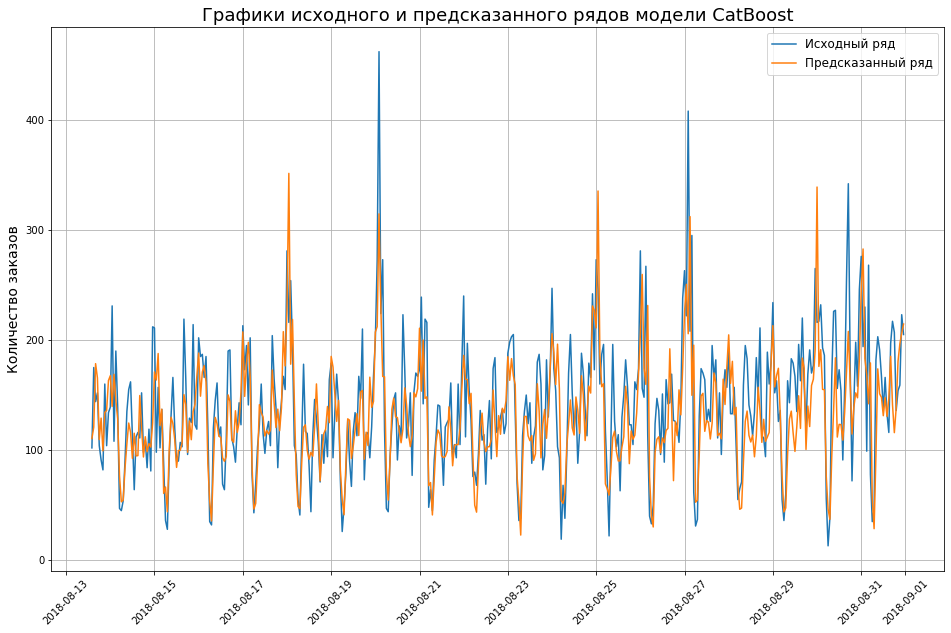

In [35]:
plt.figure(figsize=(16, 10))
plt.plot(target_test)
plt.plot(pd.DataFrame(predictions_cat, target_test.index))
plt.title('Графики исходного и предсказанного рядов модели CatBoost', fontsize=18)
plt.ylabel('Количество заказов', fontsize=14)
plt.legend(['Исходный ряд', 'Предсказанный ряд'], fontsize=12)
plt.xticks(rotation=45)
plt.legend
plt.grid()
plt.show()

In [36]:
rmse_lr, predictions_lr = model_predict(lr, features_test_ohe, target_test_ohe, RMSE_list)

print(f'RMSE модели LinearRegression: {rmse_lr:.2f}')

RMSE модели LinearRegression: 48.30


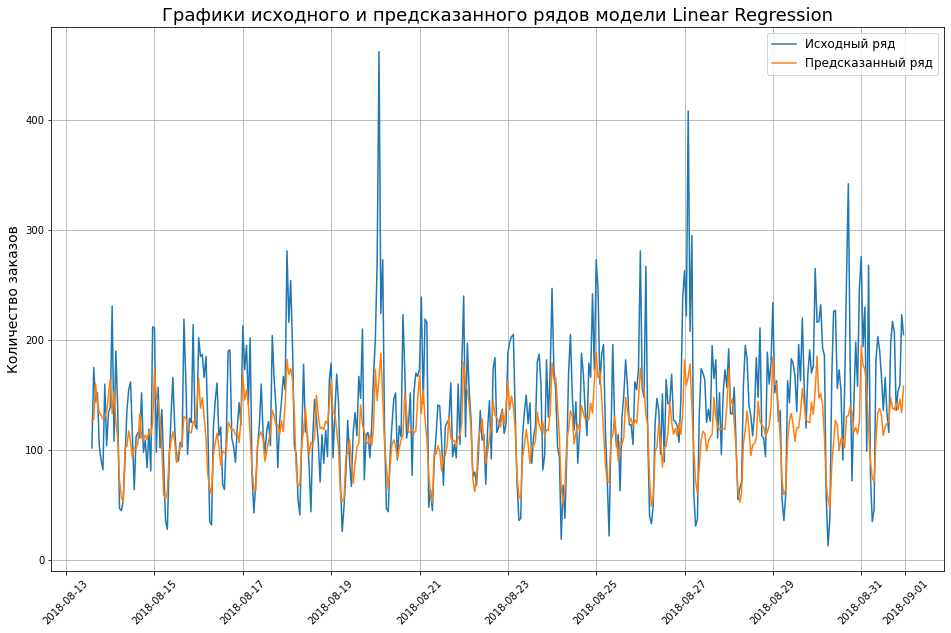

In [37]:
plt.figure(figsize=(16, 10))
plt.plot(target_test)
plt.plot(pd.DataFrame(predictions_lr, target_test.index))
plt.title('Графики исходного и предсказанного рядов модели Linear Regression', fontsize=18)
plt.ylabel('Количество заказов', fontsize=14)
plt.legend(['Исходный ряд', 'Предсказанный ряд'], fontsize=12)
plt.xticks(rotation=45)
plt.legend
plt.grid()
plt.show()

In [38]:
rmse_rf, predictions_rf = model_predict(rfr, features_test_ohe, target_test_ohe, RMSE_list)

print(f'RMSE модели RandomForestRegressor: {rmse_rf:.2f}')

RMSE модели RandomForestRegressor: 48.53


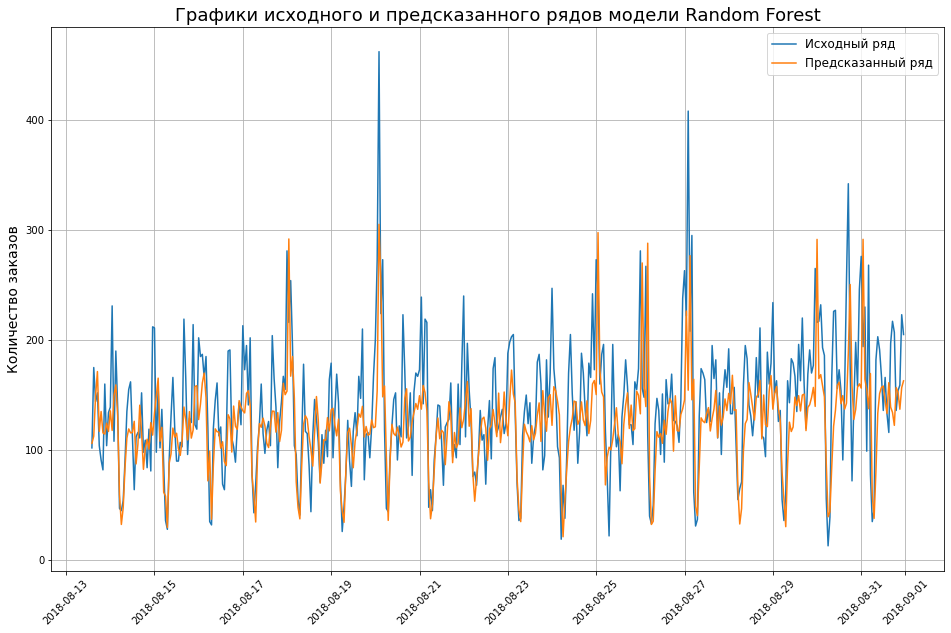

In [39]:
plt.figure(figsize=(16, 10))
plt.plot(target_test)
plt.plot(pd.DataFrame(predictions_rf, target_test.index))
plt.title('Графики исходного и предсказанного рядов модели Random Forest', fontsize=18)
plt.ylabel('Количество заказов', fontsize=14)
plt.legend(['Исходный ряд', 'Предсказанный ряд'], fontsize=12)
plt.xticks(rotation=45)
plt.legend
plt.grid()
plt.show()

<b>Вывод: </b>Лучший результат у CatBoost.

## Общий вывод

В процессе работы были исследованы три модели машинного обучения:

* CatBoost Regression
* Linear Regression
* Random Forest Regresison

Результаты собраны в таблице ниже:

In [40]:
pd.set_option('max_colwidth', 400)

ml_models_summary['Model'] = model_name_list
ml_models_summary['RMSE'] = RMSE_list
ml_models_summary['Comments'] = comment_list

ml_models_summary

Model       RMSE  \
0           CatBoost  41.577542   
1  Linear Regression  48.301426   
2      Random Forest  48.526328   

                                                Comments  
0  {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.15}  
1                                                    N/A  
2                          max_depth=17, n_estimators=91

Самой качественной моделью по метрике RMSE стала CatBoost. Второй результат линейной регрессии. У случайного леса последнее место. CatBoost и линейная регрессия показали результат лучше требуемого RMSE = 48.